In [1]:
import os
import path 
import numpy as np
import pandas as pd
import re
import torch
import collections
import random
import gffpandas.gffpandas as gffpd
import random
from Bio.Seq import Seq

import scipy
import scipy.stats
import matplotlib.pyplot as plt
directory = os.getcwd()
folders = os.listdir(directory)

In [2]:
genomes = [name for name in os.listdir("/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data/")]
genomes.remove('.DS_Store')
sorted_genomes = sorted(genomes)


In [3]:
random.seed(5)
torch.manual_seed(5)
train_x = np.array([])
train_y = np.array([])
test_x = np.array([])
test_y = np.array([])

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def read_fasta(dir_name, genome_name, file_name):
    #'sampled_genomes_resampled/'
    f=open(str(dir_name) + '/' + str(genome_name) + '/' + file_name,'r')
    lines=f.readlines()

    hre=re.compile('>(\S+)')
    lre=re.compile('^(\S+)$')

    gene={}

    for line in lines:
            outh = hre.search(line)
            if outh:
                    id=outh.group(1)
            else:
                    outl=lre.search(line)
                    if(id in gene.keys()):
                            gene[id] += outl.group(1)
                    else:
                            gene[id]  =outl.group(1)
    return list(gene.values())

def create_csv(dir_name, genome, coding_seqs, sampled_noncoding_seqs):
    num_coding_seqs = len(coding_seqs)
    num_noncoding_seqs = len(sampled_noncoding_seqs)
    coding_indices = np.arange(0, num_coding_seqs, 1)
    coding_groundtruth = np.arange(0, num_coding_seqs, 1)
    coding_train = ['train'] * num_coding_seqs
    noncoding_indices = np.arange(0, num_noncoding_seqs, 1)
    noncoding_test = ['test'] * num_noncoding_seqs
    noncoding_groundtruth = np.arange(0, num_noncoding_seqs, 1)
    
    data = {'sequence': coding_seqs, 'target': coding_groundtruth, 'set': coding_train, 'validation': [np.nan] * num_coding_seqs}
    coding_df = pd.DataFrame(data, index=coding_indices)
    coding_df.to_csv(dir_name + '/' + genome + '/debug_coding_train.csv')
    
    data = {'sequence': sampled_noncoding_seqs, 'target': noncoding_groundtruth, 'set': noncoding_test, 'validation': [np.nan] * num_noncoding_seqs}
    noncoding_df = pd.DataFrame(data, index=noncoding_indices)
    noncoding_df.to_csv(dir_name + '/' + genome + '/debug_noncoding_test.csv')
    
def find_first_index(lst, target):
    """
    Finds the index of the first matching element in the given list.
    If no match is found, returns -1.
    """
    for i, item in enumerate(lst):
        if item == target:
            return i
    return -1

    
def create_dict(lst):
    result = {element: [] for element in lst}
    return result

def filter_duplicate_subdirectories(directories):
    """
    Returns a dictionary where the keys are directory names and the values are lists of subdirectories,
    filtered to exclude duplicates except for the first encounter of each subdirectory name
    in the order of directories sorted in lexicographic order.
    """
    filtered_directory_indices = create_dict(directories.keys())
    filtered_directory_genes = create_dict(directories.keys())
    subdirectory_set = set()
    for directory_name in sorted(directories.keys()):
        for i in range(len(directories[directory_name])):
            if not directories[directory_name][i] in subdirectory_set:
                filtered_directory_indices[directory_name].append(i)
                filtered_directory_genes[directory_name].append(directories[directory_name][i])
                subdirectory_set.add(directories[directory_name][i])
            else:
                continue
    return filtered_directory_genes

    

# loading sampled data

In [6]:
random.seed(5)
torch.manual_seed(5)
coding_genes = []
noncoding_genes = []
positive_genomes = {}
negative_genomes = {}
for genome in genomes:
    # adding a length constraint
    length_upper_limit = 60
    length_lower_limit = 0
    positive_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/post_processed_data/' + genome + '/coding_train.csv')['sequence'])
    negative_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/post_processed_data/' + genome + '/noncoding_test.csv')['sequence'])
    positive_testing_sequences = [positive_testing_sequence for positive_testing_sequence in positive_testing_sequences if len(positive_testing_sequence) < 60]
    negative_testing_sequences = [negative_testing_sequence for negative_testing_sequence in negative_testing_sequences if len(negative_testing_sequence) < 60]
    coding_genes.extend(positive_testing_sequences)
    noncoding_genes.extend(negative_testing_sequences)
    
    positive_genomes[genome] = positive_testing_sequences
    negative_genomes[genome] = negative_testing_sequences
    

In [7]:
print('In total, there are ' + str(len(coding_genes)) + ' coding regions, out of which ' + str(len(set(coding_genes))) + ' are unique.')
print('In total, there are ' + str(len(noncoding_genes)) + ' noncoding regions, out of which ' + str(len(set(noncoding_genes))) + ' are unique.')


In total, there are 145232 coding regions, out of which 128615 are unique.
In total, there are 145231 noncoding regions, out of which 143362 are unique.


In [8]:
import collections
result = collections.Counter(coding_genes) & collections.Counter(noncoding_genes)
intersected_list = list(result.elements())
print(len(intersected_list))
print(len(set(intersected_list)))

39
38


In [9]:
#removing these from all datasets
unique_intersected_list = set(intersected_list)
for genome in genomes:
    for gene in positive_genomes[genome]:
        if gene in unique_intersected_list:
            positive_genomes[genome].remove(gene)
    for gene in negative_genomes[genome]:
        if gene in unique_intersected_list:
            negative_genomes[genome].remove(gene)

## filtering out sequences which are longer or equal to 60 AAs

In [10]:
for genome in genomes:
    for gene in positive_genomes[genome]:
        if len(gene) >= 60:
            positive_genomes[genome].remove(gene)
    for gene in negative_genomes[genome]:
        if len(gene) >= 60:
            negative_genomes[genome].remove(gene)

### filtering duplicates in lexicographical order

In [204]:
def filter_duplicate_subdirectories(directories):
    """
    Returns a dictionary where the keys are directory names and the values are lists of subdirectories,
    filtered to exclude duplicates except for the first encounter of each subdirectory name
    in the order of directories sorted in lexicographic order.
    """
    filtered_directory_indices = create_dict(directories.keys())
    filtered_directory_genes = create_dict(directories.keys())
    subdirectory_set = set()
    for directory_name in sorted(directories.keys()):
        for i in range(len(directories[directory_name])):
            if not directories[directory_name][i] in subdirectory_set:
                filtered_directory_indices[directory_name].append(i)
                filtered_directory_genes[directory_name].append(directories[directory_name][i])
                subdirectory_set.add(directories[directory_name][i])
            else:
                continue
    return filtered_directory_genes

In [12]:
#running filtering on all genomes
positive_filtered_genes = filter_duplicate_subdirectories(positive_genomes)
negative_filtered_genes = filter_duplicate_subdirectories(negative_genomes)

In [13]:
#sanity check that there are no duplicates and no shared elements in coding regions and noncoding regions
print('There are ' + str(len(collections.Counter(flatten(positive_filtered_genes.values())) & collections.Counter(flatten(negative_filtered_genes.values())))) + ' intersected sequences')
assert(len(flatten(positive_filtered_genes.values())) == len(set(flatten(positive_filtered_genes.values()))))
assert(len(flatten(negative_filtered_genes.values())) == len(set(flatten(negative_filtered_genes.values()))))


There are 0 intersected sequences


In [14]:
#data after filtering
print('There are, in total, ' + str(len(flatten(positive_filtered_genes.values()))) + ' coding regions')
print('There are, in total, ' + str(len(flatten(negative_filtered_genes.values()))) + ' noncoding regions')


There are, in total, 128578 coding regions
There are, in total, 143325 noncoding regions


In [16]:
#get all the indices:
positive_filtered_genes_indices = {}
negative_filtered_genes_indices = {}

def indices_of_elements(list1, list2):
    indices = []
    for element in list1:
        try:
            index = list2.index(element)
            indices.append(index)
        except ValueError:
            print('sequence not found!')
            pass
    return indices

for genome in genomes:
    positive_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/post_processed_data/' + genome + '/coding_train.csv')['sequence'])
    negative_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/post_processed_data/' + genome + '/noncoding_test.csv')['sequence'])
    
    filtered_positive_genes = positive_filtered_genes[genome]
    filtered_negative_genes = negative_filtered_genes[genome]
    
    positive_filtered_genes_indices[genome] = indices_of_elements(filtered_positive_genes, positive_testing_sequences)
    negative_filtered_genes_indices[genome] = indices_of_elements(filtered_negative_genes, negative_testing_sequences)
    

In [18]:
len(a)

128578

In [19]:
len(b)

143325

In [17]:
a = [len(coding_region) for coding_region in flatten(positive_filtered_genes.values())]
b = [len(noncoding_region) for noncoding_region in flatten(negative_filtered_genes.values())]

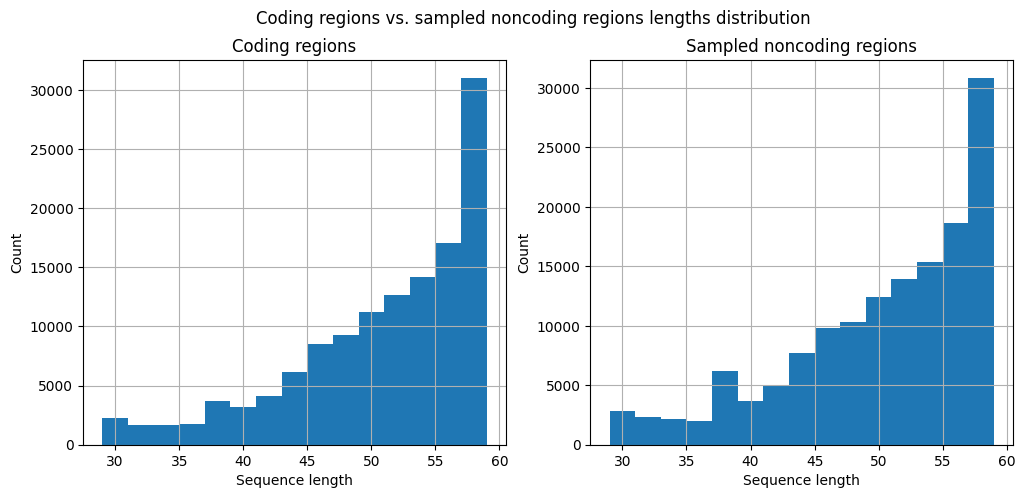

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Coding regions vs. sampled noncoding regions lengths distribution')
axes[0].set_title('Coding regions')
axes[1].set_title('Sampled noncoding regions')

axes[0].set_xlabel('Sequence length')
axes[0].set_ylabel('Count')

axes[1].set_xlabel('Sequence length')
axes[1].set_ylabel('Count')
# plt.xlabel('Count')
# plt.ylabel('Protein sequence length')

pd.Series(a).hist(bins=15, ax=axes[0])
pd.Series(b).hist(bins=15, ax=axes[1])
plt.show()

# fig.savefig('length_distribution.jpg')

# 10 fold cross validation

### loading all embeddings 

In [27]:
#getting train and test folders:
MAX_FOLD = 10
post_processed_data_PATH = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data'
all_genomes = os.listdir(post_processed_data_PATH)
all_genomes.remove('.DS_Store')


def retrieve_train_test_folders(genomes, hold_out_index):
    num_genomes = len(genomes)
    if hold_out_index == MAX_FOLD - 1:
        test_split = genomes[int((num_genomes//10) * hold_out_index): ]
        train_split = list(set(genomes) - set(test_split))
        assert len(train_split) + len(test_split) == num_genomes, "numbers do not match up!"
        return train_split, test_split
    test_split = genomes[int((num_genomes//10) * hold_out_index): int(num_genomes//10 * (hold_out_index + 1))]
    train_split = list(set(genomes) - set(test_split))
    assert len(train_split) + len(test_split) == num_genomes, "numbers do not match up!"
    return train_split, test_split
    
train_genomes, test_genomes = retrieve_train_test_folders(all_genomes, 0)


In [22]:
random.seed(5)
torch.manual_seed(5)
def load_data(genomes):
    all_x = np.array([])
    all_y = np.array([])

    random.seed(5)
    torch.manual_seed(5)
    for genome in genomes:
        
        positive_indices = np.array(positive_filtered_genes_indices[genome]) 
        negative_indices = np.array(negative_filtered_genes_indices[genome])

        if positive_indices.shape[0] != 0:
            genome_train_coding_embeddings = torch.load('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data/' + genome + '/coding_train_emb/train_mean.pt')
            genome_train_coding_labels = np.ones(genome_train_coding_embeddings.shape[0])[positive_indices]
            genome_train_coding_embeddings = genome_train_coding_embeddings[positive_indices]
            assert genome_train_coding_embeddings.shape[0] == len(positive_indices)

        if negative_indices.shape[0] != 0:
            genome_train_noncoding_embeddings = torch.load('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data/' + genome + '/noncoding_test_emb/train_mean.pt')
            genome_train_noncoding_labels = np.zeros(genome_train_noncoding_embeddings.shape[0])[negative_indices]
            genome_train_noncoding_embeddings = genome_train_noncoding_embeddings[negative_indices]
            assert genome_train_noncoding_embeddings.shape[0] == len(negative_indices)

        if all_x.shape[0] == 0:
            all_x = genome_train_coding_embeddings
            all_y = genome_train_coding_labels
            all_x = np.concatenate((all_x, genome_train_noncoding_embeddings), axis=0)
            all_y = np.concatenate((all_y, genome_train_noncoding_labels), axis=0)
            continue

        if positive_indices.shape[0] != 0:
            all_x = np.concatenate((all_x, genome_train_coding_embeddings), axis=0)
            all_y = np.concatenate((all_y, genome_train_coding_labels), axis=0)
        
        if negative_indices.shape[0] != 0:
            all_x = np.concatenate((all_x, genome_train_noncoding_embeddings), axis=0)
            all_y = np.concatenate((all_y, genome_train_noncoding_labels), axis=0)
    return all_x, all_y


In [23]:
all_data_folds_embs, all_data_folds_labels = [], []
MAX_FOLD = 10
for i in range(0, MAX_FOLD, 1):
    train_split, test_split = retrieve_train_test_folders(genomes, i)
    embs, labels = load_data(test_split)
    all_data_folds_embs.append(embs)
    all_data_folds_labels.append(labels)
    

In [24]:
# sub_positive_filtered_genes = {k:v for k, v in positive_filtered_genes.items() if k in retrieve_train_test_folders(genomes, 0)[1]}
# sub_negative_filtered_genes = {k:v for k, v in negative_filtered_genes.items() if k in retrieve_train_test_folders(genomes, 0)[1]}


Note that after applying filters, some of the genomes have no coding regions or noncoding regions

In [25]:
#sanity check that the dimension of the loaded data is equal to the dimension of the indices in the dictionary
assert np.vstack(all_data_folds_embs).shape[0] == len(flatten(positive_filtered_genes.values())) + len(flatten(negative_filtered_genes.values()))


In [101]:
empty_positive_genomes = []
for genome in genomes:
    if not positive_filtered_genes_indices[genome]:
        empty_positive_genomes.append(genome)
        print(genome)
        print('none!')
    

GCF_018406645.1_ASM1840664v1
none!
GCF_017896245.1_ASM1789624v1
none!
GCF_002850495.1_ASM285049v1
none!
GCF_018467135.1_ASM1846713v1
none!
GCF_011455875.1_ASM1145587v1
none!
GCF_002804025.1_ASM280402v1
none!


In [102]:
empty_negative_genomes = []
for genome in genomes:
    if not negative_filtered_genes_indices[genome]:
        empty_negative_genomes.append(genome)
        print(genome)
        print('none!')

GCF_000287275.1_ASM28727v1
none!
GCF_001447915.1_ASM144791v1
none!


## training clasifier

In [26]:
#loading classifier:
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
  def __init__(self,input_shape):
    super(Net,self).__init__()
    #input embedding: 1280
    self.fc1 = nn.Linear(input_shape,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,1)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

class Net1(nn.Module):
  def __init__(self,input_shape):
    super(Net1,self).__init__()
    #input embedding: 1280
    self.fc1 = nn.Linear(input_shape,32)
    self.fc2 = nn.Linear(32,64)
    self.fc3 = nn.Linear(64,128)
    self.fc4 = nn.Linear(128,64)
    self.fc5 = nn.Linear(64,32)
    self.fc6 = nn.Linear(32,1)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    torch.nn.init.xavier_uniform_(self.fc4.weight)
    torch.nn.init.xavier_uniform_(self.fc5.weight)
    torch.nn.init.xavier_uniform_(self.fc6.weight)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.sigmoid(self.fc6(x))
    return x

class Net3(nn.Module):
  def __init__(self,input_shape):
    super(Net3,self).__init__()
    #input embedding: 1280
    self.fc1 = nn.Linear(input_shape,1)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    
  def forward(self,x):
    x = torch.sigmoid(self.fc1(x))
    return x

class Net4(nn.Module):
  def __init__(self,input_shape):
    super(Net4,self).__init__()
    #input embedding: 1280
    self.fc1 = nn.Linear(input_shape,128)
    self.fc2 = nn.Linear(128,256)
    self.fc3 = nn.Linear(256,512)
    self.fc4 = nn.Linear(512,256)
    self.fc5 = nn.Linear(256,128)
    self.fc6 = nn.Linear(128,64)
    self.fc7 = nn.Linear(64,32)
    self.fc8 = nn.Linear(32,1)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    torch.nn.init.xavier_uniform_(self.fc3.weight)
    torch.nn.init.xavier_uniform_(self.fc4.weight)
    torch.nn.init.xavier_uniform_(self.fc5.weight)
    torch.nn.init.xavier_uniform_(self.fc6.weight)
    torch.nn.init.xavier_uniform_(self.fc7.weight)
    torch.nn.init.xavier_uniform_(self.fc8.weight)
    
  def forward(self,x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.relu(self.fc7(x))
    x = torch.sigmoid(self.fc8(x))
    return x

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list

In [402]:
def create_train_test_data(all_data_folds_embs, all_data_folds_labels, fold):
    test_split = [fold]
    train_split = list(set(list(range(10))) - set([fold]))
    train_x = np.vstack([all_data_folds_embs[i] for i in train_split])
    train_y = np.concatenate([all_data_folds_labels[i] for i in train_split])
    test_x = np.vstack([all_data_folds_embs[i] for i in test_split])
    test_y = np.concatenate([all_data_folds_labels[i] for i in test_split])
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, 0)

#checking dimensions:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)
    

(245544, 1280)
(245544,)
(26359, 1280)
(26359,)


In [86]:
#randomly shuffling train_x, train_y and their corresponding labels
random.seed(5)
torch.manual_seed(5)
training_indices = np.arange(train_x.shape[0])
test_indices = np.arange(test_x.shape[0])
np.random.shuffle(training_indices)
np.random.shuffle(test_indices)

In [87]:
train_x = train_x[training_indices]
train_y = train_y[training_indices]
test_x = test_x[test_indices]
test_y = test_y[test_indices]

In [123]:
random.seed(5)
torch.manual_seed(5)
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length
trainset = dataset(train_x, train_y)
#DataLoader
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

In [126]:
#hyper parameters
random.seed(5)
torch.manual_seed(5)
learning_rate = 0.01
epochs = 300
# Model , Optimizer, Loss
ecoli_model = Net4(input_shape=train_x.shape[1])
optimizer = torch.optim.SGD(ecoli_model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [127]:
#forward loop
random.seed(5)
torch.manual_seed(5)
losses = []
accur = []
for i in range(epochs):
  for j,(x_train,y_train) in enumerate(trainloader):
    
    #calculate output
    output = ecoli_model(x_train)
 
    #calculate loss
    loss = loss_fn(output,y_train.reshape(-1,1))
 
    #accuracy
    predicted = ecoli_model(torch.tensor(x_train,dtype=torch.float32))
    acc = (predicted.reshape(-1).detach().numpy().round() == np.array(y_train)).mean()
    #backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if i%50 == 0:
    losses.append(loss)
    accur.append(acc)
    print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

/Users/tonytu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


epoch 0	loss : 0.35475677251815796	 accuracy : 0.825
epoch 50	loss : 0.2417881041765213	 accuracy : 0.85
epoch 100	loss : 0.23424482345581055	 accuracy : 0.85
epoch 150	loss : 0.08079352974891663	 accuracy : 0.975
epoch 200	loss : 0.030199166387319565	 accuracy : 0.975
epoch 250	loss : 0.06520775705575943	 accuracy : 0.975


# Run 10-fold cross validation

In [708]:
for epoch in range(0, 10, 1):
    train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, epoch)
    
    random.seed(5)
    torch.manual_seed(5)
    training_indices = np.arange(train_x.shape[0])
    test_indices = np.arange(test_x.shape[0])
    np.random.shuffle(training_indices)
    np.random.shuffle(test_indices)
    
    train_x = train_x[training_indices]
    train_y = train_y[training_indices]
    test_x = test_x[test_indices]
    test_y = test_y[test_indices]
    
    trainset = dataset(train_x, train_y)
    #DataLoader
    trainloader = DataLoader(trainset,batch_size=64,shuffle=False)
    
    #hyper parameters
    random.seed(5)
    torch.manual_seed(5)
    learning_rate = 0.01
    epochs = 300
    # Model , Optimizer, Loss
    ecoli_model = Net1(input_shape=train_x.shape[1])
    optimizer = torch.optim.SGD(ecoli_model.parameters(),lr=learning_rate)
    loss_fn = nn.BCELoss()
    
    random.seed(5)
    torch.manual_seed(5)
    losses = []
    accur = []
    for i in range(epochs):
      for j,(x_train,y_train) in enumerate(trainloader):

        #calculate output
        output = ecoli_model(x_train)

        #calculate loss
        loss = loss_fn(output,y_train.reshape(-1,1))

        #accuracy
        predicted = ecoli_model(torch.tensor(x_train,dtype=torch.float32))
        acc = (predicted.reshape(-1).detach().numpy().round() == np.array(y_train)).mean()
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      if i%50 == 0:
        losses.append(loss)
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))
    
    #saving model
    PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_ten_fold_cross_validation_models/six_layer_fold_" + str(epoch) + "_genomes.pt"
    torch.save(ecoli_model, PATH)
    
    

/Users/tonytu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0	loss : 0.17696475982666016	 accuracy : 0.95
epoch 50	loss : 0.14576508104801178	 accuracy : 0.925
epoch 100	loss : 0.13810546696186066	 accuracy : 0.925
epoch 150	loss : 0.1344241350889206	 accuracy : 0.95
epoch 200	loss : 0.1285872459411621	 accuracy : 0.95
epoch 250	loss : 0.11938326060771942	 accuracy : 0.95
epoch 0	loss : 0.24542240798473358	 accuracy : 0.8727272727272727
epoch 50	loss : 0.16304725408554077	 accuracy : 0.9272727272727272
epoch 100	loss : 0.1430915892124176	 accuracy : 0.9272727272727272
epoch 150	loss : 0.14132927358150482	 accuracy : 0.9454545454545454
epoch 200	loss : 0.13264790177345276	 accuracy : 0.9454545454545454
epoch 250	loss : 0.10950611531734467	 accuracy : 0.9818181818181818
epoch 0	loss : 0.06013019010424614	 accuracy : 0.95
epoch 50	loss : 0.03936905413866043	 accuracy : 1.0
epoch 100	loss : 0.03182206302881241	 accuracy : 1.0
epoch 150	loss : 0.03195275738835335	 accuracy : 1.0
epoch 200	loss : 0.03518430143594742	 accuracy : 1.0
epoch 250	lo

## evaluating model performance (aggregate)

In [81]:
accuracies, precisions, recalls, F1s = [], [], [], []
for i in range(10):
    print("fold " + str(i))
    # PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_models_with_42_held_out/six_layer_4246_genomes.pt"
    PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_ten_fold_cross_validation_models/six_layer_fold_" + str(i) + "_genomes.pt"
    ecoli_model = torch.load(PATH)
    ecoli_model.eval()
    train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, i)
    test_output_raw = ecoli_model(torch.Tensor(test_x))
    test_output = test_output_raw.round()
    accuracy, precision, recall, f1 = perf_measure(list(test_y), list(test_output.detach().numpy()))
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    F1s.append(f1)
    print('\n')
    

fold 0
total samples: 26359
TP: 11295
FP: 593
TN: 13380
FN: 1091
accuracy: 0.936112902613908
precision: 0.9501177658142664
recall: 0.9119166801227192
F1: 0.9306253604679905


fold 1
total samples: 28136
TP: 12162
FP: 900
TN: 13976
FN: 1098
accuracy: 0.9289877736707421
precision: 0.9310978410656867
recall: 0.9171945701357466
F1: 0.9240939138363347


fold 2
total samples: 30155
TP: 13216
FP: 1047
TN: 14780
FN: 1112
accuracy: 0.9284032498756425
precision: 0.9265932833204795
recall: 0.9223897264098269
F1: 0.9244867265922843


fold 3
total samples: 27793
TP: 12172
FP: 656
TN: 13928
FN: 1037
accuracy: 0.9390853812110963
precision: 0.9488618646710321
recall: 0.9214929214929215
F1: 0.9349771479049045


fold 4
total samples: 26517
TP: 11761
FP: 863
TN: 13014
FN: 879
accuracy: 0.9343062940754987
precision: 0.9316381495564005
recall: 0.9304588607594937
F1: 0.9310481317289423


fold 5
total samples: 27544
TP: 12336
FP: 1063
TN: 13546
FN: 599
accuracy: 0.9396601800755155
precision: 0.92066572132248

In [82]:
print(np.mean(accuracies))
print(np.mean(precisions))
print(np.mean(recalls))
print(np.mean(F1s))

print('\n')
print(np.std(accuracies))
print(np.std(precisions))
print(np.std(recalls))
print(np.std(F1s))

0.9328600372308367
0.9299770414507542
0.9284336461396399
0.9290137996412635


0.00901707379667163
0.01904660104093219
0.01213611801711675
0.008974881322393312


In [818]:
# PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_ten_fold_cross_validation_models/six_layer_fold_" + str(0) + "_genomes.pt"
PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/FINAL_7_layer_5_genomes_model.pt"
ecoli_model = torch.load(PATH)
ecoli_model.eval()


Net1(
  (fc1): Linear(in_features=1280, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
)

In [128]:
#saving model
PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/ablation_study/nine_layer_fold_0_genomes.pt"
torch.save(ecoli_model, PATH)


In [129]:
# PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_ten_fold_cross_validation_models/six_layer_fold_" + str(0) + "_genomes.pt"
PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/ablation_study/nine_layer_fold_0_genomes.pt"
ecoli_model = torch.load(PATH)
ecoli_model.eval()


Net4(
  (fc1): Linear(in_features=1280, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=64, bias=True)
  (fc7): Linear(in_features=64, out_features=32, bias=True)
  (fc8): Linear(in_features=32, out_features=1, bias=True)
)

In [130]:
test_output_raw = ecoli_model(torch.Tensor(test_x))
test_output = test_output_raw.round()

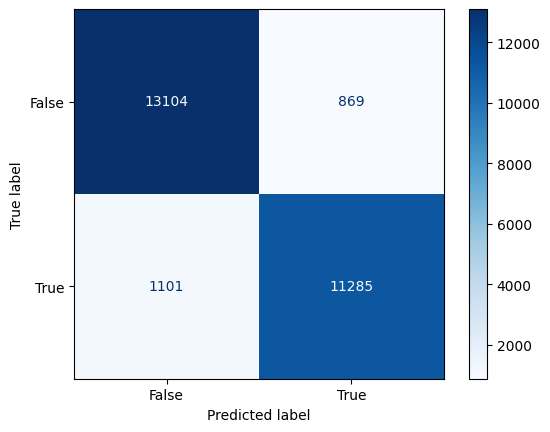

In [131]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

actual = numpy.random.binomial(1,.9,size = 1000)
predicted = numpy.random.binomial(1,.9,size = 1000)

confusion_matrix = metrics.confusion_matrix(list(test_y), list(test_output.detach().numpy()))
# confusion_matrix = metrics.confusion_matrix(list(test_y), list(a))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# cm_display.set_ticklabels_format("d")
# np.set_printoptions(suppress=True) # disable scientific notation
cm_display.plot(cmap="Blues", values_format='')
plt.show()

In [37]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    print("total samples: " + str(len(y_actual)))
    print("TP: " + str(TP))
    print("FP: " + str(FP))
    print("TN: " + str(TN))
    print("FN: " + str(FN))
    accuracy = accuracy_score(y_actual, y_hat)
    precision = precision_score(y_actual, y_hat)
    recall = recall_score(y_actual, y_hat)
    f1 = f1_score(y_actual, y_hat)
    print("accuracy: " + str(accuracy))
    print("precision: " + str(precision))
    print("recall: " + str(recall))
    print("F1: " + str(f1))
    return accuracy, precision, recall, f1

In [133]:
accuracy, precision, recall, f1 = perf_measure(list(test_y), list(test_output.detach().numpy()))

total samples: 26359
TP: 11285
FP: 869
TN: 13104
FN: 1101
accuracy: 0.9252627186160325
precision: 0.9285009050518348
recall: 0.9111093169707735
F1: 0.9197229013854931


# evaluating genome by genome

In [38]:
random.seed(5)
torch.manual_seed(5)
accuracies, precisions, recalls, F1s = [], [], [], []

def evaluate_by_genome(genomes, find_TP_index = False):
    PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_ten_fold_cross_validation_models/six_layer_fold_0_genomes.pt"
    ecoli_model = torch.load(PATH)
    ecoli_model.eval()

    random.seed(5)
    torch.manual_seed(5)
    for genome in genomes:
        print(genome)
        test_x = np.array([])
        test_y = np.array([])
        positive_indices = np.array(positive_filtered_genes_indices[genome]) 
        negative_indices = np.array(negative_filtered_genes_indices[genome])
        if positive_indices.shape[0] == 0 or negative_indices.shape[0] == 0:
            continue

        genome_train_coding_embeddings = torch.load('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data/' + genome + '/coding_train_emb/train_mean.pt')
        genome_train_coding_labels = np.ones(genome_train_coding_embeddings.shape[0])[positive_indices]
        genome_train_coding_embeddings = genome_train_coding_embeddings[positive_indices]
        assert genome_train_coding_embeddings.shape[0] == len(positive_indices)

        genome_train_noncoding_embeddings = torch.load('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data/' + genome + '/noncoding_test_emb/train_mean.pt')
        genome_train_noncoding_labels = np.zeros(genome_train_noncoding_embeddings.shape[0])[negative_indices]
        genome_train_noncoding_embeddings = genome_train_noncoding_embeddings[negative_indices]
        assert genome_train_noncoding_embeddings.shape[0] == len(negative_indices)
        
        if test_x.shape[0] == 0:
            test_x = genome_train_coding_embeddings
            test_y = genome_train_coding_labels
            test_x = np.concatenate((test_x, genome_train_noncoding_embeddings), axis=0)
            test_y = np.concatenate((test_y, genome_train_noncoding_labels), axis=0)

        test_output_raw = ecoli_model(torch.Tensor(test_x))
        test_output = test_output_raw.round()
        
        if find_TP_index:
            print(len(test_y))
            print(sum(test_y))
            print(len(test_y) - sum(test_y))
            print([i - int(sum(test_y)) for i in range(len(test_output)) if test_output[i] == 1 and test_y[i] == 0])
    
        accuracy, precision, recall, f1 = perf_measure(list(test_y), list(test_output.detach().numpy()))
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        F1s.append(f1)

evaluate_by_genome(genomes[:100], True)
        

GCF_000283915.1_ASM28391v1
98
48.0
50.0
[9, 21]
total samples: 98
TP: 27
FP: 2
TN: 48
FN: 21
accuracy: 0.7653061224489796
precision: 0.9310344827586207
recall: 0.5625
F1: 0.7012987012987013
GCF_002056795.1_ASM205679v1
66
33.0
33.0
[3, 6, 10, 13, 25]
total samples: 66
TP: 32
FP: 5
TN: 28
FN: 1
accuracy: 0.9090909090909091
precision: 0.8648648648648649
recall: 0.9696969696969697
F1: 0.9142857142857143
GCF_009734425.1_ASM973442v1
42
20.0
22.0
[8]
total samples: 42
TP: 20
FP: 1
TN: 21
FN: 0
accuracy: 0.9761904761904762
precision: 0.9523809523809523
recall: 1.0
F1: 0.975609756097561
GCF_003097575.1_ASM309757v1
31
16.0
15.0
[]
total samples: 31
TP: 14
FP: 0
TN: 15
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_900476035.1_53694_C01
36
16.0
20.0
[]
total samples: 36
TP: 15
FP: 0
TN: 20
FN: 1
accuracy: 0.9722222222222222
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
GCF_007750855.1_ASM775085v1
30
15.0
15.0
[0]
total samples: 30
TP: 14
FP: 1
TN:

accuracy: 0.9473684210526315
precision: 0.9444444444444444
recall: 0.9444444444444444
F1: 0.9444444444444444
GCF_000953655.1_LHA
50
25.0
25.0
[]
total samples: 50
TP: 21
FP: 0
TN: 25
FN: 4
accuracy: 0.92
precision: 1.0
recall: 0.84
F1: 0.9130434782608696
GCF_000828915.1_ASM82891v1
23
10.0
13.0
[]
total samples: 23
TP: 10
FP: 0
TN: 13
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_014217335.1_ASM1421733v1
24
12.0
12.0
[]
total samples: 24
TP: 12
FP: 0
TN: 12
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_002243665.1_ASM224366v1
185
81.0
104.0
[28, 82, 87]
total samples: 185
TP: 73
FP: 3
TN: 101
FN: 8
accuracy: 0.9405405405405406
precision: 0.9605263157894737
recall: 0.9012345679012346
F1: 0.9299363057324841
GCF_003265305.2_ASM326530v2
16
8.0
8.0
[]
total samples: 16
TP: 8
FP: 0
TN: 8
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003851555.1_ASM385155v1
86
37.0
49.0
[13, 36, 39, 48]
total samples: 86
TP: 35
FP: 4
TN: 45
FN: 2
accuracy: 0.9302325581395

In [834]:
# PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_ten_fold_cross_validation_models/six_layer_fold_" + str(0) + "_genomes.pt"
PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/FINAL_7_layer_5_genomes_model.pt"
ecoli_model = torch.load(PATH)
ecoli_model.eval()
five_genomes = ['GCF_000005845.2_ASM584v2', 'GCF_000022005.1_ASM2200v1', 'GCF_000009045.1_ASM904v1', 'GCF_000013425.1_ASM1342v1', 'GCF_000027325.1_ASM2732v1']

similar_genome = ['GCF_000006945.2_ASM694v2']


In [826]:
print(np.mean(accuracies), np.std(accuracies))
print(np.mean(precisions), np.std(precisions))
print(np.mean(recalls), np.std(recalls))
print(np.mean(F1s), np.std(F1s))



0.807382181505154 0.08080859075054792
0.9557485970819304 0.034604080809111544
0.6634324374849281 0.2134564478055572
0.7589389564582983 0.14515720502173257


In [31]:
import numpy
s = numpy.array(accuracies)
sort_index = numpy.argsort(s)
sorted_best_genomes = np.array(test_genomes)[sort_index[-60:]]
sorted_worst_genomes = np.array(test_genomes)[sort_index[:40]]

In [71]:
negative_filtered_genes_indices['GCF_009720625.1_ASM972062v1']

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156]

In [57]:
positive_filtered_genes['GCF_002688605.1_ASM268860v1']

['MNRVGNFLRDVGREMKKVSWPKKNELTRYTITVISTVVFMTLFFVVVDYGISSLIRLIP',
 'MYIFFIVFALFILFYINALTNTLCIQKEIPAEKQPKVFRTINVLITILLVSSYIEVSFT',
 'MGQNRHFTPGQKAPNNGVYIEIGETGSNVNNPQKVKLKAGERFPETANDDRHWTYMRKP',
 'MGRANNHKSSHNNKGSLPQTPKELKIAPDQANEEFSRELAQHHDAKAKQDLILKQQKEK',
 'MDRNTQFTMIRQALENSYHLMQQGIEVSGETLTQLEQAKAEYEAAFLLSQSTDSKFRCN',
 'MIQVKMFDKEHEKDLEFAVNRFLRKLEDEDVVDIKYQVTVDVDRDEQVYCFSAMVMYKA',
 'MPDFFDEFERFFEQHMMGEHRKRMKEVEKAENQMEQQERKLQQNVKRLDEQDAEDPFGQ',
 'MKIAGITLGVVILLFSFLFYILSLMQLVPLIIAGPLLFLAILIIFTLLNNHNKFRGFKK',
 'MEMEEQQEAIDLTKVYVYEEFPDKVAGRCDNCGHVKFKSLVKDFIFIRTCAKCGMKKSI',
 'MTEQLKKKISLQDAIKQQLANKKNQSSSKAKNGSTNQATKKLTSQQTKKTNNQRKRTGV',
 'MDKQRAKQIADSPVMANVTYNDTAVYIQHVSEENDTARIYPLGQPENEQNVAVSQLVEN',
 'MIGGQDEDSCGKSGTGETPQERKRRGGSAAARGKRRLARKSTAVSQAVQLMSTVCSSLD',
 'MIGGQGEDSCGKSGSGETPQERKRRGGSAAARGKRSLTRKSTSVSQAVQLMYLICSPLG',
 'MIGGQGEDSCGKSGTDETPQTRKRRGGSSAARGKRSLARKSTAVSRAIHMSLLIQFARL',
 'MNFNVVNRELLVGDVSITGVSSSSLFLIGDANYISLSSTFDTPAESLIIGPYVPLSLS',
 'MNRIERILIKLVVIQFVFLIIAQCILLSSSHSTYFSKVI

In [760]:
4288 * 15 / 60  / 24

44.666666666666664

### further analysis

## random baseline

In [747]:
def generate_random_vector(x):
    vector = []
    for _ in range(x):
        element = random.choice([0, 1])
        vector.append(element)
    return vector

random_accuracies, random_precisions, random_recalls, random_f1s = [], [], [], [] 

random.seed(5)
#since data is not completely balanced, we need to add a baseline which predicts labels randomly. 
for i in range(10):
    train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, i)
    print(train_x.shape)
    print(test_x.shape)
    random_vector = generate_random_vector(len(test_y))
    random_accuracy, random_precision, random_recall, random_f1 = perf_measure(list(test_y), list(random_vector))
    random_recalls.append(random_recall)
    random_accuracies.append(random_accuracy)
    random_precisions.append(random_precision)
    random_f1s.append(random_f1)
    


(245544, 1280)
(26359, 1280)
total samples: 26359
TP: 6223
FP: 7078
TN: 6895
FN: 6163
accuracy: 0.49766683106339393
precision: 0.46785955943162166
recall: 0.5024220894558372
F1: 0.4845252462335033
(243767, 1280)
(28136, 1280)
total samples: 28136
TP: 6633
FP: 7411
TN: 7465
FN: 6627
accuracy: 0.5010662496445835
precision: 0.47230133864995727
recall: 0.5002262443438914
F1: 0.48586287723410493
(241748, 1280)
(30155, 1280)
total samples: 30155
TP: 7217
FP: 7974
TN: 7853
FN: 7111
accuracy: 0.49975128502735866
precision: 0.47508393127509707
recall: 0.5036990508096035
F1: 0.48897320369931224
(244110, 1280)
(27793, 1280)
total samples: 27793
TP: 6589
FP: 7258
TN: 7326
FN: 6620
accuracy: 0.5006656352318929
precision: 0.47584314291904384
recall: 0.49882655765008704
F1: 0.4870638675340035
(245386, 1280)
(26517, 1280)
total samples: 26517
TP: 6242
FP: 6990
TN: 6887
FN: 6398
accuracy: 0.49511634046083647
precision: 0.47173518742442566
recall: 0.49382911392405066
F1: 0.4825293753865183
(244359, 1280

In [748]:
print(np.mean(random_accuracies), np.std(random_accuracies))
print(np.mean(random_precisions), np.std(random_precisions))
print(np.mean(random_recalls), np.std(random_recalls))
print(np.mean(random_f1s), np.std(random_f1s))

0.49938771095139967 0.002909228019437151
0.47235386543608826 0.0024551607781829036
0.501439262100752 0.0036040333950898454
0.4864537041303881 0.0022595000503375763


## GeneMark Evaluation

In [603]:
def find_train_val_genome_indices(hold_out_index):
    num_genomes = len(all_genomes)
    test_split = np.arange(int((num_genomes//10) * hold_out_index), int(num_genomes//10 * (hold_out_index + 1)), 1)
    all_indices = np.arange(0, num_genomes, 1)
    train_split = np.array(list(set(all_indices) - set(test_split)))
    
    if hold_out_index == MAX_FOLD - 1:
        test_split = np.arange(int((num_genomes//10) * hold_out_index), num_genomes, 1)
        all_indices = np.arange(0, num_genomes, 1)
        train_split = np.array(list(set(all_indices) - set(test_split)))
    return np.array(all_genomes)[train_split], np.array(all_genomes)[test_split]
#     print(len(test_split))

In [121]:
#evaluating on positive strand: 
def positive_strand_inference_evaluate(groundtruths, predictions):
    exact_matches = 0
    results = []
    groundtruth_starts = [groundtruths[i][0] for i in range(len(groundtruths))]
    groundtruth_ends = [groundtruths[i][1] for i in range(len(groundtruths))]
    
    predictions_starts = [predictions[i][0] for i in range(len(predictions))]
    predictions_ends = [predictions[i][1] for i in range(len(predictions))]
    detect_5_prime = 0
    detect_3_prime = 0
    results = []
    none = 0
    
    for i in range(len(groundtruths)):
        if groundtruths[i] in predictions:
            exact_matches+=1
            results.append(1)
            continue
        else: 
            if groundtruths[i][0] in predictions_starts and not groundtruths[i][1] in predictions_ends:
                detect_5_prime += 1
                results.append(0)
#                 print('5 prime match, 3 prime mismatch!')
                continue
            elif not groundtruths[i][0] in predictions_starts and groundtruths[i][1] in predictions_ends:
                detect_3_prime += 1
                results.append(0)
#                 print('5 prime mismatch, 3 prime match!')
                continue
            else:
                none+=1
                results.append(0)
    return exact_matches, detect_5_prime, detect_3_prime, none, results

# positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_genemark_prediction)


In [122]:
def negative_strand_inference_evaluate(groundtruths, predictions):
    results = []
    exact_matches = 0
    groundtruth_starts = [groundtruths[i][0] for i in range(len(groundtruths))]
    groundtruth_ends = [groundtruths[i][1] for i in range(len(groundtruths))]
    
    predictions_starts = [predictions[i][0] for i in range(len(predictions))]
    predictions_ends = [predictions[i][1] for i in range(len(predictions))]
    detect_5_prime = 0
    detect_3_prime = 0
    results = []
    five_prime_mismatch_indices = []
    three_prime_mismatch_indices = []
    none = 0
    for i in range(len(groundtruths)):
        if groundtruths[i] in predictions:
            exact_matches+=1
            results.append(1)
            continue
        else: 
            if groundtruths[i][0] in predictions_starts and not groundtruths[i][1] in predictions_ends:
                detect_3_prime += 1
                results.append(0)
#                 print('3 prime match, 5 prime mismatch!')
            elif not groundtruths[i][0] in predictions_starts and groundtruths[i][1] in predictions_ends:
                detect_5_prime += 1
                results.append(0)
#                 print('3 prime mismatch, 5 prime match!') 
            else:
                none+=1
                results.append(0)
    return exact_matches, detect_5_prime, detect_3_prime, none, results

# negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_genemark_prediction)


In [606]:
#evaluating on positive strand: 
def noncoding_positive_strand_inference_evaluate(groundtruths, predictions):
    exact_matches = 0
    results = []
    groundtruth_starts = [groundtruths[i][0] for i in range(len(groundtruths))]
    groundtruth_ends = [groundtruths[i][1] for i in range(len(groundtruths))]
    
    predictions_starts = [predictions[i][0] for i in range(len(predictions))]
    predictions_ends = [predictions[i][1] for i in range(len(predictions))]
    detect_5_prime = 0
    detect_3_prime = 0
    results = []
    none = 0
    
    for i in range(len(groundtruths)):
        if groundtruths[i] in predictions:
            exact_matches+=1
            results.append(1)
            continue
        else: 
            if groundtruths[i][0] in predictions_starts and not groundtruths[i][1] in predictions_ends:
                detect_5_prime += 1
                results.append(0)
#                 print('5 prime match, 3 prime mismatch!')
                continue
            elif not groundtruths[i][0] in predictions_starts and groundtruths[i][1] in predictions_ends:
                detect_3_prime += 1
                results.append(0)
#                 print('5 prime mismatch, 3 prime match!')
                continue
            else:
                none+=1
                results.append(0)
    return exact_matches, detect_5_prime, detect_3_prime, none, results

# positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_genemark_prediction)


In [607]:
def noncoding_negative_strand_inference_evaluate(groundtruths, predictions):
    results = []
    exact_matches = 0
    groundtruth_starts = [groundtruths[i][0] for i in range(len(groundtruths))]
    groundtruth_ends = [groundtruths[i][1] for i in range(len(groundtruths))]
    
    predictions_starts = [predictions[i][0] for i in range(len(predictions))]
    predictions_ends = [predictions[i][1] for i in range(len(predictions))]
    detect_5_prime = 0
    detect_3_prime = 0
    results = []
    five_prime_mismatch_indices = []
    three_prime_mismatch_indices = []
    none = 0
    for i in range(len(groundtruths)):
        if groundtruths[i] in predictions:
            exact_matches+=1
            results.append(1)
            continue
        else: 
            if groundtruths[i][0] in predictions_starts and not groundtruths[i][1] in predictions_ends:
                detect_3_prime += 1
                results.append(0)
#                 print('3 prime match, 5 prime mismatch!')
            elif not groundtruths[i][0] in predictions_starts and groundtruths[i][1] in predictions_ends:
                detect_5_prime += 1
                results.append(0)
#                 print('3 prime mismatch, 5 prime match!') 
            else:
                none+=1
                results.append(0)
    return exact_matches, detect_5_prime, detect_3_prime, none, results

# negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_genemark_prediction)


In [287]:
six_genomes = ['ASM52304v1', 'ASM690v1', 'ASM80076v1', 'ASM2732v1', 'ASM73042v1', 'ASM59796v1']

In [294]:
for genome in train_genomes + test_genomes:
    for one_genome in six_genomes:
        if one_genome in genome:
            print(genome)

GCF_000027325.1_ASM2732v1


In [366]:
def read_noncod_fasta(dir_name, genome_name, file_name, training_indices):
    #'sampled_genomes_resampled/'
    f=open(str(dir_name) + '/' + str(genome_name) + '/' + file_name,'r')
    lines=f.readlines()

    information_lines = []
    sequence_lines = []
    
    positive_strand_noncoding_training_lines = []
    negative_strand_noncoding_training_lines = []
    for line in lines:
        if line.startswith('>'):
            information_lines.append(line)
        elif line.startswith('M'):
            sequence_lines.append(line)
    assert len(information_lines) == len(sequence_lines)
    for training_index in training_indices:
        information_line = information_lines[training_index]
        if information_line.endswith('(REVERSE SENSE) \n'):
            negative_strand_noncoding_training_lines.append([int(information_line.split(' ')[1][1:]), int(information_line.split(' ')[3][:-1])])
        else:
            positive_strand_noncoding_training_lines.append([int(information_line.split(' ')[1][1:]), int(information_line.split(' ')[3][:-1])])
    return positive_strand_noncoding_training_lines, negative_strand_noncoding_training_lines
    

In [693]:
all_recalls = []
for genome in list(train_genomes) + list(test_genomes):  
    print(genome)
    x, y = find_seqs_updated_negative([genome])
    genemark_accuracy, genemark_precision, genemark_recall, genemark_f1 = perf_measure(list(y), list(x))
    all_recalls.append(genemark_recall)


GCF_000283915.1_ASM28391v1
total samples: 98
TP: 36
FP: 0
TN: 50
FN: 12
accuracy: 0.8775510204081632
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
GCF_002056795.1_ASM205679v1
total samples: 66
TP: 21
FP: 0
TN: 33
FN: 12
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
GCF_009734425.1_ASM973442v1
total samples: 42
TP: 18
FP: 0
TN: 22
FN: 2
accuracy: 0.9523809523809523
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
GCF_003097575.1_ASM309757v1
total samples: 31
TP: 10
FP: 0
TN: 15
FN: 6
accuracy: 0.8064516129032258
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
GCF_900476035.1_53694_C01
total samples: 36
TP: 16
FP: 0
TN: 20
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_007750855.1_ASM775085v1
total samples: 30
TP: 11
FP: 0
TN: 15
FN: 4
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
GCF_001858005.1_ASM185800v1
total samples: 33
TP: 8
FP: 0
TN: 19
FN: 6
accuracy: 0.8181818181

total samples: 16
TP: 8
FP: 0
TN: 8
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003851555.1_ASM385155v1
total samples: 86
TP: 34
FP: 0
TN: 49
FN: 3
accuracy: 0.9651162790697675
precision: 1.0
recall: 0.918918918918919
F1: 0.9577464788732395
GCF_000214355.1_ASM21435v1
total samples: 30
TP: 11
FP: 0
TN: 15
FN: 4
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
GCF_021278985.1_ASM2127898v1
total samples: 127
TP: 36
FP: 0
TN: 69
FN: 22
accuracy: 0.8267716535433071
precision: 1.0
recall: 0.6206896551724138
F1: 0.7659574468085107
GCF_006385595.1_ASM638559v1
total samples: 28
TP: 11
FP: 0
TN: 15
FN: 2
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
GCF_001718895.1_ASM171889v1
total samples: 111
TP: 42
FP: 0
TN: 68
FN: 1
accuracy: 0.990990990990991
precision: 1.0
recall: 0.9767441860465116
F1: 0.988235294117647
GCF_900660515.1_50766_E01-3
total samples: 10
TP: 2
FP: 0
TN: 5
FN: 3
accuracy: 

/Users/tonytu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


total samples: 64
TP: 20
FP: 0
TN: 32
FN: 12
accuracy: 0.8125
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
GCF_002078315.1_ASM207831v1
total samples: 69
TP: 19
FP: 0
TN: 35
FN: 15
accuracy: 0.782608695652174
precision: 1.0
recall: 0.5588235294117647
F1: 0.7169811320754718
GCF_020783375.1_ASM2078337v1
total samples: 80
TP: 33
FP: 0
TN: 44
FN: 3
accuracy: 0.9625
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
GCF_003351545.1_ASM335154v1
total samples: 44
TP: 17
FP: 0
TN: 23
FN: 4
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8095238095238095
F1: 0.8947368421052632
GCF_000166695.1_ASM16669v1
total samples: 91
TP: 29
FP: 0
TN: 50
FN: 12
accuracy: 0.8681318681318682
precision: 1.0
recall: 0.7073170731707317
F1: 0.8285714285714285
GCF_002214585.1_ASM221458v1
total samples: 44
TP: 18
FP: 0
TN: 23
FN: 3
accuracy: 0.9318181818181818
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_009650215.1_ASM965021v1
total samples: 26
TP: 13
FP: 0
TN: 13
FN

accuracy: 0.7619047619047619
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
GCF_013368775.1_ASM1336877v1
total samples: 75
TP: 31
FP: 0
TN: 38
FN: 6
accuracy: 0.92
precision: 1.0
recall: 0.8378378378378378
F1: 0.911764705882353
GCF_022845715.1_ASM2284571v1
total samples: 21
TP: 8
FP: 0
TN: 11
FN: 2
accuracy: 0.9047619047619048
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_000024805.1_ASM2480v1
total samples: 36
TP: 14
FP: 0
TN: 18
FN: 4
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
GCF_900187235.1_52184_D01
total samples: 28
TP: 11
FP: 0
TN: 15
FN: 2
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
GCF_001414055.1_ASM141405v1
total samples: 92
TP: 38
FP: 0
TN: 46
FN: 8
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8260869565217391
F1: 0.9047619047619047
GCF_003515985.1_ASM351598v1
total samples: 66
TP: 22
FP: 0
TN: 34
FN: 10
accuracy: 0.8484848484848485
precision: 1.0
recall: 

total samples: 53
TP: 19
FP: 0
TN: 28
FN: 6
accuracy: 0.8867924528301887
precision: 1.0
recall: 0.76
F1: 0.8636363636363636
GCF_002843565.1_ASM284356v1
total samples: 12
TP: 2
FP: 0
TN: 6
FN: 4
accuracy: 0.6666666666666666
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
GCF_000010205.1_ASM1020v1
total samples: 60
TP: 19
FP: 0
TN: 29
FN: 12
accuracy: 0.8
precision: 1.0
recall: 0.6129032258064516
F1: 0.76
GCF_013170785.1_ASM1317078v1
total samples: 146
TP: 56
FP: 0
TN: 84
FN: 6
accuracy: 0.958904109589041
precision: 1.0
recall: 0.9032258064516129
F1: 0.9491525423728813
GCF_004135405.1_ASM413540v1
total samples: 33
TP: 13
FP: 0
TN: 18
FN: 2
accuracy: 0.9393939393939394
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
GCF_000212675.2_ASM21267v2
total samples: 78
TP: 33
FP: 0
TN: 39
FN: 6
accuracy: 0.9230769230769231
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
GCF_000020965.1_ASM2096v1
total samples: 19
TP: 11
FP: 0
TN: 7
FN: 1
accuracy: 0.947368421052

total samples: 29
TP: 12
FP: 0
TN: 16
FN: 1
accuracy: 0.9655172413793104
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
GCF_002952775.1_ASM295277v1
total samples: 90
TP: 36
FP: 0
TN: 45
FN: 9
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_000016345.1_ASM1634v1
total samples: 38
TP: 16
FP: 0
TN: 19
FN: 3
accuracy: 0.9210526315789473
precision: 1.0
recall: 0.8421052631578947
F1: 0.9142857142857143
GCF_000213215.1_ASM21321v1
total samples: 94
TP: 33
FP: 0
TN: 47
FN: 14
accuracy: 0.851063829787234
precision: 1.0
recall: 0.7021276595744681
F1: 0.825
GCF_900478135.1_28193_H01
total samples: 50
TP: 18
FP: 0
TN: 25
FN: 7
accuracy: 0.86
precision: 1.0
recall: 0.72
F1: 0.8372093023255813
GCF_020541885.1_ASM2054188v1
total samples: 28
TP: 9
FP: 0
TN: 16
FN: 3
accuracy: 0.8928571428571429
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
GCF_003065425.1_ASM306542v1
total samples: 27
TP: 12
FP: 0
TN: 14
FN: 1
accuracy: 0.9629629629629629
precision: 1.0
recall:

total samples: 60
TP: 23
FP: 0
TN: 34
FN: 3
accuracy: 0.95
precision: 1.0
recall: 0.8846153846153846
F1: 0.9387755102040816
GCF_009834345.1_ASM983434v1
total samples: 45
TP: 18
FP: 0
TN: 24
FN: 3
accuracy: 0.9333333333333333
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_000165505.1_ASM16550v1
total samples: 64
TP: 31
FP: 0
TN: 32
FN: 1
accuracy: 0.984375
precision: 1.0
recall: 0.96875
F1: 0.9841269841269841
GCF_001025155.1_ASM102515v1
total samples: 22
TP: 7
FP: 0
TN: 12
FN: 3
accuracy: 0.8636363636363636
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
GCF_008704555.1_ASM870455v1
total samples: 111
TP: 51
FP: 0
TN: 59
FN: 1
accuracy: 0.990990990990991
precision: 1.0
recall: 0.9807692307692307
F1: 0.9902912621359222
GCF_003568865.1_ASM356886v1
total samples: 20
TP: 8
FP: 0
TN: 10
FN: 2
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_009739655.1_ASM973965v1
total samples: 52
TP: 25
FP: 0
TN: 27
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 

total samples: 81
TP: 31
FP: 0
TN: 42
FN: 8
accuracy: 0.9012345679012346
precision: 1.0
recall: 0.7948717948717948
F1: 0.8857142857142858
GCF_004001325.1_ASM400132v1
total samples: 38
TP: 8
FP: 0
TN: 19
FN: 11
accuracy: 0.7105263157894737
precision: 1.0
recall: 0.42105263157894735
F1: 0.5925925925925926
GCF_004296495.1_ASM429649v1
total samples: 7
TP: 5
FP: 0
TN: 1
FN: 1
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_002006215.2_ASM200621v2
total samples: 100
TP: 45
FP: 0
TN: 52
FN: 3
accuracy: 0.97
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
GCF_000252445.1_ASM25244v1
total samples: 51
TP: 22
FP: 0
TN: 26
FN: 3
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.88
F1: 0.9361702127659575
GCF_014466955.1_ASM1446695v1
total samples: 81
TP: 36
FP: 0
TN: 42
FN: 3
accuracy: 0.9629629629629629
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
GCF_902729405.1_GenomeAssemblyPeptococcaceaeBacteriumINE
total samples: 90

total samples: 23
TP: 7
FP: 0
TN: 13
FN: 3
accuracy: 0.8695652173913043
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
GCF_003070885.1_ASM307088v1
total samples: 28
TP: 11
FP: 0
TN: 15
FN: 2
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
GCF_018604565.1_ASM1860456v1
total samples: 73
TP: 31
FP: 0
TN: 39
FN: 3
accuracy: 0.958904109589041
precision: 1.0
recall: 0.9117647058823529
F1: 0.9538461538461539
GCF_019797925.1_ASM1979792v1
total samples: 69
TP: 23
FP: 0
TN: 36
FN: 10
accuracy: 0.855072463768116
precision: 1.0
recall: 0.696969696969697
F1: 0.8214285714285715
GCF_016801025.1_ASM1680102v1
total samples: 48
TP: 22
FP: 0
TN: 25
FN: 1
accuracy: 0.9791666666666666
precision: 1.0
recall: 0.9565217391304348
F1: 0.9777777777777777
GCF_004348195.1_ASM434819v1
total samples: 67
TP: 28
FP: 0
TN: 35
FN: 4
accuracy: 0.9402985074626866
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_001277235.1_ASM127723v1
total samples: 109
TP: 29
FP: 0


total samples: 69
TP: 20
FP: 0
TN: 35
FN: 14
accuracy: 0.7971014492753623
precision: 1.0
recall: 0.5882352941176471
F1: 0.7407407407407407
GCF_004331955.1_ASM433195v1
total samples: 52
TP: 24
FP: 0
TN: 26
FN: 2
accuracy: 0.9615384615384616
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
GCF_003955735.1_ASM395573v1
total samples: 40
TP: 15
FP: 0
TN: 21
FN: 4
accuracy: 0.9
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
GCF_016458825.1_ASM1645882v1
total samples: 30
TP: 11
FP: 0
TN: 15
FN: 4
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
GCF_003856835.1_ASM385683v1
total samples: 117
TP: 53
FP: 0
TN: 60
FN: 4
accuracy: 0.9658119658119658
precision: 1.0
recall: 0.9298245614035088
F1: 0.9636363636363636
GCF_000025605.1_ASM2560v1
total samples: 13
TP: 7
FP: 0
TN: 3
FN: 3
accuracy: 0.7692307692307693
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
GCF_016889385.1_ASM1688938v1
total samples: 31
TP: 12
FP: 0
TN: 

total samples: 64
TP: 22
FP: 0
TN: 33
FN: 9
accuracy: 0.859375
precision: 1.0
recall: 0.7096774193548387
F1: 0.8301886792452831
GCF_010729305.1_ASM1072930v1
total samples: 80
TP: 34
FP: 0
TN: 43
FN: 3
accuracy: 0.9625
precision: 1.0
recall: 0.918918918918919
F1: 0.9577464788732395
GCF_023167465.1_ASM2316746v1
total samples: 56
TP: 23
FP: 0
TN: 28
FN: 5
accuracy: 0.9107142857142857
precision: 1.0
recall: 0.8214285714285714
F1: 0.9019607843137255
GCF_009676365.1_ASM967636v1
total samples: 47
TP: 19
FP: 0
TN: 26
FN: 2
accuracy: 0.9574468085106383
precision: 1.0
recall: 0.9047619047619048
F1: 0.9500000000000001
GCF_001488575.1_Halobacterium_hubeiense_JI20-1
total samples: 132
TP: 58
FP: 0
TN: 67
FN: 7
accuracy: 0.946969696969697
precision: 1.0
recall: 0.8923076923076924
F1: 0.9430894308943091
GCF_000023745.1_ASM2374v1
total samples: 51
TP: 23
FP: 0
TN: 26
FN: 2
accuracy: 0.9607843137254902
precision: 1.0
recall: 0.92
F1: 0.9583333333333334
GCF_016728785.1_ASM1672878v1
total samples: 123
TP

total samples: 23
TP: 8
FP: 0
TN: 12
FN: 3
accuracy: 0.8695652173913043
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
GCF_020510525.1_ASM2051052v1
total samples: 40
TP: 18
FP: 0
TN: 20
FN: 2
accuracy: 0.95
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
GCF_002504085.1_ASM250408v1
total samples: 132
TP: 60
FP: 0
TN: 66
FN: 6
accuracy: 0.9545454545454546
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
GCF_000439255.1_ASM43925v1
total samples: 144
TP: 34
FP: 0
TN: 81
FN: 29
accuracy: 0.7986111111111112
precision: 1.0
recall: 0.5396825396825397
F1: 0.7010309278350516
GCF_023380205.1_ASM2338020v1
total samples: 30
TP: 12
FP: 0
TN: 15
FN: 3
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_000009965.1_ASM996v1
total samples: 63
TP: 31
FP: 0
TN: 30
FN: 2
accuracy: 0.9682539682539683
precision: 1.0
recall: 0.9393939393939394
F1: 0.96875
GCF_900660685.1_57572_G01-3
total samples: 8
TP: 3
FP: 0
TN: 4
FN: 1
accuracy: 0.875
precision: 1.0
rec

total samples: 54
TP: 25
FP: 0
TN: 27
FN: 2
accuracy: 0.9629629629629629
precision: 1.0
recall: 0.9259259259259259
F1: 0.9615384615384615
GCF_003253775.1_ASM325377v1
total samples: 78
TP: 19
FP: 0
TN: 40
FN: 19
accuracy: 0.7564102564102564
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
GCF_008000835.1_ASM800083v1
total samples: 23
TP: 9
FP: 0
TN: 14
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000022085.1_ASM2208v1
total samples: 214
TP: 98
FP: 0
TN: 106
FN: 10
accuracy: 0.9532710280373832
precision: 1.0
recall: 0.9074074074074074
F1: 0.9514563106796117
GCF_004367585.1_ASM436758v1
total samples: 170
TP: 64
FP: 0
TN: 85
FN: 21
accuracy: 0.8764705882352941
precision: 1.0
recall: 0.7529411764705882
F1: 0.8590604026845637
GCF_002117445.1_ASM211744v1
total samples: 45
TP: 19
FP: 0
TN: 24
FN: 2
accuracy: 0.9555555555555556
precision: 1.0
recall: 0.9047619047619048
F1: 0.9500000000000001
GCF_900475315.1_43721_G02
total samples: 40
TP: 12
FP: 0
TN: 23
FN: 5
accuracy: 0.875
pre

total samples: 20
TP: 7
FP: 0
TN: 12
FN: 1
accuracy: 0.95
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_001633145.1_ASM163314v1
total samples: 56
TP: 26
FP: 0
TN: 28
FN: 2
accuracy: 0.9642857142857143
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
GCF_021545825.1_ASM2154582v1
total samples: 35
TP: 14
FP: 0
TN: 18
FN: 3
accuracy: 0.9142857142857143
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
GCF_001552035.1_ASM155203v1
total samples: 58
TP: 21
FP: 0
TN: 29
FN: 8
accuracy: 0.8620689655172413
precision: 1.0
recall: 0.7241379310344828
F1: 0.8400000000000001
GCF_012295615.1_ASM1229561v1
total samples: 38
TP: 16
FP: 0
TN: 19
FN: 3
accuracy: 0.9210526315789473
precision: 1.0
recall: 0.8421052631578947
F1: 0.9142857142857143
GCF_000219805.1_ASM21980v1
total samples: 37
TP: 15
FP: 0
TN: 18
FN: 4
accuracy: 0.8918918918918919
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
GCF_020217405.1_ASM2021740v1
total samples: 189
TP: 82
FP: 0

total samples: 107
TP: 43
FP: 0
TN: 55
FN: 9
accuracy: 0.9158878504672897
precision: 1.0
recall: 0.8269230769230769
F1: 0.9052631578947368
GCF_007747015.1_ASM774701v1
total samples: 26
TP: 8
FP: 0
TN: 13
FN: 5
accuracy: 0.8076923076923077
precision: 1.0
recall: 0.6153846153846154
F1: 0.761904761904762
GCF_001263395.1_ASM126339v1
total samples: 11
TP: 3
FP: 0
TN: 7
FN: 1
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
GCF_021276285.1_ASM2127628v1
total samples: 83
TP: 27
FP: 0
TN: 43
FN: 13
accuracy: 0.8433734939759037
precision: 1.0
recall: 0.675
F1: 0.8059701492537313
GCF_000447675.1_ASM44767v1
total samples: 38
TP: 15
FP: 0
TN: 19
FN: 4
accuracy: 0.8947368421052632
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
GCF_001941445.1_ASM194144v1
total samples: 40
TP: 15
FP: 0
TN: 21
FN: 4
accuracy: 0.9
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
GCF_000828635.1_ASM82863v1
total samples: 22
TP: 10
FP: 0
TN: 11
FN: 1
accur

total samples: 18
TP: 9
FP: 0
TN: 9
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003544835.1_ASM354483v1
total samples: 31
TP: 14
FP: 0
TN: 15
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_016904675.1_ASM1690467v1
total samples: 31
TP: 13
FP: 0
TN: 16
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
GCF_900637075.1_48128_D02
total samples: 62
TP: 22
FP: 0
TN: 34
FN: 6
accuracy: 0.9032258064516129
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
GCF_000024545.1_ASM2454v1
total samples: 52
TP: 19
FP: 0
TN: 26
FN: 7
accuracy: 0.8653846153846154
precision: 1.0
recall: 0.7307692307692307
F1: 0.8444444444444443
GCF_000219355.1_ASM21935v1
total samples: 78
TP: 25
FP: 0
TN: 39
FN: 14
accuracy: 0.8205128205128205
precision: 1.0
recall: 0.6410256410256411
F1: 0.7812500000000001
GCF_003595235.1_ASM359523v1
total samples: 134
TP: 57
FP: 0
TN: 71
FN: 6
accuracy: 0.9552238805970149
precisi

total samples: 42
TP: 17
FP: 0
TN: 24
FN: 1
accuracy: 0.9761904761904762
precision: 1.0
recall: 0.9444444444444444
F1: 0.9714285714285714
GCF_018459925.1_ASM1845992v1
total samples: 49
TP: 20
FP: 0
TN: 25
FN: 4
accuracy: 0.9183673469387755
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_009498695.1_ASM949869v1
total samples: 33
TP: 15
FP: 0
TN: 17
FN: 1
accuracy: 0.9696969696969697
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
GCF_018866205.1_ASM1886620v1
total samples: 28
TP: 8
FP: 0
TN: 14
FN: 6
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
GCF_000328725.1_ASM32872v1
total samples: 16
TP: 2
FP: 0
TN: 8
FN: 6
accuracy: 0.625
precision: 1.0
recall: 0.25
F1: 0.4
GCF_000025945.1_ASM2594v1
total samples: 42
TP: 14
FP: 0
TN: 21
FN: 7
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_011492965.1_ASM1149296v1
total samples: 42
TP: 12
FP: 0
TN: 21
FN: 9
accuracy: 0.7857142857142857
prec

total samples: 66
TP: 14
FP: 0
TN: 38
FN: 14
accuracy: 0.7878787878787878
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
GCF_007035805.1_ASM703580v1
total samples: 89
TP: 16
FP: 0
TN: 60
FN: 13
accuracy: 0.8539325842696629
precision: 1.0
recall: 0.5517241379310345
F1: 0.7111111111111111
GCF_022846515.1_ASM2284651v1
total samples: 71
TP: 23
FP: 0
TN: 44
FN: 4
accuracy: 0.9436619718309859
precision: 1.0
recall: 0.8518518518518519
F1: 0.92
GCF_009662475.1_ASM966247v1
total samples: 29
TP: 9
FP: 0
TN: 15
FN: 5
accuracy: 0.8275862068965517
precision: 1.0
recall: 0.6428571428571429
F1: 0.782608695652174
GCF_000222975.1_ASM22297v1
total samples: 145
TP: 35
FP: 0
TN: 74
FN: 36
accuracy: 0.7517241379310344
precision: 1.0
recall: 0.49295774647887325
F1: 0.660377358490566
GCF_007971525.1_ASM797152v1
total samples: 71
TP: 28
FP: 0
TN: 36
FN: 7
accuracy: 0.9014084507042254
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_000224675.1_ASM22467v1
total samples: 143
TP: 46
FP: 0
TN: 73
FN: 24
ac

total samples: 46
TP: 17
FP: 0
TN: 24
FN: 5
accuracy: 0.8913043478260869
precision: 1.0
recall: 0.7727272727272727
F1: 0.8717948717948718
GCF_001703515.1_ASM170351v1
total samples: 42
TP: 18
FP: 0
TN: 21
FN: 3
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_000439775.1_ASM43977v1
total samples: 20
TP: 3
FP: 0
TN: 10
FN: 7
accuracy: 0.65
precision: 1.0
recall: 0.3
F1: 0.4615384615384615
GCF_001902315.1_ASM190231v1
total samples: 86
TP: 38
FP: 0
TN: 44
FN: 4
accuracy: 0.9534883720930233
precision: 1.0
recall: 0.9047619047619048
F1: 0.9500000000000001
GCF_900637185.1_49867_H01
total samples: 79
TP: 29
FP: 0
TN: 44
FN: 6
accuracy: 0.9240506329113924
precision: 1.0
recall: 0.8285714285714286
F1: 0.90625
GCF_022811605.1_ASM2281160v1
total samples: 28
TP: 10
FP: 0
TN: 16
FN: 2
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_020542785.1_ASM2054278v1
total samples: 123
TP: 50
FP: 0
TN: 71
FN: 2
ac

/Users/tonytu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tonytu/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


total samples: 28
TP: 12
FP: 0
TN: 14
FN: 2
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_001017775.3_ASM101777v3
total samples: 48
TP: 21
FP: 0
TN: 24
FN: 3
accuracy: 0.9375
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_004028275.1_ASM402827v1
total samples: 16
TP: 7
FP: 0
TN: 8
FN: 1
accuracy: 0.9375
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_020683125.1_ASM2068312v1
total samples: 68
TP: 22
FP: 0
TN: 38
FN: 8
accuracy: 0.8823529411764706
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
GCF_003860405.1_ASM386040v1
total samples: 43
TP: 15
FP: 0
TN: 22
FN: 6
accuracy: 0.8604651162790697
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
GCF_009363115.1_ASM936311v1
total samples: 190
TP: 67
FP: 0
TN: 104
FN: 19
accuracy: 0.9
precision: 1.0
recall: 0.7790697674418605
F1: 0.8758169934640523
GCF_016906025.1_ASM1690602v1
total samples: 203
TP: 83
FP: 0
TN: 113
FN: 7
accuracy: 0.9655172413

total samples: 60
TP: 19
FP: 0
TN: 31
FN: 10
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6551724137931034
F1: 0.7916666666666666
GCF_002754935.1_ASM275493v1
total samples: 88
TP: 39
FP: 0
TN: 45
FN: 4
accuracy: 0.9545454545454546
precision: 1.0
recall: 0.9069767441860465
F1: 0.951219512195122
GCF_009684715.1_ASM968471v1
total samples: 32
TP: 15
FP: 0
TN: 16
FN: 1
accuracy: 0.96875
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
GCF_000297055.2_ASM29705v2
total samples: 30
TP: 12
FP: 0
TN: 15
FN: 3
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_009025875.1_ASM902587v1
total samples: 34
TP: 15
FP: 0
TN: 19
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_002327085.1_ASM232708v1
total samples: 75
TP: 22
FP: 0
TN: 39
FN: 14
accuracy: 0.8133333333333334
precision: 1.0
recall: 0.6111111111111112
F1: 0.7586206896551725
GCF_019669925.1_ASM1966992v1
total samples: 58
TP: 26
FP: 0
TN: 29
FN: 3
accuracy: 0.9482758620689655
precision: 1.0
recall: 0.89655

total samples: 126
TP: 54
FP: 0
TN: 65
FN: 7
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8852459016393442
F1: 0.9391304347826086
GCF_018200015.1_ASM1820001v1
total samples: 183
TP: 55
FP: 0
TN: 122
FN: 6
accuracy: 0.9672131147540983
precision: 1.0
recall: 0.9016393442622951
F1: 0.9482758620689655
GCF_001456255.1_ASM145625v1
total samples: 90
TP: 35
FP: 0
TN: 48
FN: 7
accuracy: 0.9222222222222223
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_000013165.1_ASM1316v1
total samples: 12
TP: 2
FP: 0
TN: 6
FN: 4
accuracy: 0.6666666666666666
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
GCF_000953015.1_Candidatus_Methylopumilus_turicensis_MMS-10A-171
total samples: 21
TP: 6
FP: 0
TN: 11
FN: 4
accuracy: 0.8095238095238095
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
GCF_023373525.1_ASM2337352v1
total samples: 27
TP: 7
FP: 0
TN: 19
FN: 1
accuracy: 0.9629629629629629
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_000011205.1_ASM1120v1
total samples

total samples: 177
TP: 67
FP: 0
TN: 89
FN: 21
accuracy: 0.8813559322033898
precision: 1.0
recall: 0.7613636363636364
F1: 0.8645161290322582
GCF_000740965.1_ASM74096v1
total samples: 69
TP: 24
FP: 0
TN: 36
FN: 9
accuracy: 0.8695652173913043
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
GCF_003667905.1_ASM366790v1
total samples: 95
TP: 40
FP: 0
TN: 51
FN: 4
accuracy: 0.9578947368421052
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
GCF_014041995.1_ASM1404199v1
total samples: 17
TP: 7
FP: 0
TN: 9
FN: 1
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_015277855.1_ASM1527785v1
total samples: 33
TP: 14
FP: 0
TN: 19
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001411805.1_ASM141180v1
total samples: 88
TP: 36
FP: 0
TN: 46
FN: 6
accuracy: 0.9318181818181818
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_000803645.1_ASM80364v1
total samples: 80
TP: 31
FP: 0
TN: 41
FN: 8
accuracy: 0.9
preci

accuracy: 0.9841269841269841
precision: 1.0
recall: 0.9661016949152542
F1: 0.9827586206896551
GCF_001661075.1_ASM166107v1
total samples: 84
TP: 30
FP: 0
TN: 46
FN: 8
accuracy: 0.9047619047619048
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
GCF_019900845.1_ASM1990084v1
total samples: 29
TP: 10
FP: 0
TN: 15
FN: 4
accuracy: 0.8620689655172413
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
GCF_016126715.1_ASM1612671v1
total samples: 89
TP: 34
FP: 0
TN: 47
FN: 8
accuracy: 0.9101123595505618
precision: 1.0
recall: 0.8095238095238095
F1: 0.8947368421052632
GCF_002116695.1_ASM211669v1
total samples: 76
TP: 35
FP: 0
TN: 38
FN: 3
accuracy: 0.9605263157894737
precision: 1.0
recall: 0.9210526315789473
F1: 0.958904109589041
GCF_019297855.1_ASM1929785v1
total samples: 46
TP: 18
FP: 0
TN: 24
FN: 4
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
GCF_002078355.1_ASM207835v1
total samples: 30
TP: 9
FP: 0
TN: 21
FN: 0
accuracy: 1.0
prec

total samples: 114
TP: 45
FP: 0
TN: 59
FN: 10
accuracy: 0.9122807017543859
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
GCF_000012885.1_ASM1288v1
total samples: 36
TP: 16
FP: 0
TN: 18
FN: 2
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
GCF_021654335.1_ASM2165433v1
total samples: 23
TP: 8
FP: 0
TN: 13
FN: 2
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_900660705.1_57612_F01-3
total samples: 6
TP: 2
FP: 0
TN: 2
FN: 2
accuracy: 0.6666666666666666
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
GCF_002082175.1_ASM208217v1
total samples: 121
TP: 56
FP: 0
TN: 65
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_020405185.1_ASM2040518v1
total samples: 135
TP: 55
FP: 0
TN: 71
FN: 9
accuracy: 0.9333333333333333
precision: 1.0
recall: 0.859375
F1: 0.9243697478991597
GCF_002101395.1_ASM210139v1
total samples: 81
TP: 27
FP: 0
TN: 43
FN: 11
accuracy: 0.8641975308641975
precision: 1.0
recall: 0.710526

total samples: 103
TP: 41
FP: 0
TN: 52
FN: 10
accuracy: 0.9029126213592233
precision: 1.0
recall: 0.803921568627451
F1: 0.891304347826087
GCF_008632635.1_ASM863263v1
total samples: 88
TP: 18
FP: 0
TN: 51
FN: 19
accuracy: 0.7840909090909091
precision: 1.0
recall: 0.4864864864864865
F1: 0.6545454545454547
GCF_000214235.1_ASM21423v1
total samples: 136
TP: 55
FP: 0
TN: 69
FN: 12
accuracy: 0.9117647058823529
precision: 1.0
recall: 0.8208955223880597
F1: 0.9016393442622952
GCF_001043175.1_ASM104317v1
total samples: 46
TP: 17
FP: 0
TN: 23
FN: 6
accuracy: 0.8695652173913043
precision: 1.0
recall: 0.7391304347826086
F1: 0.85
GCF_900659885.1_TLA
total samples: 37
TP: 17
FP: 0
TN: 20
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003627075.1_ASM362707v1
total samples: 25
TP: 11
FP: 0
TN: 13
FN: 1
accuracy: 0.96
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
GCF_019047805.1_ASM1904780v1
total samples: 32
TP: 13
FP: 0
TN: 18
FN: 1
accuracy: 0.96875
precision: 1.0
recal

accuracy: 0.8611111111111112
precision: 1.0
recall: 0.7222222222222222
F1: 0.8387096774193548
GCF_003795125.1_ASM379512v1
total samples: 43
TP: 19
FP: 0
TN: 21
FN: 3
accuracy: 0.9302325581395349
precision: 1.0
recall: 0.8636363636363636
F1: 0.9268292682926829
GCF_000498975.2_ASM49897v2
total samples: 109
TP: 45
FP: 0
TN: 58
FN: 6
accuracy: 0.944954128440367
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
GCF_017751145.1_ASM1775114v1
total samples: 58
TP: 24
FP: 0
TN: 29
FN: 5
accuracy: 0.9137931034482759
precision: 1.0
recall: 0.8275862068965517
F1: 0.9056603773584906
GCF_003355475.1_ASM335547v1
total samples: 31
TP: 12
FP: 0
TN: 18
FN: 1
accuracy: 0.967741935483871
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
GCF_013394675.1_ASM1339467v1
total samples: 58
TP: 24
FP: 0
TN: 30
FN: 4
accuracy: 0.9310344827586207
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_022637435.1_ASM2263743v1
total samples: 31
TP: 13
FP: 0
TN: 17
FN: 1
accuracy: 0.9677

total samples: 53
TP: 21
FP: 0
TN: 27
FN: 5
accuracy: 0.9056603773584906
precision: 1.0
recall: 0.8076923076923077
F1: 0.8936170212765957
GCF_003544895.1_ASM354489v1
total samples: 61
TP: 25
FP: 0
TN: 31
FN: 5
accuracy: 0.9180327868852459
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_000024025.1_ASM2402v1
total samples: 44
TP: 18
FP: 0
TN: 22
FN: 4
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
GCF_000512735.1_ASM51273v1
total samples: 16
TP: 5
FP: 0
TN: 8
FN: 3
accuracy: 0.8125
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
GCF_000763575.1_ASM76357v1
total samples: 84
TP: 30
FP: 0
TN: 43
FN: 11
accuracy: 0.8690476190476191
precision: 1.0
recall: 0.7317073170731707
F1: 0.8450704225352113
GCF_003855455.1_ASM385545v1
total samples: 7
TP: 1
FP: 0
TN: 4
FN: 2
accuracy: 0.7142857142857143
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
GCF_003555545.1_ASM355554v1
total samples: 40
TP: 16
FP: 0
TN: 21
FN: 3
accuracy: 0.925
precisi

total samples: 37
TP: 17
FP: 0
TN: 19
FN: 1
accuracy: 0.972972972972973
precision: 1.0
recall: 0.9444444444444444
F1: 0.9714285714285714
GCF_900537995.1_Roseburia_intestinalis_strain_L1-82
total samples: 169
TP: 63
FP: 0
TN: 88
FN: 18
accuracy: 0.893491124260355
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
GCF_022385335.1_ASM2238533v1
total samples: 117
TP: 45
FP: 0
TN: 64
FN: 8
accuracy: 0.9316239316239316
precision: 1.0
recall: 0.8490566037735849
F1: 0.9183673469387755
GCF_000060345.1_ASM6034v1
total samples: 51
TP: 20
FP: 0
TN: 26
FN: 5
accuracy: 0.9019607843137255
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_013374215.1_ASM1337421v1
total samples: 32
TP: 13
FP: 0
TN: 16
FN: 3
accuracy: 0.90625
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
GCF_004101785.1_ASM410178v1
total samples: 28
TP: 12
FP: 0
TN: 14
FN: 2
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_007993795.1_ASM799379v1
total samples: 48
TP

total samples: 17
TP: 8
FP: 0
TN: 9
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003855395.1_ASM385539v1
total samples: 56
TP: 18
FP: 0
TN: 31
FN: 7
accuracy: 0.875
precision: 1.0
recall: 0.72
F1: 0.8372093023255813
GCF_009363895.1_ASM936389v1
total samples: 51
TP: 19
FP: 0
TN: 26
FN: 6
accuracy: 0.8823529411764706
precision: 1.0
recall: 0.76
F1: 0.8636363636363636
GCF_003991425.1_ASM399142v1
total samples: 149
TP: 49
FP: 0
TN: 76
FN: 24
accuracy: 0.8389261744966443
precision: 1.0
recall: 0.6712328767123288
F1: 0.8032786885245902
GCF_008119665.1_ASM811966v1
total samples: 35
TP: 15
FP: 0
TN: 18
FN: 2
accuracy: 0.9428571428571428
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
GCF_020459125.1_ASM2045912v1
total samples: 13
TP: 6
FP: 0
TN: 5
FN: 2
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
GCF_000022365.1_ASM2236v1
total samples: 53
TP: 21
FP: 0
TN: 27
FN: 5
accuracy: 0.9056603773584906
precision: 1.0
recall: 0.8076923076923077
F1: 

total samples: 191
TP: 89
FP: 0
TN: 99
FN: 3
accuracy: 0.9842931937172775
precision: 1.0
recall: 0.967391304347826
F1: 0.9834254143646408
GCF_000021805.1_ASM2180v1
total samples: 201
TP: 83
FP: 0
TN: 100
FN: 18
accuracy: 0.9104477611940298
precision: 1.0
recall: 0.8217821782178217
F1: 0.9021739130434783
GCF_019977655.1_ASM1997765v1
total samples: 201
TP: 90
FP: 0
TN: 101
FN: 10
accuracy: 0.9502487562189055
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
GCF_019890915.1_ASM1989091v1
total samples: 26
TP: 11
FP: 0
TN: 14
FN: 1
accuracy: 0.9615384615384616
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
GCF_003015145.1_ASM301514v1
total samples: 16
TP: 6
FP: 0
TN: 8
FN: 2
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
GCF_002157225.2_ASM215722v2
total samples: 34
TP: 10
FP: 0
TN: 17
FN: 7
accuracy: 0.7941176470588235
precision: 1.0
recall: 0.5882352941176471
F1: 0.7407407407407407
GCF_002355955.1_ASM235595v1
total samples: 26
TP: 8
FP: 0
TN: 13
FN: 5

total samples: 34
TP: 16
FP: 0
TN: 16
FN: 2
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
GCF_016807805.1_ASM1680780v1
total samples: 68
TP: 28
FP: 0
TN: 34
FN: 6
accuracy: 0.9117647058823529
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
GCF_002055515.1_ASM205551v1
total samples: 100
TP: 20
FP: 0
TN: 58
FN: 22
accuracy: 0.78
precision: 1.0
recall: 0.47619047619047616
F1: 0.6451612903225806
GCF_000015205.1_ASM1520v1
total samples: 80
TP: 24
FP: 0
TN: 40
FN: 16
accuracy: 0.8
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
GCF_010728725.1_ASM1072872v1
total samples: 75
TP: 30
FP: 0
TN: 39
FN: 6
accuracy: 0.92
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_013394005.1_ASM1339400v1
total samples: 37
TP: 16
FP: 0
TN: 19
FN: 2
accuracy: 0.9459459459459459
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
GCF_000006685.1_ASM668v1
total samples: 28
TP: 9
FP: 0
TN: 14
FN: 5
accuracy: 0.82142

total samples: 20
TP: 7
FP: 0
TN: 10
FN: 3
accuracy: 0.85
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
GCF_017309995.1_ASM1730999v1
total samples: 47
TP: 21
FP: 0
TN: 26
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_007970465.1_ASM797046v1
total samples: 33
TP: 11
FP: 0
TN: 18
FN: 4
accuracy: 0.8787878787878788
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
GCF_000831645.3_ASM83164v3
total samples: 26
TP: 11
FP: 0
TN: 13
FN: 2
accuracy: 0.9230769230769231
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
GCF_002117085.1_ASM211708v1
total samples: 38
TP: 14
FP: 0
TN: 19
FN: 5
accuracy: 0.868421052631579
precision: 1.0
recall: 0.7368421052631579
F1: 0.8484848484848484
GCF_005281475.1_ASM528147v1
total samples: 40
TP: 15
FP: 0
TN: 23
FN: 2
accuracy: 0.95
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
GCF_022370835.2_ASM2237083v2
total samples: 47
TP: 18
FP: 0
TN: 27
FN: 2
accuracy: 0.9574468085106383
precision: 1.0
recall: 0.9
F1: 0.

accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001719165.1_ASM171916v1
total samples: 66
TP: 28
FP: 0
TN: 33
FN: 5
accuracy: 0.9242424242424242
precision: 1.0
recall: 0.8484848484848485
F1: 0.9180327868852458
GCF_000020945.1_ASM2094v1
total samples: 16
TP: 5
FP: 0
TN: 8
FN: 3
accuracy: 0.8125
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
GCF_014541205.1_ASM1454120v1
total samples: 35
TP: 13
FP: 0
TN: 21
FN: 1
accuracy: 0.9714285714285714
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
GCF_000195975.1_ASM19597v1
total samples: 195
TP: 73
FP: 0
TN: 97
FN: 25
accuracy: 0.8717948717948718
precision: 1.0
recall: 0.7448979591836735
F1: 0.8538011695906433
GCF_003030905.1_ASM303090v1
total samples: 36
TP: 16
FP: 0
TN: 20
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_023380225.1_ASM2338022v1
total samples: 26
TP: 9
FP: 0
TN: 13
FN: 4
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.6923076923076923
F1: 0.8181818181818181
GCF_000183745.1_ASM18374v1
t

total samples: 30
TP: 13
FP: 0
TN: 15
FN: 2
accuracy: 0.9333333333333333
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
GCF_020310025.1_ASM2031002v1
total samples: 53
TP: 18
FP: 0
TN: 27
FN: 8
accuracy: 0.8490566037735849
precision: 1.0
recall: 0.6923076923076923
F1: 0.8181818181818181
GCF_013282215.1_ASM1328221v1
total samples: 96
TP: 20
FP: 0
TN: 48
FN: 28
accuracy: 0.7083333333333334
precision: 1.0
recall: 0.4166666666666667
F1: 0.5882352941176471
GCF_000265525.1_ASM26552v1
total samples: 47
TP: 20
FP: 0
TN: 25
FN: 2
accuracy: 0.9574468085106383
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
GCF_014879975.1_ASM1487997v1
total samples: 124
TP: 50
FP: 0
TN: 69
FN: 5
accuracy: 0.9596774193548387
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
GCF_016801755.1_ASM1680175v1
total samples: 59
TP: 28
FP: 0
TN: 31
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_018417475.1_ASM1841747v1
total samples: 61
TP: 27
FP: 0
TN: 30
FN: 4

total samples: 73
TP: 32
FP: 0
TN: 39
FN: 2
accuracy: 0.9726027397260274
precision: 1.0
recall: 0.9411764705882353
F1: 0.9696969696969697
GCF_001717565.1_ASM171756v1
total samples: 92
TP: 35
FP: 0
TN: 48
FN: 9
accuracy: 0.9021739130434783
precision: 1.0
recall: 0.7954545454545454
F1: 0.8860759493670886
GCF_000993805.1_ASM99380v1
total samples: 22
TP: 7
FP: 0
TN: 11
FN: 4
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
GCF_003194085.1_ASM319408v1
total samples: 19
TP: 8
FP: 0
TN: 11
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000525635.1_ASM52563v1
total samples: 84
TP: 38
FP: 0
TN: 43
FN: 3
accuracy: 0.9642857142857143
precision: 1.0
recall: 0.926829268292683
F1: 0.9620253164556963
GCF_001007995.1_ASM100799v1
total samples: 27
TP: 12
FP: 0
TN: 14
FN: 1
accuracy: 0.9629629629629629
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
GCF_002257585.1_ASM225758v1
total samples: 59
TP: 21
FP: 0
TN: 30
FN: 8
accuracy: 

total samples: 36
TP: 16
FP: 0
TN: 18
FN: 2
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
GCF_002214465.1_ASM221446v1
total samples: 52
TP: 22
FP: 0
TN: 28
FN: 2
accuracy: 0.9615384615384616
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
GCF_001856695.1_ASM185669v1
total samples: 122
TP: 50
FP: 0
TN: 61
FN: 11
accuracy: 0.9098360655737705
precision: 1.0
recall: 0.819672131147541
F1: 0.9009009009009009
GCF_014269025.2_ASM1426902v2
total samples: 81
TP: 33
FP: 0
TN: 44
FN: 4
accuracy: 0.9506172839506173
precision: 1.0
recall: 0.8918918918918919
F1: 0.9428571428571428
GCF_000012345.1_ASM1234v1
total samples: 28
TP: 14
FP: 0
TN: 11
FN: 3
accuracy: 0.8928571428571429
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
GCF_021496725.1_ASM2149672v1
total samples: 7
TP: 3
FP: 0
TN: 2
FN: 2
accuracy: 0.7142857142857143
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
GCF_000203895.1_ASM20389v1
total samples: 69
TP: 

total samples: 42
TP: 16
FP: 0
TN: 21
FN: 5
accuracy: 0.8809523809523809
precision: 1.0
recall: 0.7619047619047619
F1: 0.8648648648648648
GCF_018139025.1_ASM1813902v1
total samples: 70
TP: 18
FP: 0
TN: 45
FN: 7
accuracy: 0.9
precision: 1.0
recall: 0.72
F1: 0.8372093023255813
GCF_001940525.2_ASM194052v2
total samples: 58
TP: 26
FP: 0
TN: 29
FN: 3
accuracy: 0.9482758620689655
precision: 1.0
recall: 0.896551724137931
F1: 0.9454545454545454
GCF_000092125.1_ASM9212v1
total samples: 40
TP: 17
FP: 0
TN: 20
FN: 3
accuracy: 0.925
precision: 1.0
recall: 0.85
F1: 0.9189189189189189
GCF_001750685.1_ASM175068v1
total samples: 96
TP: 40
FP: 0
TN: 48
FN: 8
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_000008645.1_ASM864v1
total samples: 56
TP: 24
FP: 0
TN: 28
FN: 4
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_024734075.1_ASM2473407v1
total samples: 48
TP: 19
FP: 0
TN: 26
FN: 3
accuracy: 0.9375
prec

total samples: 48
TP: 16
FP: 0
TN: 24
FN: 8
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_022376835.1_ASM2237683v1
total samples: 44
TP: 15
FP: 0
TN: 22
FN: 7
accuracy: 0.8409090909090909
precision: 1.0
recall: 0.6818181818181818
F1: 0.8108108108108109
GCF_003351905.1_ASM335190v1
total samples: 14
TP: 4
FP: 0
TN: 7
FN: 3
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
GCF_000934605.2_ASM93460v2
total samples: 41
TP: 11
FP: 0
TN: 25
FN: 5
accuracy: 0.8780487804878049
precision: 1.0
recall: 0.6875
F1: 0.8148148148148148
GCF_008704855.1_ASM870485v1
total samples: 107
TP: 47
FP: 0
TN: 59
FN: 1
accuracy: 0.9906542056074766
precision: 1.0
recall: 0.9791666666666666
F1: 0.9894736842105264
GCF_004328625.1_ASM432862v1
total samples: 97
TP: 41
FP: 0
TN: 53
FN: 3
accuracy: 0.9690721649484536
precision: 1.0
recall: 0.9318181818181818
F1: 0.9647058823529412
GCF_902459535.1_Paraburkholderia_sp_Msb3
total samples: 102


total samples: 44
TP: 17
FP: 0
TN: 22
FN: 5
accuracy: 0.8863636363636364
precision: 1.0
recall: 0.7727272727272727
F1: 0.8717948717948718
GCF_001028705.1_ASM102870v1
total samples: 78
TP: 27
FP: 0
TN: 41
FN: 10
accuracy: 0.8717948717948718
precision: 1.0
recall: 0.7297297297297297
F1: 0.8437499999999999
GCF_000340795.1_ASM34079v1
total samples: 12
TP: 4
FP: 0
TN: 6
FN: 2
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_004028235.1_ASM402823v1
total samples: 31
TP: 14
FP: 0
TN: 16
FN: 1
accuracy: 0.967741935483871
precision: 1.0
recall: 0.9333333333333333
F1: 0.9655172413793104
GCF_000359525.1_ASM35952v1
total samples: 144
TP: 65
FP: 0
TN: 75
FN: 4
accuracy: 0.9722222222222222
precision: 1.0
recall: 0.9420289855072463
F1: 0.9701492537313433
GCF_000317475.1_ASM31747v1
total samples: 182
TP: 69
FP: 0
TN: 91
FN: 22
accuracy: 0.8791208791208791
precision: 1.0
recall: 0.7582417582417582
F1: 0.8624999999999999
GCF_003568585.1_meiothermus1.04
total samples: 24

total samples: 17
TP: 3
FP: 0
TN: 7
FN: 7
accuracy: 0.5882352941176471
precision: 1.0
recall: 0.3
F1: 0.4615384615384615
GCF_003641185.1_ASM364118v1
total samples: 103
TP: 41
FP: 0
TN: 56
FN: 6
accuracy: 0.941747572815534
precision: 1.0
recall: 0.8723404255319149
F1: 0.9318181818181819
GCF_003595305.1_ASM359530v1
total samples: 95
TP: 39
FP: 0
TN: 49
FN: 7
accuracy: 0.9263157894736842
precision: 1.0
recall: 0.8478260869565217
F1: 0.9176470588235294
GCF_004126515.1_ASM412651v1
total samples: 129
TP: 52
FP: 0
TN: 67
FN: 10
accuracy: 0.9224806201550387
precision: 1.0
recall: 0.8387096774193549
F1: 0.9122807017543859
GCF_000192745.1_ASM19274v1
total samples: 32
TP: 13
FP: 0
TN: 16
FN: 3
accuracy: 0.90625
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
GCF_001618865.1_ASM161886v1
total samples: 38
TP: 15
FP: 0
TN: 19
FN: 4
accuracy: 0.8947368421052632
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
GCF_019931005.1_ASM1993100v1
total samples: 32
TP: 13
FP: 0
TN: 16
FN: 3

total samples: 102
TP: 47
FP: 0
TN: 51
FN: 4
accuracy: 0.9607843137254902
precision: 1.0
recall: 0.9215686274509803
F1: 0.9591836734693878
GCF_001545095.1_ASM154509v1
total samples: 26
TP: 10
FP: 0
TN: 13
FN: 3
accuracy: 0.8846153846153846
precision: 1.0
recall: 0.7692307692307693
F1: 0.8695652173913044
GCF_000277125.1_ASM27712v1
total samples: 83
TP: 39
FP: 0
TN: 43
FN: 1
accuracy: 0.9879518072289156
precision: 1.0
recall: 0.975
F1: 0.9873417721518987
GCF_014070455.1_ASM1407045v1
total samples: 48
TP: 18
FP: 0
TN: 30
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003860465.1_ASM386046v1
total samples: 31
TP: 10
FP: 0
TN: 16
FN: 5
accuracy: 0.8387096774193549
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_900476125.1_50861_F01
total samples: 14
TP: 4
FP: 0
TN: 8
FN: 2
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_021398715.1_ASM2139871v1
total samples: 32
TP: 13
FP: 0
TN: 18
FN: 1
accuracy: 0.96875
precision: 1.0
recall: 0.9285714

total samples: 138
TP: 24
FP: 0
TN: 83
FN: 31
accuracy: 0.7753623188405797
precision: 1.0
recall: 0.43636363636363634
F1: 0.6075949367088608
GCF_000230735.2_ASM23073v3
total samples: 195
TP: 80
FP: 0
TN: 99
FN: 16
accuracy: 0.9179487179487179
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_002762335.1_ASM276233v1
total samples: 23
TP: 9
FP: 0
TN: 12
FN: 2
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
GCF_003008555.2_ASM300855v2
total samples: 49
TP: 21
FP: 0
TN: 25
FN: 3
accuracy: 0.9387755102040817
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_002072065.1_ASM207206v1
total samples: 231
TP: 97
FP: 0
TN: 119
FN: 15
accuracy: 0.935064935064935
precision: 1.0
recall: 0.8660714285714286
F1: 0.9282296650717704
GCF_013003965.1_ASM1300396v1
total samples: 40
TP: 17
FP: 0
TN: 20
FN: 3
accuracy: 0.925
precision: 1.0
recall: 0.85
F1: 0.9189189189189189
GCF_004135345.1_ASM413534v1
total samples: 37
TP: 15
FP: 0
TN: 20
FN: 2
accuracy:

total samples: 91
TP: 42
FP: 0
TN: 46
FN: 3
accuracy: 0.967032967032967
precision: 1.0
recall: 0.9333333333333333
F1: 0.9655172413793104
GCF_000020305.1_ASM2030v1
total samples: 24
TP: 7
FP: 0
TN: 12
FN: 5
accuracy: 0.7916666666666666
precision: 1.0
recall: 0.5833333333333334
F1: 0.7368421052631579
GCF_900187255.1_51184_F02
total samples: 34
TP: 11
FP: 0
TN: 17
FN: 6
accuracy: 0.8235294117647058
precision: 1.0
recall: 0.6470588235294118
F1: 0.7857142857142858
GCF_022200785.1_ASM2220078v1
total samples: 53
TP: 20
FP: 0
TN: 28
FN: 5
accuracy: 0.9056603773584906
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_001997345.1_ASM199734v1
total samples: 35
TP: 13
FP: 0
TN: 18
FN: 4
accuracy: 0.8857142857142857
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666
GCF_001465795.2_ASM146579v2
total samples: 72
TP: 30
FP: 0
TN: 37
FN: 5
accuracy: 0.9305555555555556
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_900476255.1_53750_A02
total samples: 16
TP: 8
FP: 

total samples: 152
TP: 61
FP: 0
TN: 77
FN: 14
accuracy: 0.9078947368421053
precision: 1.0
recall: 0.8133333333333334
F1: 0.8970588235294117
GCF_002288545.1_ASM228854v1
total samples: 65
TP: 20
FP: 0
TN: 40
FN: 5
accuracy: 0.9230769230769231
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_900130075.1_Herminiimonas_arsenitoxidans
total samples: 40
TP: 16
FP: 0
TN: 20
FN: 4
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_004114895.1_ASM411489v1
total samples: 32
TP: 11
FP: 0
TN: 20
FN: 1
accuracy: 0.96875
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
GCF_018398475.1_ASM1839847v1
total samples: 73
TP: 29
FP: 0
TN: 40
FN: 4
accuracy: 0.9452054794520548
precision: 1.0
recall: 0.8787878787878788
F1: 0.9354838709677419
GCF_000439435.1_ASM43943v1
total samples: 24
TP: 6
FP: 0
TN: 12
FN: 6
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
GCF_000178835.2_ASM17883v2
total samples: 100
TP: 44
FP: 0
TN: 50
FN: 6
accuracy: 0.94
precision: 1.0

total samples: 72
TP: 22
FP: 0
TN: 43
FN: 7
accuracy: 0.9027777777777778
precision: 1.0
recall: 0.7586206896551724
F1: 0.8627450980392156
GCF_019739075.1_ASM1973907v1
total samples: 48
TP: 9
FP: 0
TN: 39
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_011462075.1_ASM1146207v1
total samples: 31
TP: 13
FP: 0
TN: 16
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
GCF_007993755.1_ASM799375v1
total samples: 12
TP: 3
FP: 0
TN: 6
FN: 3
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
GCF_000146165.2_ASM14616v2
total samples: 67
TP: 29
FP: 0
TN: 34
FN: 4
accuracy: 0.9402985074626866
precision: 1.0
recall: 0.8787878787878788
F1: 0.9354838709677419
GCF_013283875.1_ASM1328387v1
total samples: 48
TP: 21
FP: 0
TN: 25
FN: 2
accuracy: 0.9583333333333334
precision: 1.0
recall: 0.9130434782608695
F1: 0.9545454545454545
GCF_000022725.1_ASM2272v1
total samples: 50
TP: 20
FP: 0
TN: 25
FN: 5
accuracy: 0.9
precision: 1.0
recall: 

total samples: 265
TP: 113
FP: 0
TN: 144
FN: 8
accuracy: 0.969811320754717
precision: 1.0
recall: 0.9338842975206612
F1: 0.9658119658119658
GCF_009601765.2_ASM960176v2
total samples: 53
TP: 17
FP: 0
TN: 28
FN: 8
accuracy: 0.8490566037735849
precision: 1.0
recall: 0.68
F1: 0.8095238095238095
GCF_009827135.1_ASM982713v1
total samples: 12
TP: 6
FP: 0
TN: 6
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_002706425.1_ASM270642v1
total samples: 66
TP: 29
FP: 0
TN: 33
FN: 4
accuracy: 0.9393939393939394
precision: 1.0
recall: 0.8787878787878788
F1: 0.9354838709677419
GCF_900217235.1_DPRO_PRJEB22548_v1
total samples: 57
TP: 27
FP: 0
TN: 29
FN: 1
accuracy: 0.9824561403508771
precision: 1.0
recall: 0.9642857142857143
F1: 0.9818181818181818
GCF_002812485.1_ASM281248v1
total samples: 49
TP: 10
FP: 0
TN: 33
FN: 6
accuracy: 0.8775510204081632
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
GCF_900128415.1_PRJEB15655
total samples: 44
TP: 20
FP: 0
TN: 24
FN: 0
accuracy: 1.0
precision: 1

accuracy: 0.9557522123893806
precision: 1.0
recall: 0.9056603773584906
F1: 0.9504950495049505
GCF_003072465.1_ASM307246v1
total samples: 11
TP: 5
FP: 0
TN: 5
FN: 1
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_009671065.1_ASM967106v1
total samples: 69
TP: 20
FP: 0
TN: 39
FN: 10
accuracy: 0.855072463768116
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_011466855.1_ASM1146685v1
total samples: 69
TP: 22
FP: 0
TN: 40
FN: 7
accuracy: 0.8985507246376812
precision: 1.0
recall: 0.7586206896551724
F1: 0.8627450980392156
GCF_003074055.1_ASM307405v1
total samples: 124
TP: 54
FP: 0
TN: 66
FN: 4
accuracy: 0.967741935483871
precision: 1.0
recall: 0.9310344827586207
F1: 0.9642857142857143
GCF_025144665.1_ASM2514466v1
total samples: 33
TP: 13
FP: 0
TN: 17
FN: 3
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
GCF_014466985.1_ASM1446698v1
total samples: 22
TP: 12
FP: 0
TN: 9
FN: 1
accuracy: 0.9545454545454546
pre

total samples: 59
TP: 26
FP: 0
TN: 31
FN: 2
accuracy: 0.9661016949152542
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
GCF_000024465.1_ASM2446v1
total samples: 18
TP: 5
FP: 0
TN: 9
FN: 4
accuracy: 0.7777777777777778
precision: 1.0
recall: 0.5555555555555556
F1: 0.7142857142857143
GCF_900015005.1_Lactobacillus_oligofermentans_LMG_22743_genome
total samples: 32
TP: 13
FP: 0
TN: 17
FN: 2
accuracy: 0.9375
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
GCF_001602095.1_ASM160209v1
total samples: 18
TP: 7
FP: 0
TN: 9
FN: 2
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
GCF_001547935.1_ASM154793v1
total samples: 58
TP: 24
FP: 0
TN: 29
FN: 5
accuracy: 0.9137931034482759
precision: 1.0
recall: 0.8275862068965517
F1: 0.9056603773584906
GCF_004799605.1_ASM479960v1
total samples: 100
TP: 40
FP: 0
TN: 50
FN: 10
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_020866845.1_ASM2086684v1
total samples: 9

total samples: 9
TP: 0
FP: 0
TN: 6
FN: 3
accuracy: 0.6666666666666666
precision: 0.0
recall: 0.0
F1: 0.0
GCF_014844295.1_ASM1484429v1
total samples: 23
TP: 8
FP: 0
TN: 13
FN: 2
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_006159205.1_ASM615920v1
total samples: 59
TP: 20
FP: 0
TN: 30
FN: 9
accuracy: 0.847457627118644
precision: 1.0
recall: 0.6896551724137931
F1: 0.8163265306122449
GCF_000020645.1_ASM2064v1
total samples: 63
TP: 17
FP: 0
TN: 31
FN: 15
accuracy: 0.7619047619047619
precision: 1.0
recall: 0.53125
F1: 0.6938775510204082
GCF_020735865.1_ASM2073586v1
total samples: 50
TP: 20
FP: 0
TN: 27
FN: 3
accuracy: 0.94
precision: 1.0
recall: 0.8695652173913043
F1: 0.9302325581395349
GCF_000284155.1_ASM28415v1
total samples: 156
TP: 48
FP: 0
TN: 78
FN: 30
accuracy: 0.8076923076923077
precision: 1.0
recall: 0.6153846153846154
F1: 0.761904761904762
GCF_000013645.1_ASM1364v1
total samples: 131
TP: 54
FP: 0
TN: 67
FN: 10
accuracy: 0.9236641221374046
precis

total samples: 66
TP: 29
FP: 0
TN: 33
FN: 4
accuracy: 0.9393939393939394
precision: 1.0
recall: 0.8787878787878788
F1: 0.9354838709677419
GCF_001562195.1_ASM156219v1
total samples: 37
TP: 12
FP: 0
TN: 24
FN: 1
accuracy: 0.972972972972973
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
GCF_002795845.1_ASM279584v1
total samples: 34
TP: 12
FP: 0
TN: 17
FN: 5
accuracy: 0.8529411764705882
precision: 1.0
recall: 0.7058823529411765
F1: 0.8275862068965517
GCF_000261045.2_ASM26104v2
total samples: 108
TP: 36
FP: 0
TN: 62
FN: 10
accuracy: 0.9074074074074074
precision: 1.0
recall: 0.782608695652174
F1: 0.878048780487805
GCF_011304195.1_ASM1130419v1
total samples: 57
TP: 25
FP: 0
TN: 29
FN: 3
accuracy: 0.9473684210526315
precision: 1.0
recall: 0.8928571428571429
F1: 0.9433962264150945
GCF_002906575.1_ASM290657v1
total samples: 148
TP: 56
FP: 0
TN: 74
FN: 18
accuracy: 0.8783783783783784
precision: 1.0
recall: 0.7567567567567568
F1: 0.8615384615384616
GCF_003955755.1_ASM395575v1
tot

total samples: 18
TP: 8
FP: 0
TN: 9
FN: 1
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
GCF_018968685.1_ASM1896868v1
total samples: 23
TP: 12
FP: 0
TN: 10
FN: 1
accuracy: 0.9565217391304348
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
GCF_001277255.1_ASM127725v1
total samples: 100
TP: 26
FP: 0
TN: 59
FN: 15
accuracy: 0.85
precision: 1.0
recall: 0.6341463414634146
F1: 0.7761194029850745
GCF_900637655.1_52295_B01
total samples: 61
TP: 26
FP: 0
TN: 31
FN: 4
accuracy: 0.9344262295081968
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
GCF_018595675.2_ASM1859567v2
total samples: 43
TP: 14
FP: 0
TN: 22
FN: 7
accuracy: 0.8372093023255814
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_018024495.1_ASM1802449v1
total samples: 28
TP: 9
FP: 0
TN: 15
FN: 4
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.6923076923076923
F1: 0.8181818181818181
GCF_016613535.2_ASM1661353v2
total samples: 24
TP: 7
FP: 0
TN

total samples: 8
TP: 1
FP: 0
TN: 4
FN: 3
accuracy: 0.625
precision: 1.0
recall: 0.25
F1: 0.4
GCF_900187065.1_50465_H02
total samples: 62
TP: 25
FP: 0
TN: 32
FN: 5
accuracy: 0.9193548387096774
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_017498565.1_ASM1749856v1
total samples: 60
TP: 22
FP: 0
TN: 31
FN: 7
accuracy: 0.8833333333333333
precision: 1.0
recall: 0.7586206896551724
F1: 0.8627450980392156
GCF_000006985.1_ASM698v1
total samples: 30
TP: 10
FP: 0
TN: 15
FN: 5
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_015476235.1_ASM1547623v1
total samples: 35
TP: 14
FP: 0
TN: 18
FN: 3
accuracy: 0.9142857142857143
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
GCF_000025225.2_ASM2522v1
total samples: 30
TP: 10
FP: 0
TN: 15
FN: 5
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_003019695.1_ASM301969v1
total samples: 28
TP: 13
FP: 0
TN: 14
FN: 1
accuracy: 0.9642857142857143
precision: 

total samples: 40
TP: 13
FP: 0
TN: 20
FN: 7
accuracy: 0.825
precision: 1.0
recall: 0.65
F1: 0.787878787878788
GCF_020519665.1_ASM2051966v1
total samples: 171
TP: 72
FP: 0
TN: 86
FN: 13
accuracy: 0.9239766081871345
precision: 1.0
recall: 0.8470588235294118
F1: 0.9171974522292993
GCF_000468955.1_ASM46895v1
total samples: 65
TP: 30
FP: 0
TN: 33
FN: 2
accuracy: 0.9692307692307692
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
GCF_900120375.1_PRJEB18029
total samples: 36
TP: 12
FP: 0
TN: 19
FN: 5
accuracy: 0.8611111111111112
precision: 1.0
recall: 0.7058823529411765
F1: 0.8275862068965517
GCF_018389385.1_ASM1838938v1
total samples: 50
TP: 23
FP: 0
TN: 25
FN: 2
accuracy: 0.96
precision: 1.0
recall: 0.92
F1: 0.9583333333333334
GCF_022539405.1_ASM2253940v1
total samples: 68
TP: 30
FP: 0
TN: 34
FN: 4
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
GCF_020694005.1_ASM2069400v1
total samples: 28
TP: 8
FP: 0
TN: 16
FN: 4
accuracy: 0.8571428571428571
precision

total samples: 14
TP: 5
FP: 0
TN: 7
FN: 2
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
GCF_014672695.1_ASM1467269v1
total samples: 38
TP: 13
FP: 0
TN: 19
FN: 6
accuracy: 0.8421052631578947
precision: 1.0
recall: 0.6842105263157895
F1: 0.8125000000000001
GCF_014218355.1_ASM1421835v1
total samples: 76
TP: 32
FP: 0
TN: 39
FN: 5
accuracy: 0.9342105263157895
precision: 1.0
recall: 0.8648648648648649
F1: 0.927536231884058
GCF_020885855.1_ASM2088585v1
total samples: 108
TP: 43
FP: 0
TN: 55
FN: 10
accuracy: 0.9074074074074074
precision: 1.0
recall: 0.8113207547169812
F1: 0.8958333333333334
GCF_004379335.1_ASM437933v1
total samples: 10
TP: 3
FP: 0
TN: 6
FN: 1
accuracy: 0.9
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
GCF_001708425.1_ASM170842v1
total samples: 85
TP: 35
FP: 0
TN: 46
FN: 4
accuracy: 0.9529411764705882
precision: 1.0
recall: 0.8974358974358975
F1: 0.945945945945946
GCF_001412635.1_ASM141263v1
total samples: 61
TP: 24
FP: 0
TN:

total samples: 113
TP: 34
FP: 0
TN: 59
FN: 20
accuracy: 0.8230088495575221
precision: 1.0
recall: 0.6296296296296297
F1: 0.7727272727272727
GCF_003454775.1_ASM345477v1
total samples: 31
TP: 13
FP: 0
TN: 17
FN: 1
accuracy: 0.967741935483871
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
GCF_003966715.1_ASM396671v1
total samples: 31
TP: 11
FP: 0
TN: 16
FN: 4
accuracy: 0.8709677419354839
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
GCF_003315775.1_ASM331577v1
total samples: 37
TP: 15
FP: 0
TN: 20
FN: 2
accuracy: 0.9459459459459459
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
GCF_016599755.1_ASM1659975v1
total samples: 51
TP: 20
FP: 0
TN: 28
FN: 3
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.8695652173913043
F1: 0.9302325581395349
GCF_001975705.1_ASM197570v1
total samples: 85
TP: 39
FP: 0
TN: 43
FN: 3
accuracy: 0.9647058823529412
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
GCF_000023265.1_ASM2326v1
total samples: 14
T

total samples: 48
TP: 20
FP: 0
TN: 26
FN: 2
accuracy: 0.9583333333333334
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
GCF_002028325.1_ASM202832v1
total samples: 96
TP: 38
FP: 0
TN: 55
FN: 3
accuracy: 0.96875
precision: 1.0
recall: 0.926829268292683
F1: 0.9620253164556963
GCF_006770265.1_ASM677026v1
total samples: 39
TP: 12
FP: 0
TN: 20
FN: 7
accuracy: 0.8205128205128205
precision: 1.0
recall: 0.631578947368421
F1: 0.7741935483870968
GCF_900636915.1_45532_F02
total samples: 47
TP: 18
FP: 0
TN: 25
FN: 4
accuracy: 0.9148936170212766
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
GCF_001678905.1_ASM167890v1
total samples: 27
TP: 12
FP: 0
TN: 14
FN: 1
accuracy: 0.9629629629629629
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
GCF_900157305.1_MESINF_chromosome
total samples: 42
TP: 15
FP: 0
TN: 21
FN: 6
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
GCF_014857065.1_ASM1485706v1
total samples: 12
TP: 6
FP:

total samples: 157
TP: 69
FP: 0
TN: 80
FN: 8
accuracy: 0.9490445859872612
precision: 1.0
recall: 0.8961038961038961
F1: 0.9452054794520548
GCF_020886175.1_ASM2088617v1
total samples: 81
TP: 33
FP: 0
TN: 42
FN: 6
accuracy: 0.9259259259259259
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
GCF_012295505.1_ASM1229550v1
total samples: 195
TP: 74
FP: 0
TN: 108
FN: 13
accuracy: 0.9333333333333333
precision: 1.0
recall: 0.8505747126436781
F1: 0.9192546583850931
GCF_011764505.1_ASM1176450v1
total samples: 53
TP: 17
FP: 0
TN: 27
FN: 9
accuracy: 0.8301886792452831
precision: 1.0
recall: 0.6538461538461539
F1: 0.7906976744186047
GCF_001006005.1_ASM100600v1
total samples: 77
TP: 24
FP: 0
TN: 42
FN: 11
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.6857142857142857
F1: 0.8135593220338984
GCF_004684245.1_ASM468424v1
total samples: 29
TP: 13
FP: 0
TN: 15
FN: 1
accuracy: 0.9655172413793104
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
GCF_000833575.1_ASM83357v

accuracy: 0.967391304347826
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
GCF_003641145.1_ASM364114v1
total samples: 96
TP: 37
FP: 0
TN: 54
FN: 5
accuracy: 0.9479166666666666
precision: 1.0
recall: 0.8809523809523809
F1: 0.9367088607594937
GCF_003330825.1_ASM333082v1
total samples: 124
TP: 47
FP: 0
TN: 65
FN: 12
accuracy: 0.9032258064516129
precision: 1.0
recall: 0.7966101694915254
F1: 0.8867924528301886
GCF_018128325.1_ASM1812832v1
total samples: 29
TP: 13
FP: 0
TN: 16
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003293695.1_ASM329369v1
total samples: 29
TP: 13
FP: 0
TN: 15
FN: 1
accuracy: 0.9655172413793104
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
GCF_008704445.1_ASM870444v1
total samples: 131
TP: 53
FP: 0
TN: 69
FN: 9
accuracy: 0.9312977099236641
precision: 1.0
recall: 0.8548387096774194
F1: 0.9217391304347826
GCF_002305855.1_ASM230585v1
total samples: 71
TP: 26
FP: 0
TN: 36
FN: 9
accuracy: 0.8732394366197183
precision: 1.0
rec

total samples: 47
TP: 17
FP: 0
TN: 24
FN: 6
accuracy: 0.8723404255319149
precision: 1.0
recall: 0.7391304347826086
F1: 0.85
GCF_007859635.1_ASM785963v1
total samples: 65
TP: 24
FP: 0
TN: 33
FN: 8
accuracy: 0.8769230769230769
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
GCF_901544385.1_42912_F01
total samples: 40
TP: 15
FP: 0
TN: 22
FN: 3
accuracy: 0.925
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_002157875.1_ASM215787v1
total samples: 32
TP: 12
FP: 0
TN: 16
FN: 4
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
GCF_000021045.1_ASM2104v1
total samples: 96
TP: 44
FP: 0
TN: 48
FN: 4
accuracy: 0.9583333333333334
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
GCF_010119975.1_ASM1011997v1
total samples: 60
TP: 22
FP: 0
TN: 30
FN: 8
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
GCF_000023325.1_ASM2332v1
total samples: 20
TP: 9
FP: 0
TN: 10
FN: 1
accuracy: 0.95
precision: 1.0
recal

total samples: 54
TP: 25
FP: 0
TN: 28
FN: 1
accuracy: 0.9814814814814815
precision: 1.0
recall: 0.9615384615384616
F1: 0.9803921568627451
GCF_008330805.1_ASM833080v1
total samples: 92
TP: 39
FP: 0
TN: 48
FN: 5
accuracy: 0.9456521739130435
precision: 1.0
recall: 0.8863636363636364
F1: 0.9397590361445783
GCF_002356035.1_ASM235603v1
total samples: 99
TP: 38
FP: 0
TN: 50
FN: 11
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7755102040816326
F1: 0.8735632183908045
GCF_000010505.1_ASM1050v1
total samples: 146
TP: 21
FP: 0
TN: 73
FN: 52
accuracy: 0.6438356164383562
precision: 1.0
recall: 0.2876712328767123
F1: 0.44680851063829785
GCF_016757735.1_ASM1675773v1
total samples: 52
TP: 21
FP: 0
TN: 27
FN: 4
accuracy: 0.9230769230769231
precision: 1.0
recall: 0.84
F1: 0.9130434782608696
GCF_019968605.1_ASM1996860v1
total samples: 72
TP: 25
FP: 0
TN: 37
FN: 10
accuracy: 0.8611111111111112
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
GCF_000196795.1_ASM19679v1
total samples:

total samples: 134
TP: 55
FP: 0
TN: 72
FN: 7
accuracy: 0.9477611940298507
precision: 1.0
recall: 0.8870967741935484
F1: 0.9401709401709402
GCF_019056495.1_ASM1905649v1
total samples: 22
TP: 7
FP: 0
TN: 14
FN: 1
accuracy: 0.9545454545454546
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_014295415.1_ASM1429541v1
total samples: 35
TP: 14
FP: 0
TN: 18
FN: 3
accuracy: 0.9142857142857143
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
GCF_000178955.2_ASM17895v2
total samples: 36
TP: 15
FP: 0
TN: 18
FN: 3
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_022870865.1_ASM2287086v1
total samples: 35
TP: 14
FP: 0
TN: 20
FN: 1
accuracy: 0.9714285714285714
precision: 1.0
recall: 0.9333333333333333
F1: 0.9655172413793104
GCF_000143985.1_ASM14398v1
total samples: 34
TP: 14
FP: 0
TN: 17
FN: 3
accuracy: 0.9117647058823529
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
GCF_002285575.1_ASM228557v1
total samples: 9

total samples: 16
TP: 5
FP: 0
TN: 8
FN: 3
accuracy: 0.8125
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
GCF_019186805.1_ASM1918680v1
total samples: 57
TP: 24
FP: 0
TN: 29
FN: 4
accuracy: 0.9298245614035088
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_000014725.1_ASM1472v1
total samples: 54
TP: 17
FP: 0
TN: 27
FN: 10
accuracy: 0.8148148148148148
precision: 1.0
recall: 0.6296296296296297
F1: 0.7727272727272727
GCF_014337155.1_ASM1433715v1
total samples: 59
TP: 24
FP: 0
TN: 29
FN: 6
accuracy: 0.8983050847457628
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_001444445.1_ASM144444v1
total samples: 66
TP: 33
FP: 0
TN: 33
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_014169735.1_ASM1416973v1
total samples: 81
TP: 36
FP: 0
TN: 44
FN: 1
accuracy: 0.9876543209876543
precision: 1.0
recall: 0.972972972972973
F1: 0.9863013698630138
GCF_003970675.1_ASM397067v1
total samples: 26
TP: 9
FP: 0
TN: 13
FN: 4
accuracy: 0.8461538461538461
precision: 1.0
recal

total samples: 32
TP: 14
FP: 0
TN: 17
FN: 1
accuracy: 0.96875
precision: 1.0
recall: 0.9333333333333333
F1: 0.9655172413793104
GCF_000953715.1_DTL3
total samples: 20
TP: 7
FP: 0
TN: 10
FN: 3
accuracy: 0.85
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
GCF_022024215.1_ASM2202421v1
total samples: 34
TP: 15
FP: 0
TN: 17
FN: 2
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
GCF_000439455.1_ASM43945v1
total samples: 9
TP: 1
FP: 0
TN: 5
FN: 3
accuracy: 0.6666666666666666
precision: 1.0
recall: 0.25
F1: 0.4
GCF_003966335.1_ASM396633v1
total samples: 35
TP: 15
FP: 0
TN: 18
FN: 2
accuracy: 0.9428571428571428
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
GCF_013267415.1_ASM1326741v1
total samples: 34
TP: 14
FP: 0
TN: 17
FN: 3
accuracy: 0.9117647058823529
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
GCF_012647205.1_ASM1264720v1
total samples: 84
TP: 33
FP: 0
TN: 46
FN: 5
accuracy: 0.9404761904761905
precision: 1.0
recall: 0.86842105

total samples: 114
TP: 47
FP: 0
TN: 61
FN: 6
accuracy: 0.9473684210526315
precision: 1.0
recall: 0.8867924528301887
F1: 0.9400000000000001
GCF_008704795.1_ASM870479v1
total samples: 123
TP: 53
FP: 0
TN: 66
FN: 4
accuracy: 0.967479674796748
precision: 1.0
recall: 0.9298245614035088
F1: 0.9636363636363636
GCF_000019945.1_ASM1994v1
total samples: 138
TP: 61
FP: 0
TN: 70
FN: 7
accuracy: 0.9492753623188406
precision: 1.0
recall: 0.8970588235294118
F1: 0.9457364341085273
GCF_020783315.1_ASM2078331v1
total samples: 19
TP: 8
FP: 0
TN: 10
FN: 1
accuracy: 0.9473684210526315
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
GCF_905142465.1_LMG_31886
total samples: 65
TP: 22
FP: 0
TN: 38
FN: 5
accuracy: 0.9230769230769231
precision: 1.0
recall: 0.8148148148148148
F1: 0.8979591836734693
GCF_018831625.1_ASM1883162v1
total samples: 28
TP: 5
FP: 0
TN: 14
FN: 9
accuracy: 0.6785714285714286
precision: 1.0
recall: 0.35714285714285715
F1: 0.5263157894736842
GCF_009498235.1_ASM949823v1
total

total samples: 111
TP: 35
FP: 0
TN: 60
FN: 16
accuracy: 0.8558558558558559
precision: 1.0
recall: 0.6862745098039216
F1: 0.813953488372093
GCF_001747425.1_ASM174742v1
total samples: 58
TP: 23
FP: 0
TN: 29
FN: 6
accuracy: 0.896551724137931
precision: 1.0
recall: 0.7931034482758621
F1: 0.8846153846153846
GCF_016584445.1_ASM1658444v1
total samples: 119
TP: 57
FP: 0
TN: 60
FN: 2
accuracy: 0.9831932773109243
precision: 1.0
recall: 0.9661016949152542
F1: 0.9827586206896551
GCF_000145275.1_ASM14527v1
total samples: 168
TP: 77
FP: 0
TN: 84
FN: 7
accuracy: 0.9583333333333334
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
GCF_021183725.1_ASM2118372v1
total samples: 73
TP: 19
FP: 0
TN: 43
FN: 11
accuracy: 0.8493150684931506
precision: 1.0
recall: 0.6333333333333333
F1: 0.7755102040816326
GCF_000785105.2_ASM78510v2
total samples: 40
TP: 18
FP: 0
TN: 20
FN: 2
accuracy: 0.95
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
GCF_016127955.1_ASM1612795v1
total samples: 31
TP: 12
FP: 

total samples: 113
TP: 49
FP: 0
TN: 57
FN: 7
accuracy: 0.9380530973451328
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_001050135.1_ASM105013v1
total samples: 42
TP: 13
FP: 0
TN: 22
FN: 7
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.65
F1: 0.787878787878788
GCF_021365465.1_ASM2136546v1
total samples: 112
TP: 27
FP: 0
TN: 58
FN: 27
accuracy: 0.7589285714285714
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
GCF_003812505.1_ASM381250v1
total samples: 104
TP: 47
FP: 0
TN: 54
FN: 3
accuracy: 0.9711538461538461
precision: 1.0
recall: 0.94
F1: 0.9690721649484536
GCF_023008305.1_ASM2300830v1
total samples: 73
TP: 29
FP: 0
TN: 36
FN: 8
accuracy: 0.8904109589041096
precision: 1.0
recall: 0.7837837837837838
F1: 0.8787878787878788
GCF_019890955.1_ASM1989095v1
total samples: 100
TP: 37
FP: 0
TN: 51
FN: 12
accuracy: 0.88
precision: 1.0
recall: 0.7551020408163265
F1: 0.8604651162790697
GCF_015476115.1_ASM1547611v1
total samples: 34
TP: 9
FP: 0
TN: 17
FN: 8
accuracy: 0.7647058823

total samples: 41
TP: 21
FP: 0
TN: 20
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_900637725.1_52551_C01
total samples: 29
TP: 10
FP: 0
TN: 16
FN: 3
accuracy: 0.896551724137931
precision: 1.0
recall: 0.7692307692307693
F1: 0.8695652173913044
GCF_000144625.1_ASM14462v1
total samples: 119
TP: 50
FP: 0
TN: 59
FN: 10
accuracy: 0.9159663865546218
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_025136295.1_ASM2513629v1
total samples: 32
TP: 12
FP: 0
TN: 16
FN: 4
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
GCF_003860565.1_ASM386056v1
total samples: 23
TP: 8
FP: 0
TN: 12
FN: 3
accuracy: 0.8695652173913043
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
GCF_008728195.1_ASM872819v1
total samples: 68
TP: 32
FP: 0
TN: 35
FN: 1
accuracy: 0.9852941176470589
precision: 1.0
recall: 0.9696969696969697
F1: 0.9846153846153847
GCF_001304615.2_ASM130461v2
total samples: 88
TP: 32
FP: 0
TN: 46
FN: 10
accuracy: 0.8863636363636364
prec

total samples: 34
TP: 14
FP: 0
TN: 17
FN: 3
accuracy: 0.9117647058823529
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
GCF_004300825.1_ASM430082v1
total samples: 18
TP: 8
FP: 0
TN: 9
FN: 1
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
GCF_009789655.1_ASM978965v1
total samples: 86
TP: 34
FP: 0
TN: 46
FN: 6
accuracy: 0.9302325581395349
precision: 1.0
recall: 0.85
F1: 0.9189189189189189
GCF_000695095.2_ASM69509v2
total samples: 21
TP: 5
FP: 0
TN: 11
FN: 5
accuracy: 0.7619047619047619
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
GCF_902807005.1_14-2711_R47
total samples: 13
TP: 3
FP: 0
TN: 8
FN: 2
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
GCF_002216855.1_ASM221685v1
total samples: 46
TP: 16
FP: 0
TN: 23
FN: 7
accuracy: 0.8478260869565217
precision: 1.0
recall: 0.6956521739130435
F1: 0.8205128205128205
GCF_000145235.1_ASM14523v1
total samples: 119
TP: 53
FP: 0
TN: 60
FN: 6
accuracy: 

total samples: 42
TP: 15
FP: 0
TN: 26
FN: 1
accuracy: 0.9761904761904762
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
GCF_024134545.1_ASM2413454v1
total samples: 161
TP: 70
FP: 0
TN: 80
FN: 11
accuracy: 0.9316770186335404
precision: 1.0
recall: 0.8641975308641975
F1: 0.9271523178807948
GCF_013401515.1_ASM1340151v1
total samples: 134
TP: 59
FP: 0
TN: 67
FN: 8
accuracy: 0.9402985074626866
precision: 1.0
recall: 0.8805970149253731
F1: 0.9365079365079364
GCF_010731575.1_ASM1073157v1
total samples: 92
TP: 42
FP: 0
TN: 49
FN: 1
accuracy: 0.9891304347826086
precision: 1.0
recall: 0.9767441860465116
F1: 0.988235294117647
GCF_000025305.1_ASM2530v1
total samples: 30
TP: 10
FP: 0
TN: 15
FN: 5
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_024752535.1_ASM2475253v1
total samples: 85
TP: 37
FP: 0
TN: 45
FN: 3
accuracy: 0.9647058823529412
precision: 1.0
recall: 0.925
F1: 0.961038961038961
GCF_000018285.1_ASM1828v1
total samples: 57
TP: 23
FP: 0
TN: 30
FN: 4


total samples: 30
TP: 11
FP: 0
TN: 15
FN: 4
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
GCF_900631605.1_NCTC2676_1_2
total samples: 30
TP: 12
FP: 0
TN: 16
FN: 2
accuracy: 0.9333333333333333
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_000970085.1_ASM97008v1
total samples: 83
TP: 29
FP: 0
TN: 46
FN: 8
accuracy: 0.9036144578313253
precision: 1.0
recall: 0.7837837837837838
F1: 0.8787878787878788
GCF_016865235.1_ASM1686523v1
total samples: 29
TP: 12
FP: 0
TN: 15
FN: 2
accuracy: 0.9310344827586207
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_009176645.1_ASM917664v1
total samples: 105
TP: 26
FP: 0
TN: 60
FN: 19
accuracy: 0.819047619047619
precision: 1.0
recall: 0.5777777777777777
F1: 0.732394366197183
GCF_013201645.1_ASM1320164v1
total samples: 29
TP: 12
FP: 0
TN: 14
FN: 3
accuracy: 0.896551724137931
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_009911795.1_ASM991179v1
total samples: 73
TP: 

total samples: 44
TP: 16
FP: 0
TN: 22
FN: 6
accuracy: 0.8636363636363636
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
GCF_013376455.1_ASM1337645v1
total samples: 57
TP: 24
FP: 0
TN: 28
FN: 5
accuracy: 0.9122807017543859
precision: 1.0
recall: 0.8275862068965517
F1: 0.9056603773584906
GCF_001886435.1_ASM188643v1
total samples: 68
TP: 30
FP: 0
TN: 36
FN: 2
accuracy: 0.9705882352941176
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
GCF_001611675.1_ASM161167v1
total samples: 30
TP: 12
FP: 0
TN: 16
FN: 2
accuracy: 0.9333333333333333
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_900660575.1_51342_D01-3
total samples: 8
TP: 2
FP: 0
TN: 4
FN: 2
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
GCF_004684345.1_ASM468434v1
total samples: 112
TP: 31
FP: 0
TN: 64
FN: 17
accuracy: 0.8482142857142857
precision: 1.0
recall: 0.6458333333333334
F1: 0.7848101265822784
GCF_004792515.1_ASM479251v1
total samples: 35
TP: 16
FP: 0
TN: 17
FN: 2
acc

total samples: 38
TP: 13
FP: 0
TN: 20
FN: 5
accuracy: 0.868421052631579
precision: 1.0
recall: 0.7222222222222222
F1: 0.8387096774193548
GCF_007748015.1_ASM774801v1
total samples: 26
TP: 10
FP: 0
TN: 14
FN: 2
accuracy: 0.9230769230769231
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_007904085.1_ASM790408v1
total samples: 105
TP: 43
FP: 0
TN: 53
FN: 9
accuracy: 0.9142857142857143
precision: 1.0
recall: 0.8269230769230769
F1: 0.9052631578947368
GCF_016698705.1_ASM1669870v1
total samples: 89
TP: 37
FP: 0
TN: 47
FN: 5
accuracy: 0.9438202247191011
precision: 1.0
recall: 0.8809523809523809
F1: 0.9367088607594937
GCF_019048385.1_ASM1904838v1
total samples: 99
TP: 28
FP: 0
TN: 59
FN: 12
accuracy: 0.8787878787878788
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
GCF_000145945.2_ASM14594v2
total samples: 84
TP: 37
FP: 0
TN: 46
FN: 1
accuracy: 0.9880952380952381
precision: 1.0
recall: 0.9736842105263158
F1: 0.9866666666666666
GCF_000530755.1_W_O_volvulus_Cameroon_v3
tota

total samples: 22
TP: 9
FP: 0
TN: 11
FN: 2
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
GCF_002868735.1_ASM286873v1
total samples: 52
TP: 23
FP: 0
TN: 26
FN: 3
accuracy: 0.9423076923076923
precision: 1.0
recall: 0.8846153846153846
F1: 0.9387755102040816
GCF_002568625.1_ASM256862v1
total samples: 77
TP: 33
FP: 0
TN: 40
FN: 4
accuracy: 0.948051948051948
precision: 1.0
recall: 0.8918918918918919
F1: 0.9428571428571428
GCF_000524555.1_ASM52455v1
total samples: 8
TP: 1
FP: 0
TN: 2
FN: 5
accuracy: 0.375
precision: 1.0
recall: 0.16666666666666666
F1: 0.2857142857142857
GCF_002945325.1_ASM294532v1
total samples: 50
TP: 23
FP: 0
TN: 25
FN: 2
accuracy: 0.96
precision: 1.0
recall: 0.92
F1: 0.9583333333333334
GCF_014931715.1_ASM1493171v1
total samples: 29
TP: 12
FP: 0
TN: 16
FN: 1
accuracy: 0.9655172413793104
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
GCF_002173515.1_ASM217351v1
total samples: 85
TP: 34
FP: 0
TN: 44
FN: 7
accuracy: 0.91764705

total samples: 100
TP: 30
FP: 0
TN: 52
FN: 18
accuracy: 0.82
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
GCF_013285525.1_ASM1328552v1
total samples: 87
TP: 33
FP: 0
TN: 50
FN: 4
accuracy: 0.9540229885057471
precision: 1.0
recall: 0.8918918918918919
F1: 0.9428571428571428
GCF_000725405.1_ASM72540v1
total samples: 35
TP: 13
FP: 0
TN: 18
FN: 4
accuracy: 0.8857142857142857
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666
GCF_021049265.1_ASM2104926v1
total samples: 35
TP: 14
FP: 0
TN: 19
FN: 2
accuracy: 0.9428571428571428
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_004353865.1_ASM435386v1
total samples: 45
TP: 18
FP: 0
TN: 23
FN: 4
accuracy: 0.9111111111111111
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
GCF_001654455.1_ASM165445v1
total samples: 48
TP: 18
FP: 0
TN: 25
FN: 5
accuracy: 0.8958333333333334
precision: 1.0
recall: 0.782608695652174
F1: 0.878048780487805
GCF_900087655.1_PFRJS14
total samples: 19
TP: 6
FP: 0
TN: 10
FN: 3
accuracy: 0.8421052

total samples: 95
TP: 40
FP: 0
TN: 52
FN: 3
accuracy: 0.968421052631579
precision: 1.0
recall: 0.9302325581395349
F1: 0.963855421686747
GCF_000196275.1_ASM19627v1
total samples: 26
TP: 11
FP: 0
TN: 13
FN: 2
accuracy: 0.9230769230769231
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
GCF_000186345.1_ASM18634v1
total samples: 6
TP: 2
FP: 0
TN: 3
FN: 1
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_002043005.1_ASM204300v1
total samples: 59
TP: 24
FP: 0
TN: 30
FN: 5
accuracy: 0.9152542372881356
precision: 1.0
recall: 0.8275862068965517
F1: 0.9056603773584906
GCF_025151995.1_ASM2515199v1
total samples: 42
TP: 18
FP: 0
TN: 22
FN: 2
accuracy: 0.9523809523809523
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
GCF_020885575.1_ASM2088557v1
total samples: 130
TP: 39
FP: 0
TN: 80
FN: 11
accuracy: 0.9153846153846154
precision: 1.0
recall: 0.78
F1: 0.8764044943820225
GCF_003065605.1_ASM306560v1
total samples: 45
TP: 21
FP: 0
TN: 23
FN: 1
accurac

accuracy: 0.8
precision: 1.0
recall: 0.55
F1: 0.7096774193548387
GCF_012295525.1_ASM1229552v1
total samples: 139
TP: 56
FP: 0
TN: 70
FN: 13
accuracy: 0.9064748201438849
precision: 1.0
recall: 0.8115942028985508
F1: 0.896
GCF_900637295.1_50477_G01
total samples: 27
TP: 10
FP: 0
TN: 16
FN: 1
accuracy: 0.9629629629629629
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
GCF_000015725.1_ASM1572v1
total samples: 42
TP: 17
FP: 0
TN: 21
FN: 4
accuracy: 0.9047619047619048
precision: 1.0
recall: 0.8095238095238095
F1: 0.8947368421052632
GCF_020616615.1_ASM2061661v1
total samples: 70
TP: 17
FP: 0
TN: 46
FN: 7
accuracy: 0.9
precision: 1.0
recall: 0.7083333333333334
F1: 0.8292682926829268
GCF_000819565.1_ASM81956v1
total samples: 84
TP: 40
FP: 0
TN: 42
FN: 2
accuracy: 0.9761904761904762
precision: 1.0
recall: 0.9523809523809523
F1: 0.975609756097561
GCF_901538355.1_ASM90153835v1
total samples: 14
TP: 3
FP: 0
TN: 7
FN: 4
accuracy: 0.7142857142857143
precision: 1.0
recall: 0.428571428

accuracy: 0.8791208791208791
precision: 1.0
recall: 0.6206896551724138
F1: 0.7659574468085107
GCF_000013665.1_ASM1366v1
total samples: 36
TP: 12
FP: 0
TN: 18
FN: 6
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_002906475.1_ASM290647v1
total samples: 197
TP: 32
FP: 0
TN: 117
FN: 48
accuracy: 0.7563451776649747
precision: 1.0
recall: 0.4
F1: 0.5714285714285715
GCF_008728855.1_ASM872885v1
total samples: 37
TP: 13
FP: 0
TN: 19
FN: 5
accuracy: 0.8648648648648649
precision: 1.0
recall: 0.7222222222222222
F1: 0.8387096774193548
GCF_001006045.1_ASM100604v1
total samples: 52
TP: 23
FP: 0
TN: 26
FN: 3
accuracy: 0.9423076923076923
precision: 1.0
recall: 0.8846153846153846
F1: 0.9387755102040816
GCF_900183975.1_PD885.1
total samples: 40
TP: 16
FP: 0
TN: 21
FN: 3
accuracy: 0.925
precision: 1.0
recall: 0.8421052631578947
F1: 0.9142857142857143
GCF_000016985.1_ASM1698v1
total samples: 119
TP: 50
FP: 0
TN: 60
FN: 9
accuracy: 0.9243697478991597
precision: 1.0
recall:

total samples: 10
TP: 4
FP: 0
TN: 5
FN: 1
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_014042035.1_ASM1404203v1
total samples: 186
TP: 43
FP: 0
TN: 125
FN: 18
accuracy: 0.9032258064516129
precision: 1.0
recall: 0.7049180327868853
F1: 0.8269230769230769
GCF_019139675.1_ASM1913967v1
total samples: 65
TP: 23
FP: 0
TN: 41
FN: 1
accuracy: 0.9846153846153847
precision: 1.0
recall: 0.9583333333333334
F1: 0.9787234042553191
GCF_900324035.1_BRAD3257
total samples: 182
TP: 73
FP: 0
TN: 98
FN: 11
accuracy: 0.9395604395604396
precision: 1.0
recall: 0.8690476190476191
F1: 0.9299363057324841
GCF_010365285.1_ASM1036528v1
total samples: 107
TP: 42
FP: 0
TN: 56
FN: 9
accuracy: 0.9158878504672897
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
GCF_002531755.2_ASM253175v2
total samples: 165
TP: 67
FP: 0
TN: 86
FN: 12
accuracy: 0.9272727272727272
precision: 1.0
recall: 0.8481012658227848
F1: 0.9178082191780821
GCF_001753245.1_ASM175324v1
total samples: 28
TP: 9
FP: 0

total samples: 16
TP: 4
FP: 0
TN: 8
FN: 4
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
GCF_009756665.1_ASM975666v1
total samples: 38
TP: 14
FP: 0
TN: 19
FN: 5
accuracy: 0.868421052631579
precision: 1.0
recall: 0.7368421052631579
F1: 0.8484848484848484
GCF_011207455.1_ASM1120745v1
total samples: 22
TP: 10
FP: 0
TN: 11
FN: 1
accuracy: 0.9545454545454546
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
GCF_001632775.1_ASM163277v1
total samples: 26
TP: 12
FP: 0
TN: 13
FN: 1
accuracy: 0.9615384615384616
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
GCF_004001245.1_ASM400124v1
total samples: 34
TP: 15
FP: 0
TN: 17
FN: 2
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
GCF_003330865.1_ASM333086v1
total samples: 108
TP: 43
FP: 0
TN: 58
FN: 7
accuracy: 0.9351851851851852
precision: 1.0
recall: 0.86
F1: 0.924731182795699
GCF_001553605.1_ASM155360v1
total samples: 42
TP: 18
FP: 0
TN: 21
FN: 3
accuracy: 0.92857

total samples: 131
TP: 51
FP: 0
TN: 72
FN: 8
accuracy: 0.9389312977099237
precision: 1.0
recall: 0.864406779661017
F1: 0.9272727272727274
GCF_019456675.1_ASM1945667v1
total samples: 70
TP: 26
FP: 0
TN: 41
FN: 3
accuracy: 0.9571428571428572
precision: 1.0
recall: 0.896551724137931
F1: 0.9454545454545454
GCF_007197575.1_ASM719757v1
total samples: 32
TP: 11
FP: 0
TN: 17
FN: 4
accuracy: 0.875
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
GCF_004117095.1_ASM411709v1
total samples: 152
TP: 65
FP: 0
TN: 77
FN: 10
accuracy: 0.9342105263157895
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
GCF_019844095.1_ASM1984409v1
total samples: 73
TP: 27
FP: 0
TN: 39
FN: 7
accuracy: 0.9041095890410958
precision: 1.0
recall: 0.7941176470588235
F1: 0.8852459016393442
GCF_900476105.1_51334_B01
total samples: 9
TP: 2
FP: 0
TN: 5
FN: 2
accuracy: 0.7777777777777778
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
GCF_003368325.1_ASM336832v1
total samples: 112
TP: 42
FP: 0
TN:

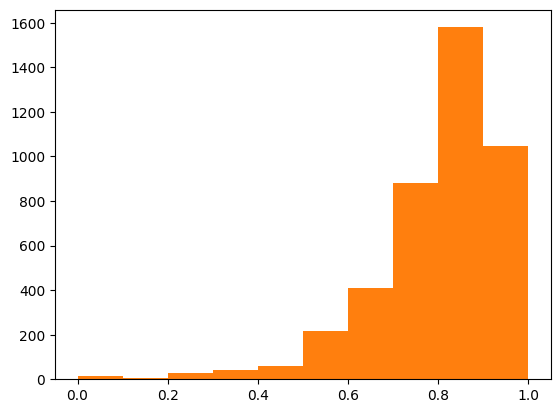

In [695]:
import matplotlib.pyplot as plt
plt.hist(sorted(all_recalls))
plt.show()

In [600]:
def find_seqs_updated_negative(test_genomes, algorithm="GMS"):
    all_results = []
    all_groundtruths = []
    
    for genome in test_genomes: 
        if algorithm == 'GMS':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/gms2/gms2.gff'
            
        elif algorithm == 'prodigal':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/prodigal/output.gff'
            
        elif algorithm == 'FGS':
            prediction_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/' + 'fraggenescan_' + str(genome) + '.gff'
            
        training_short_groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/filtered_short.gff'
#         groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/annot.gff'
        #short groundtruths
        groundtruth = gffpd.read_gff3(training_short_groundtruth_path)
        groundtruth_df = groundtruth.df
        # short_groundtruth_df = groundtruth_df[groundtruth_df['end'] - groundtruth_df['start'] < 180]
        short_groundtruth_df = groundtruth_df
        positive_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '+']
        negative_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '-']
        
        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()
        
        #short genes

        gene_ids, sequences = read_fasta('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data', genome, 'short.fasta')
        
        training_sequences = positive_filtered_genes[genome]
        seqs_indices = find_indices(training_sequences, sequences)
        training_gene_ids = [gene_ids[i] for i in seqs_indices]

        positive_training_indices = []
        negative_training_indices = []
        for i in range(positive_strand_short_groundtruth.shape[0]):
            if positive_strand_short_groundtruth.iloc[i]['attributes'].split(';')[0][7:] in training_gene_ids:
                positive_training_indices.append(i)

        for i in range(negative_strand_short_groundtruth.shape[0]):
            if negative_strand_short_groundtruth.iloc[i]['attributes'].split(';')[0][7:] in training_gene_ids:
                negative_training_indices.append(i)
    
        positive_strand_short_groundtruth = positive_strand_short_groundtruth.iloc[positive_training_indices]
        negative_strand_short_groundtruth = negative_strand_short_groundtruth.iloc[negative_training_indices]

        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()
        
#         print(len(positive_short_groundtruth))
#         print(len(negative_short_groundtruth))

        prediction = gffpd.read_gff3(prediction_path)
        results = list(prediction.df['seq_id'])
        prediction_df = prediction.df
        short_prediction_df = prediction_df[prediction_df['end'] - prediction_df['start'] < 180]
        positive_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '+']
        negative_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '-']

        positive_short_prediction = positive_strand_short_prediction_df[['start', 'end']].values.tolist()
        negative_short_prediction = negative_strand_short_prediction_df[['start', 'end']].values.tolist()
    
        #repeat the exact same thing for noncoding regions
        non_gene_ids, non_coding_sequences = read_fasta('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data', genome, 'noncod_short.fasta')
        training_noncod_sequences = negative_filtered_genes[genome]
        noncoding_seqs_indices = find_indices(training_noncod_sequences, non_coding_sequences)
        
#         training_non_coding_ids = [non_gene_ids[i] for i in noncoding_seqs_indices]
        positive_strand_noncoding_groundtruth, negative_strand_noncoding_groundtruth = read_noncod_fasta('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data', genome, 'noncod_short.fasta', noncoding_seqs_indices)
        assert len(positive_strand_noncoding_groundtruth) + len(negative_strand_noncoding_groundtruth) == len(negative_filtered_genes[genome])
        

        positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = noncoding_positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_prediction)
        negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = noncoding_negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_prediction)

        total_exact_match, total_detect_5, total_detect_3, total_none, results = (negative_exact_match + positive_exact_match, 
            positive_detect_5 + negative_detect_5, 
            positive_detect_3 + negative_detect_3, 
            positive_none + negative_none, 
            positive_results + negative_results)
        
        
        
        noncoding_positive_exact_match, noncoding_positive_detect_5, noncoding_positive_detect_3, noncoding_positive_none, noncoding_positive_results = noncoding_positive_strand_inference_evaluate(positive_strand_noncoding_groundtruth, positive_short_prediction)
        noncoding_negative_exact_match, noncoding_negative_detect_5, noncoding_negative_detect_3, noncoding_negative_none, noncoding_negative_results = noncoding_negative_strand_inference_evaluate(negative_strand_noncoding_groundtruth, negative_short_prediction)

        noncoding_total_exact_match, noncoding_total_detect_5, noncoding_total_detect_3, noncoding_total_none, noncoding_results = (noncoding_negative_exact_match + noncoding_positive_exact_match, 
            noncoding_positive_detect_5 + noncoding_negative_detect_5, 
            noncoding_positive_detect_3 + noncoding_negative_detect_3, 
            noncoding_positive_none + noncoding_negative_none, 
            noncoding_positive_results + noncoding_negative_results)
        
        training_noncoding_sequences = negative_filtered_genes[genome]
        final_groundtruth = len(results) * [1] + len(negative_filtered_genes[genome]) * [0]
        results = results + noncoding_results
        all_results.extend(results)
        all_groundtruths.extend(final_groundtruth)
    assert len(all_results) == len(all_groundtruths), 'array size dont match up!'
    return all_results, all_groundtruths

In [438]:
difference_num = 0
for genome in list(train_genomes) + list(test_genomes):
    if not find_seqs([genome]) == find_seqs_updated_negative([genome]):
        difference_num += 1

In [598]:
find_seqs([test_genomes[1]])

([1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])

In [599]:
for genome in test_genomes:
    print(find_seqs([genome]) == find_seqs_updated_negative([genome]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


KeyboardInterrupt: 

In [118]:
def read_fasta(dir_name, genome_name, file_name):
    #'sampled_genomes_resampled/'
    f=open(str(dir_name) + '/' + str(genome_name) + '/' + file_name,'r')
    lines=f.readlines()

    hre=re.compile('>(\S+)')
    lre=re.compile('^(\S+)$')

    gene={}

    for line in lines:
            outh = hre.search(line)
            if outh:
                    id=outh.group(1)
            else:
                    outl=lre.search(line)
                    if(id in gene.keys()):
                            gene[id] += outl.group(1)
                    else:
                            gene[id]  =outl.group(1)
    return list(gene.keys()), list(gene.values())

def find_indices(a, b):
    """
    Returns a list of indices that corresponds to the index of every element of a in b.
    """
    indices = []
    for element in a:
        if element in b:
            index = b.index(element)
            indices.append(index)
    return indices

def find_seqs(test_genomes, algorithm="GMS"):
    all_results = []
    all_groundtruths = []
    
    for genome in test_genomes: 
        if algorithm == 'GMS':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/gms2/gms2.gff'
            
        elif algorithm == 'prodigal':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/prodigal/output.gff'
            
        elif algorithm == 'FGS':
            prediction_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/' + 'fraggenescan_' + str(genome) + '.gff'
            
        training_short_groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/filtered_short.gff'
#         groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/annot.gff'
        #short groundtruths
        groundtruth = gffpd.read_gff3(training_short_groundtruth_path)
        groundtruth_df = groundtruth.df
        # short_groundtruth_df = groundtruth_df[groundtruth_df['end'] - groundtruth_df['start'] < 180]
        short_groundtruth_df = groundtruth_df
        positive_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '+']
        negative_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '-']
        
        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()
        
        gene_ids, sequences = read_fasta('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data', genome, 'short.fasta')
        
        training_sequences = positive_filtered_genes[genome]
        seqs_indices = find_indices(training_sequences, sequences)
        training_gene_ids = [gene_ids[i] for i in seqs_indices]

        positive_training_indices = []
        negative_training_indices = []
        for i in range(positive_strand_short_groundtruth.shape[0]):
            if positive_strand_short_groundtruth.iloc[i]['attributes'].split(';')[0][7:] in training_gene_ids:
                positive_training_indices.append(i)

        for i in range(negative_strand_short_groundtruth.shape[0]):
            if negative_strand_short_groundtruth.iloc[i]['attributes'].split(';')[0][7:] in training_gene_ids:
                negative_training_indices.append(i)

        positive_strand_short_groundtruth = positive_strand_short_groundtruth.iloc[positive_training_indices]
        negative_strand_short_groundtruth = negative_strand_short_groundtruth.iloc[negative_training_indices]

        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()

        prediction = gffpd.read_gff3(prediction_path)
        results = list(prediction.df['seq_id'])
        prediction_df = prediction.df
        short_prediction_df = prediction_df[prediction_df['end'] - prediction_df['start'] < 180]
        positive_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '+']
        negative_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '-']

        positive_short_prediction = positive_strand_short_prediction_df[['start', 'end']].values.tolist()
        negative_short_prediction = negative_strand_short_prediction_df[['start', 'end']].values.tolist()

        positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_prediction)
        negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_prediction)

        total_exact_match, total_detect_5, total_detect_3, total_none, results = (negative_exact_match + positive_exact_match, 
            positive_detect_5 + negative_detect_5, 
            positive_detect_3 + negative_detect_3, 
            positive_none + negative_none, 
            positive_results + negative_results)
        
        training_noncoding_sequences = negative_filtered_genes[genome]
        final_groundtruth = len(results) * [1] + len(negative_filtered_genes[genome]) * [0]
        results = results + len(negative_filtered_genes[genome]) * [0]
        all_results.extend(results)
        all_groundtruths.extend(final_groundtruth)
    assert len(all_results) == len(all_groundtruths), 'array size dont match up!'
    return all_results, all_groundtruths
        
# genemark_results, groundtruth_results = find_seqs(['GCF_001880225.1_ASM188022v1'])      


## Genemark 10 fold cross validation

In [79]:
for i in range(10):
    train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, i)
    print(train_x.shape)
    print(test_x.shape)

(245544, 1280)
(26359, 1280)
(243767, 1280)
(28136, 1280)
(241748, 1280)
(30155, 1280)
(244110, 1280)
(27793, 1280)
(245386, 1280)
(26517, 1280)
(244359, 1280)
(27544, 1280)
(246605, 1280)
(25298, 1280)
(244532, 1280)
(27371, 1280)
(245299, 1280)
(26604, 1280)
(245777, 1280)
(26126, 1280)


In [431]:
genemark_accuracies, genemark_precisions, genemark_recalls, genemark_F1s = [], [], [], []
for i in range(10):
    print("fold " + str(i))
    # PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_models_with_42_held_out/six_layer_4246_genomes.pt"
    train_genomes, test_genomes = find_train_val_genome_indices(i)
    train_x, train_y, test_x, test_y = create_train_test_data(all_data_folds_embs, all_data_folds_labels, i)
    genemark_results, groundtruth_results = find_seqs_updated_negative(test_genomes, 'GMS')
    assert(test_x.shape[0] == len(groundtruth_results))
    print("number of test genomes: " + str(len(groundtruth_results)))
    genemark_accuracy, genemark_precision, genemark_recall, genemark_f1 = perf_measure(list(groundtruth_results), list(genemark_results))
    genemark_accuracies.append(genemark_accuracy)
    genemark_precisions.append(genemark_precision)
    genemark_recalls.append(genemark_recall)
    genemark_F1s.append(genemark_f1)
    print('\n')
    

fold 0
number of test genomes: 26359
total samples: 26359
TP: 9910
FP: 0
TN: 13973
FN: 2476
accuracy: 0.9060662392351758
precision: 1.0
recall: 0.8000968835782335
F1: 0.8889486903480445


fold 1
number of test genomes: 28136
total samples: 28136
TP: 10566
FP: 0
TN: 14876
FN: 2694
accuracy: 0.9042507819164061
precision: 1.0
recall: 0.7968325791855203
F1: 0.8869302442709646


fold 2
number of test genomes: 30155
total samples: 30155
TP: 11259
FP: 0
TN: 15827
FN: 3069
accuracy: 0.8982258331951584
precision: 1.0
recall: 0.7858040201005025
F1: 0.8800562785789658


fold 3
number of test genomes: 27793
total samples: 27793
TP: 10710
FP: 0
TN: 14584
FN: 2499
accuracy: 0.9100852732702479
precision: 1.0
recall: 0.8108108108108109
F1: 0.8955223880597014


fold 4
number of test genomes: 26517
total samples: 26517
TP: 10177
FP: 0
TN: 13877
FN: 2463
accuracy: 0.9071161896142097
precision: 1.0
recall: 0.8051424050632912
F1: 0.8920541701363018


fold 5
number of test genomes: 27544
total samples: 2754

In [455]:
print(np.mean(genemark_accuracies), np.std(genemark_accuracies))
print(np.mean(genemark_precisions), np.std(genemark_precisions))
print(np.mean(genemark_recalls), np.std(genemark_recalls))
print(np.mean(genemark_F1s), np.std(genemark_F1s))

0.9097165474654444 0.005905607936273552
1.0 0.0
0.8090887394664252 0.012099700790742136
0.8944214671674902 0.0074114571633811166


In [573]:
#get rid of the first one for now, for both
three_best_genomes = ['GCF_002761235.1_ASM276123v1', 'GCF_900660515.1_50766_E01-3']
three_worst_genomes = ['GCF_008245065.1_ASM824506v1', 'GCF_000215975.1_ASM21597v1']


## prodigal 10 fold cross validation

In [465]:
prodigal_accuracies, prodigal_precisions, prodigal_recalls, prodigal_F1s = [], [], [], []
for i in range(10):
    print("fold " + str(i))
    # PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_models_with_42_held_out/six_layer_4246_genomes.pt"
    train_genomes, test_genomes = find_train_val_genome_indices(i)
    prodigal_results, groundtruth_results = find_seqs_updated_negative(test_genomes, 'prodigal')
    prodigal_accuracy, prodigal_precision, prodigal_recall, prodigal_f1 = perf_measure(list(groundtruth_results), list(prodigal_results))
    prodigal_accuracies.append(prodigal_accuracy)
    prodigal_precisions.append(prodigal_precision)
    prodigal_recalls.append(prodigal_recall)
    prodigal_F1s.append(prodigal_f1)
    print('\n')
    

fold 0
total samples: 26359
TP: 9477
FP: 3
TN: 13970
FN: 2909
accuracy: 0.8895253992943587
precision: 0.9996835443037975
recall: 0.7651380590989827
F1: 0.8668252080856124


fold 1
total samples: 28136
TP: 10056
FP: 0
TN: 14876
FN: 3204
accuracy: 0.8861245379584873
precision: 1.0
recall: 0.7583710407239819
F1: 0.8625836335563561


fold 2
total samples: 30155
TP: 10824
FP: 2
TN: 15825
FN: 3504
accuracy: 0.8837340407892555
precision: 0.9998152595603178
recall: 0.7554438860971524
F1: 0.8606185894887494


fold 3
total samples: 27793
TP: 10295
FP: 2
TN: 14582
FN: 2914
accuracy: 0.8950814953405534
precision: 0.9998057686704865
recall: 0.7793928382163676
F1: 0.8759465668339999


fold 4
total samples: 26517
TP: 9684
FP: 3
TN: 13874
FN: 2956
accuracy: 0.8884112079043632
precision: 0.9996903065964695
recall: 0.7661392405063291
F1: 0.8674698795180723


fold 5
total samples: 27544
TP: 10096
FP: 1
TN: 14608
FN: 2839
accuracy: 0.8968922451350566
precision: 0.9999009606813906
recall: 0.780517974487823

In [466]:
print(np.mean(prodigal_accuracies), np.std(prodigal_accuracies))
print(np.mean(prodigal_precisions), np.std(prodigal_precisions))
print(np.mean(prodigal_recalls), np.std(prodigal_recalls))
print(np.mean(prodigal_F1s), np.std(prodigal_F1s))



0.8923667325641331 0.0054517318985700955
0.9998588145360259 0.00011409212921953041
0.772495185769595 0.011169747395698287
0.8715489971985055 0.007129949891503465


## FragGeneScan 10-fold cross validation:


In [471]:
FGS_accuracies, FGS_precisions, FGS_recalls, FGS_F1s = [], [], [], []
for i in range(10):
    print("fold " + str(i))
    # PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_models_with_42_held_out/six_layer_4246_genomes.pt"
    train_genomes, test_genomes = find_train_val_genome_indices(i)
    FGS_results, groundtruth_results = find_seqs_updated_negative(test_genomes, 'FGS')
    FGS_accuracy, FGS_precision, FGS_recall, FGS_f1 = perf_measure(list(groundtruth_results), list(FGS_results))
    FGS_accuracies.append(FGS_accuracy)
    FGS_precisions.append(FGS_precision)
    FGS_recalls.append(FGS_recall)
    FGS_F1s.append(FGS_f1)
    print('\n')
    

fold 0
total samples: 26359
TP: 6803
FP: 0
TN: 13973
FN: 5583
accuracy: 0.7881937858037104
precision: 1.0
recall: 0.5492491522686904
F1: 0.7090520610766585


fold 1
total samples: 28136
TP: 7245
FP: 0
TN: 14876
FN: 6015
accuracy: 0.7862169462610179
precision: 1.0
recall: 0.5463800904977375
F1: 0.7066569129480614


fold 2
total samples: 30155
TP: 7696
FP: 0
TN: 15827
FN: 6632
accuracy: 0.7800696401923396
precision: 1.0
recall: 0.5371300949190396
F1: 0.6988739556847076


fold 3
total samples: 27793
TP: 7225
FP: 0
TN: 14584
FN: 5984
accuracy: 0.7846939876947433
precision: 1.0
recall: 0.546975546975547
F1: 0.7071547420965059


fold 4
total samples: 26517
TP: 6985
FP: 0
TN: 13877
FN: 5655
accuracy: 0.7867405815137459
precision: 1.0
recall: 0.5526107594936709
F1: 0.7118471337579618


fold 5
total samples: 27544
TP: 7440
FP: 0
TN: 14609
FN: 5495
accuracy: 0.8005010165553297
precision: 1.0
recall: 0.5751836103594897
F1: 0.7303067484662576


fold 6
total samples: 25298
TP: 6750
FP: 0
TN: 13333


In [472]:
print(np.mean(FGS_accuracies), np.std(FGS_accuracies))
print(np.mean(FGS_precisions), np.std(FGS_precisions))
print(np.mean(FGS_recalls), np.std(FGS_recalls))
print(np.mean(FGS_F1s), np.std(FGS_F1s))



0.7897969641441805 0.005968341364706022
1.0 0.0
0.5554834241490606 0.011400486339689767
0.7141571563680573 0.00940591494132429


In [37]:
genemark_results, groundtruth_results = find_seqs(test_genomes, 'GMS')
# genemark_accuracies.append(genemark_accuracy)
# genemark_precisions.append(genemark_precision)
# genemark_recalls.append(genemark_recall)
# genemark_F1s.append(genemark_f1)
# print('\n')

In [ ]:
print("number of test genomes: " + str(len(groundtruth_results)))
genemark_accuracy, genemark_precision, genemark_recall, genemark_f1 = perf_measure(list(groundtruth_results), list(genemark_results))

In [ ]:
print("number of test genomes: " + str(len(groundtruth_results)))
genemark_accuracy, genemark_precision, genemark_recall, genemark_f1 = perf_measure(list(groundtruth_results), list(genemark_results))

In [80]:
def find_seqs(test_genomes, algorithm="GMS"):
    all_results = []
    all_groundtruths = []
    
    for genome in test_genomes: 
        if algorithm == 'GMS':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/gms2/gms2.gff'
            
        elif algorithm == 'prodigal':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/prodigal/output.gff'
            
        elif algorithm == 'FGS':
            prediction_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/' + 'fraggenescan_' + str(genome) + '.gff'
            
        training_short_groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/filtered_short.gff'
#         groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/annot.gff'
        #short groundtruths
        groundtruth = gffpd.read_gff3(training_short_groundtruth_path)
        groundtruth_df = groundtruth.df
        # short_groundtruth_df = groundtruth_df[groundtruth_df['end'] - groundtruth_df['start'] < 180]
        short_groundtruth_df = groundtruth_df
        positive_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '+']
        negative_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '-']
        
        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()
        
        gene_ids, sequences = read_fasta('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data', genome, 'short.fasta')
        
        training_sequences = positive_filtered_genes[genome]
        seqs_indices = find_indices(training_sequences, sequences)
        training_gene_ids = [gene_ids[i] for i in seqs_indices]

        positive_training_indices = []
        negative_training_indices = []
        for i in range(positive_strand_short_groundtruth.shape[0]):
            if positive_strand_short_groundtruth.iloc[i]['attributes'].split(';')[0][7:] in training_gene_ids:
                positive_training_indices.append(i)

        for i in range(negative_strand_short_groundtruth.shape[0]):
            if negative_strand_short_groundtruth.iloc[i]['attributes'].split(';')[0][7:] in training_gene_ids:
                negative_training_indices.append(i)

        positive_strand_short_groundtruth = positive_strand_short_groundtruth.iloc[positive_training_indices]
        negative_strand_short_groundtruth = negative_strand_short_groundtruth.iloc[negative_training_indices]

        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()

        prediction = gffpd.read_gff3(prediction_path)
        results = list(prediction.df['seq_id'])
        prediction_df = prediction.df
        short_prediction_df = prediction_df[prediction_df['end'] - prediction_df['start'] < 180]
        positive_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '+']
        negative_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '-']

        positive_short_prediction = positive_strand_short_prediction_df[['start', 'end']].values.tolist()
        negative_short_prediction = negative_strand_short_prediction_df[['start', 'end']].values.tolist()

        positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_prediction)
        negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_prediction)

        total_exact_match, total_detect_5, total_detect_3, total_none, results = (negative_exact_match + positive_exact_match, 
            positive_detect_5 + negative_detect_5, 
            positive_detect_3 + negative_detect_3, 
            positive_none + negative_none, 
            positive_results + negative_results)
        
        training_noncoding_sequences = negative_filtered_genes[genome]
        final_groundtruth = len(results) * [1] + len(negative_filtered_genes[genome]) * [0]
        results = results + len(negative_filtered_genes[genome]) * [0]
        all_results.extend(results)
        all_groundtruths.extend(final_groundtruth)
    assert len(all_results) == len(all_groundtruths), 'array size dont match up!'
    return all_results, all_groundtruths

## evaluating long gene vs. short gene results

In [82]:
# sanity check:

genome = 'GCF_000018105.1_ASM1810v1'
prediction_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/' + 'fraggenescan_' + str(genome) + '.gff'
groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/coding_region'
short_training_groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/filtered_short.gff'

groundtruth = gffpd.read_gff3(groundtruth_path)
groundtruth_df = groundtruth.df
short_groundtruth_df = groundtruth_df[groundtruth_df['end'] - groundtruth_df['start'] < 180]
long_groundtruth_df = groundtruth_df[groundtruth_df['end'] - groundtruth_df['start'] >= 180]
# short_groundtruth_df = groundtruth_df

positive_strand_long_groundtruth = long_groundtruth_df[long_groundtruth_df['strand'] == '+']
negative_strand_long_groundtruth = long_groundtruth_df[long_groundtruth_df['strand'] == '-']

positive_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '+']
negative_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '-']

# short_training_groundtruth = gffpd.read_gff3(short_training_groundtruth_path)
# short_training_groundtruth_df = short_training_groundtruth.df
# # short_groundtruth_df = groundtruth_df[groundtruth_df['end'] - groundtruth_df['start'] < 180]
# positive_strand_short_training_groundtruth = short_training_groundtruth_df[short_training_groundtruth_df['strand'] == '+']
# negative_strand_short_training_groundtruth = short_training_groundtruth_df[short_training_groundtruth_df['strand'] == '-']

# print(short_groundtruth_df.shape)
# print(short_training_groundtruth_df.shape)


In [512]:
def find_seqs_long_short(test_genomes, algorithm="GMS"):
    all_short_PGP_precision = []
    all_short_GP_precision = []
    all_long_PGP_precision = []
    all_long_GP_precision = []
    
    for genome in test_genomes: 
        if algorithm == 'GMS':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/gms2/gms2.gff'
            
        elif algorithm == 'prodigal':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/prodigal/output.gff'
            
        elif algorithm == 'FGS':
            prediction_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/' + 'fraggenescan_' + str(genome) + '.gff'
            
        #short groundtruths
        groundtruth_path = '/Users/tonytu/Desktop/data/' + genome + '/coding_region'
        groundtruth = gffpd.read_gff3(groundtruth_path)
        groundtruth_df = groundtruth.df
        short_groundtruth_df = groundtruth_df[groundtruth_df['end'] - groundtruth_df['start'] < 180]
        long_groundtruth_df = groundtruth_df[groundtruth_df['end'] - groundtruth_df['start'] >= 180]
        # short_groundtruth_df = groundtruth_df

        positive_strand_long_groundtruth = long_groundtruth_df[long_groundtruth_df['strand'] == '+']
        negative_strand_long_groundtruth = long_groundtruth_df[long_groundtruth_df['strand'] == '-']

        positive_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '+']
        negative_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '-']
        
        positive_long_groundtruth = positive_strand_long_groundtruth[['start', 'end']].values.tolist()
        negative_long_groundtruth = negative_strand_long_groundtruth[['start', 'end']].values.tolist()
        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()
      
        
        prediction = gffpd.read_gff3(prediction_path)
        results = list(prediction.df['seq_id'])
        prediction_df = prediction.df
#         short_prediction_df = prediction_df[prediction_df['end'] - prediction_df['start'] < 180]
        short_prediction_df = prediction_df
        positive_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '+']
        negative_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '-']

        positive_short_prediction = positive_strand_short_prediction_df[['start', 'end']].values.tolist()
        negative_short_prediction = negative_strand_short_prediction_df[['start', 'end']].values.tolist()

        short_positive_exact_match, short_positive_detect_5, short_positive_detect_3, short_positive_none, short_positive_results = positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_prediction)
        short_negative_exact_match, short_negative_detect_5, short_negative_detect_3, short_negative_none, short_negative_results = negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_prediction)

        long_positive_exact_match, long_positive_detect_5, long_positive_detect_3, long_positive_none, long_positive_results = positive_strand_inference_evaluate(positive_long_groundtruth, positive_short_prediction)
        long_negative_exact_match, long_negative_detect_5, long_negative_detect_3, long_negative_none, long_negative_results = negative_strand_inference_evaluate(negative_long_groundtruth, negative_short_prediction)
        
        short_total_exact_match, short_total_detect_5, short_total_detect_3, short_total_none, short_results = (short_negative_exact_match + short_positive_exact_match, 
            short_positive_detect_5 + short_negative_detect_5, 
            short_positive_detect_3 + short_negative_detect_3, 
            short_positive_none + short_negative_none, 
            short_positive_results + short_negative_results)
        
        long_total_exact_match, long_total_detect_5, long_total_detect_3, long_total_none, long_results = (long_negative_exact_match + long_positive_exact_match, 
            long_positive_detect_5 + long_negative_detect_5, 
            long_positive_detect_3 + long_negative_detect_3, 
            long_positive_none + long_negative_none, 
            long_positive_results + long_negative_results)
        
        all_long_PGP_precision.append(long_total_exact_match / long_groundtruth_df.shape[0])
        all_long_GP_precision.append((long_total_detect_3 + long_total_exact_match) / long_groundtruth_df.shape[0])
        all_short_PGP_precision.append(short_total_exact_match / short_groundtruth_df.shape[0])
        all_short_GP_precision.append((short_total_detect_3 + short_total_exact_match) / short_groundtruth_df.shape[0])
        
        
#         print("long precise gene prediction: " + str(long_total_exact_match / long_groundtruth_df.shape[0]))
#         print("long gene prediction: " + str((long_total_detect_3 + long_total_exact_match) / long_groundtruth_df.shape[0]))
#         print("short precise gene prediction: " + str(short_total_exact_match / short_groundtruth_df.shape[0]))
#         print("short gene prediction: " + str((short_total_detect_3 + short_total_exact_match) / short_groundtruth_df.shape[0]))

#         final_groundtruth = len(results) * [1] + len(negative_filtered_genes[genome]) * [0]
#         results = results + len(negative_filtered_genes[genome]) * [0]
#         all_results.extend(results)
#         all_groundtruths.extend(final_groundtruth)
    return all_short_PGP_precision, all_short_GP_precision, all_long_PGP_precision, all_long_GP_precision


In [513]:
all_short_PGP_precision, all_short_GP_precision, all_long_PGP_precision, all_long_GP_precision = find_seqs_long_short(list(train_genomes) + list(test_genomes))


KeyboardInterrupt: 

In [116]:
print(np.mean(all_short_PGP_precision), np.std(all_short_PGP_precision))
print(np.mean(all_short_GP_precision), np.std(all_short_GP_precision))
print(np.mean(all_long_PGP_precision), np.std(all_long_PGP_precision))
print(np.mean(all_long_GP_precision), np.std(all_long_GP_precision))



0.7226454299674103 0.1285526343693717
0.7689161407502497 0.12293689306139538
0.885692666072097 0.1209033631263217
0.9668477268668291 0.10466495259609086


In [117]:
prodigal_all_short_PGP_precision, prodigal_all_short_GP_precision, prodigal_all_long_PGP_precision, prodigal_all_long_GP_precision = find_seqs_long_short(train_genomes + test_genomes, 'prodigal')


In [118]:
print(np.mean(prodigal_all_short_PGP_precision), np.std(prodigal_all_short_PGP_precision))
print(np.mean(prodigal_all_short_GP_precision), np.std(prodigal_all_short_GP_precision))
print(np.mean(prodigal_all_long_PGP_precision), np.std(prodigal_all_long_PGP_precision))
print(np.mean(prodigal_all_long_GP_precision), np.std(prodigal_all_long_GP_precision))



0.5653018385348682 0.12802466609103155
0.6480810862912785 0.12826746915621348
0.840218097441051 0.11898427344677436
0.9604275390186052 0.10619908944023058


In [119]:
FGS_all_short_PGP_precision, FGS_all_short_GP_precision, FGS_all_long_PGP_precision, FGS_all_long_GP_precision = find_seqs_long_short(train_genomes + test_genomes, 'FGS')


In [121]:
print(np.mean(FGS_all_short_PGP_precision), np.std(FGS_all_short_PGP_precision))
print(np.mean(FGS_all_short_GP_precision), np.std(FGS_all_short_GP_precision))
print(np.mean(FGS_all_long_PGP_precision), np.std(FGS_all_long_PGP_precision))
print(np.mean(FGS_all_long_GP_precision), np.std(FGS_all_long_GP_precision))



0.4526038380672929 0.11061442239039156
0.5804740090178342 0.11986407849643772
0.741373090758378 0.12196446895451739
0.932536908211813 0.11811922804728307


# adding another section on genemark evaluation with noncoding overlaps

In [ ]:
def find_seqs(test_genomes, algorithm="GMS"):
    all_results = []
    all_groundtruths = []
    
    for genome in test_genomes: 
        if algorithm == 'GMS':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/gms2/gms2.gff'
            
        elif algorithm == 'prodigal':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/prodigal/output.gff'
            
        elif algorithm == 'FGS':
            prediction_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/' + 'fraggenescan_' + str(genome) + '.gff'
            
        training_short_groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/filtered_short.gff'
#         groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/annot.gff'
        #short groundtruths
        groundtruth = gffpd.read_gff3(training_short_groundtruth_path)
        groundtruth_df = groundtruth.df
        # short_groundtruth_df = groundtruth_df[groundtruth_df['end'] - groundtruth_df['start'] < 180]
        short_groundtruth_df = groundtruth_df
        positive_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '+']
        negative_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '-']
        
        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()
        
        gene_ids, sequences = read_fasta('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data', genome, 'short.fasta')
        
        training_sequences = positive_filtered_genes[genome]
        seqs_indices = find_indices(training_sequences, sequences)
        training_gene_ids = [gene_ids[i] for i in seqs_indices]

        positive_training_indices = []
        negative_training_indices = []
        for i in range(positive_strand_short_groundtruth.shape[0]):
            if positive_strand_short_groundtruth.iloc[i]['attributes'].split(';')[0][7:] in training_gene_ids:
                positive_training_indices.append(i)

        for i in range(negative_strand_short_groundtruth.shape[0]):
            if negative_strand_short_groundtruth.iloc[i]['attributes'].split(';')[0][7:] in training_gene_ids:
                negative_training_indices.append(i)

        positive_strand_short_groundtruth = positive_strand_short_groundtruth.iloc[positive_training_indices]
        negative_strand_short_groundtruth = negative_strand_short_groundtruth.iloc[negative_training_indices]

        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()

        prediction = gffpd.read_gff3(prediction_path)
        results = list(prediction.df['seq_id'])
        prediction_df = prediction.df
        short_prediction_df = prediction_df[prediction_df['end'] - prediction_df['start'] < 180]
        positive_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '+']
        negative_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '-']

        positive_short_prediction = positive_strand_short_prediction_df[['start', 'end']].values.tolist()
        negative_short_prediction = negative_strand_short_prediction_df[['start', 'end']].values.tolist()

        positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_prediction)
        negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_prediction)

        total_exact_match, total_detect_5, total_detect_3, total_none, results = (negative_exact_match + positive_exact_match, 
            positive_detect_5 + negative_detect_5, 
            positive_detect_3 + negative_detect_3, 
            positive_none + negative_none, 
            positive_results + negative_results)
        
        training_noncoding_sequences = negative_filtered_genes[genome]
        final_groundtruth = len(results) * [1] + len(negative_filtered_genes[genome]) * [0]
        results = results + len(negative_filtered_genes[genome]) * [0]
        all_results.extend(results)
        all_groundtruths.extend(final_groundtruth)
    assert len(all_results) == len(all_groundtruths), 'array size dont match up!'
    return all_results, all_groundtruths
        

In [843]:
print(2 * 0.772 * 0.661 / (0.772 + 0.587))
print(2 * 0.446 * 1 / (1 + 0.446))


0.6997136958017894
0.6168741355463347


In [253]:
len([elem for elem in coding_lengths if elem == 29])

1642

In [251]:
coding_lengths = []
noncoding_lengths = []
for genome in train_genomes + test_genomes:
    cod_ids, cod_seqs = read_fasta('post_processed_data', genome, 'short.fasta')
#     noncod_ids, noncod_seqs = read_fasta('post_processed_data/', genome, 'noncod_short.fasta') 
    coding_lengths.extend([len(x) for x in cod_seqs])
#     noncoding_lengths.append(len(noncod_seqs))

In [662]:
all_coding_seqs = []
all_noncoding_seqs = []
for genome in list(train_genomes) + list(test_genomes):
    cod_ids, cod_seqs = read_fasta('post_processed_data', genome, 'short.fasta')
    noncod_ids, noncod_seqs = read_fasta('post_processed_data/', genome, 'noncod_short.fasta') 
    all_coding_seqs.extend(cod_seqs)
    all_noncoding_seqs.extend(noncod_seqs)

In [670]:
x = [len(elem) for elem in all_coding_seqs if len(elem) <= 59 and len(elem) >= 29]
y = [len(elem) for elem in all_noncoding_seqs if len(elem) <= 59 and len(elem) >= 29]

In [684]:
max(noncoding_lengths)

6227

In [658]:
coding_lengths = []
noncoding_lengths = []
for genome in list(train_genomes) + list(test_genomes):
    cod_ids, cod_seqs = read_fasta('post_processed_data', genome, 'short.fasta')
    noncod_ids, noncod_seqs = read_fasta('post_processed_data/', genome, 'noncod_short.fasta') 
    coding_lengths.append(len(cod_seqs))
    noncoding_lengths.append(len(noncod_seqs))

In [685]:
def calculate_skewness(data):
    n = len(data)
    mean = sum(data) / n
    variance = sum((x - mean) ** 2 for x in data) / (n - 1)
    std_deviation = math.sqrt(variance)
    skewness = (sum((x - mean) ** 3 for x in data) / (n * std_deviation ** 3))
    return skewness

In [689]:
data_list = coding_lengths
skewness_value = calculate_skewness(data_list)
print("Skewness:", skewness_value)

Skewness: 2.7888399141365436


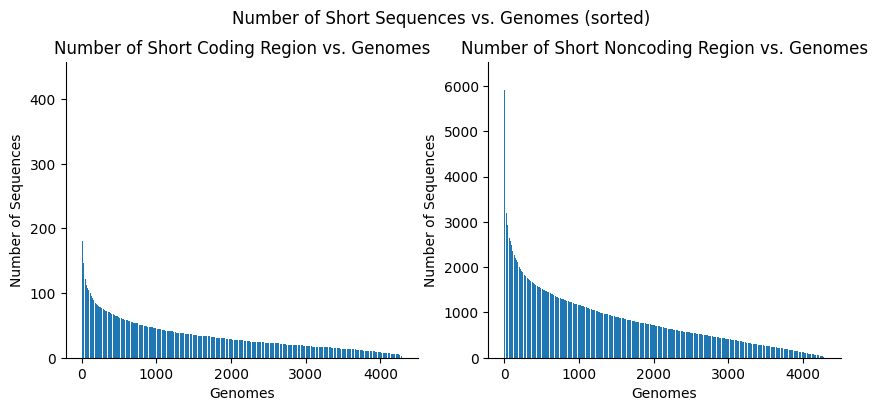

In [707]:
import matplotlib.pyplot as plt

x1 = np.arange(0, 4288, 1)
y1 = sorted(coding_lengths, reverse=True)

x2 = np.arange(0, 4288, 1)
y2 = sorted(noncoding_lengths, reverse=True)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first histogram
ax1.bar(x1, y1)
ax1.set_xlabel('Genomes')
ax1.set_ylabel('Number of Sequences')
ax1.set_title('Number of Short Coding Region vs. Genomes')

# Plot the second histogram
ax2.bar(x2, y2)
ax2.set_xlabel('Genomes')
ax2.set_ylabel('Number of Sequences')
ax2.set_title('Number of Short Noncoding Region vs. Genomes')

# Adjust the spacing between the subplots
plt.suptitle('Number of Short Sequences vs. Genomes (sorted)')
plt.subplots_adjust(top=0.85)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
# Display the plot
plt.savefig('appendix_seq_length_dist.jpg', dpi=500)
plt.show()


In [703]:
pwd

'/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab'

In [137]:
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# fig.suptitle('Coding regions vs. sampled noncoding regions lengths distribution')
# axes[0].set_title('Coding regions')
# axes[1].set_title('Sampled noncoding regions')

# axes[0].set_xlabel('Sequence length')
# axes[0].set_ylabel('Count')

# axes[1].set_xlabel('Sequence length')
# axes[1].set_ylabel('Count')
# # plt.xlabel('Count')
# # plt.ylabel('Protein sequence length')

# pd.Series(a).hist(bins=15, ax=axes[0])
# pd.Series(b).hist(bins=15, ax=axes[1])
# plt.show()

# fig.savefig('length_distribution.jpg')

In [260]:
all_coding_lengths = []
all_noncoding_lengths = []
for genome in train_genomes + test_genomes:
    cod_ids, cod_seqs = read_fasta('post_processed_data', genome, 'short.fasta')
    noncod_ids, noncod_seqs = read_fasta('post_processed_data/', genome, 'noncod_short.fasta') 
    for cod_seq in cod_seqs:
        all_coding_lengths.append(len(cod_seq))
    for noncod_seq in noncod_seqs:
        all_noncoding_lengths.append(len(noncod_seq))
#     all_coding_lengths.append(len(cod_seqs))
#     all_noncoding_lengths.append(len(noncod_seqs))

In [261]:
sorted_all_coding_lengths = sorted(all_coding_lengths, reverse=True)
sorted_all_noncoding_lengths = sorted(all_noncoding_lengths, reverse=True)

In [263]:
len(sorted_all_coding_lengths)

145332

In [229]:
# import matplotlib.pyplot as plt

# x1 = np.arange(0, len(sorted_all_coding_lengths), 1)
# y1 = sorted_all_coding_lengths

# x2 = np.arange(0, len(sorted_all_noncoding_lengths), 1)
# y2 = sorted_all_noncoding_lengths

# # Create a figure with two subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# # Plot the first histogram
# ax1.bar(x1, y1)
# ax1.set_xlabel('Genomes')
# ax1.set_ylabel('Number of Sequences')
# ax1.set_title('Number of Coding Region vs. Genomes')

# # Plot the second histogram
# ax2.bar(x2, y2)
# ax2.set_xlabel('Genomes')
# ax2.set_ylabel('Number of Sequences')
# ax2.set_title('Number of Noncoding Region vs. Genomes')

# # Adjust the spacing between the subplots
# plt.suptitle('Number of Sequences (in Amino Acids) vs. Genomes (sorted)')
# plt.subplots_adjust(top=0.85)
# # Display the plot
# plt.show()



In [264]:
sorted_all_coding_lengths = [elem for elem in sorted_all_coding_lengths if elem < 60 and elem >= 29]
sorted_all_noncoding_lengths = [elem for elem in sorted_all_noncoding_lengths if elem < 60 and elem >= 29]

In [731]:
max(sorted_all_coding_lengths)

59

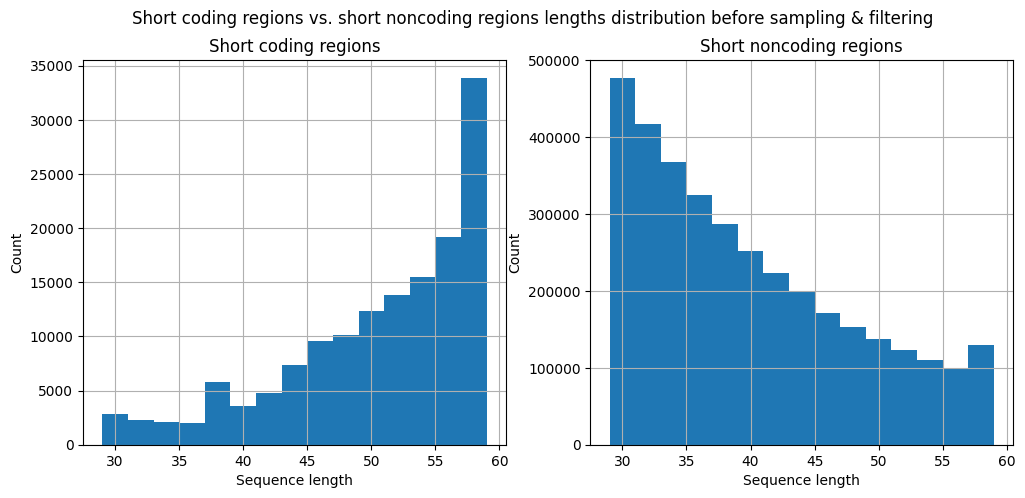

In [719]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Short coding regions vs. short noncoding regions lengths distribution before sampling & filtering')

axes[0].set_title('Short coding regions')
axes[1].set_title('Short noncoding regions')

axes[0].set_xlabel('Sequence length')
axes[0].set_ylabel('Count')

axes[1].set_xlabel('Sequence length')
axes[1].set_ylabel('Count')
# plt.xlabel('Count')
# plt.ylabel('Protein sequence length')
# axes[0].spines['top'].set_visible(False)
# axes[0].spines['right'].set_visible(False)
# axes[1].spines['top'].set_visible(False)
# axes[1].spines['right'].set_visible(False)

pd.Series(sorted_all_coding_lengths).hist(bins=15, ax=axes[0])
pd.Series(sorted_all_noncoding_lengths).hist(bins=15, ax=axes[1])
plt.savefig('appendix_seq_length_dist1.jpg', dpi=500)
plt.show()




In [496]:
# random.seed(5)
# three_random_genomes = random.sample(test_genomes, 3)
 
def create_csv(dir_name, genome, coding_seqs, sampled_noncoding_seqs):
    num_coding_seqs = len(coding_seqs)
    num_noncoding_seqs = len(sampled_noncoding_seqs)
    coding_indices = np.arange(0, num_coding_seqs, 1)
    coding_groundtruth = np.arange(0, num_coding_seqs, 1)
    coding_train = ['train'] * num_coding_seqs
    noncoding_indices = np.arange(0, num_noncoding_seqs, 1)
    noncoding_test = ['test'] * num_noncoding_seqs
    noncoding_groundtruth = np.arange(0, num_noncoding_seqs, 1)
    
    data = {'sequence': coding_seqs, 'target': coding_groundtruth, 'set': coding_train, 'validation': [np.nan] * num_coding_seqs}
    coding_df = pd.DataFrame(data, index=coding_indices)
    coding_df.to_csv('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/five_genomes_evaluation/' + genome + '/coding_train.csv')
    
    data = {'sequence': sampled_noncoding_seqs, 'target': noncoding_groundtruth, 'set': noncoding_test, 'validation': [np.nan] * num_noncoding_seqs}
    noncoding_df = pd.DataFrame(data, index=noncoding_indices)
    noncoding_df.to_csv('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/five_genomes_evaluation/' + genome + '/noncoding_test.csv')

for genome in five_genomes:
    cod_ids, cod_seqs = read_fasta('post_processed_data/', genome, 'short.fasta')
    noncod_ids, noncod_seqs = read_fasta('post_processed_data/', genome, 'noncod_short.fasta')
    create_csv('five_genomes_evaluation/', genome, cod_seqs, noncod_seqs)


In [244]:
torch.manual_seed(5)
csv_coding_genes = []
csv_noncoding_genes = []
for genome in train_genomes + test_genomes:
    # adding a length constraint
    length_upper_limit = 60
    length_lower_limit = 0
    positive_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/coding_train.csv')['sequence'])
    negative_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/noncoding_test.csv')['sequence'])
    positive_testing_sequences = [positive_testing_sequence for positive_testing_sequence in positive_testing_sequences if len(positive_testing_sequence) < 60]
    negative_testing_sequences = [negative_testing_sequence for negative_testing_sequence in negative_testing_sequences if len(negative_testing_sequence) < 60]
    csv_coding_genes.extend(positive_testing_sequences)
    csv_noncoding_genes.extend(negative_testing_sequences)
    
    

In [245]:
csv_all_coding_lengths = [len(x) for x in csv_coding_genes]
csv_all_noncoding_lengths = [len(x) for x in csv_noncoding_genes]



In [248]:
len([elem for elem in csv_all_coding_lengths if elem == 29])

1642

## full evaluation

In [ ]:
for genome in five_genomes:
    cod_ids, cod_seqs = read_fasta('post_processed_data', genome, 'short.fasta')
    noncod_ids, noncod_seqs = read_fasta('post_processed_data/', genome, 'noncod_short.fasta')
    create_csv('post_processed_data/', genome, cod_seqs, noncod_seqs)


## genemark recall vs. length

In [ ]:
#evaluating on positive strand: 
def noncoding_positive_strand_inference_evaluate(groundtruths, predictions):
    exact_matches = 0
    results = []
    groundtruth_starts = [groundtruths[i][0] for i in range(len(groundtruths))]
    groundtruth_ends = [groundtruths[i][1] for i in range(len(groundtruths))]
    
    predictions_starts = [predictions[i][0] for i in range(len(predictions))]
    predictions_ends = [predictions[i][1] for i in range(len(predictions))]
    detect_5_prime = 0
    detect_3_prime = 0
    results = []
    none = 0
    
    for i in range(len(groundtruths)):
        if groundtruths[i] in predictions:
            exact_matches+=1
            results.append(1)
            continue
        else: 
            if groundtruths[i][0] in predictions_starts and not groundtruths[i][1] in predictions_ends:
                detect_5_prime += 1
                results.append(0)
#                 print('5 prime match, 3 prime mismatch!')
                continue
            elif not groundtruths[i][0] in predictions_starts and groundtruths[i][1] in predictions_ends:
                detect_3_prime += 1
                results.append(0)
#                 print('5 prime mismatch, 3 prime match!')
                continue
            else:
                none+=1
                results.append(0)
    return exact_matches, detect_5_prime, detect_3_prime, none, results

# positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_genemark_prediction)

def noncoding_negative_strand_inference_evaluate(groundtruths, predictions):
    results = []
    exact_matches = 0
    groundtruth_starts = [groundtruths[i][0] for i in range(len(groundtruths))]
    groundtruth_ends = [groundtruths[i][1] for i in range(len(groundtruths))]
    
    predictions_starts = [predictions[i][0] for i in range(len(predictions))]
    predictions_ends = [predictions[i][1] for i in range(len(predictions))]
    detect_5_prime = 0
    detect_3_prime = 0
    results = []
    five_prime_mismatch_indices = []
    three_prime_mismatch_indices = []
    none = 0
    for i in range(len(groundtruths)):
        if groundtruths[i] in predictions:
            exact_matches+=1
            results.append(1)
            continue
        else: 
            if groundtruths[i][0] in predictions_starts and not groundtruths[i][1] in predictions_ends:
                detect_3_prime += 1
                results.append(0)
#                 print('3 prime match, 5 prime mismatch!')
            elif not groundtruths[i][0] in predictions_starts and groundtruths[i][1] in predictions_ends:
                detect_5_prime += 1
                results.append(0)
#                 print('3 prime mismatch, 5 prime match!') 
            else:
                none+=1
                results.append(0)
    return exact_matches, detect_5_prime, detect_3_prime, none, results

# negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_genemark_prediction)




In [563]:
def find_seqs_updated_negative_by_length(test_genomes, algorithm="GMS", length_upper_limit=180, length_lower_limit=0):
    all_results = []
    all_groundtruths = []
    
    for genome in test_genomes: 
        if algorithm == 'GMS':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/gms2/gms2.gff'
            
        elif algorithm == 'prodigal':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/prodigal/output.gff'
            
        elif algorithm == 'FGS':
            prediction_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/' + 'fraggenescan_' + str(genome) + '.gff'

        training_short_groundtruth_path = '/Users/tonytu/Desktop/data/' + genome + '/coding_region'
#         groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/annot.gff'
        #short groundtruths
        groundtruth = gffpd.read_gff3(training_short_groundtruth_path)
        groundtruth_df = groundtruth.df
        short_groundtruth_df = groundtruth_df[(groundtruth_df['end'] - groundtruth_df['start'] >= length_lower_limit) & (groundtruth_df['end'] - groundtruth_df['start'] < length_upper_limit)]
#         short_groundtruth_df = short_groundtruth_df[short_groundtruth_df['end'] - short_groundtruth_df['start'] < length_upper_limit]
#         short_groundtruth_df = groundtruth_df
        positive_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '+']
        negative_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '-']
        
        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()

        prediction = gffpd.read_gff3(prediction_path)
        results = list(prediction.df['seq_id'])
        prediction_df = prediction.df
#         short_prediction_df = prediction_df[prediction_df['end'] - prediction_df['start'] < 180]
        short_prediction_df = prediction_df
        positive_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '+']
        negative_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '-']

        positive_short_prediction = positive_strand_short_prediction_df[['start', 'end']].values.tolist()
        negative_short_prediction = negative_strand_short_prediction_df[['start', 'end']].values.tolist()
    
        #repeat the exact same thing for noncoding regions
        non_gene_ids, non_coding_sequences = read_fasta('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data', genome, 'noncod_short.fasta')
        training_noncod_sequences = negative_filtered_genes[genome]
        noncoding_seqs_indices = find_indices(training_noncod_sequences, non_coding_sequences)
        
#         training_non_coding_ids = [non_gene_ids[i] for i in noncoding_seqs_indices]
        positive_strand_noncoding_groundtruth, negative_strand_noncoding_groundtruth = read_noncod_fasta('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data', genome, 'noncod_short.fasta', noncoding_seqs_indices)
        assert len(positive_strand_noncoding_groundtruth) + len(negative_strand_noncoding_groundtruth) == len(negative_filtered_genes[genome])
        

        positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = noncoding_positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_prediction)
        negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = noncoding_negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_prediction)

        total_exact_match, total_detect_5, total_detect_3, total_none, results = (negative_exact_match + positive_exact_match, 
            positive_detect_5 + negative_detect_5, 
            positive_detect_3 + negative_detect_3, 
            positive_none + negative_none, 
            positive_results + negative_results)
        
#         noncoding_positive_exact_match, noncoding_positive_detect_5, noncoding_positive_detect_3, noncoding_positive_none, noncoding_positive_results = noncoding_positive_strand_inference_evaluate(positive_strand_noncoding_groundtruth, positive_short_prediction)
#         noncoding_negative_exact_match, noncoding_negative_detect_5, noncoding_negative_detect_3, noncoding_negative_none, noncoding_negative_results = noncoding_negative_strand_inference_evaluate(negative_strand_noncoding_groundtruth, negative_short_prediction)

#         noncoding_total_exact_match, noncoding_total_detect_5, noncoding_total_detect_3, noncoding_total_none, noncoding_results = (noncoding_negative_exact_match + noncoding_positive_exact_match, 
#             noncoding_positive_detect_5 + noncoding_negative_detect_5, 
#             noncoding_positive_detect_3 + noncoding_negative_detect_3, 
#             noncoding_positive_none + noncoding_negative_none, 
#             noncoding_positive_results + noncoding_negative_results)
        
#         training_noncoding_sequences = negative_filtered_genes[genome]
        final_groundtruth = len(results) * [1]
        all_results.extend(results)
        all_groundtruths.extend(final_groundtruth)
    print("In this fold, there are in total " + str(len(all_results)) + " many coding regions in this range")
    assert len(all_results) == len(all_groundtruths), 'array size dont match up!'
    return all_results, all_groundtruths

In [564]:
ranges = [[0, 180], [180, 300], [300, 600], [600, 900], [900, 1200], [1200, 1500], [1500, math.inf]]
genemark_accuracies = []
genemark_precisions = []
genemark_recalls = []
genemark_F1s = []

for gene_range in ranges:
    upper_limit = gene_range[1]
    lower_limit = gene_range[0]
    print('upper limit: ' + str(upper_limit))
    print('lower limit: ' + str(lower_limit))
    genemark_results, groundtruth_results = find_seqs_updated_negative_by_length(list(train_genomes) + list(test_genomes), 'GMS', upper_limit, lower_limit)
    #     assert(test_x.shape[0] == len(groundtruth_results))
    print("number of total genomes within range: " + str(len(groundtruth_results)))
    genemark_accuracy, genemark_precision, genemark_recall, genemark_f1 = perf_measure(list(groundtruth_results), list(genemark_results))
    genemark_accuracies.append(genemark_accuracy)
    genemark_precisions.append(genemark_precision)
    genemark_recalls.append(genemark_recall)
    genemark_F1s.append(genemark_f1)
    print('\n')
    

upper limit: 180
lower limit: 0
In this fold, there are in total 327999 many coding regions in this range
number of total genomes within range: 327999
total samples: 327999
TP: 233048
FP: 0
TN: 0
FN: 94951
accuracy: 0.7105143613242724
precision: 1.0
recall: 0.7105143613242724
F1: 0.8307610592338966


upper limit: 300
lower limit: 180
In this fold, there are in total 1158566 many coding regions in this range
number of total genomes within range: 1158566
total samples: 1158566
TP: 1000034
FP: 0
TN: 0
FN: 158532
accuracy: 0.8631653267919135
precision: 1.0
recall: 0.8631653267919135
F1: 0.9265579542295933


upper limit: 600
lower limit: 300
In this fold, there are in total 3522915 many coding regions in this range
number of total genomes within range: 3522915
total samples: 3522915
TP: 3167277
FP: 0
TN: 0
FN: 355638
accuracy: 0.8990500764281851
precision: 1.0
recall: 0.8990500764281851
F1: 0.9468418843584758


upper limit: 900
lower limit: 600
In this fold, there are in total 3561150 many 

In [549]:
print(np.mean(genemark_accuracies), np.std(genemark_accuracies))
print(np.mean(genemark_precisions), np.std(genemark_precisions))
print(np.mean(genemark_recalls), np.std(genemark_recalls))
print(np.mean(genemark_F1s), np.std(genemark_F1s))

0.8998366551087035 0.0030854349746151683
1.0 0.0
0.8998366551087035 0.0030854349746151683
0.9472751412725641 0.0017094385876953143


60 - 100

0.8286383025961698 0.0023563614987389763
1.0 0.0
0.8286383025961698 0.0023563614987389763
0.906288183585554 0.0014087390918352263


100 - 200

0.8784191157388508 0.002163774487106266
1.0 0.0
0.8784191157388508 0.002163774487106266
0.9352734762438593 0.0012271420882628127

200 - 300
0.887898650484445 0.0017849153658323527
1.0 0.0
0.887898650484445 0.0017849153658323527
0.9406201503878687 0.0010019712109876993

300 - 400
0.8912596280976333 0.001737928630321351
1.0 0.0
0.8912596280976333 0.001737928630321351
0.9425028380464535 0.0009719796515781829

400 - 500
0.8927955738092092 0.0017348764817356392
1.0 0.0
0.8927955738092092 0.0017348764817356392
0.9433609693180871 0.0009685931747833175

500 and above:
0.8998366551087035 0.0030854349746151683
1.0 0.0
0.8998366551087035 0.0030854349746151683
0.9472751412725641 0.0017094385876953143

# evaluating on five genomes across all baselines

In [ ]:
five_genomes = ['GCF_000005845.2_ASM584v2', 'GCF_000022005.1_ASM2200v1', 'GCF_000009045.1_ASM904v1', 'GCF_000013425.1_ASM1342v1', 'GCF_000027325.1_ASM2732v1']



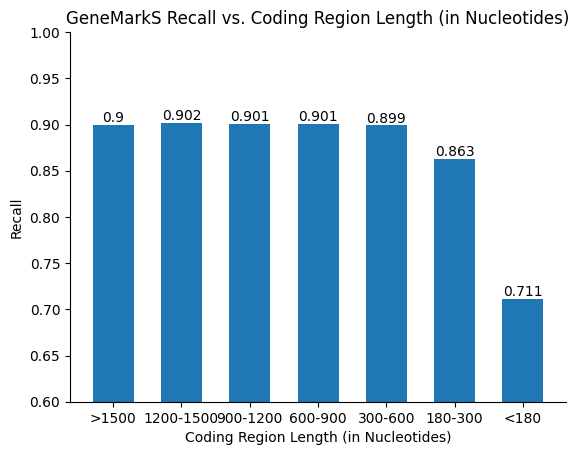

<Figure size 800x600 with 0 Axes>

In [814]:
import matplotlib.pyplot as plt
import numpy as np

x = ['>1500', '1200-1500', '900-1200', '600-900', '300-600', '180-300', '<180']
y = [0.900, 0.902, 0.901, 0.901, 0.899, 0.863, 0.711]
bar_width=0.6

fig, ax = plt.subplots()
plt.bar(x, y, width=bar_width)

plt.xlabel('Coding Region Length (in Nucleotides)')
plt.ylabel('Recall')
plt.title('GeneMarkS Recall vs. Coding Region Length (in Nucleotides)')
for i, v in enumerate(y):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.ylim(0.6, 1.0)
plt.figure(figsize=(8, 6))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.show()



/Users/tonytu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


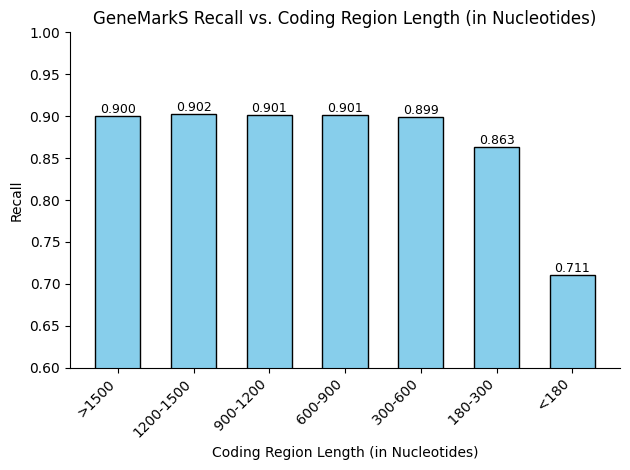

In [797]:
import matplotlib.pyplot as plt
import numpy as np

x = ['>1500', '1200-1500', ' 900-1200', ' 600-900', ' 300-600', ' 180-300', ' <180']
y = [0.900, 0.902, 0.901, 0.901, 0.899, 0.863, 0.711]

fig, ax = plt.subplots()

bars = ax.bar(x, y, width=0.6, color='skyblue', edgecolor='black')

plt.xlabel('Coding Region Length (in Nucleotides)')
plt.ylabel('Recall')
plt.title('GeneMarkS Recall vs. Coding Region Length (in Nucleotides)')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, "{:.3f}".format(height),
            ha='center', va='bottom', fontsize=9)

plt.ylim(0.6, 1.0)
plt.xticks(rotation=45, ha='right')
# ax.set_xticks(np.arange(len(x))+0.0)
ax.set_xticklabels(x, rotation=45, ha='right', fontsize=10)
# ax.set_xticklabels(x, ha='right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
# plt.savefig('gms_recall_vs_length.png', dpi=500)
plt.show()



# (camera ready) evaluating genome-wise on models trained on other folds protigeno

In [39]:
PATH = "/Users/tonytu/desktop/old_stuff/berkeley/fall2022/amiralilab/final_ten_fold_cross_validation_models/six_layer_fold_" + str(fold_index) + "_genomes.pt"
ecoli_model = torch.load(PATH)
ecoli_model.eval()

Net1(
  (fc1): Linear(in_features=1280, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
)

In [105]:
fold_genome_names = []
accuracies = []
precisions = []
recalls = []
F1s = []
def evaluate_by_genome_camera_ready(all_genomes, fold_index, find_TP_index = False):
    random.seed(5)
    torch.manual_seed(5)
    train_genomes, test_genomes = retrieve_train_test_folders(all_genomes, fold_index)
    print('total train genomes: ' + str(len(train_genomes)))
    print('total test genomes: ' + str(len(test_genomes)))
    for genome in test_genomes:
        print(genome)
        test_x = np.array([])
        test_y = np.array([])
        positive_indices = np.array(positive_filtered_genes_indices[genome]) 
        negative_indices = np.array(negative_filtered_genes_indices[genome])
        if positive_indices.shape[0] == 0 or negative_indices.shape[0] == 0:
            continue

        genome_train_coding_embeddings = torch.load('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data/' + genome + '/coding_train_emb/train_mean.pt')
        genome_train_coding_labels = np.ones(genome_train_coding_embeddings.shape[0])[positive_indices]
        genome_train_coding_embeddings = genome_train_coding_embeddings[positive_indices]
        assert genome_train_coding_embeddings.shape[0] == len(positive_indices)

        genome_train_noncoding_embeddings = torch.load('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data/' + genome + '/noncoding_test_emb/train_mean.pt')
        genome_train_noncoding_labels = np.zeros(genome_train_noncoding_embeddings.shape[0])[negative_indices]
        genome_train_noncoding_embeddings = genome_train_noncoding_embeddings[negative_indices]
        assert genome_train_noncoding_embeddings.shape[0] == len(negative_indices)
        
        if test_x.shape[0] == 0:
            test_x = genome_train_coding_embeddings
            test_y = genome_train_coding_labels
            test_x = np.concatenate((test_x, genome_train_noncoding_embeddings), axis=0)
            test_y = np.concatenate((test_y, genome_train_noncoding_labels), axis=0)

        test_output_raw = ecoli_model(torch.Tensor(test_x))
        test_output = test_output_raw.round()
        
        if find_TP_index:
            print(len(test_y))
            print(sum(test_y))
            print(len(test_y) - sum(test_y))
            print([i - int(sum(test_y)) for i in range(len(test_output)) if test_output[i] == 1 and test_y[i] == 0])
    
        accuracy, precision, recall, f1 = perf_measure(list(test_y), list(test_output.detach().numpy()))
        fold_genome_names.append(genome)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        F1s.append(f1)
        

In [106]:
#running on all the genomes:
empty_genomes = empty_positive_genomes + empty_negative_genomes
for i in range(10):
    evaluate_by_genome_camera_ready(all_genomes, i, find_TP_index = False)

total train genomes: 3860
total test genomes: 428
GCF_000283915.1_ASM28391v1
total samples: 98
TP: 27
FP: 2
TN: 48
FN: 21
accuracy: 0.7653061224489796
precision: 0.9310344827586207
recall: 0.5625
F1: 0.7012987012987013
GCF_002056795.1_ASM205679v1
total samples: 66
TP: 32
FP: 5
TN: 28
FN: 1
accuracy: 0.9090909090909091
precision: 0.8648648648648649
recall: 0.9696969696969697
F1: 0.9142857142857143
GCF_009734425.1_ASM973442v1
total samples: 42
TP: 20
FP: 1
TN: 21
FN: 0
accuracy: 0.9761904761904762
precision: 0.9523809523809523
recall: 1.0
F1: 0.975609756097561
GCF_003097575.1_ASM309757v1
total samples: 31
TP: 14
FP: 0
TN: 15
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_900476035.1_53694_C01
total samples: 36
TP: 15
FP: 0
TN: 20
FN: 1
accuracy: 0.9722222222222222
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
GCF_007750855.1_ASM775085v1
total samples: 30
TP: 14
FP: 1
TN: 14
FN: 1
accuracy: 0.9333333333333333
precision: 0.9333333333333333


accuracy: 0.9333333333333333
precision: 0.8823529411764706
recall: 1.0
F1: 0.9375
GCF_000513475.1_Bbla
total samples: 8
TP: 4
FP: 0
TN: 4
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000733715.2_ASM73371v2
total samples: 70
TP: 32
FP: 2
TN: 35
FN: 1
accuracy: 0.9571428571428572
precision: 0.9411764705882353
recall: 0.9696969696969697
F1: 0.955223880597015
GCF_017310015.1_ASM1731001v1
total samples: 41
TP: 20
FP: 3
TN: 18
FN: 0
accuracy: 0.926829268292683
precision: 0.8695652173913043
recall: 1.0
F1: 0.9302325581395349
GCF_000802245.2_ASM80224v2
total samples: 99
TP: 45
FP: 0
TN: 53
FN: 1
accuracy: 0.98989898989899
precision: 1.0
recall: 0.9782608695652174
F1: 0.989010989010989
GCF_000017945.1_ASM1794v1
total samples: 15
TP: 11
FP: 1
TN: 3
FN: 0
accuracy: 0.9333333333333333
precision: 0.9166666666666666
recall: 1.0
F1: 0.9565217391304348
GCF_015277875.1_ASM1527787v1
total samples: 30
TP: 14
FP: 1
TN: 15
FN: 0
accuracy: 0.9666666666666667
precision: 0.9333333333333333
recal

total samples: 33
TP: 12
FP: 0
TN: 19
FN: 2
accuracy: 0.9393939393939394
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_900476175.1_50648_D01
total samples: 13
TP: 6
FP: 0
TN: 7
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001267925.1_ASM126792v1
total samples: 48
TP: 22
FP: 1
TN: 23
FN: 2
accuracy: 0.9375
precision: 0.9565217391304348
recall: 0.9166666666666666
F1: 0.9361702127659574
GCF_000215645.1_ASM21564v1
total samples: 46
TP: 22
FP: 0
TN: 23
FN: 1
accuracy: 0.9782608695652174
precision: 1.0
recall: 0.9565217391304348
F1: 0.9777777777777777
GCF_002243515.1_ASM224351v1
total samples: 64
TP: 25
FP: 4
TN: 30
FN: 5
accuracy: 0.859375
precision: 0.8620689655172413
recall: 0.8333333333333334
F1: 0.847457627118644
GCF_002355855.1_ASM235585v1
total samples: 82
TP: 36
FP: 2
TN: 42
FN: 2
accuracy: 0.9512195121951219
precision: 0.9473684210526315
recall: 0.9473684210526315
F1: 0.9473684210526315
GCF_900637575.1_52006_A02
total samples: 21
TP: 10
FP: 2
TN: 

accuracy: 0.9333333333333333
precision: 0.9428571428571428
recall: 0.9166666666666666
F1: 0.9295774647887323
GCF_000025685.1_ASM2568v1
total samples: 196
TP: 94
FP: 6
TN: 91
FN: 5
accuracy: 0.9438775510204082
precision: 0.94
recall: 0.9494949494949495
F1: 0.9447236180904524
GCF_001553565.1_ASM155356v1
total samples: 33
TP: 16
FP: 0
TN: 17
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001442745.1_ASM144274v1
total samples: 29
TP: 14
FP: 0
TN: 15
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_018139125.1_ASM1813912v1
total samples: 37
TP: 15
FP: 0
TN: 21
FN: 1
accuracy: 0.972972972972973
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
GCF_014490555.1_ASM1449055v1
total samples: 30
TP: 13
FP: 0
TN: 17
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_008693785.1_ASM869378v1
total samples: 35
TP: 14
FP: 0
TN: 21
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000255115.2_ASM25511v3
total samples: 132
TP: 64
FP: 3
TN: 63
FN: 2
accuracy: 0.962

accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000833355.1_ASM83335v1
total samples: 40
TP: 12
FP: 3
TN: 20
FN: 5
accuracy: 0.8
precision: 0.8
recall: 0.7058823529411765
F1: 0.7500000000000001
GCF_013415885.1_ASM1341588v1
total samples: 152
TP: 74
FP: 6
TN: 71
FN: 1
accuracy: 0.9539473684210527
precision: 0.925
recall: 0.9866666666666667
F1: 0.9548387096774195
GCF_900475675.1_45473_D02
total samples: 58
TP: 20
FP: 2
TN: 31
FN: 5
accuracy: 0.8793103448275862
precision: 0.9090909090909091
recall: 0.8
F1: 0.8510638297872342
GCF_001545155.1_ASM154515v1
total samples: 66
TP: 30
FP: 0
TN: 33
FN: 3
accuracy: 0.9545454545454546
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
GCF_900636885.1_44927_H01
total samples: 90
TP: 44
FP: 4
TN: 41
FN: 1
accuracy: 0.9444444444444444
precision: 0.9166666666666666
recall: 0.9777777777777777
F1: 0.946236559139785
GCF_000243155.2_ASM24315v3
total samples: 146
TP: 58
FP: 5
TN: 72
FN: 11
accuracy: 0.8904109589041096
precision: 0.92063492

accuracy: 0.9166666666666666
precision: 0.9259259259259259
recall: 0.8928571428571429
F1: 0.9090909090909091
GCF_000470775.1_ASM47077v1
total samples: 41
TP: 18
FP: 0
TN: 21
FN: 2
accuracy: 0.9512195121951219
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
GCF_000280925.3_ASM28092v3
total samples: 112
TP: 46
FP: 0
TN: 58
FN: 8
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8518518518518519
F1: 0.92
GCF_005484945.1_ASM548494v1
total samples: 63
TP: 27
FP: 2
TN: 31
FN: 3
accuracy: 0.9206349206349206
precision: 0.9310344827586207
recall: 0.9
F1: 0.9152542372881356
GCF_024072275.1_ASM2407227v1
total samples: 58
TP: 12
FP: 0
TN: 45
FN: 1
accuracy: 0.9827586206896551
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
GCF_003431825.1_ASM343182v1
total samples: 77
TP: 38
FP: 1
TN: 38
FN: 0
accuracy: 0.987012987012987
precision: 0.9743589743589743
recall: 1.0
F1: 0.9870129870129869
GCF_018207515.1_ASM1820751v1
total samples: 133
TP: 60
FP: 3
TN: 68
FN: 2
accuracy: 0.96240

total samples: 38
TP: 19
FP: 1
TN: 18
FN: 0
accuracy: 0.9736842105263158
precision: 0.95
recall: 1.0
F1: 0.9743589743589743
GCF_000196535.1_ASM19653v1
total samples: 39
TP: 15
FP: 1
TN: 19
FN: 4
accuracy: 0.8717948717948718
precision: 0.9375
recall: 0.7894736842105263
F1: 0.8571428571428572
GCF_003611035.1_ASM361103v1
total samples: 20
TP: 9
FP: 1
TN: 10
FN: 0
accuracy: 0.95
precision: 0.9
recall: 1.0
F1: 0.9473684210526316
GCF_002688605.1_ASM268860v1
total samples: 359
TP: 156
FP: 15
TN: 165
FN: 23
accuracy: 0.8941504178272981
precision: 0.9122807017543859
recall: 0.8715083798882681
F1: 0.8914285714285715
GCF_001895265.1_ASM189526v1
total samples: 23
TP: 8
FP: 0
TN: 13
FN: 2
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_003070885.1_ASM307088v1
total samples: 28
TP: 12
FP: 2
TN: 13
FN: 1
accuracy: 0.8928571428571429
precision: 0.8571428571428571
recall: 0.9230769230769231
F1: 0.888888888888889
GCF_018604565.1_ASM1860456v1
total samples: 73
TP: 33
FP:

total samples: 13
TP: 8
FP: 0
TN: 3
FN: 2
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_016889385.1_ASM1688938v1
total samples: 31
TP: 14
FP: 1
TN: 16
FN: 0
accuracy: 0.967741935483871
precision: 0.9333333333333333
recall: 1.0
F1: 0.9655172413793104
GCF_900120245.1_PRJEB17949
total samples: 24
TP: 11
FP: 0
TN: 13
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001606025.1_ASM160602v1
total samples: 31
TP: 13
FP: 0
TN: 17
FN: 1
accuracy: 0.967741935483871
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
GCF_013004005.1_ASM1300400v1
total samples: 40
TP: 20
FP: 1
TN: 19
FN: 0
accuracy: 0.975
precision: 0.9523809523809523
recall: 1.0
F1: 0.975609756097561
GCF_002892185.1_ASM289218v1
total samples: 46
TP: 16
FP: 1
TN: 29
FN: 0
accuracy: 0.9782608695652174
precision: 0.9411764705882353
recall: 1.0
F1: 0.9696969696969697
GCF_020735705.1_ASM2073570v1
total samples: 69
TP: 32
FP: 0
TN: 36
FN: 1
accuracy: 0.9855072463768116
precision

accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000019905.1_ASM1990v1
total samples: 81
TP: 38
FP: 2
TN: 39
FN: 2
accuracy: 0.9506172839506173
precision: 0.95
recall: 0.95
F1: 0.9500000000000001
GCF_000973545.1_ASM97354v1
total samples: 12
TP: 6
FP: 0
TN: 6
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_013752735.1_ASM1375273v1
total samples: 216
TP: 94
FP: 3
TN: 113
FN: 6
accuracy: 0.9583333333333334
precision: 0.9690721649484536
recall: 0.94
F1: 0.9543147208121826
GCF_016939435.1_ASM1693943v1
total samples: 203
TP: 94
FP: 1
TN: 103
FN: 5
accuracy: 0.9704433497536946
precision: 0.9894736842105263
recall: 0.9494949494949495
F1: 0.9690721649484537
GCF_010731735.1_ASM1073173v1
total samples: 97
TP: 46
FP: 2
TN: 49
FN: 0
accuracy: 0.979381443298969
precision: 0.9583333333333334
recall: 1.0
F1: 0.9787234042553191
GCF_005222125.1_ASM522212v1
total samples: 50
TP: 22
FP: 4
TN: 23
FN: 1
accuracy: 0.9
precision: 0.8461538461538461
recall: 0.9565217391304348
F1: 0.8979591836734

total samples: 18
TP: 5
FP: 1
TN: 10
FN: 2
accuracy: 0.8333333333333334
precision: 0.8333333333333334
recall: 0.7142857142857143
F1: 0.7692307692307692
GCF_002843235.3_ASM284323v3
total samples: 77
TP: 35
FP: 0
TN: 41
FN: 1
accuracy: 0.987012987012987
precision: 1.0
recall: 0.9722222222222222
F1: 0.9859154929577464
GCF_000024405.1_ASM2440v1
total samples: 44
TP: 22
FP: 3
TN: 19
FN: 0
accuracy: 0.9318181818181818
precision: 0.88
recall: 1.0
F1: 0.9361702127659575
GCF_902459485.1_pb_189-2_HGAP3_CTR
total samples: 18
TP: 9
FP: 0
TN: 9
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003966975.1_ASM396697v1
total samples: 18
TP: 8
FP: 0
TN: 9
FN: 1
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
GCF_018138125.1_ASM1813812v1
total samples: 56
TP: 26
FP: 2
TN: 28
FN: 0
accuracy: 0.9642857142857143
precision: 0.9285714285714286
recall: 1.0
F1: 0.962962962962963
GCF_000144405.1_ASM14440v1
total samples: 34
TP: 16
FP: 0
TN: 17
FN: 1
accura

accuracy: 0.9705882352941176
precision: 0.9047619047619048
recall: 1.0
F1: 0.9500000000000001
GCF_008033215.1_ASM803321v1
total samples: 38
TP: 12
FP: 0
TN: 20
FN: 6
accuracy: 0.8421052631578947
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_000208385.1_ASM20838v1
total samples: 20
TP: 10
FP: 0
TN: 10
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_015139575.1_ASM1513957v1
total samples: 118
TP: 37
FP: 0
TN: 74
FN: 7
accuracy: 0.940677966101695
precision: 1.0
recall: 0.8409090909090909
F1: 0.9135802469135803
GCF_020405345.1_ASM2040534v1
total samples: 87
TP: 27
FP: 0
TN: 51
FN: 9
accuracy: 0.896551724137931
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
GCF_001543245.1_ASM154324v1
total samples: 22
TP: 11
FP: 0
TN: 11
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_002983865.1_ASM298386v1
total samples: 72
TP: 33
FP: 0
TN: 39
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_002849895.1_ASM284989v1
total samples: 38
TP: 16
FP: 1
TN: 20
FN: 1
ac

accuracy: 0.965
precision: 0.9891304347826086
recall: 0.9381443298969072
F1: 0.9629629629629629
GCF_002220155.1_ASM222015v1
total samples: 91
TP: 42
FP: 1
TN: 46
FN: 2
accuracy: 0.967032967032967
precision: 0.9767441860465116
recall: 0.9545454545454546
F1: 0.9655172413793104
GCF_001561955.1_ASM156195v1
total samples: 66
TP: 32
FP: 1
TN: 32
FN: 1
accuracy: 0.9696969696969697
precision: 0.9696969696969697
recall: 0.9696969696969697
F1: 0.9696969696969697
GCF_001460635.1_htyphlonius_mit97-6810
total samples: 23
TP: 10
FP: 1
TN: 11
FN: 1
accuracy: 0.9130434782608695
precision: 0.9090909090909091
recall: 0.9090909090909091
F1: 0.9090909090909091
GCF_002269345.1_ASM226934v1
total samples: 48
TP: 23
FP: 0
TN: 24
FN: 1
accuracy: 0.9791666666666666
precision: 1.0
recall: 0.9583333333333334
F1: 0.9787234042553191
GCF_000967915.1_ASM96791v1
total samples: 24
TP: 12
FP: 1
TN: 11
FN: 0
accuracy: 0.9583333333333334
precision: 0.9230769230769231
recall: 1.0
F1: 0.9600000000000001
GCF_013267695.1_ASM1

total samples: 131
TP: 60
FP: 1
TN: 68
FN: 2
accuracy: 0.9770992366412213
precision: 0.9836065573770492
recall: 0.967741935483871
F1: 0.975609756097561
GCF_013201705.1_ASM1320170v1
total samples: 18
TP: 7
FP: 1
TN: 8
FN: 2
accuracy: 0.8333333333333334
precision: 0.875
recall: 0.7777777777777778
F1: 0.823529411764706
GCF_003544835.1_ASM354483v1
total samples: 31
TP: 11
FP: 1
TN: 14
FN: 5
accuracy: 0.8064516129032258
precision: 0.9166666666666666
recall: 0.6875
F1: 0.7857142857142857
GCF_016904675.1_ASM1690467v1
total samples: 31
TP: 15
FP: 0
TN: 16
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_900637075.1_48128_D02
total samples: 62
TP: 25
FP: 2
TN: 32
FN: 3
accuracy: 0.9193548387096774
precision: 0.9259259259259259
recall: 0.8928571428571429
F1: 0.9090909090909091
GCF_000024545.1_ASM2454v1
total samples: 52
TP: 26
FP: 1
TN: 25
FN: 0
accuracy: 0.9807692307692307
precision: 0.9629629629629629
recall: 1.0
F1: 0.9811320754716981
GCF_000219355.1_ASM21935v1
total samples: 78
TP:

total samples: 40
TP: 17
FP: 2
TN: 21
FN: 0
accuracy: 0.95
precision: 0.8947368421052632
recall: 1.0
F1: 0.9444444444444444
GCF_023823875.1_ASM2382387v1
total samples: 263
TP: 124
FP: 8
TN: 125
FN: 6
accuracy: 0.9467680608365019
precision: 0.9393939393939394
recall: 0.9538461538461539
F1: 0.9465648854961831
GCF_020886315.1_ASM2088631v1
total samples: 140
TP: 60
FP: 5
TN: 65
FN: 10
accuracy: 0.8928571428571429
precision: 0.9230769230769231
recall: 0.8571428571428571
F1: 0.888888888888889
GCF_010119935.1_ASM1011993v1
total samples: 103
TP: 46
FP: 0
TN: 53
FN: 4
accuracy: 0.9611650485436893
precision: 1.0
recall: 0.92
F1: 0.9583333333333334
GCF_020883535.1_ASM2088353v1
total samples: 58
TP: 25
FP: 2
TN: 30
FN: 1
accuracy: 0.9482758620689655
precision: 0.9259259259259259
recall: 0.9615384615384616
F1: 0.9433962264150944
total train genomes: 3860
total test genomes: 428
GCF_000011345.1_ASM1134v1
total samples: 88
TP: 43
FP: 2
TN: 42
FN: 1
accuracy: 0.9659090909090909
precision: 0.9555555555

total samples: 37
TP: 17
FP: 1
TN: 18
FN: 1
accuracy: 0.9459459459459459
precision: 0.9444444444444444
recall: 0.9444444444444444
F1: 0.9444444444444444
GCF_002843135.1_ASM284313v1
total samples: 72
TP: 29
FP: 1
TN: 36
FN: 6
accuracy: 0.9027777777777778
precision: 0.9666666666666667
recall: 0.8285714285714286
F1: 0.8923076923076922
GCF_000317515.1_ASM31751v1
total samples: 134
TP: 65
FP: 4
TN: 63
FN: 2
accuracy: 0.9552238805970149
precision: 0.9420289855072463
recall: 0.9701492537313433
F1: 0.9558823529411764
GCF_002952315.1_ASM295231v1
total samples: 82
TP: 26
FP: 1
TN: 44
FN: 11
accuracy: 0.8536585365853658
precision: 0.9629629629629629
recall: 0.7027027027027027
F1: 0.8125
GCF_000508245.1_ASM50824v1
total samples: 9
TP: 4
FP: 1
TN: 4
FN: 0
accuracy: 0.8888888888888888
precision: 0.8
recall: 1.0
F1: 0.888888888888889
GCF_000021825.1_ASM2182v1
total samples: 189
TP: 85
FP: 3
TN: 91
FN: 10
accuracy: 0.9312169312169312
precision: 0.9659090909090909
recall: 0.8947368421052632
F1: 0.92896

total samples: 43
TP: 21
FP: 0
TN: 22
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_009363115.1_ASM936311v1
total samples: 190
TP: 75
FP: 8
TN: 96
FN: 11
accuracy: 0.9
precision: 0.9036144578313253
recall: 0.872093023255814
F1: 0.8875739644970415
GCF_016906025.1_ASM1690602v1
total samples: 203
TP: 88
FP: 8
TN: 105
FN: 2
accuracy: 0.9507389162561576
precision: 0.9166666666666666
recall: 0.9777777777777777
F1: 0.946236559139785
GCF_000012965.1_ASM1296v1
total samples: 36
TP: 16
FP: 1
TN: 17
FN: 2
accuracy: 0.9166666666666666
precision: 0.9411764705882353
recall: 0.8888888888888888
F1: 0.9142857142857143
GCF_001553955.1_ASM155395v1
total samples: 40
TP: 19
FP: 1
TN: 19
FN: 1
accuracy: 0.95
precision: 0.95
recall: 0.95
F1: 0.9500000000000001
GCF_004117055.1_ASM411705v1
total samples: 177
TP: 86
FP: 7
TN: 82
FN: 2
accuracy: 0.9491525423728814
precision: 0.9247311827956989
recall: 0.9772727272727273
F1: 0.9502762430939227
GCF_017896245.1_ASM1789624v1
GCF_023008545.1_ASM2300854v1

accuracy: 0.9534883720930233
precision: 0.95
recall: 0.95
F1: 0.9500000000000001
GCF_017821535.1_ASM1782153v1
total samples: 37
TP: 10
FP: 3
TN: 16
FN: 8
accuracy: 0.7027027027027027
precision: 0.7692307692307693
recall: 0.5555555555555556
F1: 0.6451612903225806
GCF_017493175.3_ASM1749317v3
total samples: 196
TP: 88
FP: 6
TN: 96
FN: 6
accuracy: 0.9387755102040817
precision: 0.9361702127659575
recall: 0.9361702127659575
F1: 0.9361702127659575
GCF_000971765.1_ASM97176v1
total samples: 22
TP: 9
FP: 0
TN: 11
FN: 2
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
GCF_000166335.1_ASM16633v1
total samples: 45
TP: 14
FP: 3
TN: 26
FN: 2
accuracy: 0.8888888888888888
precision: 0.8235294117647058
recall: 0.875
F1: 0.8484848484848485
GCF_000769555.1_ASM76955v1
total samples: 263
TP: 121
FP: 7
TN: 128
FN: 7
accuracy: 0.9467680608365019
precision: 0.9453125
recall: 0.9453125
F1: 0.9453125
GCF_003589925.1_ASM358992v1
total samples: 38
TP: 19
FP: 1
TN: 18
FN: 0
accuracy: 

accuracy: 0.9215686274509803
precision: 0.92
recall: 0.92
F1: 0.92
GCF_012849095.1_ASM1284909v1
total samples: 134
TP: 62
FP: 4
TN: 64
FN: 4
accuracy: 0.9402985074626866
precision: 0.9393939393939394
recall: 0.9393939393939394
F1: 0.9393939393939394
GCF_000007205.1_ASM720v1
total samples: 26
TP: 7
FP: 0
TN: 13
FN: 6
accuracy: 0.7692307692307693
precision: 1.0
recall: 0.5384615384615384
F1: 0.7000000000000001
GCF_001729245.1_ASM172924v1
total samples: 31
TP: 13
FP: 0
TN: 16
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
GCF_001623565.1_ASM162356v1
total samples: 53
TP: 23
FP: 4
TN: 24
FN: 2
accuracy: 0.8867924528301887
precision: 0.8518518518518519
recall: 0.92
F1: 0.8846153846153846
GCF_003576455.2_ASM357645v2
total samples: 81
TP: 39
FP: 3
TN: 38
FN: 1
accuracy: 0.9506172839506173
precision: 0.9285714285714286
recall: 0.975
F1: 0.951219512195122
GCF_000147355.1_ASM14735v1
total samples: 32
TP: 13
FP: 2
TN: 14
FN: 3
accuracy: 0.84375

total samples: 20
TP: 10
FP: 1
TN: 9
FN: 0
accuracy: 0.95
precision: 0.9090909090909091
recall: 1.0
F1: 0.9523809523809523
GCF_001050475.1_ASM105047v1
total samples: 31
TP: 14
FP: 1
TN: 15
FN: 1
accuracy: 0.9354838709677419
precision: 0.9333333333333333
recall: 0.9333333333333333
F1: 0.9333333333333333
GCF_000940995.1_ASM94099v1
total samples: 98
TP: 44
FP: 2
TN: 48
FN: 4
accuracy: 0.9387755102040817
precision: 0.9565217391304348
recall: 0.9166666666666666
F1: 0.9361702127659574
GCF_000240185.1_ASM24018v2
total samples: 847
TP: 129
FP: 9
TN: 415
FN: 294
accuracy: 0.6422668240850059
precision: 0.9347826086956522
recall: 0.3049645390070922
F1: 0.45989304812834225
GCF_013365455.1_ASM1336545v1
total samples: 17
TP: 6
FP: 0
TN: 9
FN: 2
accuracy: 0.8823529411764706
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
GCF_900187085.1_50624_E01
total samples: 47
TP: 19
FP: 1
TN: 24
FN: 3
accuracy: 0.9148936170212766
precision: 0.95
recall: 0.8636363636363636
F1: 0.9047619047619048
GCF_009002475.

total samples: 117
TP: 16
FP: 2
TN: 89
FN: 10
accuracy: 0.8974358974358975
precision: 0.8888888888888888
recall: 0.6153846153846154
F1: 0.7272727272727274
GCF_007641255.1_ASM764125v1
total samples: 51
TP: 24
FP: 2
TN: 24
FN: 1
accuracy: 0.9411764705882353
precision: 0.9230769230769231
recall: 0.96
F1: 0.9411764705882353
GCF_002504165.1_ASM250416v1
total samples: 50
TP: 23
FP: 0
TN: 27
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_022984195.1_ASM2298419v1
total samples: 32
TP: 3
FP: 1
TN: 28
FN: 0
accuracy: 0.96875
precision: 0.75
recall: 1.0
F1: 0.8571428571428571
GCF_000194625.1_ASM19462v1
total samples: 62
TP: 31
FP: 5
TN: 26
FN: 0
accuracy: 0.9193548387096774
precision: 0.8611111111111112
recall: 1.0
F1: 0.9253731343283582
GCF_014217565.1_ASM1421756v1
total samples: 114
TP: 51
FP: 1
TN: 58
FN: 4
accuracy: 0.956140350877193
precision: 0.9807692307692307
recall: 0.9272727272727272
F1: 0.9532710280373831
GCF_000012885.1_ASM1288v1
total samples: 36
TP: 17
FP: 0
TN: 18
FN: 1

total samples: 136
TP: 63
FP: 2
TN: 67
FN: 4
accuracy: 0.9558823529411765
precision: 0.9692307692307692
recall: 0.9402985074626866
F1: 0.9545454545454547
GCF_001043175.1_ASM104317v1
total samples: 46
TP: 22
FP: 2
TN: 21
FN: 1
accuracy: 0.9347826086956522
precision: 0.9166666666666666
recall: 0.9565217391304348
F1: 0.9361702127659574
GCF_900659885.1_TLA
total samples: 37
TP: 17
FP: 1
TN: 19
FN: 0
accuracy: 0.972972972972973
precision: 0.9444444444444444
recall: 1.0
F1: 0.9714285714285714
GCF_003627075.1_ASM362707v1
total samples: 25
TP: 12
FP: 0
TN: 13
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_019047805.1_ASM1904780v1
total samples: 32
TP: 13
FP: 1
TN: 17
FN: 1
accuracy: 0.9375
precision: 0.9285714285714286
recall: 0.9285714285714286
F1: 0.9285714285714286
GCF_019139835.1_ASM1913983v1
total samples: 80
TP: 30
FP: 0
TN: 46
FN: 4
accuracy: 0.95
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
GCF_001997385.1_ASM199738v1
total samples: 28
TP: 14
FP: 1
TN: 13
FN: 0
accu

total samples: 198
TP: 95
FP: 1
TN: 98
FN: 4
accuracy: 0.9747474747474747
precision: 0.9895833333333334
recall: 0.9595959595959596
F1: 0.9743589743589745
GCF_024498335.1_ASM2449833v1
total samples: 98
TP: 49
FP: 6
TN: 43
FN: 0
accuracy: 0.9387755102040817
precision: 0.8909090909090909
recall: 1.0
F1: 0.9423076923076923
GCF_016605985.1_ASM1660598v1
total samples: 371
TP: 131
FP: 8
TN: 208
FN: 24
accuracy: 0.9137466307277629
precision: 0.9424460431654677
recall: 0.8451612903225807
F1: 0.8911564625850341
GCF_000277285.1_ASM27728v1
total samples: 19
TP: 7
FP: 0
TN: 10
FN: 2
accuracy: 0.8947368421052632
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
GCF_019175485.1_ASM1917548v1
total samples: 89
TP: 37
FP: 1
TN: 48
FN: 3
accuracy: 0.9550561797752809
precision: 0.9736842105263158
recall: 0.925
F1: 0.9487179487179489
GCF_001889025.1_ASM188902v1
total samples: 40
TP: 20
FP: 1
TN: 19
FN: 0
accuracy: 0.975
precision: 0.9523809523809523
recall: 1.0
F1: 0.975609756097561
GCF_0039

accuracy: 0.9571428571428572
precision: 0.9210526315789473
recall: 1.0
F1: 0.958904109589041
GCF_017901135.1_ASM1790113v1
total samples: 48
TP: 23
FP: 0
TN: 24
FN: 1
accuracy: 0.9791666666666666
precision: 1.0
recall: 0.9583333333333334
F1: 0.9787234042553191
GCF_000020485.1_ASM2048v1
total samples: 36
TP: 16
FP: 2
TN: 16
FN: 2
accuracy: 0.8888888888888888
precision: 0.8888888888888888
recall: 0.8888888888888888
F1: 0.8888888888888888
GCF_011068285.1_ASM1106828v1
total samples: 50
TP: 22
FP: 2
TN: 24
FN: 2
accuracy: 0.92
precision: 0.9166666666666666
recall: 0.9166666666666666
F1: 0.9166666666666666
GCF_003430825.1_ASM343082v1
total samples: 167
TP: 83
FP: 2
TN: 82
FN: 0
accuracy: 0.9880239520958084
precision: 0.9764705882352941
recall: 1.0
F1: 0.988095238095238
GCF_014068355.1_ASM1406835v1
total samples: 6
TP: 1
FP: 0
TN: 5
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001584205.1_ASM158420v1
total samples: 42
TP: 20
FP: 0
TN: 22
FN: 0
accuracy: 1.0
precision: 1.0
recall:

total samples: 95
TP: 41
FP: 2
TN: 48
FN: 4
accuracy: 0.9368421052631579
precision: 0.9534883720930233
recall: 0.9111111111111111
F1: 0.9318181818181819
GCF_000014945.1_ASM1494v1
total samples: 50
TP: 25
FP: 1
TN: 24
FN: 0
accuracy: 0.98
precision: 0.9615384615384616
recall: 1.0
F1: 0.9803921568627451
GCF_003491185.1_ASM349118v1
total samples: 20
TP: 10
FP: 0
TN: 10
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_002211785.1_ASM221178v1
total samples: 53
TP: 24
FP: 5
TN: 22
FN: 2
accuracy: 0.8679245283018868
precision: 0.8275862068965517
recall: 0.9230769230769231
F1: 0.8727272727272727
GCF_000199675.1_ASM19967v1
total samples: 28
TP: 14
FP: 1
TN: 13
FN: 0
accuracy: 0.9642857142857143
precision: 0.9333333333333333
recall: 1.0
F1: 0.9655172413793104
GCF_000967305.2_ASM96730v2
total samples: 36
TP: 15
FP: 0
TN: 19
FN: 2
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
GCF_010731715.1_ASM1073171v1
total samples: 61
TP: 25
FP: 1
TN: 33
FN: 2
accu

accuracy: 0.9263959390862944
precision: 0.96875
recall: 0.8659217877094972
F1: 0.9144542772861357
GCF_009068765.1_ASM906876v1
total samples: 33
TP: 14
FP: 0
TN: 18
FN: 1
accuracy: 0.9696969696969697
precision: 1.0
recall: 0.9333333333333333
F1: 0.9655172413793104
GCF_004114915.1_ASM411491v1
total samples: 191
TP: 86
FP: 1
TN: 98
FN: 6
accuracy: 0.9633507853403142
precision: 0.9885057471264368
recall: 0.9347826086956522
F1: 0.9608938547486033
GCF_000021805.1_ASM2180v1
total samples: 201
TP: 90
FP: 7
TN: 93
FN: 11
accuracy: 0.9104477611940298
precision: 0.9278350515463918
recall: 0.8910891089108911
F1: 0.9090909090909091
GCF_019977655.1_ASM1997765v1
total samples: 201
TP: 91
FP: 2
TN: 99
FN: 9
accuracy: 0.945273631840796
precision: 0.978494623655914
recall: 0.91
F1: 0.9430051813471503
GCF_019890915.1_ASM1989091v1
total samples: 26
TP: 12
FP: 0
TN: 14
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003015145.1_ASM301514v1
total samples: 16
TP: 8
FP: 1
TN: 7
FN: 0
accuracy: 0.93

total samples: 49
TP: 24
FP: 2
TN: 22
FN: 1
accuracy: 0.9387755102040817
precision: 0.9230769230769231
recall: 0.96
F1: 0.9411764705882353
GCF_900660745.1_57728_G01-3
total samples: 20
TP: 9
FP: 1
TN: 10
FN: 0
accuracy: 0.95
precision: 0.9
recall: 1.0
F1: 0.9473684210526316
GCF_014268375.2_ASM1426837v2
total samples: 96
TP: 35
FP: 2
TN: 56
FN: 3
accuracy: 0.9479166666666666
precision: 0.9459459459459459
recall: 0.9210526315789473
F1: 0.9333333333333332
GCF_009688965.1_ASM968896v1
total samples: 57
TP: 27
FP: 3
TN: 26
FN: 1
accuracy: 0.9298245614035088
precision: 0.9
recall: 0.9642857142857143
F1: 0.9310344827586207
GCF_000264495.1_ASM26449v1
total samples: 18
TP: 9
FP: 0
TN: 9
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_018437505.1_ASM1843750v1
total samples: 80
TP: 40
FP: 2
TN: 38
FN: 0
accuracy: 0.975
precision: 0.9523809523809523
recall: 1.0
F1: 0.975609756097561
GCF_002285715.1_ASM228571v1
total samples: 57
TP: 21
FP: 1
TN: 33
FN: 2
accuracy: 0.9473684210526315
preci

accuracy: 0.9108910891089109
precision: 0.8955223880597015
recall: 0.967741935483871
F1: 0.930232558139535
GCF_000632965.1_ASM63296v1
total samples: 13
TP: 6
FP: 0
TN: 7
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_015159595.1_ASM1515959v1
total samples: 55
TP: 26
FP: 1
TN: 27
FN: 1
accuracy: 0.9636363636363636
precision: 0.9629629629629629
recall: 0.9629629629629629
F1: 0.9629629629629629
GCF_023702635.1_ASM2370263v1
total samples: 37
TP: 18
FP: 2
TN: 17
FN: 0
accuracy: 0.9459459459459459
precision: 0.9
recall: 1.0
F1: 0.9473684210526316
GCF_021278965.1_ASM2127896v1
total samples: 71
TP: 29
FP: 1
TN: 37
FN: 4
accuracy: 0.9295774647887324
precision: 0.9666666666666667
recall: 0.8787878787878788
F1: 0.9206349206349207
GCF_003594935.2_ASM359493v2
total samples: 95
TP: 33
FP: 2
TN: 55
FN: 5
accuracy: 0.9263157894736842
precision: 0.9428571428571428
recall: 0.868421052631579
F1: 0.904109589041096
GCF_000222305.1_ASM22230v1
total samples: 33
TP: 8
FP: 1
TN: 16
FN: 8
accuracy: 

total samples: 75
TP: 29
FP: 0
TN: 40
FN: 6
accuracy: 0.92
precision: 1.0
recall: 0.8285714285714286
F1: 0.90625
GCF_019602855.1_ASM1960285v1
total samples: 109
TP: 46
FP: 2
TN: 54
FN: 7
accuracy: 0.9174311926605505
precision: 0.9583333333333334
recall: 0.8679245283018868
F1: 0.910891089108911
GCF_000299355.1_ASM29935v1
total samples: 66
TP: 31
FP: 5
TN: 28
FN: 2
accuracy: 0.8939393939393939
precision: 0.8611111111111112
recall: 0.9393939393939394
F1: 0.8985507246376813
GCF_000067205.1_ASM6720v1
total samples: 58
TP: 26
FP: 0
TN: 29
FN: 3
accuracy: 0.9482758620689655
precision: 1.0
recall: 0.896551724137931
F1: 0.9454545454545454
GCF_018595685.2_ASM1859568v2
total samples: 25
TP: 12
FP: 0
TN: 13
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001687565.2_ASM168756v2
total samples: 89
TP: 39
FP: 0
TN: 47
FN: 3
accuracy: 0.9662921348314607
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
GCF_024498215.1_ASM2449821v1
total samples: 12
TP: 6
FP: 0
TN: 6
FN: 0
accu

total samples: 44
TP: 22
FP: 1
TN: 21
FN: 0
accuracy: 0.9772727272727273
precision: 0.9565217391304348
recall: 1.0
F1: 0.9777777777777777
GCF_011397115.1_ASM1139711v1
total samples: 90
TP: 40
FP: 0
TN: 48
FN: 2
accuracy: 0.9777777777777777
precision: 1.0
recall: 0.9523809523809523
F1: 0.975609756097561
GCF_000599985.1_ASM59998v1
total samples: 30
TP: 12
FP: 1
TN: 14
FN: 3
accuracy: 0.8666666666666667
precision: 0.9230769230769231
recall: 0.8
F1: 0.8571428571428571
GCF_001458655.1_Mb9
total samples: 72
TP: 34
FP: 1
TN: 35
FN: 2
accuracy: 0.9583333333333334
precision: 0.9714285714285714
recall: 0.9444444444444444
F1: 0.9577464788732395
GCF_000027145.1_ASM2714v1
total samples: 58
TP: 26
FP: 0
TN: 29
FN: 3
accuracy: 0.9482758620689655
precision: 1.0
recall: 0.896551724137931
F1: 0.9454545454545454
GCF_016028635.1_ASM1602863v1
total samples: 73
TP: 32
FP: 2
TN: 37
FN: 2
accuracy: 0.9452054794520548
precision: 0.9411764705882353
recall: 0.9411764705882353
F1: 0.9411764705882353
GCF_001717565

total samples: 122
TP: 55
FP: 0
TN: 61
FN: 6
accuracy: 0.9508196721311475
precision: 1.0
recall: 0.9016393442622951
F1: 0.9482758620689655
GCF_014269025.2_ASM1426902v2
total samples: 81
TP: 36
FP: 1
TN: 43
FN: 1
accuracy: 0.9753086419753086
precision: 0.972972972972973
recall: 0.972972972972973
F1: 0.972972972972973
GCF_000012345.1_ASM1234v1
total samples: 28
TP: 13
FP: 1
TN: 10
FN: 4
accuracy: 0.8214285714285714
precision: 0.9285714285714286
recall: 0.7647058823529411
F1: 0.8387096774193549
GCF_021496725.1_ASM2149672v1
total samples: 7
TP: 5
FP: 0
TN: 2
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000203895.1_ASM20389v1
total samples: 69
TP: 34
FP: 1
TN: 34
FN: 0
accuracy: 0.9855072463768116
precision: 0.9714285714285714
recall: 1.0
F1: 0.9855072463768115
GCF_015775975.1_ASM1577597v1
total samples: 78
TP: 32
FP: 1
TN: 43
FN: 2
accuracy: 0.9615384615384616
precision: 0.9696969696969697
recall: 0.9411764705882353
F1: 0.955223880597015
GCF_000327045.1_ASM32704v1
total sampl

accuracy: 0.7575757575757576
precision: 0.9
recall: 0.5625
F1: 0.6923076923076923
GCF_014054965.1_ASM1405496v1
total samples: 90
TP: 35
FP: 1
TN: 45
FN: 9
accuracy: 0.8888888888888888
precision: 0.9722222222222222
recall: 0.7954545454545454
F1: 0.875
GCF_016446285.1_ASM1644628v1
total samples: 28
TP: 14
FP: 1
TN: 13
FN: 0
accuracy: 0.9642857142857143
precision: 0.9333333333333333
recall: 1.0
F1: 0.9655172413793104
GCF_002157735.2_ASM215773v2
total samples: 42
TP: 20
FP: 2
TN: 20
FN: 0
accuracy: 0.9523809523809523
precision: 0.9090909090909091
recall: 1.0
F1: 0.9523809523809523
GCF_001522635.2_ASM152263v2
total samples: 127
TP: 49
FP: 1
TN: 69
FN: 8
accuracy: 0.9291338582677166
precision: 0.98
recall: 0.8596491228070176
F1: 0.9158878504672898
GCF_002085925.2_ASM208592v2
total samples: 56
TP: 23
FP: 1
TN: 30
FN: 2
accuracy: 0.9464285714285714
precision: 0.9583333333333334
recall: 0.92
F1: 0.9387755102040817
GCF_001278055.1_ASM127805v1
total samples: 72
TP: 33
FP: 2
TN: 34
FN: 3
accuracy:

accuracy: 0.9795918367346939
precision: 1.0
recall: 0.9444444444444444
F1: 0.9714285714285714
GCF_000166355.1_ASM16635v1
total samples: 55
TP: 17
FP: 3
TN: 31
FN: 4
accuracy: 0.8727272727272727
precision: 0.85
recall: 0.8095238095238095
F1: 0.8292682926829269
GCF_002285515.1_ASM228551v1
total samples: 57
TP: 26
FP: 0
TN: 31
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000828615.1_ASM82861v1
total samples: 34
TP: 16
FP: 0
TN: 17
FN: 1
accuracy: 0.9705882352941176
precision: 1.0
recall: 0.9411764705882353
F1: 0.9696969696969697
GCF_001584725.1_ASM158472v1
total samples: 82
TP: 37
FP: 6
TN: 35
FN: 4
accuracy: 0.8780487804878049
precision: 0.8604651162790697
recall: 0.9024390243902439
F1: 0.8809523809523809
GCF_007741515.1_ASM774151v1
total samples: 30
TP: 15
FP: 0
TN: 15
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003627755.1_ASM362775v1
total samples: 125
TP: 57
FP: 4
TN: 59
FN: 5
accuracy: 0.928
precision: 0.9344262295081968
recall: 0.9193548387096774
F1: 0.

accuracy: 0.9605263157894737
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
GCF_018107685.1_ASM1810768v1
total samples: 10
TP: 4
FP: 0
TN: 5
FN: 1
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_002305895.1_ASM230589v1
total samples: 98
TP: 38
FP: 2
TN: 51
FN: 7
accuracy: 0.9081632653061225
precision: 0.95
recall: 0.8444444444444444
F1: 0.8941176470588236
GCF_004328555.1_ASM432855v1
total samples: 43
TP: 20
FP: 0
TN: 22
FN: 1
accuracy: 0.9767441860465116
precision: 1.0
recall: 0.9523809523809523
F1: 0.975609756097561
GCF_011611525.1_ASM1161152v1
total samples: 69
TP: 31
FP: 0
TN: 36
FN: 2
accuracy: 0.9710144927536232
precision: 1.0
recall: 0.9393939393939394
F1: 0.96875
GCF_016804005.1_ASM1680400v1
total samples: 106
TP: 44
FP: 1
TN: 56
FN: 5
accuracy: 0.9433962264150944
precision: 0.9777777777777777
recall: 0.8979591836734694
F1: 0.9361702127659575
GCF_011040435.1_ASM1104043v1
total samples: 65
TP: 26
FP: 2
TN: 35
FN: 2
accuracy: 0.9384615384615385
precision: 0.9

accuracy: 0.975
precision: 1.0
recall: 0.9444444444444444
F1: 0.9714285714285714
GCF_002288285.1_ASM228828v1
total samples: 91
TP: 41
FP: 0
TN: 46
FN: 4
accuracy: 0.9560439560439561
precision: 1.0
recall: 0.9111111111111111
F1: 0.9534883720930233
GCF_004214795.1_ASM421479v1
total samples: 21
TP: 10
FP: 2
TN: 9
FN: 0
accuracy: 0.9047619047619048
precision: 0.8333333333333334
recall: 1.0
F1: 0.9090909090909091
GCF_014337175.1_ASM1433717v1
total samples: 69
TP: 34
FP: 0
TN: 35
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003352185.1_ASM335218v1
total samples: 93
TP: 40
FP: 0
TN: 52
FN: 1
accuracy: 0.989247311827957
precision: 1.0
recall: 0.975609756097561
F1: 0.9876543209876543
GCF_000024325.1_ASM2432v1
total samples: 38
TP: 19
FP: 1
TN: 18
FN: 0
accuracy: 0.9736842105263158
precision: 0.95
recall: 1.0
F1: 0.9743589743589743
GCF_003336365.1_ASM333636v1
total samples: 114
TP: 56
FP: 1
TN: 56
FN: 1
accuracy: 0.9824561403508771
precision: 0.9824561403508771
recall: 0.9824561403

accuracy: 0.9538461538461539
precision: 0.9223300970873787
recall: 0.9895833333333334
F1: 0.9547738693467336
GCF_002762335.1_ASM276233v1
total samples: 23
TP: 11
FP: 2
TN: 10
FN: 0
accuracy: 0.9130434782608695
precision: 0.8461538461538461
recall: 1.0
F1: 0.9166666666666666
GCF_003008555.2_ASM300855v2
total samples: 49
TP: 24
FP: 1
TN: 24
FN: 0
accuracy: 0.9795918367346939
precision: 0.96
recall: 1.0
F1: 0.9795918367346939
GCF_002072065.1_ASM207206v1
total samples: 231
TP: 105
FP: 4
TN: 115
FN: 7
accuracy: 0.9523809523809523
precision: 0.963302752293578
recall: 0.9375
F1: 0.9502262443438915
GCF_013003965.1_ASM1300396v1
total samples: 40
TP: 20
FP: 0
TN: 20
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_004135345.1_ASM413534v1
total samples: 37
TP: 17
FP: 0
TN: 20
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_015689335.1_ASM1568933v1
total samples: 62
TP: 24
FP: 4
TN: 31
FN: 3
accuracy: 0.8870967741935484
precision: 0.8571428571428571
recall: 0.8888888888888888


accuracy: 0.8974358974358975
precision: 0.9411764705882353
recall: 0.8421052631578947
F1: 0.8888888888888888
GCF_016027455.1_ASM1602745v1
total samples: 120
TP: 40
FP: 0
TN: 68
FN: 12
accuracy: 0.9
precision: 1.0
recall: 0.7692307692307693
F1: 0.8695652173913044
GCF_019933235.1_ASM1993323v1
total samples: 128
TP: 54
FP: 1
TN: 70
FN: 3
accuracy: 0.96875
precision: 0.9818181818181818
recall: 0.9473684210526315
F1: 0.9642857142857142
GCF_000227745.2_ASM22774v3
total samples: 114
TP: 51
FP: 1
TN: 56
FN: 6
accuracy: 0.9385964912280702
precision: 0.9807692307692307
recall: 0.8947368421052632
F1: 0.9357798165137614
GCF_014495845.1_ASM1449584v1
total samples: 74
TP: 35
FP: 1
TN: 37
FN: 1
accuracy: 0.972972972972973
precision: 0.9722222222222222
recall: 0.9722222222222222
F1: 0.9722222222222222
GCF_000020045.1_ASM2004v1
total samples: 153
TP: 71
FP: 2
TN: 76
FN: 4
accuracy: 0.9607843137254902
precision: 0.9726027397260274
recall: 0.9466666666666667
F1: 0.9594594594594594
GCF_023920085.1_ASM2392

total samples: 24
TP: 10
FP: 0
TN: 12
FN: 2
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_001278075.1_ASM127807v1
total samples: 110
TP: 51
FP: 1
TN: 56
FN: 2
accuracy: 0.9727272727272728
precision: 0.9807692307692307
recall: 0.9622641509433962
F1: 0.9714285714285713
GCF_000183425.1_ASM18342v1
total samples: 26
TP: 12
FP: 2
TN: 11
FN: 1
accuracy: 0.8846153846153846
precision: 0.8571428571428571
recall: 0.9230769230769231
F1: 0.888888888888889
GCF_003382565.3_ASM338256v3
total samples: 75
TP: 29
FP: 0
TN: 44
FN: 2
accuracy: 0.9733333333333334
precision: 1.0
recall: 0.9354838709677419
F1: 0.9666666666666666
GCF_000017265.1_ASM1726v1
total samples: 40
TP: 21
FP: 1
TN: 18
FN: 0
accuracy: 0.975
precision: 0.9545454545454546
recall: 1.0
F1: 0.9767441860465117
GCF_005943945.1_ASM594394v1
total samples: 38
TP: 17
FP: 1
TN: 19
FN: 1
accuracy: 0.9473684210526315
precision: 0.9444444444444444
recall: 0.9444444444444444
F1: 0.9444444444444444
GCF

accuracy: 0.9505494505494505
precision: 0.925531914893617
recall: 0.9775280898876404
F1: 0.9508196721311475
GCF_012273615.1_ASM1227361v1
total samples: 54
TP: 21
FP: 2
TN: 27
FN: 4
accuracy: 0.8888888888888888
precision: 0.9130434782608695
recall: 0.84
F1: 0.8749999999999999
GCF_009739945.1_ASM973994v1
total samples: 284
TP: 108
FP: 11
TN: 151
FN: 14
accuracy: 0.9119718309859155
precision: 0.907563025210084
recall: 0.8852459016393442
F1: 0.8962655601659751
GCF_001856685.1_ASM185668v1
total samples: 23
TP: 11
FP: 0
TN: 12
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_006542275.1_ASM654227v1
total samples: 65
TP: 30
FP: 1
TN: 32
FN: 2
accuracy: 0.9538461538461539
precision: 0.967741935483871
recall: 0.9375
F1: 0.9523809523809523
GCF_024498175.1_ASM2449817v1
total samples: 72
TP: 14
FP: 5
TN: 53
FN: 0
accuracy: 0.9305555555555556
precision: 0.7368421052631579
recall: 1.0
F1: 0.8484848484848484
GCF_013488205.1_ASM1348820v1
total samples: 26
TP: 13
FP: 0
TN: 13
FN: 0
accuracy: 

accuracy: 0.8878504672897196
precision: 0.9722222222222222
recall: 0.7608695652173914
F1: 0.853658536585366
GCF_000235405.2_ASM23540v3
total samples: 16
TP: 8
FP: 1
TN: 7
FN: 0
accuracy: 0.9375
precision: 0.8888888888888888
recall: 1.0
F1: 0.9411764705882353
GCF_003544855.1_ASM354485v1
total samples: 24
TP: 11
FP: 1
TN: 11
FN: 1
accuracy: 0.9166666666666666
precision: 0.9166666666666666
recall: 0.9166666666666666
F1: 0.9166666666666666
GCF_000590925.1_ASM59092v1
total samples: 54
TP: 26
FP: 0
TN: 28
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001028665.1_ASM102866v1
total samples: 113
TP: 49
FP: 0
TN: 60
FN: 4
accuracy: 0.9646017699115044
precision: 1.0
recall: 0.9245283018867925
F1: 0.9607843137254902
GCF_003072465.1_ASM307246v1
total samples: 11
TP: 5
FP: 0
TN: 5
FN: 1
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_009671065.1_ASM967106v1
total samples: 69
TP: 22
FP: 0
TN: 39
FN: 8
accuracy: 0.8840579710144928
precisio

accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_021654455.1_ASM2165445v1
total samples: 48
TP: 21
FP: 0
TN: 27
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_013488025.1_ASM1348802v1
total samples: 69
TP: 16
FP: 1
TN: 46
FN: 6
accuracy: 0.8985507246376812
precision: 0.9411764705882353
recall: 0.7272727272727273
F1: 0.8205128205128205
GCF_014058705.1_ASM1405870v1
total samples: 60
TP: 30
FP: 1
TN: 29
FN: 0
accuracy: 0.9833333333333333
precision: 0.967741935483871
recall: 1.0
F1: 0.9836065573770492
GCF_002022145.1_ASM202214v1
total samples: 46
TP: 19
FP: 0
TN: 23
FN: 4
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8260869565217391
F1: 0.9047619047619047
GCF_003015185.1_ASM301518v1
total samples: 26
TP: 13
FP: 1
TN: 12
FN: 0
accuracy: 0.9615384615384616
precision: 0.9285714285714286
recall: 1.0
F1: 0.962962962962963
GCF_004028015.1_ASM402801v1
total samples: 107
TP: 43
FP: 2
TN: 57
FN: 5
accuracy: 0.9345794392523364
precision: 0.9555555555555556
recall: 0.89583333

total samples: 108
TP: 52
FP: 3
TN: 51
FN: 2
accuracy: 0.9537037037037037
precision: 0.9454545454545454
recall: 0.9629629629629629
F1: 0.9541284403669724
GCF_000020505.1_ASM2050v1
total samples: 42
TP: 21
FP: 1
TN: 20
FN: 0
accuracy: 0.9761904761904762
precision: 0.9545454545454546
recall: 1.0
F1: 0.9767441860465117
GCF_900683745.1_Paraprevotella_xylaniphila_82A6
total samples: 62
TP: 27
FP: 0
TN: 33
FN: 2
accuracy: 0.967741935483871
precision: 1.0
recall: 0.9310344827586207
F1: 0.9642857142857143
GCF_022879815.1_ASM2287981v1
total samples: 124
TP: 56
FP: 2
TN: 62
FN: 4
accuracy: 0.9516129032258065
precision: 0.9655172413793104
recall: 0.9333333333333333
F1: 0.9491525423728815
GCF_000217815.1_ASM21781v1
total samples: 23
TP: 10
FP: 0
TN: 11
FN: 2
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_009769205.1_ASM976920v1
total samples: 55
TP: 23
FP: 2
TN: 28
FN: 2
accuracy: 0.9272727272727272
precision: 0.92
recall: 0.92
F1: 0.92
GCF_002238

accuracy: 0.9358974358974359
precision: 0.925
recall: 0.9487179487179487
F1: 0.9367088607594937
GCF_001718555.1_ASM171855v1
total samples: 101
TP: 42
FP: 1
TN: 56
FN: 2
accuracy: 0.9702970297029703
precision: 0.9767441860465116
recall: 0.9545454545454546
F1: 0.9655172413793104
GCF_001620305.1_ASM162030v1
total samples: 83
TP: 39
FP: 2
TN: 40
FN: 2
accuracy: 0.9518072289156626
precision: 0.9512195121951219
recall: 0.9512195121951219
F1: 0.9512195121951219
GCF_001854125.1_ASM185412v1
total samples: 33
TP: 15
FP: 0
TN: 18
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_020735445.1_ASM2073544v1
total samples: 96
TP: 43
FP: 2
TN: 47
FN: 4
accuracy: 0.9375
precision: 0.9555555555555556
recall: 0.9148936170212766
F1: 0.9347826086956522
GCF_006007945.1_ASM600794v1
total samples: 30
TP: 13
FP: 2
TN: 15
FN: 0
accuracy: 0.9333333333333333
precision: 0.8666666666666667
recall: 1.0
F1: 0.9285714285714286
GCF_000468615.2_ASM46861v2
total samples: 56
TP: 24
FP: 0
TN: 29
FN: 3
accuracy: 0.9

total samples: 70
TP: 32
FP: 0
TN: 37
FN: 1
accuracy: 0.9857142857142858
precision: 1.0
recall: 0.9696969696969697
F1: 0.9846153846153847
GCF_900187005.1_50569_B01
total samples: 67
TP: 32
FP: 1
TN: 34
FN: 0
accuracy: 0.9850746268656716
precision: 0.9696969696969697
recall: 1.0
F1: 0.9846153846153847
GCF_019139895.1_ASM1913989v1
total samples: 65
TP: 19
FP: 0
TN: 43
FN: 3
accuracy: 0.9538461538461539
precision: 1.0
recall: 0.8636363636363636
F1: 0.9268292682926829
GCF_013372205.1_ASM1337220v1
total samples: 44
TP: 20
FP: 4
TN: 18
FN: 2
accuracy: 0.8636363636363636
precision: 0.8333333333333334
recall: 0.9090909090909091
F1: 0.8695652173913043
GCF_001281045.1_ASM128104v1
total samples: 10
TP: 3
FP: 0
TN: 7
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_003966655.1_ASM396665v1
total samples: 42
TP: 21
FP: 1
TN: 20
FN: 0
accuracy: 0.9761904761904762
precision: 0.9545454545454546
recall: 1.0
F1: 0.9767441860465117
GCF_002288065.1_ASM228806v1
total samples: 11
TP: 6
FP: 2
TN: 3


total samples: 65
TP: 29
FP: 0
TN: 33
FN: 3
accuracy: 0.9538461538461539
precision: 1.0
recall: 0.90625
F1: 0.9508196721311475
GCF_900120375.1_PRJEB18029
total samples: 36
TP: 16
FP: 2
TN: 17
FN: 1
accuracy: 0.9166666666666666
precision: 0.8888888888888888
recall: 0.9411764705882353
F1: 0.9142857142857143
GCF_018389385.1_ASM1838938v1
total samples: 50
TP: 25
FP: 1
TN: 24
FN: 0
accuracy: 0.98
precision: 0.9615384615384616
recall: 1.0
F1: 0.9803921568627451
GCF_022539405.1_ASM2253940v1
total samples: 68
TP: 32
FP: 3
TN: 31
FN: 2
accuracy: 0.9264705882352942
precision: 0.9142857142857143
recall: 0.9411764705882353
F1: 0.9275362318840579
GCF_020694005.1_ASM2069400v1
total samples: 28
TP: 11
FP: 1
TN: 15
FN: 1
accuracy: 0.9285714285714286
precision: 0.9166666666666666
recall: 0.9166666666666666
F1: 0.9166666666666666
GCF_003072485.1_ASM307248v1
total samples: 6
TP: 3
FP: 0
TN: 3
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_008254045.1_ASM825404v1
total samples: 50
TP: 23
FP: 2

total samples: 39
TP: 18
FP: 0
TN: 20
FN: 1
accuracy: 0.9743589743589743
precision: 1.0
recall: 0.9473684210526315
F1: 0.972972972972973
GCF_004795975.1_ASM479597v1
total samples: 25
TP: 8
FP: 0
TN: 13
FN: 4
accuracy: 0.84
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
GCF_901482605.1_45532_E01
total samples: 68
TP: 33
FP: 4
TN: 30
FN: 1
accuracy: 0.9264705882352942
precision: 0.8918918918918919
recall: 0.9705882352941176
F1: 0.9295774647887325
GCF_000007065.1_ASM706v1
total samples: 96
TP: 46
FP: 1
TN: 47
FN: 2
accuracy: 0.96875
precision: 0.9787234042553191
recall: 0.9583333333333334
F1: 0.968421052631579
GCF_019797845.1_ASM1979784v1
total samples: 81
TP: 32
FP: 4
TN: 39
FN: 6
accuracy: 0.8765432098765432
precision: 0.8888888888888888
recall: 0.8421052631578947
F1: 0.8648648648648649
GCF_900660465.1_50648_A01-3
total samples: 23
TP: 10
FP: 0
TN: 11
FN: 2
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_018739485.1_ASM1873948v1
total

accuracy: 0.9166666666666666
precision: 0.9375
recall: 0.8823529411764706
F1: 0.9090909090909091
GCF_001547735.1_ASM154773v1
total samples: 20
TP: 9
FP: 1
TN: 9
FN: 1
accuracy: 0.9
precision: 0.9
recall: 0.9
F1: 0.9
GCF_014524565.1_ASM1452456v1
total samples: 24
TP: 12
FP: 1
TN: 11
FN: 0
accuracy: 0.9583333333333334
precision: 0.9230769230769231
recall: 1.0
F1: 0.9600000000000001
GCF_009796285.1_ASM979628v1
total samples: 154
TP: 65
FP: 2
TN: 81
FN: 6
accuracy: 0.948051948051948
precision: 0.9701492537313433
recall: 0.9154929577464789
F1: 0.9420289855072463
GCF_000152245.2_ASM15224v2
total samples: 76
TP: 38
FP: 4
TN: 34
FN: 0
accuracy: 0.9473684210526315
precision: 0.9047619047619048
recall: 1.0
F1: 0.9500000000000001
GCF_002220755.1_ASM222075v1
total samples: 33
TP: 17
FP: 2
TN: 14
FN: 0
accuracy: 0.9393939393939394
precision: 0.8947368421052632
recall: 1.0
F1: 0.9444444444444444
GCF_000303155.1_ASM30315v1
total samples: 78
TP: 36
FP: 7
TN: 32
FN: 3
accuracy: 0.8717948717948718
preci

accuracy: 0.8157894736842105
precision: 1.0
recall: 0.6216216216216216
F1: 0.7666666666666667
GCF_000196875.2_ASM19687v2
total samples: 38
TP: 16
FP: 1
TN: 18
FN: 3
accuracy: 0.8947368421052632
precision: 0.9411764705882353
recall: 0.8421052631578947
F1: 0.8888888888888888
GCF_903886475.1_Streptococcus_thermophilus_CIRM_65
total samples: 90
TP: 40
FP: 2
TN: 44
FN: 4
accuracy: 0.9333333333333333
precision: 0.9523809523809523
recall: 0.9090909090909091
F1: 0.9302325581395349
GCF_000969885.1_ASM96988v1
total samples: 79
TP: 34
FP: 3
TN: 37
FN: 5
accuracy: 0.8987341772151899
precision: 0.918918918918919
recall: 0.8717948717948718
F1: 0.8947368421052632
GCF_012767755.2_ASM1276775v2
total samples: 68
TP: 30
FP: 1
TN: 35
FN: 2
accuracy: 0.9558823529411765
precision: 0.967741935483871
recall: 0.9375
F1: 0.9523809523809523
GCF_014898155.1_ASM1489815v1
total samples: 21
TP: 10
FP: 1
TN: 10
FN: 0
accuracy: 0.9523809523809523
precision: 0.9090909090909091
recall: 1.0
F1: 0.9523809523809523
GCF_000

accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000968535.2_ASM96853v1
total samples: 90
TP: 43
FP: 1
TN: 44
FN: 2
accuracy: 0.9666666666666667
precision: 0.9772727272727273
recall: 0.9555555555555556
F1: 0.9662921348314608
GCF_013460135.1_ASM1346013v1
total samples: 41
TP: 19
FP: 2
TN: 19
FN: 1
accuracy: 0.926829268292683
precision: 0.9047619047619048
recall: 0.95
F1: 0.9268292682926829
GCF_000143685.1_ASM14368v1
total samples: 115
TP: 51
FP: 6
TN: 52
FN: 6
accuracy: 0.8956521739130435
precision: 0.8947368421052632
recall: 0.8947368421052632
F1: 0.8947368421052632
GCF_022811645.1_ASM2281164v1
total samples: 19
TP: 9
FP: 0
TN: 10
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_006575665.1_ASM657566v1
total samples: 47
TP: 22
FP: 0
TN: 25
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_001865575.2_ASM186557v2
total samples: 152
TP: 66
FP: 1
TN: 78
FN: 7
accuracy: 0.9473684210526315
precision: 0.9850746268656716
recall: 0.9041095890410958
F1: 0.9428571428571428

accuracy: 0.9230769230769231
precision: 0.8666666666666667
recall: 1.0
F1: 0.9285714285714286
GCF_011046895.1_ASM1104689v1
total samples: 61
TP: 30
FP: 3
TN: 28
FN: 0
accuracy: 0.9508196721311475
precision: 0.9090909090909091
recall: 1.0
F1: 0.9523809523809523
GCF_002813555.1_ASM281355v1
total samples: 13
TP: 5
FP: 1
TN: 7
FN: 0
accuracy: 0.9230769230769231
precision: 0.8333333333333334
recall: 1.0
F1: 0.9090909090909091
GCF_000956175.1_ASM95617v1
total samples: 165
TP: 80
FP: 22
TN: 61
FN: 2
accuracy: 0.8545454545454545
precision: 0.7843137254901961
recall: 0.975609756097561
F1: 0.8695652173913043
GCF_024205225.1_ASM2420522v1
total samples: 68
TP: 30
FP: 1
TN: 36
FN: 1
accuracy: 0.9705882352941176
precision: 0.967741935483871
recall: 0.967741935483871
F1: 0.967741935483871
GCF_002763715.1_ASM276371v1
total samples: 47
TP: 20
FP: 0
TN: 24
FN: 3
accuracy: 0.9361702127659575
precision: 1.0
recall: 0.8695652173913043
F1: 0.9302325581395349
GCF_007859635.1_ASM785963v1
total samples: 65
TP:

total samples: 20
TP: 8
FP: 0
TN: 10
FN: 2
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
GCF_014109845.1_ASM1410984v1
total samples: 36
TP: 15
FP: 0
TN: 19
FN: 2
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
GCF_002074095.1_ASM207409v1
total samples: 287
TP: 130
FP: 12
TN: 133
FN: 12
accuracy: 0.9163763066202091
precision: 0.9154929577464789
recall: 0.9154929577464789
F1: 0.9154929577464789
GCF_000012665.1_ASM1266v1
total samples: 50
TP: 25
FP: 0
TN: 25
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_011382985.1_ASM1138298v1
total samples: 39
TP: 15
FP: 1
TN: 22
FN: 1
accuracy: 0.9487179487179487
precision: 0.9375
recall: 0.9375
F1: 0.9375
GCF_016804345.1_ASM1680434v1
total samples: 101
TP: 49
FP: 6
TN: 46
FN: 0
accuracy: 0.9405940594059405
precision: 0.8909090909090909
recall: 1.0
F1: 0.9423076923076923
GCF_000262305.1_ASM26230v1
total samples: 67
TP: 26
FP: 2
TN: 32
FN: 7
accuracy: 0.8656716417910447
precision: 0.9285714

accuracy: 0.9761904761904762
precision: 1.0
recall: 0.95
F1: 0.9743589743589743
GCF_000235585.1_ASM23558v1
total samples: 202
TP: 97
FP: 4
TN: 97
FN: 4
accuracy: 0.9603960396039604
precision: 0.9603960396039604
recall: 0.9603960396039604
F1: 0.9603960396039604
GCF_900603025.1_MHAS
total samples: 88
TP: 40
FP: 2
TN: 43
FN: 3
accuracy: 0.9431818181818182
precision: 0.9523809523809523
recall: 0.9302325581395349
F1: 0.9411764705882352
GCF_003945345.1_ASM394534v1
total samples: 119
TP: 54
FP: 1
TN: 59
FN: 5
accuracy: 0.9495798319327731
precision: 0.9818181818181818
recall: 0.9152542372881356
F1: 0.9473684210526316
GCF_003344865.1_ASM334486v1
total samples: 18
TP: 9
FP: 0
TN: 9
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_009730055.1_ASM973005v1
total samples: 85
TP: 35
FP: 1
TN: 47
FN: 2
accuracy: 0.9647058823529412
precision: 0.9722222222222222
recall: 0.9459459459459459
F1: 0.9589041095890412
GCF_004526345.1_ASM452634v1
total samples: 32
TP: 13
FP: 0
TN: 17
FN: 2
accuracy: 0

accuracy: 0.9298245614035088
precision: 0.9583333333333334
recall: 0.8846153846153846
F1: 0.9199999999999999
GCF_000348725.1_ASM34872v1
total samples: 12
TP: 6
FP: 1
TN: 5
FN: 0
accuracy: 0.9166666666666666
precision: 0.8571428571428571
recall: 1.0
F1: 0.923076923076923
GCF_010725885.1_ASM1072588v1
total samples: 67
TP: 31
FP: 1
TN: 34
FN: 1
accuracy: 0.9701492537313433
precision: 0.96875
recall: 0.96875
F1: 0.96875
GCF_024346605.1_ASM2434660v1
total samples: 158
TP: 68
FP: 2
TN: 85
FN: 3
accuracy: 0.9683544303797469
precision: 0.9714285714285714
recall: 0.9577464788732394
F1: 0.9645390070921985
GCF_003332325.1_ASM333232v1
total samples: 6
TP: 2
FP: 0
TN: 4
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_016065055.1_ASM1606505v1
total samples: 135
TP: 61
FP: 3
TN: 70
FN: 1
accuracy: 0.9703703703703703
precision: 0.953125
recall: 0.9838709677419355
F1: 0.9682539682539683
GCF_002156705.1_ASM215670v1
total samples: 161
TP: 77
FP: 2
TN: 80
FN: 2
accuracy: 0.9751552795031055
prec

total samples: 18
TP: 8
FP: 0
TN: 9
FN: 1
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
GCF_900475035.1_41965_F01
total samples: 71
TP: 28
FP: 0
TN: 38
FN: 5
accuracy: 0.9295774647887324
precision: 1.0
recall: 0.8484848484848485
F1: 0.9180327868852458
GCF_019395145.1_ASM1939514v1
total samples: 59
TP: 27
FP: 1
TN: 30
FN: 1
accuracy: 0.9661016949152542
precision: 0.9642857142857143
recall: 0.9642857142857143
F1: 0.9642857142857143
GCF_000007345.1_ASM734v1
total samples: 132
TP: 60
FP: 4
TN: 63
FN: 5
accuracy: 0.9318181818181818
precision: 0.9375
recall: 0.9230769230769231
F1: 0.9302325581395349
GCF_020079945.1_ASM2007994v1
total samples: 93
TP: 43
FP: 1
TN: 47
FN: 2
accuracy: 0.967741935483871
precision: 0.9772727272727273
recall: 0.9555555555555556
F1: 0.9662921348314608
GCF_000709555.1_ASM70955v1
total samples: 12
TP: 5
FP: 0
TN: 6
FN: 1
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
GCF_019

total samples: 111
TP: 46
FP: 0
TN: 60
FN: 5
accuracy: 0.954954954954955
precision: 1.0
recall: 0.9019607843137255
F1: 0.9484536082474228
GCF_001747425.1_ASM174742v1
total samples: 58
TP: 27
FP: 0
TN: 29
FN: 2
accuracy: 0.9655172413793104
precision: 1.0
recall: 0.9310344827586207
F1: 0.9642857142857143
GCF_016584445.1_ASM1658444v1
total samples: 119
TP: 55
FP: 2
TN: 58
FN: 4
accuracy: 0.9495798319327731
precision: 0.9649122807017544
recall: 0.9322033898305084
F1: 0.9482758620689654
GCF_000145275.1_ASM14527v1
total samples: 168
TP: 71
FP: 2
TN: 82
FN: 13
accuracy: 0.9107142857142857
precision: 0.9726027397260274
recall: 0.8452380952380952
F1: 0.9044585987261147
GCF_021183725.1_ASM2118372v1
total samples: 73
TP: 27
FP: 0
TN: 43
FN: 3
accuracy: 0.958904109589041
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
GCF_000785105.2_ASM78510v2
total samples: 40
TP: 19
FP: 3
TN: 17
FN: 1
accuracy: 0.9
precision: 0.8636363636363636
recall: 0.95
F1: 0.9047619047619048
GCF_016127955.1_ASM1612795v1


total samples: 34
TP: 17
FP: 0
TN: 17
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_021172025.1_ASM2117202v1
total samples: 35
TP: 16
FP: 2
TN: 17
FN: 0
accuracy: 0.9428571428571428
precision: 0.8888888888888888
recall: 1.0
F1: 0.9411764705882353
GCF_019823105.1_ASM1982310v1
total samples: 120
TP: 60
FP: 3
TN: 57
FN: 0
accuracy: 0.975
precision: 0.9523809523809523
recall: 1.0
F1: 0.975609756097561
GCF_003258315.1_ASM325831v1
total samples: 14
TP: 6
FP: 0
TN: 7
FN: 1
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
GCF_000012325.1_ASM1232v1
total samples: 58
TP: 28
FP: 1
TN: 28
FN: 1
accuracy: 0.9655172413793104
precision: 0.9655172413793104
recall: 0.9655172413793104
F1: 0.9655172413793104
GCF_002056295.1_ASM205629v1
total samples: 39
TP: 19
FP: 1
TN: 19
FN: 0
accuracy: 0.9743589743589743
precision: 0.95
recall: 1.0
F1: 0.9743589743589743
GCF_000204155.1_ASM20415v1
total samples: 85
TP: 39
FP: 0
TN: 45
FN: 1
accuracy: 0.988235294

accuracy: 0.9821428571428571
precision: 0.9655172413793104
recall: 1.0
F1: 0.9824561403508771
GCF_013283855.1_ASM1328385v1
total samples: 21
TP: 10
FP: 0
TN: 11
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000144915.1_ASM14491v1
total samples: 20
TP: 11
FP: 1
TN: 8
FN: 0
accuracy: 0.95
precision: 0.9166666666666666
recall: 1.0
F1: 0.9565217391304348
GCF_003991875.1_ASM399187v1
total samples: 37
TP: 18
FP: 0
TN: 19
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_016406105.1_ASM1640610v1
total samples: 171
TP: 81
FP: 3
TN: 83
FN: 4
accuracy: 0.9590643274853801
precision: 0.9642857142857143
recall: 0.9529411764705882
F1: 0.9585798816568047
GCF_024181585.1_ASM2418158v1
total samples: 16
TP: 7
FP: 0
TN: 8
FN: 1
accuracy: 0.9375
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_900095135.1_M36
total samples: 42
TP: 19
FP: 1
TN: 20
FN: 2
accuracy: 0.9285714285714286
precision: 0.95
recall: 0.9047619047619048
F1: 0.9268292682926829
GCF_003544815.1_ASM354481v1
tot

accuracy: 0.9508196721311475
precision: 0.9814814814814815
recall: 0.9137931034482759
F1: 0.9464285714285714
GCF_000024845.1_ASM2484v1
total samples: 32
TP: 14
FP: 1
TN: 15
FN: 2
accuracy: 0.90625
precision: 0.9333333333333333
recall: 0.875
F1: 0.9032258064516129
GCF_013282725.1_ASM1328272v1
total samples: 58
TP: 21
FP: 2
TN: 32
FN: 3
accuracy: 0.9137931034482759
precision: 0.9130434782608695
recall: 0.875
F1: 0.8936170212765957
GCF_001509405.1_ASM150940v1
total samples: 45
TP: 22
FP: 1
TN: 22
FN: 0
accuracy: 0.9777777777777777
precision: 0.9565217391304348
recall: 1.0
F1: 0.9777777777777777
GCF_009883735.1_ASM988373v1
total samples: 39
TP: 13
FP: 0
TN: 24
FN: 2
accuracy: 0.9487179487179487
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
GCF_004799645.1_ASM479964v1
total samples: 183
TP: 88
FP: 6
TN: 86
FN: 3
accuracy: 0.9508196721311475
precision: 0.9361702127659575
recall: 0.967032967032967
F1: 0.9513513513513513
GCF_001305675.1_ASM130567v1
total samples: 62
TP: 30
F

accuracy: 0.9655172413793104
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
GCF_001701045.1_ASM170104v1
total samples: 30
TP: 15
FP: 0
TN: 15
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_900631605.1_NCTC2676_1_2
total samples: 30
TP: 14
FP: 0
TN: 16
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000970085.1_ASM97008v1
total samples: 83
TP: 37
FP: 2
TN: 44
FN: 0
accuracy: 0.9759036144578314
precision: 0.9487179487179487
recall: 1.0
F1: 0.9736842105263158
GCF_016865235.1_ASM1686523v1
total samples: 29
TP: 14
FP: 0
TN: 15
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_009176645.1_ASM917664v1
total samples: 105
TP: 41
FP: 2
TN: 58
FN: 4
accuracy: 0.9428571428571428
precision: 0.9534883720930233
recall: 0.9111111111111111
F1: 0.9318181818181819
GCF_013201645.1_ASM1320164v1
total samples: 29
TP: 15
FP: 2
TN: 12
FN: 0
accuracy: 0.9310344827586207
precision: 0.8823529411764706
recall: 1.0
F1: 0.9375
GCF_009911795.1_ASM991179v1
total sample

total samples: 174
TP: 82
FP: 4
TN: 83
FN: 5
accuracy: 0.9482758620689655
precision: 0.9534883720930233
recall: 0.9425287356321839
F1: 0.9479768786127168
GCF_002355215.1_ASM235521v1
total samples: 55
TP: 21
FP: 1
TN: 27
FN: 6
accuracy: 0.8727272727272727
precision: 0.9545454545454546
recall: 0.7777777777777778
F1: 0.8571428571428572
GCF_000392435.1_ASM39243v1
total samples: 4
TP: 2
FP: 0
TN: 2
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_008152015.1_ASM815201v1
total samples: 62
TP: 23
FP: 1
TN: 36
FN: 2
accuracy: 0.9516129032258065
precision: 0.9583333333333334
recall: 0.92
F1: 0.9387755102040817
GCF_012648005.1_ASM1264800v1
total samples: 206
TP: 60
FP: 8
TN: 127
FN: 11
accuracy: 0.9077669902912622
precision: 0.8823529411764706
recall: 0.8450704225352113
F1: 0.8633093525179857
GCF_000008865.2_ASM886v2
total samples: 178
TP: 54
FP: 7
TN: 100
FN: 17
accuracy: 0.8651685393258427
precision: 0.8852459016393442
recall: 0.7605633802816901
F1: 0.8181818181818182
GCF_000186885.1

accuracy: 0.9523809523809523
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
GCF_000093085.1_ASM9308v1
total samples: 63
TP: 31
FP: 3
TN: 29
FN: 0
accuracy: 0.9523809523809523
precision: 0.9117647058823529
recall: 1.0
F1: 0.9538461538461539
GCF_000511355.1_ASM51135v1
total samples: 77
TP: 38
FP: 1
TN: 38
FN: 0
accuracy: 0.987012987012987
precision: 0.9743589743589743
recall: 1.0
F1: 0.9870129870129869
GCF_000696675.2_ASM69667v2
total samples: 107
TP: 52
FP: 3
TN: 52
FN: 0
accuracy: 0.9719626168224299
precision: 0.9454545454545454
recall: 1.0
F1: 0.9719626168224299
GCF_000024785.1_ASM2478v1
total samples: 58
TP: 28
FP: 2
TN: 28
FN: 0
accuracy: 0.9655172413793104
precision: 0.9333333333333333
recall: 1.0
F1: 0.9655172413793104
GCF_016127755.1_ASM1612775v1
total samples: 115
TP: 44
FP: 1
TN: 62
FN: 8
accuracy: 0.9217391304347826
precision: 0.9777777777777777
recall: 0.8461538461538461
F1: 0.9072164948453608
GCF_000444875.1_ASM44487v1
total samples: 119
TP: 55
FP: 2
TN: 60
FN: 2
accuracy

total samples: 42
TP: 20
FP: 1
TN: 20
FN: 1
accuracy: 0.9523809523809523
precision: 0.9523809523809523
recall: 0.9523809523809523
F1: 0.9523809523809523
GCF_002844335.1_ASM284433v1
total samples: 172
TP: 74
FP: 9
TN: 85
FN: 4
accuracy: 0.9244186046511628
precision: 0.891566265060241
recall: 0.9487179487179487
F1: 0.9192546583850931
GCF_006874605.1_ASM687460v1
total samples: 14
TP: 7
FP: 1
TN: 6
FN: 0
accuracy: 0.9285714285714286
precision: 0.875
recall: 1.0
F1: 0.9333333333333333
GCF_001889045.1_ASM188904v1
total samples: 40
TP: 19
FP: 0
TN: 20
FN: 1
accuracy: 0.975
precision: 1.0
recall: 0.95
F1: 0.9743589743589743
GCF_001308265.1_ASM130826v1
total samples: 42
TP: 20
FP: 2
TN: 20
FN: 0
accuracy: 0.9523809523809523
precision: 0.9090909090909091
recall: 1.0
F1: 0.9523809523809523
GCF_002288365.1_ASM228836v1
total samples: 14
TP: 7
FP: 0
TN: 7
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_014678925.1_ASM1467892v1
total samples: 165
TP: 58
FP: 3
TN: 100
FN: 4
accuracy: 0.9575

total samples: 74
TP: 25
FP: 1
TN: 43
FN: 5
accuracy: 0.918918918918919
precision: 0.9615384615384616
recall: 0.8333333333333334
F1: 0.8928571428571429
GCF_003071405.1_ASM307140v1
total samples: 65
TP: 32
FP: 2
TN: 31
FN: 0
accuracy: 0.9692307692307692
precision: 0.9411764705882353
recall: 1.0
F1: 0.9696969696969697
GCF_005221285.1_ASM522128v1
total samples: 47
TP: 22
FP: 0
TN: 25
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_020423125.1_ASM2042312v1
total samples: 88
TP: 34
FP: 1
TN: 48
FN: 5
accuracy: 0.9318181818181818
precision: 0.9714285714285714
recall: 0.8717948717948718
F1: 0.9189189189189189
GCF_001941485.1_ASM194148v1
total samples: 23
TP: 11
FP: 1
TN: 11
FN: 0
accuracy: 0.9565217391304348
precision: 0.9166666666666666
recall: 1.0
F1: 0.9565217391304348
GCF_023822065.1_ASM2382206v1
total samples: 64
TP: 30
FP: 0
TN: 33
FN: 1
accuracy: 0.984375
precision: 1.0
recall: 0.967741935483871
F1: 0.9836065573770492
GCF_022354425.1_ASM2235442v1
total samples: 27
TP: 9
FP: 

accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_014236795.1_ASM1423679v1
total samples: 54
TP: 21
FP: 0
TN: 30
FN: 3
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_009913915.1_ASM991391v1
total samples: 65
TP: 30
FP: 1
TN: 32
FN: 2
accuracy: 0.9538461538461539
precision: 0.967741935483871
recall: 0.9375
F1: 0.9523809523809523
GCF_002117145.1_ASM211714v1
total samples: 16
TP: 8
FP: 2
TN: 6
FN: 0
accuracy: 0.875
precision: 0.8
recall: 1.0
F1: 0.888888888888889
GCF_000815065.1_ASM81506v1
total samples: 12
TP: 6
FP: 0
TN: 6
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_900636765.1_44503_A02
total samples: 45
TP: 20
FP: 2
TN: 23
FN: 0
accuracy: 0.9555555555555556
precision: 0.9090909090909091
recall: 1.0
F1: 0.9523809523809523
GCF_012295525.1_ASM1229552v1
total samples: 139
TP: 65
FP: 2
TN: 68
FN: 4
accuracy: 0.9568345323741008
precision: 0.9701492537313433
recall: 0.9420289855072463
F1: 0.9558823529411764
GCF_900637295.1_50477_G01
tot

accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000016985.1_ASM1698v1
total samples: 119
TP: 53
FP: 4
TN: 56
FN: 6
accuracy: 0.9159663865546218
precision: 0.9298245614035088
recall: 0.8983050847457628
F1: 0.9137931034482759
GCF_005843985.1_ASM584398v1
total samples: 13
TP: 7
FP: 0
TN: 6
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000785495.1_ASM78549v1
total samples: 50
TP: 24
FP: 0
TN: 26
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_009913235.1_ASM991323v1
total samples: 18
TP: 7
FP: 1
TN: 10
FN: 0
accuracy: 0.9444444444444444
precision: 0.875
recall: 1.0
F1: 0.9333333333333333
GCF_000069965.1_ASM6996v1
total samples: 112
TP: 49
FP: 0
TN: 56
FN: 7
accuracy: 0.9375
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
GCF_024498195.1_ASM2449819v1
total samples: 135
TP: 66
FP: 1
TN: 68
FN: 0
accuracy: 0.9925925925925926
precision: 0.9850746268656716
recall: 1.0
F1: 0.9924812030075187
GCF_004295645.1_ASM429564v1
total samples: 56
TP: 26
FP: 1
TN: 29
FN: 0


accuracy: 0.8461538461538461
precision: 0.9090909090909091
recall: 0.7692307692307693
F1: 0.8333333333333333
GCF_000020725.1_ASM2072v1
total samples: 112
TP: 56
FP: 2
TN: 54
FN: 0
accuracy: 0.9821428571428571
precision: 0.9655172413793104
recall: 1.0
F1: 0.9824561403508771
GCF_002208825.2_ASM220882v2
total samples: 57
TP: 25
FP: 2
TN: 27
FN: 3
accuracy: 0.9122807017543859
precision: 0.9259259259259259
recall: 0.8928571428571429
F1: 0.9090909090909091
GCF_009762325.1_ASM976232v1
total samples: 56
TP: 26
FP: 0
TN: 29
FN: 1
accuracy: 0.9821428571428571
precision: 1.0
recall: 0.9629629629629629
F1: 0.9811320754716981
GCF_000934565.1_ASM93456v1
total samples: 110
TP: 52
FP: 4
TN: 52
FN: 2
accuracy: 0.9454545454545454
precision: 0.9285714285714286
recall: 0.9629629629629629
F1: 0.9454545454545454
GCF_000013725.1_ASM1372v1
total samples: 78
TP: 39
FP: 1
TN: 37
FN: 1
accuracy: 0.9743589743589743
precision: 0.975
recall: 0.975
F1: 0.975
GCF_900638245.1_56772_F02
total samples: 29
TP: 12
FP: 0
T

accuracy: 0.9469026548672567
precision: 0.9541284403669725
recall: 0.9369369369369369
F1: 0.9454545454545454
GCF_003351565.1_ASM335156v1
total samples: 86
TP: 32
FP: 0
TN: 44
FN: 10
accuracy: 0.8837209302325582
precision: 1.0
recall: 0.7619047619047619
F1: 0.8648648648648648
GCF_001189295.1_ASM118929v1
total samples: 31
TP: 15
FP: 0
TN: 16
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_004214895.1_ASM421489v1
total samples: 78
TP: 31
FP: 1
TN: 43
FN: 3
accuracy: 0.9487179487179487
precision: 0.96875
recall: 0.9117647058823529
F1: 0.9393939393939394
GCF_019930665.1_ASM1993066v1
total samples: 54
TP: 23
FP: 2
TN: 27
FN: 2
accuracy: 0.9259259259259259
precision: 0.92
recall: 0.92
F1: 0.92
GCF_000023985.1_ASM2398v1
total samples: 47
TP: 25
FP: 2
TN: 20
FN: 0
accuracy: 0.9574468085106383
precision: 0.9259259259259259
recall: 1.0
F1: 0.9615384615384615
GCF_000008365.1_ASM836v1
total samples: 9
TP: 5
FP: 0
TN: 4
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
GCF_000024505.

In [114]:
import csv

# Specify the filename for the CSV file
filename = 'genome_wise_evaluation_protigeno.csv'

# Create and open the CSV file in write mode
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row if needed
    writer.writerow(['Genome Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # Write the data rows
    for i in range(len(accuracies)):
        writer.writerow([fold_genome_names[i], accuracies[i], precisions[i], recalls[i], F1s[i]])

print(f"CSV file '{filename}' has been created.")


CSV file 'genome_wise_evaluation_protigeno.csv' has been created.


## (camera ready) evaluating genome-wise on models trained on other folds GeneMark

In [115]:
def find_seqs(test_genomes, algorithm="GMS"):
    all_results = []
    all_groundtruths = []
    
    for genome in test_genomes: 
        if algorithm == 'GMS':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/gms2/gms2.gff'
            
        elif algorithm == 'prodigal':
            prediction_path = '/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/prodigal/output.gff'
            
        elif algorithm == 'FGS':
            prediction_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/' + 'fraggenescan_' + str(genome) + '.gff'
            
        training_short_groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/filtered_short.gff'
#         groundtruth_path = '/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/FragGeneScanRs-main/data/' + genome + '/annot.gff'
        #short groundtruths
        groundtruth = gffpd.read_gff3(training_short_groundtruth_path)
        groundtruth_df = groundtruth.df
        # short_groundtruth_df = groundtruth_df[groundtruth_df['end'] - groundtruth_df['start'] < 180]
        short_groundtruth_df = groundtruth_df
        positive_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '+']
        negative_strand_short_groundtruth = short_groundtruth_df[short_groundtruth_df['strand'] == '-']
        
        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()
        
        gene_ids, sequences = read_fasta('/Users/tonytu/Desktop/old_stuff/berkeley/fall2022/amiralilab/post_processed_data', genome, 'short.fasta')
        
        training_sequences = positive_filtered_genes[genome]
        seqs_indices = find_indices(training_sequences, sequences)
        training_gene_ids = [gene_ids[i] for i in seqs_indices]

        positive_training_indices = []
        negative_training_indices = []
        for i in range(positive_strand_short_groundtruth.shape[0]):
            if positive_strand_short_groundtruth.iloc[i]['attributes'].split(';')[0][7:] in training_gene_ids:
                positive_training_indices.append(i)

        for i in range(negative_strand_short_groundtruth.shape[0]):
            if negative_strand_short_groundtruth.iloc[i]['attributes'].split(';')[0][7:] in training_gene_ids:
                negative_training_indices.append(i)

        positive_strand_short_groundtruth = positive_strand_short_groundtruth.iloc[positive_training_indices]
        negative_strand_short_groundtruth = negative_strand_short_groundtruth.iloc[negative_training_indices]

        positive_short_groundtruth = positive_strand_short_groundtruth[['start', 'end']].values.tolist()
        negative_short_groundtruth = negative_strand_short_groundtruth[['start', 'end']].values.tolist()

        prediction = gffpd.read_gff3(prediction_path)
        results = list(prediction.df['seq_id'])
        prediction_df = prediction.df
        short_prediction_df = prediction_df[prediction_df['end'] - prediction_df['start'] < 180]
        positive_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '+']
        negative_strand_short_prediction_df = short_prediction_df[short_prediction_df['strand'] == '-']

        positive_short_prediction = positive_strand_short_prediction_df[['start', 'end']].values.tolist()
        negative_short_prediction = negative_strand_short_prediction_df[['start', 'end']].values.tolist()

        positive_exact_match, positive_detect_5, positive_detect_3, positive_none, positive_results = positive_strand_inference_evaluate(positive_short_groundtruth, positive_short_prediction)
        negative_exact_match, negative_detect_5, negative_detect_3, negative_none, negative_results = negative_strand_inference_evaluate(negative_short_groundtruth, negative_short_prediction)

        total_exact_match, total_detect_5, total_detect_3, total_none, results = (negative_exact_match + positive_exact_match, 
            positive_detect_5 + negative_detect_5, 
            positive_detect_3 + negative_detect_3, 
            positive_none + negative_none, 
            positive_results + negative_results)
        
        training_noncoding_sequences = negative_filtered_genes[genome]
        final_groundtruth = len(results) * [1] + len(negative_filtered_genes[genome]) * [0]
        results = results + len(negative_filtered_genes[genome]) * [0]
        all_results.extend(results)
        all_groundtruths.extend(final_groundtruth)
    assert len(all_results) == len(all_groundtruths), 'array size dont match up!'
    return all_results, all_groundtruths
        
# genemark_results, groundtruth_results = find_seqs(['GCF_001880225.1_ASM188022v1'])     



In [139]:
fold_genome_names = []
genemark_accuracies = []
genemark_precisions = []
genemark_recalls = []
genemark_F1s = []

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
        
# genemark_results, groundtruth_results = find_seqs(['GCF_001880225.1_ASM188022v1'])  

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    print("total samples: " + str(len(y_actual)))
    print("TP: " + str(TP))
    print("FP: " + str(FP))
    print("TN: " + str(TN))
    print("FN: " + str(FN))
    accuracy = accuracy_score(y_actual, y_hat)
    precision = precision_score(y_actual, y_hat)
    recall = recall_score(y_actual, y_hat)
    f1 = f1_score(y_actual, y_hat)
    print("accuracy: " + str(accuracy))
    print("precision: " + str(precision))
    print("recall: " + str(recall))
    print("F1: " + str(f1))
    return accuracy, precision, recall, f1

for i in range(10):
    train_genomes, test_genomes = retrieve_train_test_folders(all_genomes, i)
    for test_genome in test_genomes:
        genemark_results, groundtruth_results = find_seqs([test_genome])
        genemark_accuracy, genemark_precision, genemark_recall, genemark_f1 = perf_measure(list(groundtruth_results), list(genemark_results))
        fold_genome_names.append(test_genome)
        genemark_accuracies.append(genemark_accuracy)
        genemark_precisions.append(genemark_precision)
        genemark_recalls.append(genemark_recall)
        genemark_F1s.append(genemark_f1)
        
        

total samples: 98
TP: 36
FP: 0
TN: 50
FN: 12
accuracy: 0.8775510204081632
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 66
TP: 21
FP: 0
TN: 33
FN: 12
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 42
TP: 18
FP: 0
TN: 22
FN: 2
accuracy: 0.9523809523809523
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 31
TP: 10
FP: 0
TN: 15
FN: 6
accuracy: 0.8064516129032258
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 36
TP: 16
FP: 0
TN: 20
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 30
TP: 11
FP: 0
TN: 15
FN: 4
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
total samples: 33
TP: 8
FP: 0
TN: 19
FN: 6
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 75
TP: 26
FP: 0
TN: 41
FN: 8
accuracy: 0.8933333333333333
precision: 1.0
recall: 0.7647058823529411
F1: 0.

total samples: 70
TP: 28
FP: 0
TN: 37
FN: 5
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8484848484848485
F1: 0.9180327868852458
total samples: 41
TP: 15
FP: 0
TN: 21
FN: 5
accuracy: 0.8780487804878049
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 99
TP: 41
FP: 0
TN: 53
FN: 5
accuracy: 0.9494949494949495
precision: 1.0
recall: 0.8913043478260869
F1: 0.9425287356321839
total samples: 15
TP: 8
FP: 0
TN: 4
FN: 3
accuracy: 0.8
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
total samples: 30
TP: 13
FP: 0
TN: 16
FN: 1
accuracy: 0.9666666666666667
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
total samples: 118
TP: 46
FP: 0
TN: 69
FN: 3
accuracy: 0.9745762711864406
precision: 1.0
recall: 0.9387755102040817
F1: 0.968421052631579
total samples: 168
TP: 23
FP: 0
TN: 101
FN: 44
accuracy: 0.7380952380952381
precision: 1.0
recall: 0.34328358208955223
F1: 0.5111111111111112
total samples: 199
TP: 81
FP: 0
TN: 101
FN: 17
accuracy: 0.914

total samples: 21
TP: 5
FP: 0
TN: 11
FN: 5
accuracy: 0.7619047619047619
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 75
TP: 31
FP: 0
TN: 38
FN: 6
accuracy: 0.92
precision: 1.0
recall: 0.8378378378378378
F1: 0.911764705882353
total samples: 21
TP: 8
FP: 0
TN: 11
FN: 2
accuracy: 0.9047619047619048
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 36
TP: 14
FP: 0
TN: 18
FN: 4
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 28
TP: 11
FP: 0
TN: 15
FN: 2
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
total samples: 92
TP: 38
FP: 0
TN: 46
FN: 8
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8260869565217391
F1: 0.9047619047619047
total samples: 66
TP: 22
FP: 0
TN: 34
FN: 10
accuracy: 0.8484848484848485
precision: 1.0
recall: 0.6875
F1: 0.8148148148148148
total samples: 24
TP: 11
FP: 0
TN: 13
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0


accuracy: 0.918918918918919
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 30
TP: 12
FP: 0
TN: 17
FN: 1
accuracy: 0.9666666666666667
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
total samples: 35
TP: 11
FP: 0
TN: 21
FN: 3
accuracy: 0.9142857142857143
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 132
TP: 55
FP: 0
TN: 66
FN: 11
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 26
TP: 10
FP: 0
TN: 12
FN: 4
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 18
TP: 7
FP: 0
TN: 9
FN: 2
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 40
TP: 18
FP: 0
TN: 20
FN: 2
accuracy: 0.95
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 21
TP: 10
FP: 0
TN: 11
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 26
TP: 13
FP: 0
TN: 13
FN: 

total samples: 24
TP: 8
FP: 0
TN: 12
FN: 4
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 40
TP: 16
FP: 0
TN: 23
FN: 1
accuracy: 0.975
precision: 1.0
recall: 0.9411764705882353
F1: 0.9696969696969697
total samples: 152
TP: 66
FP: 0
TN: 77
FN: 9
accuracy: 0.9407894736842105
precision: 1.0
recall: 0.88
F1: 0.9361702127659575
total samples: 58
TP: 19
FP: 0
TN: 33
FN: 6
accuracy: 0.896551724137931
precision: 1.0
recall: 0.76
F1: 0.8636363636363636
total samples: 66
TP: 23
FP: 0
TN: 33
FN: 10
accuracy: 0.8484848484848485
precision: 1.0
recall: 0.696969696969697
F1: 0.8214285714285715
total samples: 90
TP: 40
FP: 0
TN: 45
FN: 5
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 146
TP: 56
FP: 0
TN: 77
FN: 13
accuracy: 0.910958904109589
precision: 1.0
recall: 0.8115942028985508
F1: 0.896
total samples: 12
TP: 3
FP: 0
TN: 6
FN: 3
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666

total samples: 90
TP: 34
FP: 0
TN: 49
FN: 7
accuracy: 0.9222222222222223
precision: 1.0
recall: 0.8292682926829268
F1: 0.9066666666666667
total samples: 60
TP: 22
FP: 0
TN: 32
FN: 6
accuracy: 0.9
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 41
TP: 14
FP: 0
TN: 21
FN: 6
accuracy: 0.8536585365853658
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 112
TP: 47
FP: 0
TN: 58
FN: 7
accuracy: 0.9375
precision: 1.0
recall: 0.8703703703703703
F1: 0.9306930693069307
total samples: 63
TP: 21
FP: 0
TN: 33
FN: 9
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 58
TP: 13
FP: 0
TN: 45
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 77
TP: 30
FP: 0
TN: 39
FN: 8
accuracy: 0.8961038961038961
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 133
TP: 47
FP: 0
TN: 71
FN: 15
accuracy: 0.8872180451127819
precision: 1.0
recall: 0.7580645161290323
F1: 0.8623853211009175
total sam

total samples: 104
TP: 32
FP: 0
TN: 52
FN: 20
accuracy: 0.8076923076923077
precision: 1.0
recall: 0.6153846153846154
F1: 0.761904761904762
total samples: 38
TP: 19
FP: 0
TN: 19
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 39
TP: 15
FP: 0
TN: 20
FN: 4
accuracy: 0.8974358974358975
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 20
TP: 8
FP: 0
TN: 11
FN: 1
accuracy: 0.95
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 359
TP: 170
FP: 0
TN: 180
FN: 9
accuracy: 0.9749303621169917
precision: 1.0
recall: 0.9497206703910615
F1: 0.9742120343839542
total samples: 23
TP: 7
FP: 0
TN: 13
FN: 3
accuracy: 0.8695652173913043
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 28
TP: 11
FP: 0
TN: 15
FN: 2
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
total samples: 73
TP: 31
FP: 0
TN: 39
FN: 3
accuracy: 0.958904109589041
precision: 1.0
recall: 0.911764705

accuracy: 0.925
precision: 1.0
recall: 0.85
F1: 0.9189189189189189
total samples: 46
TP: 14
FP: 0
TN: 30
FN: 2
accuracy: 0.9565217391304348
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 69
TP: 26
FP: 0
TN: 36
FN: 7
accuracy: 0.8985507246376812
precision: 1.0
recall: 0.7878787878787878
F1: 0.8813559322033898
total samples: 96
TP: 42
FP: 0
TN: 49
FN: 5
accuracy: 0.9479166666666666
precision: 1.0
recall: 0.8936170212765957
F1: 0.9438202247191011
total samples: 47
TP: 15
FP: 0
TN: 28
FN: 4
accuracy: 0.9148936170212766
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 51
TP: 15
FP: 0
TN: 26
FN: 10
accuracy: 0.803921568627451
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 52
TP: 18
FP: 0
TN: 32
FN: 2
accuracy: 0.9615384615384616
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 66
TP: 26
FP: 0
TN: 34
FN: 6
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 17
TP: 4

total samples: 52
TP: 21
FP: 0
TN: 26
FN: 5
accuracy: 0.9038461538461539
precision: 1.0
recall: 0.8076923076923077
F1: 0.8936170212765957
total samples: 60
TP: 26
FP: 0
TN: 30
FN: 4
accuracy: 0.9333333333333333
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
total samples: 40
TP: 17
FP: 0
TN: 21
FN: 2
accuracy: 0.95
precision: 1.0
recall: 0.8947368421052632
F1: 0.9444444444444444
total samples: 51
TP: 20
FP: 0
TN: 27
FN: 4
accuracy: 0.9215686274509803
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 147
TP: 41
FP: 0
TN: 76
FN: 30
accuracy: 0.7959183673469388
precision: 1.0
recall: 0.5774647887323944
F1: 0.7321428571428571
total samples: 114
TP: 51
FP: 0
TN: 59
FN: 4
accuracy: 0.9649122807017544
precision: 1.0
recall: 0.9272727272727272
F1: 0.9622641509433962
total samples: 68
TP: 26
FP: 0
TN: 34
FN: 8
accuracy: 0.8823529411764706
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666
total samples: 42
TP: 19
FP: 0
TN: 22
FN: 1
a

accuracy: 0.8625
precision: 1.0
recall: 0.6857142857142857
F1: 0.8135593220338984
total samples: 63
TP: 19
FP: 0
TN: 33
FN: 11
accuracy: 0.8253968253968254
precision: 1.0
recall: 0.6333333333333333
F1: 0.7755102040816326
total samples: 87
TP: 31
FP: 0
TN: 51
FN: 5
accuracy: 0.9425287356321839
precision: 1.0
recall: 0.8611111111111112
F1: 0.9253731343283582
total samples: 100
TP: 42
FP: 0
TN: 50
FN: 8
accuracy: 0.92
precision: 1.0
recall: 0.84
F1: 0.9130434782608696
total samples: 20
TP: 6
FP: 0
TN: 10
FN: 4
accuracy: 0.8
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 64
TP: 23
FP: 0
TN: 33
FN: 8
accuracy: 0.875
precision: 1.0
recall: 0.7419354838709677
F1: 0.8518518518518519
total samples: 45
TP: 18
FP: 0
TN: 23
FN: 4
accuracy: 0.9111111111111111
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 111
TP: 35
FP: 0
TN: 56
FN: 20
accuracy: 0.8198198198198198
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 18
TP: 7
FP: 0
TN: 9

accuracy: 0.7659574468085106
precision: 1.0
recall: 0.5285714285714286
F1: 0.691588785046729
total samples: 24
TP: 8
FP: 0
TN: 12
FN: 4
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 7
TP: 1
FP: 0
TN: 4
FN: 2
accuracy: 0.7142857142857143
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 20
TP: 7
FP: 0
TN: 12
FN: 1
accuracy: 0.95
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 56
TP: 26
FP: 0
TN: 28
FN: 2
accuracy: 0.9642857142857143
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
total samples: 35
TP: 14
FP: 0
TN: 18
FN: 3
accuracy: 0.9142857142857143
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
total samples: 58
TP: 21
FP: 0
TN: 29
FN: 8
accuracy: 0.8620689655172413
precision: 1.0
recall: 0.7241379310344828
F1: 0.8400000000000001
total samples: 38
TP: 16
FP: 0
TN: 19
FN: 3
accuracy: 0.9210526315789473
precision: 1.0
recall: 0.8421052631578947
F1: 0.9142857142857143
tota

total samples: 28
TP: 10
FP: 0
TN: 14
FN: 4
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 103
TP: 43
FP: 0
TN: 52
FN: 8
accuracy: 0.9223300970873787
precision: 1.0
recall: 0.8431372549019608
F1: 0.9148936170212766
total samples: 6
TP: 5
FP: 0
TN: 1
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 67
TP: 27
FP: 0
TN: 37
FN: 3
accuracy: 0.9552238805970149
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 120
TP: 19
FP: 0
TN: 88
FN: 13
accuracy: 0.8916666666666667
precision: 1.0
recall: 0.59375
F1: 0.7450980392156863
total samples: 63
TP: 24
FP: 0
TN: 34
FN: 5
accuracy: 0.9206349206349206
precision: 1.0
recall: 0.8275862068965517
F1: 0.9056603773584906
total samples: 158
TP: 58
FP: 0
TN: 79
FN: 21
accuracy: 0.8670886075949367
precision: 1.0
recall: 0.7341772151898734
F1: 0.8467153284671534
total samples: 49
TP: 21
FP: 0
TN: 25
FN: 3
accuracy: 0.9387755102040817
precision: 1.0
recall: 0.875
F

total samples: 31
TP: 11
FP: 0
TN: 16
FN: 4
accuracy: 0.8709677419354839
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
total samples: 140
TP: 47
FP: 0
TN: 76
FN: 17
accuracy: 0.8785714285714286
precision: 1.0
recall: 0.734375
F1: 0.8468468468468469
total samples: 89
TP: 34
FP: 0
TN: 46
FN: 9
accuracy: 0.898876404494382
precision: 1.0
recall: 0.7906976744186046
F1: 0.8831168831168831
total samples: 78
TP: 37
FP: 0
TN: 39
FN: 2
accuracy: 0.9743589743589743
precision: 1.0
recall: 0.9487179487179487
F1: 0.9736842105263158
total samples: 51
TP: 17
FP: 0
TN: 30
FN: 4
accuracy: 0.9215686274509803
precision: 1.0
recall: 0.8095238095238095
F1: 0.8947368421052632
total samples: 122
TP: 50
FP: 0
TN: 62
FN: 10
accuracy: 0.9180327868852459
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 57
TP: 23
FP: 0
TN: 30
FN: 4
accuracy: 0.9298245614035088
precision: 1.0
recall: 0.8518518518518519
F1: 0.92
total samples: 20
TP: 9
FP: 0
TN: 10
FN: 1
accuracy: 0.9

total samples: 133
TP: 56
FP: 0
TN: 72
FN: 5
accuracy: 0.9624060150375939
precision: 1.0
recall: 0.9180327868852459
F1: 0.9572649572649572
total samples: 199
TP: 81
FP: 0
TN: 102
FN: 16
accuracy: 0.9195979899497487
precision: 1.0
recall: 0.8350515463917526
F1: 0.9101123595505618
total samples: 78
TP: 15
FP: 0
TN: 46
FN: 17
accuracy: 0.782051282051282
precision: 1.0
recall: 0.46875
F1: 0.6382978723404256
total samples: 40
TP: 17
FP: 0
TN: 20
FN: 3
accuracy: 0.925
precision: 1.0
recall: 0.85
F1: 0.9189189189189189
total samples: 27
TP: 11
FP: 0
TN: 15
FN: 1
accuracy: 0.9629629629629629
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
total samples: 20
TP: 12
FP: 0
TN: 8
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 100
TP: 39
FP: 0
TN: 50
FN: 11
accuracy: 0.89
precision: 1.0
recall: 0.78
F1: 0.8764044943820225
total samples: 38
TP: 17
FP: 0
TN: 20
FN: 1
accuracy: 0.9736842105263158
precision: 1.0
recall: 0.9444444444444444
F1: 0.9714285714285714
to

total samples: 79
TP: 29
FP: 0
TN: 44
FN: 6
accuracy: 0.9240506329113924
precision: 1.0
recall: 0.8285714285714286
F1: 0.90625
total samples: 28
TP: 10
FP: 0
TN: 16
FN: 2
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 123
TP: 50
FP: 0
TN: 71
FN: 2
accuracy: 0.983739837398374
precision: 1.0
recall: 0.9615384615384616
F1: 0.9803921568627451
total samples: 41
TP: 14
FP: 0
TN: 20
FN: 7
accuracy: 0.8292682926829268
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 88
TP: 36
FP: 0
TN: 46
FN: 6
accuracy: 0.9318181818181818
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 70
TP: 26
FP: 0
TN: 35
FN: 9
accuracy: 0.8714285714285714
precision: 1.0
recall: 0.7428571428571429
F1: 0.8524590163934427
total samples: 72
TP: 21
FP: 0
TN: 36
FN: 15
accuracy: 0.7916666666666666
precision: 1.0
recall: 0.5833333333333334
F1: 0.7368421052631579
total samples: 57
TP: 21
FP: 0
TN: 32
FN: 4
accuracy: 0.9298

accuracy: 0.9230769230769231
precision: 1.0
recall: 0.8444444444444444
F1: 0.9156626506024096
total samples: 68
TP: 24
FP: 0
TN: 40
FN: 4
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 31
TP: 15
FP: 0
TN: 15
FN: 1
accuracy: 0.967741935483871
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
total samples: 17
TP: 10
FP: 0
TN: 6
FN: 1
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
total samples: 36
TP: 11
FP: 0
TN: 18
FN: 7
accuracy: 0.8055555555555556
precision: 1.0
recall: 0.6111111111111112
F1: 0.7586206896551725
total samples: 119
TP: 55
FP: 0
TN: 61
FN: 3
accuracy: 0.9747899159663865
precision: 1.0
recall: 0.9482758620689655
F1: 0.9734513274336283
total samples: 66
TP: 21
FP: 0
TN: 39
FN: 6
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 22
TP: 12
FP: 0
TN: 10
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0


total samples: 183
TP: 55
FP: 0
TN: 122
FN: 6
accuracy: 0.9672131147540983
precision: 1.0
recall: 0.9016393442622951
F1: 0.9482758620689655
total samples: 90
TP: 35
FP: 0
TN: 48
FN: 7
accuracy: 0.9222222222222223
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 12
TP: 2
FP: 0
TN: 6
FN: 4
accuracy: 0.6666666666666666
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 21
TP: 6
FP: 0
TN: 11
FN: 4
accuracy: 0.8095238095238095
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 27
TP: 7
FP: 0
TN: 19
FN: 1
accuracy: 0.9629629629629629
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 102
TP: 43
FP: 0
TN: 51
FN: 8
accuracy: 0.9215686274509803
precision: 1.0
recall: 0.8431372549019608
F1: 0.9148936170212766
total samples: 18
TP: 7
FP: 0
TN: 9
FN: 2
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 73
TP: 23
FP: 0
TN: 38
FN: 12
accuracy: 0.8356164383561644
precis

accuracy: 0.8936170212765957
precision: 1.0
recall: 0.7619047619047619
F1: 0.8648648648648648
total samples: 50
TP: 20
FP: 0
TN: 25
FN: 5
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 22
TP: 9
FP: 0
TN: 12
FN: 1
accuracy: 0.9545454545454546
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 36
TP: 14
FP: 0
TN: 18
FN: 4
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 447
TP: 204
FP: 0
TN: 223
FN: 20
accuracy: 0.9552572706935123
precision: 1.0
recall: 0.9107142857142857
F1: 0.9532710280373832
total samples: 52
TP: 21
FP: 0
TN: 26
FN: 5
accuracy: 0.9038461538461539
precision: 1.0
recall: 0.8076923076923077
F1: 0.8936170212765957
total samples: 27
TP: 11
FP: 0
TN: 15
FN: 1
accuracy: 0.9629629629629629
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
total samples: 16
TP: 5
FP: 0
TN: 8
FN: 3
accuracy: 0.8125
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samp

total samples: 52
TP: 16
FP: 0
TN: 26
FN: 10
accuracy: 0.8076923076923077
precision: 1.0
recall: 0.6153846153846154
F1: 0.761904761904762
total samples: 204
TP: 89
FP: 0
TN: 102
FN: 13
accuracy: 0.9362745098039216
precision: 1.0
recall: 0.8725490196078431
F1: 0.9319371727748691
total samples: 52
TP: 19
FP: 0
TN: 26
FN: 7
accuracy: 0.8653846153846154
precision: 1.0
recall: 0.7307692307692307
F1: 0.8444444444444443
total samples: 32
TP: 13
FP: 0
TN: 16
FN: 3
accuracy: 0.90625
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 129
TP: 54
FP: 0
TN: 69
FN: 6
accuracy: 0.9534883720930233
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 16
TP: 5
FP: 0
TN: 8
FN: 3
accuracy: 0.8125
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 33
TP: 14
FP: 0
TN: 17
FN: 2
accuracy: 0.9393939393939394
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 18
TP: 7
FP: 0
TN: 9
FN: 2
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7777777777777

total samples: 94
TP: 42
FP: 0
TN: 47
FN: 5
accuracy: 0.9468085106382979
precision: 1.0
recall: 0.8936170212765957
F1: 0.9438202247191011
total samples: 91
TP: 15
FP: 0
TN: 61
FN: 15
accuracy: 0.8351648351648352
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 51
TP: 22
FP: 0
TN: 26
FN: 3
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.88
F1: 0.9361702127659575
total samples: 42
TP: 17
FP: 0
TN: 23
FN: 2
accuracy: 0.9523809523809523
precision: 1.0
recall: 0.8947368421052632
F1: 0.9444444444444444
total samples: 60
TP: 19
FP: 0
TN: 35
FN: 6
accuracy: 0.9
precision: 1.0
recall: 0.76
F1: 0.8636363636363636
total samples: 60
TP: 20
FP: 0
TN: 31
FN: 9
accuracy: 0.85
precision: 1.0
recall: 0.6896551724137931
F1: 0.8163265306122449
total samples: 78
TP: 30
FP: 0
TN: 45
FN: 3
accuracy: 0.9615384615384616
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
total samples: 103
TP: 41
FP: 0
TN: 52
FN: 10
accuracy: 0.9029126213592233
precision: 1.0
recall: 0.80392

total samples: 28
TP: 12
FP: 0
TN: 14
FN: 2
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 53
TP: 21
FP: 0
TN: 29
FN: 3
accuracy: 0.9433962264150944
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 198
TP: 92
FP: 0
TN: 99
FN: 7
accuracy: 0.9646464646464646
precision: 1.0
recall: 0.9292929292929293
F1: 0.9633507853403142
total samples: 98
TP: 43
FP: 0
TN: 49
FN: 6
accuracy: 0.9387755102040817
precision: 1.0
recall: 0.8775510204081632
F1: 0.9347826086956522
total samples: 371
TP: 133
FP: 0
TN: 216
FN: 22
accuracy: 0.9407008086253369
precision: 1.0
recall: 0.8580645161290322
F1: 0.9236111111111112
total samples: 19
TP: 8
FP: 0
TN: 10
FN: 1
accuracy: 0.9473684210526315
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 89
TP: 36
FP: 0
TN: 49
FN: 4
accuracy: 0.9550561797752809
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 40
TP: 15
FP: 0
TN: 20
FN: 5
accuracy: 0.875

total samples: 74
TP: 32
FP: 0
TN: 40
FN: 2
accuracy: 0.972972972972973
precision: 1.0
recall: 0.9411764705882353
F1: 0.9696969696969697
total samples: 85
TP: 51
FP: 0
TN: 31
FN: 3
accuracy: 0.9647058823529412
precision: 1.0
recall: 0.9444444444444444
F1: 0.9714285714285714
total samples: 24
TP: 9
FP: 0
TN: 13
FN: 2
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 24
TP: 8
FP: 0
TN: 13
FN: 3
accuracy: 0.875
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
total samples: 87
TP: 41
FP: 0
TN: 45
FN: 1
accuracy: 0.9885057471264368
precision: 1.0
recall: 0.9761904761904762
F1: 0.9879518072289156
total samples: 76
TP: 23
FP: 0
TN: 44
FN: 9
accuracy: 0.881578947368421
precision: 1.0
recall: 0.71875
F1: 0.8363636363636363
total samples: 70
TP: 31
FP: 0
TN: 35
FN: 4
accuracy: 0.9428571428571428
precision: 1.0
recall: 0.8857142857142857
F1: 0.9393939393939393
total samples: 48
TP: 19
FP: 0
TN: 24
FN: 5
accuracy: 0.8958333333333334
prec

total samples: 12
TP: 3
FP: 0
TN: 6
FN: 3
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 70
TP: 28
FP: 0
TN: 38
FN: 4
accuracy: 0.9428571428571428
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 42
TP: 14
FP: 0
TN: 23
FN: 5
accuracy: 0.8809523809523809
precision: 1.0
recall: 0.7368421052631579
F1: 0.8484848484848484
total samples: 77
TP: 30
FP: 0
TN: 41
FN: 6
accuracy: 0.922077922077922
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 95
TP: 40
FP: 0
TN: 50
FN: 5
accuracy: 0.9473684210526315
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 50
TP: 20
FP: 0
TN: 25
FN: 5
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 20
TP: 7
FP: 0
TN: 10
FN: 3
accuracy: 0.85
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 53
TP: 19
FP: 0
TN: 27
FN: 7
accuracy: 0.8679245283018868
precision: 1.0
recall: 0.7307692307692307
F1: 0.8444444444444443
to

total samples: 163
TP: 72
FP: 0
TN: 82
FN: 9
accuracy: 0.9447852760736196
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 76
TP: 28
FP: 0
TN: 45
FN: 3
accuracy: 0.9605263157894737
precision: 1.0
recall: 0.9032258064516129
F1: 0.9491525423728813
total samples: 394
TP: 155
FP: 0
TN: 215
FN: 24
accuracy: 0.9390862944162437
precision: 1.0
recall: 0.8659217877094972
F1: 0.9281437125748503
total samples: 33
TP: 11
FP: 0
TN: 18
FN: 4
accuracy: 0.8787878787878788
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
total samples: 191
TP: 89
FP: 0
TN: 99
FN: 3
accuracy: 0.9842931937172775
precision: 1.0
recall: 0.967391304347826
F1: 0.9834254143646408
total samples: 201
TP: 83
FP: 0
TN: 100
FN: 18
accuracy: 0.9104477611940298
precision: 1.0
recall: 0.8217821782178217
F1: 0.9021739130434783
total samples: 201
TP: 90
FP: 0
TN: 101
FN: 10
accuracy: 0.9502487562189055
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 26
TP: 11
FP: 0
TN: 14
F

total samples: 68
TP: 31
FP: 0
TN: 34
FN: 3
accuracy: 0.9558823529411765
precision: 1.0
recall: 0.9117647058823529
F1: 0.9538461538461539
total samples: 49
TP: 24
FP: 0
TN: 24
FN: 1
accuracy: 0.9795918367346939
precision: 1.0
recall: 0.96
F1: 0.9795918367346939
total samples: 20
TP: 5
FP: 0
TN: 11
FN: 4
accuracy: 0.8
precision: 1.0
recall: 0.5555555555555556
F1: 0.7142857142857143
total samples: 96
TP: 33
FP: 0
TN: 58
FN: 5
accuracy: 0.9479166666666666
precision: 1.0
recall: 0.868421052631579
F1: 0.9295774647887324
total samples: 57
TP: 19
FP: 0
TN: 29
FN: 9
accuracy: 0.8421052631578947
precision: 1.0
recall: 0.6785714285714286
F1: 0.8085106382978724
total samples: 18
TP: 7
FP: 0
TN: 9
FN: 2
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 80
TP: 32
FP: 0
TN: 40
FN: 8
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 57
TP: 21
FP: 0
TN: 34
FN: 2
accuracy: 0.9649122807017544
precision: 1.0
recall: 0.

total samples: 46
TP: 16
FP: 0
TN: 23
FN: 7
accuracy: 0.8478260869565217
precision: 1.0
recall: 0.6956521739130435
F1: 0.8205128205128205
total samples: 101
TP: 54
FP: 0
TN: 39
FN: 8
accuracy: 0.9207920792079208
precision: 1.0
recall: 0.8709677419354839
F1: 0.9310344827586207
total samples: 13
TP: 4
FP: 0
TN: 7
FN: 2
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 55
TP: 25
FP: 0
TN: 28
FN: 2
accuracy: 0.9636363636363636
precision: 1.0
recall: 0.9259259259259259
F1: 0.9615384615384615
total samples: 37
TP: 15
FP: 0
TN: 19
FN: 3
accuracy: 0.918918918918919
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 71
TP: 27
FP: 0
TN: 38
FN: 6
accuracy: 0.9154929577464789
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 95
TP: 24
FP: 0
TN: 57
FN: 14
accuracy: 0.8526315789473684
precision: 1.0
recall: 0.631578947368421
F1: 0.7741935483870968
total samples: 33
TP: 6
FP: 0
TN: 17
FN: 10
accuracy: 0.6969696969

total samples: 58
TP: 25
FP: 0
TN: 29
FN: 4
accuracy: 0.9310344827586207
precision: 1.0
recall: 0.8620689655172413
F1: 0.9259259259259259
total samples: 25
TP: 11
FP: 0
TN: 13
FN: 1
accuracy: 0.96
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
total samples: 89
TP: 35
FP: 0
TN: 47
FN: 7
accuracy: 0.9213483146067416
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 12
TP: 2
FP: 0
TN: 6
FN: 4
accuracy: 0.6666666666666666
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 34
TP: 16
FP: 0
TN: 17
FN: 1
accuracy: 0.9705882352941176
precision: 1.0
recall: 0.9411764705882353
F1: 0.9696969696969697
total samples: 130
TP: 47
FP: 0
TN: 68
FN: 15
accuracy: 0.8846153846153846
precision: 1.0
recall: 0.7580645161290323
F1: 0.8623853211009175
total samples: 94
TP: 26
FP: 0
TN: 52
FN: 16
accuracy: 0.8297872340425532
precision: 1.0
recall: 0.6190476190476191
F1: 0.7647058823529412
total samples: 83
TP: 32
FP: 0
TN: 45
FN: 6
accuracy: 0.927710

total samples: 92
TP: 35
FP: 0
TN: 48
FN: 9
accuracy: 0.9021739130434783
precision: 1.0
recall: 0.7954545454545454
F1: 0.8860759493670886
total samples: 22
TP: 7
FP: 0
TN: 11
FN: 4
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 19
TP: 8
FP: 0
TN: 11
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 84
TP: 38
FP: 0
TN: 43
FN: 3
accuracy: 0.9642857142857143
precision: 1.0
recall: 0.926829268292683
F1: 0.9620253164556963
total samples: 27
TP: 12
FP: 0
TN: 14
FN: 1
accuracy: 0.9629629629629629
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
total samples: 59
TP: 21
FP: 0
TN: 30
FN: 8
accuracy: 0.864406779661017
precision: 1.0
recall: 0.7241379310344828
F1: 0.8400000000000001
total samples: 62
TP: 27
FP: 0
TN: 33
FN: 2
accuracy: 0.967741935483871
precision: 1.0
recall: 0.9310344827586207
F1: 0.9642857142857143
total samples: 110
TP: 47
FP: 0
TN: 55
FN: 8
accuracy: 0.9272727272727272
precision:

total samples: 90
TP: 44
FP: 0
TN: 45
FN: 1
accuracy: 0.9888888888888889
precision: 1.0
recall: 0.9777777777777777
F1: 0.9887640449438202
total samples: 20
TP: 8
FP: 0
TN: 10
FN: 2
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 22
TP: 10
FP: 0
TN: 12
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 18
TP: 3
FP: 0
TN: 9
FN: 6
accuracy: 0.6666666666666666
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 72
TP: 27
FP: 0
TN: 45
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 84
TP: 30
FP: 0
TN: 46
FN: 8
accuracy: 0.9047619047619048
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 48
TP: 17
FP: 0
TN: 24
FN: 7
accuracy: 0.8541666666666666
precision: 1.0
recall: 0.7083333333333334
F1: 0.8292682926829268
total samples: 33
TP: 13
FP: 0
TN: 17
FN: 3
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 49
TP: 18
FP: 0
TN: 25
FN: 6
accu

accuracy: 0.975
precision: 1.0
recall: 0.9464285714285714
F1: 0.9724770642201834
total samples: 38
TP: 17
FP: 0
TN: 19
FN: 2
accuracy: 0.9473684210526315
precision: 1.0
recall: 0.8947368421052632
F1: 0.9444444444444444
total samples: 87
TP: 28
FP: 0
TN: 53
FN: 6
accuracy: 0.9310344827586207
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
total samples: 18
TP: 6
FP: 0
TN: 10
FN: 2
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 61
TP: 20
FP: 0
TN: 33
FN: 8
accuracy: 0.8688524590163934
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 72
TP: 29
FP: 0
TN: 36
FN: 7
accuracy: 0.9027777777777778
precision: 1.0
recall: 0.8055555555555556
F1: 0.8923076923076924
total samples: 45
TP: 22
FP: 0
TN: 23
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 27
TP: 9
FP: 0
TN: 15
FN: 3
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 12
TP: 3
FP: 

total samples: 43
TP: 18
FP: 0
TN: 22
FN: 3
accuracy: 0.9302325581395349
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 67
TP: 24
FP: 0
TN: 36
FN: 7
accuracy: 0.8955223880597015
precision: 1.0
recall: 0.7741935483870968
F1: 0.8727272727272727
total samples: 26
TP: 15
FP: 0
TN: 7
FN: 4
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 41
TP: 17
FP: 0
TN: 22
FN: 2
accuracy: 0.9512195121951219
precision: 1.0
recall: 0.8947368421052632
F1: 0.9444444444444444
total samples: 36
TP: 16
FP: 0
TN: 18
FN: 2
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 174
TP: 65
FP: 0
TN: 89
FN: 20
accuracy: 0.8850574712643678
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666
total samples: 27
TP: 13
FP: 0
TN: 14
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 42
TP: 14
FP: 0
TN: 25
FN: 3
accuracy: 0.9285714285714286
precis

total samples: 32
TP: 13
FP: 0
TN: 16
FN: 3
accuracy: 0.90625
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 38
TP: 15
FP: 0
TN: 19
FN: 4
accuracy: 0.8947368421052632
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 32
TP: 13
FP: 0
TN: 16
FN: 3
accuracy: 0.90625
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 119
TP: 49
FP: 0
TN: 60
FN: 10
accuracy: 0.9159663865546218
precision: 1.0
recall: 0.8305084745762712
F1: 0.9074074074074074
total samples: 145
TP: 53
FP: 0
TN: 77
FN: 15
accuracy: 0.896551724137931
precision: 1.0
recall: 0.7794117647058824
F1: 0.8760330578512397
total samples: 16
TP: 7
FP: 0
TN: 8
FN: 1
accuracy: 0.9375
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 104
TP: 48
FP: 0
TN: 52
FN: 4
accuracy: 0.9615384615384616
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
total samples: 17
TP: 9
FP: 0
TN: 8
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples:

total samples: 13
TP: 2
FP: 0
TN: 11
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 38
TP: 19
FP: 0
TN: 19
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 73
TP: 31
FP: 0
TN: 37
FN: 5
accuracy: 0.9315068493150684
precision: 1.0
recall: 0.8611111111111112
F1: 0.9253731343283582
total samples: 20
TP: 6
FP: 0
TN: 13
FN: 1
accuracy: 0.95
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 100
TP: 28
FP: 0
TN: 56
FN: 16
accuracy: 0.84
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 31
TP: 14
FP: 0
TN: 16
FN: 1
accuracy: 0.967741935483871
precision: 1.0
recall: 0.9333333333333333
F1: 0.9655172413793104
total samples: 32
TP: 11
FP: 0
TN: 16
FN: 5
accuracy: 0.84375
precision: 1.0
recall: 0.6875
F1: 0.8148148148148148
total samples: 23
TP: 11
FP: 0
TN: 12
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 64
TP: 27
FP: 0
TN: 33
FN: 4
accuracy: 0.9375
precision: 1.0
recall: 

total samples: 26
TP: 8
FP: 0
TN: 14
FN: 4
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 45
TP: 8
FP: 0
TN: 23
FN: 14
accuracy: 0.6888888888888889
precision: 1.0
recall: 0.36363636363636365
F1: 0.5333333333333333
total samples: 166
TP: 74
FP: 0
TN: 83
FN: 9
accuracy: 0.9457831325301205
precision: 1.0
recall: 0.891566265060241
F1: 0.9426751592356688
total samples: 171
TP: 22
FP: 0
TN: 103
FN: 46
accuracy: 0.7309941520467836
precision: 1.0
recall: 0.3235294117647059
F1: 0.48888888888888893
total samples: 42
TP: 16
FP: 0
TN: 22
FN: 4
accuracy: 0.9047619047619048
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 16
TP: 5
FP: 0
TN: 8
FN: 3
accuracy: 0.8125
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 126
TP: 52
FP: 0
TN: 67
FN: 7
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8813559322033898
F1: 0.936936936936937
total samples: 42
TP: 18
FP: 0
TN: 22
FN: 2
accuracy: 0.9523809523809523
precision: 1.0


total samples: 23
TP: 8
FP: 0
TN: 13
FN: 2
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 14
TP: 3
FP: 0
TN: 7
FN: 4
accuracy: 0.7142857142857143
precision: 1.0
recall: 0.42857142857142855
F1: 0.6
total samples: 119
TP: 46
FP: 0
TN: 60
FN: 13
accuracy: 0.8907563025210085
precision: 1.0
recall: 0.7796610169491526
F1: 0.8761904761904762
total samples: 31
TP: 13
FP: 0
TN: 16
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
total samples: 71
TP: 25
FP: 0
TN: 41
FN: 5
accuracy: 0.9295774647887324
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 41
TP: 19
FP: 0
TN: 21
FN: 1
accuracy: 0.975609756097561
precision: 1.0
recall: 0.95
F1: 0.9743589743589743
total samples: 18
TP: 9
FP: 0
TN: 9
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 31
TP: 13
FP: 0
TN: 17
FN: 1
accuracy: 0.967741935483871
precision: 1.0
recall: 0.9285714285714286
F1: 0.9629629

total samples: 48
TP: 9
FP: 0
TN: 39
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 31
TP: 13
FP: 0
TN: 16
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
total samples: 12
TP: 3
FP: 0
TN: 6
FN: 3
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 67
TP: 29
FP: 0
TN: 34
FN: 4
accuracy: 0.9402985074626866
precision: 1.0
recall: 0.8787878787878788
F1: 0.9354838709677419
total samples: 48
TP: 21
FP: 0
TN: 25
FN: 2
accuracy: 0.9583333333333334
precision: 1.0
recall: 0.9130434782608695
F1: 0.9545454545454545
total samples: 50
TP: 20
FP: 0
TN: 25
FN: 5
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 52
TP: 23
FP: 0
TN: 28
FN: 1
accuracy: 0.9807692307692307
precision: 1.0
recall: 0.9583333333333334
F1: 0.9787234042553191
total samples: 93
TP: 37
FP: 0
TN: 50
FN: 6
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.8604651162790697
F1: 0.9249999999999999
tota

total samples: 93
TP: 39
FP: 0
TN: 47
FN: 7
accuracy: 0.9247311827956989
precision: 1.0
recall: 0.8478260869565217
F1: 0.9176470588235294
total samples: 32
TP: 9
FP: 0
TN: 16
FN: 7
accuracy: 0.78125
precision: 1.0
recall: 0.5625
F1: 0.72
total samples: 250
TP: 88
FP: 0
TN: 133
FN: 29
accuracy: 0.884
precision: 1.0
recall: 0.7521367521367521
F1: 0.8585365853658536
total samples: 39
TP: 14
FP: 0
TN: 19
FN: 6
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 98
TP: 39
FP: 0
TN: 53
FN: 6
accuracy: 0.9387755102040817
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
total samples: 144
TP: 62
FP: 0
TN: 77
FN: 5
accuracy: 0.9652777777777778
precision: 1.0
recall: 0.9253731343283582
F1: 0.9612403100775194
total samples: 81
TP: 29
FP: 0
TN: 42
FN: 10
accuracy: 0.8765432098765432
precision: 1.0
recall: 0.7435897435897436
F1: 0.8529411764705882
total samples: 19
TP: 6
FP: 0
TN: 10
FN: 3
accuracy: 0.8421052631578947
precision: 1.0
recall: 

total samples: 48
TP: 19
FP: 0
TN: 24
FN: 5
accuracy: 0.8958333333333334
precision: 1.0
recall: 0.7916666666666666
F1: 0.8837209302325582
total samples: 44
TP: 21
FP: 0
TN: 22
FN: 1
accuracy: 0.9772727272727273
precision: 1.0
recall: 0.9545454545454546
F1: 0.9767441860465117
total samples: 73
TP: 28
FP: 0
TN: 39
FN: 6
accuracy: 0.9178082191780822
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
total samples: 74
TP: 29
FP: 0
TN: 37
FN: 8
accuracy: 0.8918918918918919
precision: 1.0
recall: 0.7837837837837838
F1: 0.8787878787878788
total samples: 76
TP: 19
FP: 0
TN: 38
FN: 19
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 77
TP: 32
FP: 0
TN: 41
FN: 4
accuracy: 0.948051948051948
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 136
TP: 53
FP: 0
TN: 68
FN: 15
accuracy: 0.8897058823529411
precision: 1.0
recall: 0.7794117647058824
F1: 0.8760330578512397
total samples: 122
TP: 55
FP: 0
TN: 64
FN: 3
accuracy: 0.9754

total samples: 33
TP: 13
FP: 0
TN: 17
FN: 3
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 49
TP: 21
FP: 0
TN: 25
FN: 3
accuracy: 0.9387755102040817
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 67
TP: 30
FP: 0
TN: 35
FN: 2
accuracy: 0.9701492537313433
precision: 1.0
recall: 0.9375
F1: 0.967741935483871
total samples: 51
TP: 21
FP: 0
TN: 27
FN: 3
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 38
TP: 13
FP: 0
TN: 21
FN: 4
accuracy: 0.8947368421052632
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666
total samples: 34
TP: 14
FP: 0
TN: 17
FN: 3
accuracy: 0.9117647058823529
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
total samples: 44
TP: 13
FP: 0
TN: 29
FN: 2
accuracy: 0.9545454545454546
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
total samples: 9
TP: 0
FP: 0
TN: 6
FN: 3
accuracy: 0.6666666666666666
precision: 0.0
r

total samples: 36
TP: 13
FP: 0
TN: 19
FN: 4
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666
total samples: 75
TP: 29
FP: 0
TN: 41
FN: 5
accuracy: 0.9333333333333333
precision: 1.0
recall: 0.8529411764705882
F1: 0.9206349206349206
total samples: 71
TP: 34
FP: 0
TN: 36
FN: 1
accuracy: 0.9859154929577465
precision: 1.0
recall: 0.9714285714285714
F1: 0.9855072463768115
total samples: 58
TP: 24
FP: 0
TN: 29
FN: 5
accuracy: 0.9137931034482759
precision: 1.0
recall: 0.8275862068965517
F1: 0.9056603773584906
total samples: 61
TP: 29
FP: 0
TN: 31
FN: 1
accuracy: 0.9836065573770492
precision: 1.0
recall: 0.9666666666666667
F1: 0.983050847457627
total samples: 48
TP: 20
FP: 0
TN: 24
FN: 4
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 83
TP: 37
FP: 0
TN: 42
FN: 4
accuracy: 0.9518072289156626
precision: 1.0
recall: 0.9024390243902439
F1: 0.9487179487179488
total samples: 12
TP: 2
FP: 0
TN: 6

accuracy: 0.9411764705882353
precision: 1.0
recall: 0.8787878787878788
F1: 0.9354838709677419
total samples: 63
TP: 21
FP: 0
TN: 36
FN: 6
accuracy: 0.9047619047619048
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 38
TP: 13
FP: 0
TN: 23
FN: 2
accuracy: 0.9473684210526315
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
total samples: 59
TP: 15
FP: 0
TN: 30
FN: 14
accuracy: 0.7627118644067796
precision: 1.0
recall: 0.5172413793103449
F1: 0.6818181818181819
total samples: 27
TP: 10
FP: 0
TN: 14
FN: 3
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7692307692307693
F1: 0.8695652173913044
total samples: 67
TP: 26
FP: 0
TN: 40
FN: 1
accuracy: 0.9850746268656716
precision: 1.0
recall: 0.9629629629629629
F1: 0.9811320754716981
total samples: 89
TP: 37
FP: 0
TN: 48
FN: 4
accuracy: 0.9550561797752809
precision: 1.0
recall: 0.9024390243902439
F1: 0.9487179487179488
total samples: 72
TP: 27
FP: 0
TN: 36
FN: 9
accuracy: 0.875
precision: 1.0
re

total samples: 50
TP: 18
FP: 0
TN: 25
FN: 7
accuracy: 0.86
precision: 1.0
recall: 0.72
F1: 0.8372093023255813
total samples: 89
TP: 26
FP: 0
TN: 55
FN: 8
accuracy: 0.9101123595505618
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666
total samples: 58
TP: 28
FP: 0
TN: 29
FN: 1
accuracy: 0.9827586206896551
precision: 1.0
recall: 0.9655172413793104
F1: 0.9824561403508771
total samples: 144
TP: 68
FP: 0
TN: 72
FN: 4
accuracy: 0.9722222222222222
precision: 1.0
recall: 0.9444444444444444
F1: 0.9714285714285714
total samples: 49
TP: 16
FP: 0
TN: 26
FN: 7
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.6956521739130435
F1: 0.8205128205128205
total samples: 12
TP: 2
FP: 0
TN: 6
FN: 4
accuracy: 0.6666666666666666
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 150
TP: 70
FP: 0
TN: 76
FN: 4
accuracy: 0.9733333333333334
precision: 1.0
recall: 0.9459459459459459
F1: 0.9722222222222222
total samples: 111
TP: 47
FP: 0
TN: 59
FN: 5
accuracy: 0.954954954954955
prec

total samples: 35
TP: 16
FP: 0
TN: 18
FN: 1
accuracy: 0.9714285714285714
precision: 1.0
recall: 0.9411764705882353
F1: 0.9696969696969697
total samples: 12
TP: 5
FP: 0
TN: 7
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 32
TP: 12
FP: 0
TN: 16
FN: 4
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 17
TP: 4
FP: 0
TN: 12
FN: 1
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 167
TP: 27
FP: 0
TN: 84
FN: 56
accuracy: 0.6646706586826348
precision: 1.0
recall: 0.3253012048192771
F1: 0.4909090909090909
total samples: 47
TP: 22
FP: 0
TN: 25
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 14
TP: 5
FP: 0
TN: 7
FN: 2
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 38
TP: 13
FP: 0
TN: 19
FN: 6
accuracy: 0.8421052631578947
precision: 1.0
recall: 0.6842105263157895
F1: 0.8125000000000001
total samples: 76
TP: 32
FP: 0
T

total samples: 14
TP: 5
FP: 0
TN: 7
FN: 2
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 88
TP: 28
FP: 0
TN: 55
FN: 5
accuracy: 0.9431818181818182
precision: 1.0
recall: 0.8484848484848485
F1: 0.9180327868852458
total samples: 34
TP: 13
FP: 0
TN: 17
FN: 4
accuracy: 0.8823529411764706
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666
total samples: 21
TP: 5
FP: 0
TN: 10
FN: 6
accuracy: 0.7142857142857143
precision: 1.0
recall: 0.45454545454545453
F1: 0.625
total samples: 65
TP: 29
FP: 0
TN: 34
FN: 2
accuracy: 0.9692307692307692
precision: 1.0
recall: 0.9354838709677419
F1: 0.9666666666666666
total samples: 18
TP: 6
FP: 0
TN: 9
FN: 3
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 160
TP: 74
FP: 0
TN: 80
FN: 6
accuracy: 0.9625
precision: 1.0
recall: 0.925
F1: 0.961038961038961
total samples: 18
TP: 7
FP: 0
TN: 9
FN: 2
accuracy: 0.8888888888888888
precision: 1.0
recal

total samples: 153
TP: 62
FP: 0
TN: 77
FN: 14
accuracy: 0.9084967320261438
precision: 1.0
recall: 0.8157894736842105
F1: 0.898550724637681
total samples: 89
TP: 38
FP: 0
TN: 47
FN: 4
accuracy: 0.9550561797752809
precision: 1.0
recall: 0.9047619047619048
F1: 0.9500000000000001
total samples: 74
TP: 32
FP: 0
TN: 37
FN: 5
accuracy: 0.9324324324324325
precision: 1.0
recall: 0.8648648648648649
F1: 0.927536231884058
total samples: 56
TP: 22
FP: 0
TN: 29
FN: 5
accuracy: 0.9107142857142857
precision: 1.0
recall: 0.8148148148148148
F1: 0.8979591836734693
total samples: 40
TP: 16
FP: 0
TN: 20
FN: 4
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 161
TP: 59
FP: 0
TN: 82
FN: 20
accuracy: 0.8757763975155279
precision: 1.0
recall: 0.7468354430379747
F1: 0.855072463768116
total samples: 42
TP: 17
FP: 0
TN: 21
FN: 4
accuracy: 0.9047619047619048
precision: 1.0
recall: 0.8095238095238095
F1: 0.8947368421052632
total samples: 46
TP: 15
FP: 0
TN: 25
FN: 6
accuracy: 0.86956521

total samples: 24
TP: 10
FP: 0
TN: 12
FN: 2
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 90
TP: 31
FP: 0
TN: 45
FN: 14
accuracy: 0.8444444444444444
precision: 1.0
recall: 0.6888888888888889
F1: 0.8157894736842105
total samples: 41
TP: 14
FP: 0
TN: 21
FN: 6
accuracy: 0.8536585365853658
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 115
TP: 50
FP: 0
TN: 58
FN: 7
accuracy: 0.9391304347826087
precision: 1.0
recall: 0.8771929824561403
F1: 0.9345794392523363
total samples: 19
TP: 9
FP: 0
TN: 10
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 47
TP: 15
FP: 0
TN: 25
FN: 7
accuracy: 0.851063829787234
precision: 1.0
recall: 0.6818181818181818
F1: 0.8108108108108109
total samples: 152
TP: 59
FP: 0
TN: 79
FN: 14
accuracy: 0.9078947368421053
precision: 1.0
recall: 0.8082191780821918
F1: 0.8939393939393939
total samples: 51
TP: 22
FP: 0
TN: 26
FN: 3
accuracy: 0.9411764705882353
precision: 1.0
reca

total samples: 165
TP: 75
FP: 0
TN: 83
FN: 7
accuracy: 0.9575757575757575
precision: 1.0
recall: 0.9146341463414634
F1: 0.9554140127388536
total samples: 68
TP: 29
FP: 0
TN: 37
FN: 2
accuracy: 0.9705882352941176
precision: 1.0
recall: 0.9354838709677419
F1: 0.9666666666666666
total samples: 47
TP: 17
FP: 0
TN: 24
FN: 6
accuracy: 0.8723404255319149
precision: 1.0
recall: 0.7391304347826086
F1: 0.85
total samples: 65
TP: 24
FP: 0
TN: 33
FN: 8
accuracy: 0.8769230769230769
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 40
TP: 15
FP: 0
TN: 22
FN: 3
accuracy: 0.925
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 32
TP: 12
FP: 0
TN: 16
FN: 4
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 96
TP: 44
FP: 0
TN: 48
FN: 4
accuracy: 0.9583333333333334
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
total samples: 60
TP: 22
FP: 0
TN: 30
FN: 8
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.733

total samples: 39
TP: 10
FP: 0
TN: 23
FN: 6
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 101
TP: 47
FP: 0
TN: 52
FN: 2
accuracy: 0.9801980198019802
precision: 1.0
recall: 0.9591836734693877
F1: 0.9791666666666666
total samples: 67
TP: 19
FP: 0
TN: 34
FN: 14
accuracy: 0.7910447761194029
precision: 1.0
recall: 0.5757575757575758
F1: 0.7307692307692308
total samples: 85
TP: 40
FP: 0
TN: 44
FN: 1
accuracy: 0.9882352941176471
precision: 1.0
recall: 0.975609756097561
F1: 0.9876543209876543
total samples: 80
TP: 32
FP: 0
TN: 43
FN: 5
accuracy: 0.9375
precision: 1.0
recall: 0.8648648648648649
F1: 0.927536231884058
total samples: 72
TP: 32
FP: 0
TN: 36
FN: 4
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 24
TP: 8
FP: 0
TN: 12
FN: 4
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 31
TP: 12
FP: 0
TN: 16
FN: 3
accuracy: 0.9032258064516129
pr

total samples: 34
TP: 16
FP: 0
TN: 17
FN: 1
accuracy: 0.9705882352941176
precision: 1.0
recall: 0.9411764705882353
F1: 0.9696969696969697
total samples: 191
TP: 70
FP: 0
TN: 96
FN: 25
accuracy: 0.8691099476439791
precision: 1.0
recall: 0.7368421052631579
F1: 0.8484848484848484
total samples: 36
TP: 13
FP: 0
TN: 20
FN: 3
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 6
TP: 5
FP: 0
TN: 1
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 29
TP: 14
FP: 0
TN: 15
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 10
TP: 4
FP: 0
TN: 5
FN: 1
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 60
TP: 26
FP: 0
TN: 31
FN: 3
accuracy: 0.95
precision: 1.0
recall: 0.896551724137931
F1: 0.9454545454545454
total samples: 31
TP: 13
FP: 0
TN: 16
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
total samples: 28
TP: 10
FP: 0
TN: 14
FN: 4
accu

total samples: 18
TP: 7
FP: 0
TN: 9
FN: 2
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 42
TP: 15
FP: 0
TN: 23
FN: 4
accuracy: 0.9047619047619048
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 182
TP: 81
FP: 0
TN: 96
FN: 5
accuracy: 0.9725274725274725
precision: 1.0
recall: 0.9418604651162791
F1: 0.970059880239521
total samples: 62
TP: 18
FP: 0
TN: 36
FN: 8
accuracy: 0.8709677419354839
precision: 1.0
recall: 0.6923076923076923
F1: 0.8181818181818181
total samples: 146
TP: 58
FP: 0
TN: 76
FN: 12
accuracy: 0.9178082191780822
precision: 1.0
recall: 0.8285714285714286
F1: 0.90625
total samples: 16
TP: 7
FP: 0
TN: 8
FN: 1
accuracy: 0.9375
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 18
TP: 5
FP: 0
TN: 9
FN: 4
accuracy: 0.7777777777777778
precision: 1.0
recall: 0.5555555555555556
F1: 0.7142857142857143
total samples: 58
TP: 24
FP: 0
TN: 30
FN: 4
accuracy: 0.9310344827586207
p

total samples: 111
TP: 33
FP: 0
TN: 59
FN: 19
accuracy: 0.8288288288288288
precision: 1.0
recall: 0.6346153846153846
F1: 0.7764705882352941
total samples: 12
TP: 5
FP: 0
TN: 6
FN: 1
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 71
TP: 27
FP: 0
TN: 39
FN: 5
accuracy: 0.9295774647887324
precision: 1.0
recall: 0.84375
F1: 0.9152542372881356
total samples: 114
TP: 47
FP: 0
TN: 61
FN: 6
accuracy: 0.9473684210526315
precision: 1.0
recall: 0.8867924528301887
F1: 0.9400000000000001
total samples: 123
TP: 53
FP: 0
TN: 66
FN: 4
accuracy: 0.967479674796748
precision: 1.0
recall: 0.9298245614035088
F1: 0.9636363636363636
total samples: 138
TP: 61
FP: 0
TN: 70
FN: 7
accuracy: 0.9492753623188406
precision: 1.0
recall: 0.8970588235294118
F1: 0.9457364341085273
total samples: 19
TP: 8
FP: 0
TN: 10
FN: 1
accuracy: 0.9473684210526315
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 65
TP: 22
FP: 0
TN: 38
FN: 5


total samples: 34
TP: 14
FP: 0
TN: 18
FN: 2
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 68
TP: 18
FP: 0
TN: 35
FN: 15
accuracy: 0.7794117647058824
precision: 1.0
recall: 0.5454545454545454
F1: 0.7058823529411764
total samples: 98
TP: 31
FP: 0
TN: 49
FN: 18
accuracy: 0.8163265306122449
precision: 1.0
recall: 0.6326530612244898
F1: 0.775
total samples: 101
TP: 39
FP: 0
TN: 53
FN: 9
accuracy: 0.9108910891089109
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 90
TP: 28
FP: 0
TN: 53
FN: 9
accuracy: 0.9
precision: 1.0
recall: 0.7567567567567568
F1: 0.8615384615384616
total samples: 18
TP: 8
FP: 0
TN: 7
FN: 3
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
total samples: 96
TP: 35
FP: 0
TN: 56
FN: 5
accuracy: 0.9479166666666666
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 58
TP: 27
FP: 0
TN: 29
FN: 2
accuracy: 0.9655172413793104
precision: 1.0
recall: 0.93

total samples: 21
TP: 9
FP: 0
TN: 11
FN: 1
accuracy: 0.9523809523809523
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 61
TP: 17
FP: 0
TN: 43
FN: 1
accuracy: 0.9836065573770492
precision: 1.0
recall: 0.9444444444444444
F1: 0.9714285714285714
total samples: 57
TP: 14
FP: 0
TN: 42
FN: 1
accuracy: 0.9824561403508771
precision: 1.0
recall: 0.9333333333333333
F1: 0.9655172413793104
total samples: 99
TP: 41
FP: 0
TN: 52
FN: 6
accuracy: 0.9393939393939394
precision: 1.0
recall: 0.8723404255319149
F1: 0.9318181818181819
total samples: 82
TP: 37
FP: 0
TN: 41
FN: 4
accuracy: 0.9512195121951219
precision: 1.0
recall: 0.9024390243902439
F1: 0.9487179487179488
total samples: 14
TP: 6
FP: 0
TN: 7
FN: 1
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 11
TP: 0
FP: 0
TN: 8
FN: 3
accuracy: 0.7272727272727273
precision: 0.0
recall: 0.0
F1: 0.0
total samples: 80
TP: 26
FP: 0
TN: 40
FN: 14
accuracy: 0.825
precision: 1.0
recall: 0

total samples: 59
TP: 26
FP: 0
TN: 32
FN: 1
accuracy: 0.9830508474576272
precision: 1.0
recall: 0.9629629629629629
F1: 0.9811320754716981
total samples: 10
TP: 2
FP: 0
TN: 6
FN: 2
accuracy: 0.8
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 34
TP: 16
FP: 0
TN: 17
FN: 1
accuracy: 0.9705882352941176
precision: 1.0
recall: 0.9411764705882353
F1: 0.9696969696969697
total samples: 82
TP: 31
FP: 0
TN: 44
FN: 7
accuracy: 0.9146341463414634
precision: 1.0
recall: 0.8157894736842105
F1: 0.898550724637681
total samples: 91
TP: 29
FP: 0
TN: 46
FN: 16
accuracy: 0.8241758241758241
precision: 1.0
recall: 0.6444444444444445
F1: 0.7837837837837839
total samples: 134
TP: 36
FP: 0
TN: 70
FN: 28
accuracy: 0.7910447761194029
precision: 1.0
recall: 0.5625
F1: 0.72
total samples: 28
TP: 9
FP: 0
TN: 16
FN: 3
accuracy: 0.8928571428571429
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 16
TP: 4
FP: 0
TN: 7
FN: 5
accuracy: 0.6875
precision: 1.0
recall: 0.4444444444444444
F1: 

total samples: 161
TP: 70
FP: 0
TN: 80
FN: 11
accuracy: 0.9316770186335404
precision: 1.0
recall: 0.8641975308641975
F1: 0.9271523178807948
total samples: 134
TP: 59
FP: 0
TN: 67
FN: 8
accuracy: 0.9402985074626866
precision: 1.0
recall: 0.8805970149253731
F1: 0.9365079365079364
total samples: 92
TP: 42
FP: 0
TN: 49
FN: 1
accuracy: 0.9891304347826086
precision: 1.0
recall: 0.9767441860465116
F1: 0.988235294117647
total samples: 30
TP: 10
FP: 0
TN: 15
FN: 5
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 85
TP: 37
FP: 0
TN: 45
FN: 3
accuracy: 0.9647058823529412
precision: 1.0
recall: 0.925
F1: 0.961038961038961
total samples: 57
TP: 23
FP: 0
TN: 30
FN: 4
accuracy: 0.9298245614035088
precision: 1.0
recall: 0.8518518518518519
F1: 0.92
total samples: 58
TP: 18
FP: 0
TN: 29
FN: 11
accuracy: 0.8103448275862069
precision: 1.0
recall: 0.6206896551724138
F1: 0.7659574468085107
total samples: 33
TP: 13
FP: 0
TN: 17
FN: 3
accuracy: 0.9090909090909091
p

total samples: 42
TP: 19
FP: 0
TN: 21
FN: 2
accuracy: 0.9523809523809523
precision: 1.0
recall: 0.9047619047619048
F1: 0.9500000000000001
total samples: 60
TP: 27
FP: 0
TN: 30
FN: 3
accuracy: 0.95
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 58
TP: 23
FP: 0
TN: 31
FN: 4
accuracy: 0.9310344827586207
precision: 1.0
recall: 0.8518518518518519
F1: 0.92
total samples: 65
TP: 29
FP: 0
TN: 33
FN: 3
accuracy: 0.9538461538461539
precision: 1.0
recall: 0.90625
F1: 0.9508196721311475
total samples: 52
TP: 21
FP: 0
TN: 26
FN: 5
accuracy: 0.9038461538461539
precision: 1.0
recall: 0.8076923076923077
F1: 0.8936170212765957
total samples: 138
TP: 58
FP: 0
TN: 71
FN: 9
accuracy: 0.9347826086956522
precision: 1.0
recall: 0.8656716417910447
F1: 0.928
total samples: 52
TP: 21
FP: 0
TN: 26
FN: 5
accuracy: 0.9038461538461539
precision: 1.0
recall: 0.8076923076923077
F1: 0.8936170212765957
total samples: 57
TP: 19
FP: 0
TN: 29
FN: 9
accuracy: 0.8421052631578947
precision: 1.0
recall: 0.67

total samples: 71
TP: 34
FP: 0
TN: 36
FN: 1
accuracy: 0.9859154929577465
precision: 1.0
recall: 0.9714285714285714
F1: 0.9855072463768115
total samples: 90
TP: 36
FP: 0
TN: 45
FN: 9
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 78
TP: 34
FP: 0
TN: 40
FN: 4
accuracy: 0.9487179487179487
precision: 1.0
recall: 0.8947368421052632
F1: 0.9444444444444444
total samples: 12
TP: 5
FP: 0
TN: 6
FN: 1
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 85
TP: 37
FP: 0
TN: 45
FN: 3
accuracy: 0.9647058823529412
precision: 1.0
recall: 0.925
F1: 0.961038961038961
total samples: 93
TP: 35
FP: 0
TN: 46
FN: 12
accuracy: 0.8709677419354839
precision: 1.0
recall: 0.7446808510638298
F1: 0.8536585365853657
total samples: 225
TP: 54
FP: 0
TN: 139
FN: 32
accuracy: 0.8577777777777778
precision: 1.0
recall: 0.627906976744186
F1: 0.7714285714285715
total samples: 101
TP: 33
FP: 0
TN: 54
FN: 14
accuracy: 0.8613861386138614
pre

total samples: 168
TP: 69
FP: 0
TN: 85
FN: 14
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8313253012048193
F1: 0.9078947368421052
total samples: 26
TP: 9
FP: 0
TN: 15
FN: 2
accuracy: 0.9230769230769231
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 44
TP: 16
FP: 0
TN: 22
FN: 6
accuracy: 0.8636363636363636
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
total samples: 12
TP: 6
FP: 0
TN: 6
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 22
TP: 7
FP: 0
TN: 11
FN: 4
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 20
TP: 3
FP: 0
TN: 10
FN: 7
accuracy: 0.65
precision: 1.0
recall: 0.3
F1: 0.4615384615384615
total samples: 47
TP: 18
FP: 0
TN: 26
FN: 3
accuracy: 0.9361702127659575
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 20
TP: 5
FP: 0
TN: 12
FN: 3
accuracy: 0.85
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 18

total samples: 168
TP: 71
FP: 0
TN: 84
FN: 13
accuracy: 0.9226190476190477
precision: 1.0
recall: 0.8452380952380952
F1: 0.9161290322580644
total samples: 41
TP: 15
FP: 0
TN: 22
FN: 4
accuracy: 0.9024390243902439
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 100
TP: 30
FP: 0
TN: 52
FN: 18
accuracy: 0.82
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 87
TP: 33
FP: 0
TN: 50
FN: 4
accuracy: 0.9540229885057471
precision: 1.0
recall: 0.8918918918918919
F1: 0.9428571428571428
total samples: 35
TP: 13
FP: 0
TN: 18
FN: 4
accuracy: 0.8857142857142857
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666
total samples: 35
TP: 14
FP: 0
TN: 19
FN: 2
accuracy: 0.9428571428571428
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 45
TP: 18
FP: 0
TN: 23
FN: 4
accuracy: 0.9111111111111111
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 48
TP: 18
FP: 0
TN: 25
FN: 5
accuracy: 0.8958333333333334
precision: 1

accuracy: 0.8947368421052632
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 78
TP: 31
FP: 0
TN: 39
FN: 8
accuracy: 0.8974358974358975
precision: 1.0
recall: 0.7948717948717948
F1: 0.8857142857142858
total samples: 42
TP: 16
FP: 0
TN: 23
FN: 3
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8421052631578947
F1: 0.9142857142857143
total samples: 43
TP: 5
FP: 0
TN: 32
FN: 6
accuracy: 0.8604651162790697
precision: 1.0
recall: 0.45454545454545453
F1: 0.625
total samples: 21
TP: 6
FP: 0
TN: 11
FN: 4
accuracy: 0.8095238095238095
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 16
TP: 6
FP: 0
TN: 8
FN: 2
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 141
TP: 51
FP: 0
TN: 78
FN: 12
accuracy: 0.9148936170212766
precision: 1.0
recall: 0.8095238095238095
F1: 0.8947368421052632
total samples: 7
TP: 0
FP: 0
TN: 6
FN: 1
accuracy: 0.8571428571428571
precision: 0.0
recall: 0.0
F1: 0.0
total samples: 223
TP: 83
FP:

total samples: 56
TP: 27
FP: 0
TN: 28
FN: 1
accuracy: 0.9821428571428571
precision: 1.0
recall: 0.9642857142857143
F1: 0.9818181818181818
total samples: 11
TP: 2
FP: 0
TN: 3
FN: 6
accuracy: 0.45454545454545453
precision: 1.0
recall: 0.25
F1: 0.4
total samples: 50
TP: 22
FP: 0
TN: 25
FN: 3
accuracy: 0.94
precision: 1.0
recall: 0.88
F1: 0.9361702127659575
total samples: 35
TP: 14
FP: 0
TN: 18
FN: 3
accuracy: 0.9142857142857143
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
total samples: 74
TP: 24
FP: 0
TN: 39
FN: 11
accuracy: 0.8513513513513513
precision: 1.0
recall: 0.6857142857142857
F1: 0.8135593220338984
total samples: 104
TP: 41
FP: 0
TN: 52
FN: 11
accuracy: 0.8942307692307693
precision: 1.0
recall: 0.7884615384615384
F1: 0.8817204301075269
total samples: 117
TP: 37
FP: 0
TN: 60
FN: 20
accuracy: 0.8290598290598291
precision: 1.0
recall: 0.6491228070175439
F1: 0.7872340425531915
total samples: 34
TP: 9
FP: 0
TN: 18
FN: 7
accuracy: 0.7941176470588235
precision: 1.0


total samples: 58
TP: 26
FP: 0
TN: 29
FN: 3
accuracy: 0.9482758620689655
precision: 1.0
recall: 0.896551724137931
F1: 0.9454545454545454
total samples: 38
TP: 15
FP: 0
TN: 19
FN: 4
accuracy: 0.8947368421052632
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 26
TP: 11
FP: 0
TN: 15
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 105
TP: 45
FP: 0
TN: 52
FN: 8
accuracy: 0.9238095238095239
precision: 1.0
recall: 0.8490566037735849
F1: 0.9183673469387755
total samples: 116
TP: 52
FP: 0
TN: 58
FN: 6
accuracy: 0.9482758620689655
precision: 1.0
recall: 0.896551724137931
F1: 0.9454545454545454
total samples: 32
TP: 13
FP: 0
TN: 17
FN: 2
accuracy: 0.9375
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
total samples: 38
TP: 17
FP: 0
TN: 19
FN: 2
accuracy: 0.9473684210526315
precision: 1.0
recall: 0.8947368421052632
F1: 0.9444444444444444
total samples: 28
TP: 10
FP: 0
TN: 15
FN: 3
accuracy: 0.8928571428571429
precision: 1.0
rec

total samples: 180
TP: 79
FP: 0
TN: 90
FN: 11
accuracy: 0.9388888888888889
precision: 1.0
recall: 0.8777777777777778
F1: 0.9349112426035503
total samples: 73
TP: 31
FP: 0
TN: 40
FN: 2
accuracy: 0.9726027397260274
precision: 1.0
recall: 0.9393939393939394
F1: 0.96875
total samples: 88
TP: 33
FP: 0
TN: 46
FN: 9
accuracy: 0.8977272727272727
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 75
TP: 33
FP: 0
TN: 39
FN: 3
accuracy: 0.96
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
total samples: 16
TP: 4
FP: 0
TN: 8
FN: 4
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 38
TP: 14
FP: 0
TN: 19
FN: 5
accuracy: 0.868421052631579
precision: 1.0
recall: 0.7368421052631579
F1: 0.8484848484848484
total samples: 22
TP: 10
FP: 0
TN: 11
FN: 1
accuracy: 0.9545454545454546
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
total samples: 26
TP: 12
FP: 0
TN: 13
FN: 1
accuracy: 0.9615384615384616
precision: 1.0
recall: 0.92307

total samples: 79
TP: 35
FP: 0
TN: 41
FN: 3
accuracy: 0.9620253164556962
precision: 1.0
recall: 0.9210526315789473
F1: 0.958904109589041
total samples: 20
TP: 8
FP: 0
TN: 10
FN: 2
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 24
TP: 11
FP: 0
TN: 12
FN: 1
accuracy: 0.9583333333333334
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
total samples: 89
TP: 28
FP: 0
TN: 50
FN: 11
accuracy: 0.8764044943820225
precision: 1.0
recall: 0.717948717948718
F1: 0.835820895522388
total samples: 34
TP: 10
FP: 0
TN: 17
FN: 7
accuracy: 0.7941176470588235
precision: 1.0
recall: 0.5882352941176471
F1: 0.7407407407407407
total samples: 60
TP: 26
FP: 0
TN: 30
FN: 4
accuracy: 0.9333333333333333
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
total samples: 99
TP: 40
FP: 0
TN: 57
FN: 2
accuracy: 0.9797979797979798
precision: 1.0
recall: 0.9523809523809523
F1: 0.975609756097561
total samples: 55
TP: 25
FP: 0
TN: 29
FN: 1
accuracy: 0.9818181818181

In [140]:
import csv

# Specify the filename for the CSV file
filename = 'genome_wise_evaluation_genemark.csv'

# Create and open the CSV file in write mode
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row if needed
    writer.writerow(['Genome Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # Write the data rows
    for i in range(len(genemark_accuracies)):
        writer.writerow([fold_genome_names[i], genemark_accuracies[i], genemark_precisions[i], genemark_recalls[i], genemark_F1s[i]])

print(f"CSV file '{filename}' has been created.")


CSV file 'genome_wise_evaluation_genemark.csv' has been created.


In [141]:
fold_genome_names = []
prodigal_accuracies = []
prodigal_precisions = []
prodigal_recalls = []
prodigal_F1s = []

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
        
# genemark_results, groundtruth_results = find_seqs(['GCF_001880225.1_ASM188022v1'])  

for i in range(10):
    train_genomes, test_genomes = retrieve_train_test_folders(all_genomes, i)
    for test_genome in test_genomes:
        prodigal_results, groundtruth_results = find_seqs([test_genome], 'prodigal')
        prodigal_accuracy, prodigal_precision, prodigal_recall, prodigal_f1 = perf_measure(list(groundtruth_results), list(prodigal_results))
        fold_genome_names.append(test_genome)
        prodigal_accuracies.append(prodigal_accuracy)
        prodigal_precisions.append(prodigal_precision)
        prodigal_recalls.append(prodigal_recall)
        prodigal_F1s.append(prodigal_f1)
        
        

total samples: 98
TP: 22
FP: 0
TN: 50
FN: 26
accuracy: 0.7346938775510204
precision: 1.0
recall: 0.4583333333333333
F1: 0.6285714285714286
total samples: 66
TP: 25
FP: 0
TN: 33
FN: 8
accuracy: 0.8787878787878788
precision: 1.0
recall: 0.7575757575757576
F1: 0.8620689655172413
total samples: 42
TP: 16
FP: 0
TN: 22
FN: 4
accuracy: 0.9047619047619048
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 31
TP: 9
FP: 0
TN: 15
FN: 7
accuracy: 0.7741935483870968
precision: 1.0
recall: 0.5625
F1: 0.72
total samples: 36
TP: 16
FP: 0
TN: 20
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 30
TP: 9
FP: 0
TN: 15
FN: 6
accuracy: 0.8
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 33
TP: 11
FP: 0
TN: 19
FN: 3
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 75
TP: 25
FP: 0
TN: 41
FN: 9
accuracy: 0.88
precision: 1.0
recall: 0.7352941176470589
F1: 0.8474576271186441
total samples: 67
TP: 24
FP: 0
TN: 40
FN: 

total samples: 60
TP: 13
FP: 0
TN: 43
FN: 4
accuracy: 0.9333333333333333
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666
total samples: 30
TP: 11
FP: 0
TN: 15
FN: 4
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
total samples: 8
TP: 2
FP: 0
TN: 4
FN: 2
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 70
TP: 27
FP: 0
TN: 37
FN: 6
accuracy: 0.9142857142857143
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 41
TP: 14
FP: 0
TN: 21
FN: 6
accuracy: 0.8536585365853658
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 99
TP: 34
FP: 0
TN: 53
FN: 12
accuracy: 0.8787878787878788
precision: 1.0
recall: 0.7391304347826086
F1: 0.85
total samples: 15
TP: 11
FP: 0
TN: 4
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 30
TP: 14
FP: 0
TN: 16
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 118
TP: 42
FP: 0
TN: 69
FN: 7
accuracy: 0.940677

total samples: 64
TP: 24
FP: 0
TN: 34
FN: 6
accuracy: 0.90625
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 82
TP: 31
FP: 0
TN: 44
FN: 7
accuracy: 0.9146341463414634
precision: 1.0
recall: 0.8157894736842105
F1: 0.898550724637681
total samples: 21
TP: 7
FP: 0
TN: 11
FN: 3
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 75
TP: 31
FP: 0
TN: 38
FN: 6
accuracy: 0.92
precision: 1.0
recall: 0.8378378378378378
F1: 0.911764705882353
total samples: 21
TP: 6
FP: 0
TN: 11
FN: 4
accuracy: 0.8095238095238095
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 36
TP: 13
FP: 0
TN: 18
FN: 5
accuracy: 0.8611111111111112
precision: 1.0
recall: 0.7222222222222222
F1: 0.8387096774193548
total samples: 28
TP: 10
FP: 0
TN: 15
FN: 3
accuracy: 0.8928571428571429
precision: 1.0
recall: 0.7692307692307693
F1: 0.8695652173913044
total samples: 92
TP: 36
FP: 0
TN: 46
FN: 10
accuracy: 0.8913043478260869
precision: 1.0
recall: 0.7826086956

total samples: 75
TP: 24
FP: 0
TN: 39
FN: 12
accuracy: 0.84
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 196
TP: 88
FP: 0
TN: 97
FN: 11
accuracy: 0.9438775510204082
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 33
TP: 12
FP: 0
TN: 17
FN: 4
accuracy: 0.8787878787878788
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 29
TP: 11
FP: 0
TN: 15
FN: 3
accuracy: 0.896551724137931
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 37
TP: 14
FP: 0
TN: 21
FN: 2
accuracy: 0.9459459459459459
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 30
TP: 12
FP: 0
TN: 17
FN: 1
accuracy: 0.9666666666666667
precision: 1.0
recall: 0.9230769230769231
F1: 0.9600000000000001
total samples: 35
TP: 11
FP: 0
TN: 21
FN: 3
accuracy: 0.9142857142857143
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 132
TP: 51
FP: 0
TN: 66
FN: 15
accuracy: 0.8863636363636364
precision: 1.0
recall: 0.7727272727272727

total samples: 101
TP: 40
FP: 0
TN: 50
FN: 11
accuracy: 0.8910891089108911
precision: 1.0
recall: 0.7843137254901961
F1: 0.8791208791208792
total samples: 14
TP: 5
FP: 0
TN: 7
FN: 2
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 105
TP: 43
FP: 0
TN: 56
FN: 6
accuracy: 0.9428571428571428
precision: 1.0
recall: 0.8775510204081632
F1: 0.9347826086956522
total samples: 20
TP: 5
FP: 0
TN: 10
FN: 5
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 67
TP: 26
FP: 0
TN: 35
FN: 6
accuracy: 0.9104477611940298
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 8
TP: 3
FP: 0
TN: 4
FN: 1
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 24
TP: 8
FP: 0
TN: 12
FN: 4
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 40
TP: 13
FP: 0
TN: 23
FN: 4
accuracy: 0.9
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666

total samples: 67
TP: 19
FP: 0
TN: 38
FN: 10
accuracy: 0.8507462686567164
precision: 1.0
recall: 0.6551724137931034
F1: 0.7916666666666666
total samples: 65
TP: 22
FP: 0
TN: 34
FN: 9
accuracy: 0.8615384615384616
precision: 1.0
recall: 0.7096774193548387
F1: 0.8301886792452831
total samples: 83
TP: 34
FP: 0
TN: 44
FN: 5
accuracy: 0.9397590361445783
precision: 1.0
recall: 0.8717948717948718
F1: 0.9315068493150686
total samples: 130
TP: 48
FP: 0
TN: 65
FN: 17
accuracy: 0.8692307692307693
precision: 1.0
recall: 0.7384615384615385
F1: 0.8495575221238938
total samples: 90
TP: 30
FP: 0
TN: 49
FN: 11
accuracy: 0.8777777777777778
precision: 1.0
recall: 0.7317073170731707
F1: 0.8450704225352113
total samples: 60
TP: 23
FP: 0
TN: 32
FN: 5
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8214285714285714
F1: 0.9019607843137255
total samples: 41
TP: 12
FP: 0
TN: 21
FN: 8
accuracy: 0.8048780487804879
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 112
TP: 43
FP: 0
TN: 58
FN: 11

accuracy: 0.7857142857142857
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 241
TP: 67
FP: 0
TN: 123
FN: 51
accuracy: 0.7883817427385892
precision: 1.0
recall: 0.5677966101694916
F1: 0.7243243243243244
total samples: 105
TP: 25
FP: 0
TN: 69
FN: 11
accuracy: 0.8952380952380953
precision: 1.0
recall: 0.6944444444444444
F1: 0.819672131147541
total samples: 61
TP: 25
FP: 0
TN: 31
FN: 5
accuracy: 0.9180327868852459
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 34
TP: 23
FP: 0
TN: 8
FN: 3
accuracy: 0.9117647058823529
precision: 1.0
recall: 0.8846153846153846
F1: 0.9387755102040816
total samples: 91
TP: 38
FP: 0
TN: 48
FN: 5
accuracy: 0.945054945054945
precision: 1.0
recall: 0.8837209302325582
F1: 0.9382716049382717
total samples: 104
TP: 28
FP: 0
TN: 52
FN: 24
accuracy: 0.7692307692307693
precision: 1.0
recall: 0.5384615384615384
F1: 0.7000000000000001
total samples: 38
TP: 16
FP: 0
TN: 19
FN: 3
accuracy: 0.9210526315789473
p

accuracy: 0.9210526315789473
precision: 1.0
recall: 0.8421052631578947
F1: 0.9142857142857143
total samples: 50
TP: 20
FP: 0
TN: 25
FN: 5
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 82
TP: 34
FP: 0
TN: 43
FN: 5
accuracy: 0.9390243902439024
precision: 1.0
recall: 0.8717948717948718
F1: 0.9315068493150686
total samples: 69
TP: 16
FP: 0
TN: 35
FN: 18
accuracy: 0.7391304347826086
precision: 1.0
recall: 0.47058823529411764
F1: 0.6399999999999999
total samples: 52
TP: 23
FP: 0
TN: 26
FN: 3
accuracy: 0.9423076923076923
precision: 1.0
recall: 0.8846153846153846
F1: 0.9387755102040816
total samples: 40
TP: 15
FP: 0
TN: 21
FN: 4
accuracy: 0.9
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 30
TP: 9
FP: 0
TN: 15
FN: 6
accuracy: 0.8
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 117
TP: 55
FP: 0
TN: 60
FN: 2
accuracy: 0.9829059829059829
precision: 1.0
recall: 0.9649122807017544
F1: 0.9821428571428572
total samples:

total samples: 75
TP: 25
FP: 0
TN: 40
FN: 10
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 81
TP: 35
FP: 0
TN: 41
FN: 5
accuracy: 0.9382716049382716
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 12
TP: 5
FP: 0
TN: 6
FN: 1
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 216
TP: 83
FP: 0
TN: 116
FN: 17
accuracy: 0.9212962962962963
precision: 1.0
recall: 0.83
F1: 0.9071038251366119
total samples: 203
TP: 78
FP: 0
TN: 104
FN: 21
accuracy: 0.896551724137931
precision: 1.0
recall: 0.7878787878787878
F1: 0.8813559322033898
total samples: 97
TP: 40
FP: 0
TN: 51
FN: 6
accuracy: 0.9381443298969072
precision: 1.0
recall: 0.8695652173913043
F1: 0.9302325581395349
total samples: 50
TP: 9
FP: 0
TN: 27
FN: 14
accuracy: 0.72
precision: 1.0
recall: 0.391304347826087
F1: 0.5625
total samples: 22
TP: 7
FP: 0
TN: 10
FN: 5
accuracy: 0.7727272727272727
precision: 1

total samples: 77
TP: 25
FP: 0
TN: 41
FN: 11
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.6944444444444444
F1: 0.819672131147541
total samples: 44
TP: 19
FP: 0
TN: 22
FN: 3
accuracy: 0.9318181818181818
precision: 1.0
recall: 0.8636363636363636
F1: 0.9268292682926829
total samples: 18
TP: 4
FP: 0
TN: 9
FN: 5
accuracy: 0.7222222222222222
precision: 1.0
recall: 0.4444444444444444
F1: 0.6153846153846153
total samples: 18
TP: 4
FP: 0
TN: 9
FN: 5
accuracy: 0.7222222222222222
precision: 1.0
recall: 0.4444444444444444
F1: 0.6153846153846153
total samples: 56
TP: 22
FP: 0
TN: 30
FN: 4
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
total samples: 34
TP: 16
FP: 0
TN: 17
FN: 1
accuracy: 0.9705882352941176
precision: 1.0
recall: 0.9411764705882353
F1: 0.9696969696969697
total samples: 53
TP: 21
FP: 0
TN: 27
FN: 5
accuracy: 0.9056603773584906
precision: 1.0
recall: 0.8076923076923077
F1: 0.8936170212765957
total samples: 64
TP: 21
FP: 0
TN: 35


total samples: 118
TP: 27
FP: 0
TN: 74
FN: 17
accuracy: 0.8559322033898306
precision: 1.0
recall: 0.6136363636363636
F1: 0.7605633802816901
total samples: 87
TP: 27
FP: 0
TN: 51
FN: 9
accuracy: 0.896551724137931
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 22
TP: 9
FP: 0
TN: 11
FN: 2
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 72
TP: 26
FP: 0
TN: 39
FN: 7
accuracy: 0.9027777777777778
precision: 1.0
recall: 0.7878787878787878
F1: 0.8813559322033898
total samples: 38
TP: 12
FP: 0
TN: 21
FN: 5
accuracy: 0.868421052631579
precision: 1.0
recall: 0.7058823529411765
F1: 0.8275862068965517
total samples: 100
TP: 42
FP: 0
TN: 52
FN: 6
accuracy: 0.94
precision: 1.0
recall: 0.875
F1: 0.9333333333333333
total samples: 14
TP: 7
FP: 0
TN: 7
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 84
TP: 28
FP: 0
TN: 45
FN: 11
accuracy: 0.8690476190476191
precision: 1.0
recall: 0.717948717948718
F1: 0.835820895522388


total samples: 136
TP: 50
FP: 0
TN: 69
FN: 17
accuracy: 0.875
precision: 1.0
recall: 0.746268656716418
F1: 0.8547008547008548
total samples: 22
TP: 4
FP: 0
TN: 11
FN: 7
accuracy: 0.6818181818181818
precision: 1.0
recall: 0.36363636363636365
F1: 0.5333333333333333
total samples: 35
TP: 14
FP: 0
TN: 18
FN: 3
accuracy: 0.9142857142857143
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
total samples: 107
TP: 39
FP: 0
TN: 55
FN: 13
accuracy: 0.8785046728971962
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 26
TP: 8
FP: 0
TN: 13
FN: 5
accuracy: 0.8076923076923077
precision: 1.0
recall: 0.6153846153846154
F1: 0.761904761904762
total samples: 11
TP: 3
FP: 0
TN: 7
FN: 1
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 83
TP: 23
FP: 0
TN: 43
FN: 17
accuracy: 0.7951807228915663
precision: 1.0
recall: 0.575
F1: 0.7301587301587301
total samples: 38
TP: 12
FP: 0
TN: 19
FN: 7
accuracy: 0.8157894736842105
precision: 1.0


total samples: 30
TP: 9
FP: 0
TN: 16
FN: 5
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6428571428571429
F1: 0.782608695652174
total samples: 36
TP: 14
FP: 0
TN: 18
FN: 4
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 45
TP: 13
FP: 0
TN: 24
FN: 8
accuracy: 0.8222222222222222
precision: 1.0
recall: 0.6190476190476191
F1: 0.7647058823529412
total samples: 16
TP: 6
FP: 0
TN: 8
FN: 2
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 282
TP: 76
FP: 0
TN: 178
FN: 28
accuracy: 0.900709219858156
precision: 1.0
recall: 0.7307692307692307
F1: 0.8444444444444443
total samples: 250
TP: 76
FP: 0
TN: 144
FN: 30
accuracy: 0.88
precision: 1.0
recall: 0.7169811320754716
F1: 0.8351648351648352
total samples: 20
TP: 8
FP: 0
TN: 9
FN: 3
accuracy: 0.85
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
total samples: 28
TP: 7
FP: 0
TN: 14
FN: 7
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0

total samples: 205
TP: 80
FP: 0
TN: 104
FN: 21
accuracy: 0.8975609756097561
precision: 1.0
recall: 0.7920792079207921
F1: 0.8839779005524863
total samples: 30
TP: 7
FP: 0
TN: 19
FN: 4
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 8
TP: 3
FP: 0
TN: 4
FN: 1
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 181
TP: 31
FP: 0
TN: 105
FN: 45
accuracy: 0.7513812154696132
precision: 1.0
recall: 0.40789473684210525
F1: 0.5794392523364486
total samples: 80
TP: 31
FP: 0
TN: 42
FN: 7
accuracy: 0.9125
precision: 1.0
recall: 0.8157894736842105
F1: 0.898550724637681
total samples: 27
TP: 5
FP: 0
TN: 14
FN: 8
accuracy: 0.7037037037037037
precision: 1.0
recall: 0.38461538461538464
F1: 0.5555555555555556
total samples: 81
TP: 29
FP: 0
TN: 39
FN: 13
accuracy: 0.8395061728395061
precision: 1.0
recall: 0.6904761904761905
F1: 0.8169014084507042
total samples: 168
TP: 58
FP: 0
TN: 86
FN: 24
accuracy: 0.857142857142

total samples: 130
TP: 48
FP: 0
TN: 71
FN: 11
accuracy: 0.9153846153846154
precision: 1.0
recall: 0.8135593220338984
F1: 0.897196261682243
total samples: 20
TP: 9
FP: 0
TN: 10
FN: 1
accuracy: 0.95
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 68
TP: 29
FP: 0
TN: 34
FN: 5
accuracy: 0.9264705882352942
precision: 1.0
recall: 0.8529411764705882
F1: 0.9206349206349206
total samples: 61
TP: 21
FP: 0
TN: 32
FN: 8
accuracy: 0.8688524590163934
precision: 1.0
recall: 0.7241379310344828
F1: 0.8400000000000001
total samples: 88
TP: 36
FP: 0
TN: 45
FN: 7
accuracy: 0.9204545454545454
precision: 1.0
recall: 0.8372093023255814
F1: 0.9113924050632911
total samples: 56
TP: 21
FP: 0
TN: 28
FN: 7
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 46
TP: 17
FP: 0
TN: 24
FN: 5
accuracy: 0.8913043478260869
precision: 1.0
recall: 0.7727272727272727
F1: 0.8717948717948718
total samples: 76
TP: 31
FP: 0
TN: 38
FN: 7
accuracy: 0.9078947368421053
precision: 1.0
re

total samples: 112
TP: 48
FP: 0
TN: 57
FN: 7
accuracy: 0.9375
precision: 1.0
recall: 0.8727272727272727
F1: 0.9320388349514563
total samples: 65
TP: 20
FP: 0
TN: 35
FN: 10
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 66
TP: 26
FP: 0
TN: 34
FN: 6
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 163
TP: 61
FP: 0
TN: 85
FN: 17
accuracy: 0.8957055214723927
precision: 1.0
recall: 0.782051282051282
F1: 0.8776978417266188
total samples: 98
TP: 36
FP: 0
TN: 50
FN: 12
accuracy: 0.8775510204081632
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 30
TP: 12
FP: 0
TN: 16
FN: 2
accuracy: 0.9333333333333333
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 92
TP: 30
FP: 0
TN: 49
FN: 13
accuracy: 0.8586956521739131
precision: 1.0
recall: 0.6976744186046512
F1: 0.8219178082191781
total samples: 21
TP: 9
FP: 0
TN: 11
FN: 1
accuracy: 0.9523809523809523
precision: 1

total samples: 120
TP: 53
FP: 0
TN: 60
FN: 7
accuracy: 0.9416666666666667
precision: 1.0
recall: 0.8833333333333333
F1: 0.9380530973451328
total samples: 108
TP: 23
FP: 0
TN: 78
FN: 7
accuracy: 0.9351851851851852
precision: 1.0
recall: 0.7666666666666667
F1: 0.8679245283018869
total samples: 146
TP: 55
FP: 0
TN: 74
FN: 17
accuracy: 0.8835616438356164
precision: 1.0
recall: 0.7638888888888888
F1: 0.8661417322834646
total samples: 26
TP: 10
FP: 0
TN: 13
FN: 3
accuracy: 0.8846153846153846
precision: 1.0
recall: 0.7692307692307693
F1: 0.8695652173913044
total samples: 10
TP: 3
FP: 0
TN: 2
FN: 5
accuracy: 0.5
precision: 1.0
recall: 0.375
F1: 0.5454545454545454
total samples: 169
TP: 51
FP: 0
TN: 95
FN: 23
accuracy: 0.863905325443787
precision: 1.0
recall: 0.6891891891891891
F1: 0.8160000000000001
total samples: 38
TP: 18
FP: 0
TN: 19
FN: 1
accuracy: 0.9736842105263158
precision: 1.0
recall: 0.9473684210526315
F1: 0.972972972972973
total samples: 8
TP: 5
FP: 0
TN: 2
FN: 1
accuracy: 0.875
pre

total samples: 66
TP: 21
FP: 0
TN: 35
FN: 10
accuracy: 0.8484848484848485
precision: 1.0
recall: 0.6774193548387096
F1: 0.8076923076923077
total samples: 99
TP: 23
FP: 0
TN: 51
FN: 25
accuracy: 0.7474747474747475
precision: 1.0
recall: 0.4791666666666667
F1: 0.647887323943662
total samples: 20
TP: 8
FP: 0
TN: 10
FN: 2
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 23
TP: 9
FP: 0
TN: 12
FN: 2
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 220
TP: 95
FP: 0
TN: 110
FN: 15
accuracy: 0.9318181818181818
precision: 1.0
recall: 0.8636363636363636
F1: 0.9268292682926829
total samples: 36
TP: 14
FP: 0
TN: 18
FN: 4
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 113
TP: 42
FP: 0
TN: 57
FN: 14
accuracy: 0.8761061946902655
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 48
TP: 20
FP: 0
TN: 24
FN: 4
accuracy: 0.9166666666666666
precision: 1.0
re

accuracy: 0.8620689655172413
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 89
TP: 33
FP: 0
TN: 47
FN: 9
accuracy: 0.898876404494382
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 76
TP: 30
FP: 0
TN: 38
FN: 8
accuracy: 0.8947368421052632
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 46
TP: 17
FP: 0
TN: 24
FN: 5
accuracy: 0.8913043478260869
precision: 1.0
recall: 0.7727272727272727
F1: 0.8717948717948718
total samples: 30
TP: 7
FP: 0
TN: 21
FN: 2
accuracy: 0.9333333333333333
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 32
TP: 13
FP: 0
TN: 16
FN: 3
accuracy: 0.90625
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 38
TP: 15
FP: 0
TN: 19
FN: 4
accuracy: 0.8947368421052632
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 56
TP: 23
FP: 0
TN: 28
FN: 5
accuracy: 0.9107142857142857
precision: 1.0
recall: 0.8214285714285714
F1:

total samples: 132
TP: 46
FP: 0
TN: 66
FN: 20
accuracy: 0.8484848484848485
precision: 1.0
recall: 0.696969696969697
F1: 0.8214285714285715
total samples: 14
TP: 2
FP: 0
TN: 7
FN: 5
accuracy: 0.6428571428571429
precision: 1.0
recall: 0.2857142857142857
F1: 0.4444444444444445
total samples: 132
TP: 53
FP: 0
TN: 69
FN: 10
accuracy: 0.9242424242424242
precision: 1.0
recall: 0.8412698412698413
F1: 0.9137931034482758
total samples: 83
TP: 32
FP: 0
TN: 43
FN: 8
accuracy: 0.9036144578313253
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 32
TP: 11
FP: 0
TN: 18
FN: 3
accuracy: 0.90625
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 155
TP: 61
FP: 0
TN: 80
FN: 14
accuracy: 0.9096774193548387
precision: 1.0
recall: 0.8133333333333334
F1: 0.8970588235294117
total samples: 38
TP: 15
FP: 0
TN: 20
FN: 3
accuracy: 0.9210526315789473
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 25
TP: 8
FP: 0
TN: 13
FN: 4
accuracy: 0.84
precision: 1.0

total samples: 31
TP: 12
FP: 0
TN: 17
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 52
TP: 18
FP: 0
TN: 26
FN: 8
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.6923076923076923
F1: 0.8181818181818181
total samples: 39
TP: 12
FP: 0
TN: 20
FN: 7
accuracy: 0.8205128205128205
precision: 1.0
recall: 0.631578947368421
F1: 0.7741935483870968
total samples: 42
TP: 15
FP: 0
TN: 21
FN: 6
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 32
TP: 12
FP: 0
TN: 17
FN: 3
accuracy: 0.90625
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 159
TP: 61
FP: 0
TN: 80
FN: 18
accuracy: 0.8867924528301887
precision: 1.0
recall: 0.7721518987341772
F1: 0.8714285714285713
total samples: 30
TP: 2
FP: 0
TN: 22
FN: 6
accuracy: 0.8
precision: 1.0
recall: 0.25
F1: 0.4
total samples: 8
TP: 3
FP: 0
TN: 4
FN: 1
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.857142857142857

total samples: 50
TP: 18
FP: 0
TN: 25
FN: 7
accuracy: 0.86
precision: 1.0
recall: 0.72
F1: 0.8372093023255813
total samples: 45
TP: 17
FP: 0
TN: 23
FN: 5
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7727272727272727
F1: 0.8717948717948718
total samples: 68
TP: 25
FP: 0
TN: 34
FN: 9
accuracy: 0.8676470588235294
precision: 1.0
recall: 0.7352941176470589
F1: 0.8474576271186441
total samples: 110
TP: 46
FP: 0
TN: 56
FN: 8
accuracy: 0.9272727272727272
precision: 1.0
recall: 0.8518518518518519
F1: 0.92
total samples: 91
TP: 32
FP: 0
TN: 46
FN: 13
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7111111111111111
F1: 0.8311688311688311
total samples: 22
TP: 8
FP: 0
TN: 14
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 105
TP: 35
FP: 0
TN: 57
FN: 13
accuracy: 0.8761904761904762
precision: 1.0
recall: 0.7291666666666666
F1: 0.8433734939759037
total samples: 117
TP: 44
FP: 0
TN: 58
FN: 15
accuracy: 0.8717948717948718
precision: 1.0
recall: 0.7457627118644068
F

total samples: 25
TP: 10
FP: 0
TN: 13
FN: 2
accuracy: 0.92
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 37
TP: 14
FP: 0
TN: 19
FN: 4
accuracy: 0.8918918918918919
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 169
TP: 51
FP: 0
TN: 88
FN: 30
accuracy: 0.8224852071005917
precision: 1.0
recall: 0.6296296296296297
F1: 0.7727272727272727
total samples: 117
TP: 39
FP: 0
TN: 64
FN: 14
accuracy: 0.8803418803418803
precision: 1.0
recall: 0.7358490566037735
F1: 0.8478260869565216
total samples: 51
TP: 19
FP: 0
TN: 26
FN: 6
accuracy: 0.8823529411764706
precision: 1.0
recall: 0.76
F1: 0.8636363636363636
total samples: 32
TP: 11
FP: 0
TN: 16
FN: 5
accuracy: 0.84375
precision: 1.0
recall: 0.6875
F1: 0.8148148148148148
total samples: 28
TP: 8
FP: 0
TN: 14
FN: 6
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 48
TP: 14
FP: 0
TN: 25
FN: 9
accuracy: 0.8125
precision: 1.0
recall

accuracy: 0.8615384615384616
precision: 1.0
recall: 0.7096774193548387
F1: 0.8301886792452831
total samples: 129
TP: 37
FP: 0
TN: 76
FN: 16
accuracy: 0.875968992248062
precision: 1.0
recall: 0.6981132075471698
F1: 0.8222222222222222
total samples: 44
TP: 19
FP: 0
TN: 22
FN: 3
accuracy: 0.9318181818181818
precision: 1.0
recall: 0.8636363636363636
F1: 0.9268292682926829
total samples: 66
TP: 24
FP: 0
TN: 35
FN: 7
accuracy: 0.8939393939393939
precision: 1.0
recall: 0.7741935483870968
F1: 0.8727272727272727
total samples: 70
TP: 14
FP: 0
TN: 35
FN: 21
accuracy: 0.7
precision: 1.0
recall: 0.4
F1: 0.5714285714285715
total samples: 30
TP: 9
FP: 0
TN: 15
FN: 6
accuracy: 0.8
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 55
TP: 19
FP: 0
TN: 29
FN: 7
accuracy: 0.8727272727272727
precision: 1.0
recall: 0.7307692307692307
F1: 0.8444444444444443
total samples: 52
TP: 21
FP: 0
TN: 26
FN: 5
accuracy: 0.9038461538461539
precision: 1.0
recall: 0.8076923076923077
F1: 0.8936170212765957

total samples: 76
TP: 17
FP: 0
TN: 38
FN: 21
accuracy: 0.7236842105263158
precision: 1.0
recall: 0.4473684210526316
F1: 0.6181818181818182
total samples: 46
TP: 14
FP: 0
TN: 23
FN: 9
accuracy: 0.8043478260869565
precision: 1.0
recall: 0.6086956521739131
F1: 0.7567567567567568
total samples: 40
TP: 14
FP: 0
TN: 20
FN: 6
accuracy: 0.85
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 35
TP: 13
FP: 0
TN: 20
FN: 2
accuracy: 0.9428571428571428
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
total samples: 71
TP: 26
FP: 0
TN: 40
FN: 5
accuracy: 0.9295774647887324
precision: 1.0
recall: 0.8387096774193549
F1: 0.9122807017543859
total samples: 69
TP: 23
FP: 0
TN: 36
FN: 10
accuracy: 0.855072463768116
precision: 1.0
recall: 0.696969696969697
F1: 0.8214285714285715
total samples: 111
TP: 31
FP: 0
TN: 62
FN: 18
accuracy: 0.8378378378378378
precision: 1.0
recall: 0.6326530612244898
F1: 0.775
total samples: 61
TP: 18
FP: 0
TN: 34
FN: 9
accuracy: 0.8524590163934426
p

total samples: 64
TP: 29
FP: 0
TN: 32
FN: 3
accuracy: 0.953125
precision: 1.0
recall: 0.90625
F1: 0.9508196721311475
total samples: 31
TP: 8
FP: 0
TN: 16
FN: 7
accuracy: 0.7741935483870968
precision: 1.0
recall: 0.5333333333333333
F1: 0.6956521739130436
total samples: 26
TP: 11
FP: 0
TN: 13
FN: 2
accuracy: 0.9230769230769231
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
total samples: 164
TP: 35
FP: 0
TN: 82
FN: 47
accuracy: 0.7134146341463414
precision: 1.0
recall: 0.4268292682926829
F1: 0.5982905982905983
total samples: 24
TP: 9
FP: 0
TN: 13
FN: 2
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 34
TP: 14
FP: 0
TN: 19
FN: 1
accuracy: 0.9705882352941176
precision: 1.0
recall: 0.9333333333333333
F1: 0.9655172413793104
total samples: 137
TP: 59
FP: 0
TN: 69
FN: 9
accuracy: 0.9343065693430657
precision: 1.0
recall: 0.8676470588235294
F1: 0.9291338582677166
total samples: 27
TP: 9
FP: 0
TN: 14
FN: 4
accuracy: 0.85185185185185

total samples: 143
TP: 50
FP: 0
TN: 91
FN: 2
accuracy: 0.986013986013986
precision: 1.0
recall: 0.9615384615384616
F1: 0.9803921568627451
total samples: 62
TP: 18
FP: 0
TN: 39
FN: 5
accuracy: 0.9193548387096774
precision: 1.0
recall: 0.782608695652174
F1: 0.878048780487805
total samples: 71
TP: 21
FP: 0
TN: 42
FN: 8
accuracy: 0.8873239436619719
precision: 1.0
recall: 0.7241379310344828
F1: 0.8400000000000001
total samples: 73
TP: 24
FP: 0
TN: 37
FN: 12
accuracy: 0.8356164383561644
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 45
TP: 12
FP: 0
TN: 29
FN: 4
accuracy: 0.9111111111111111
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 42
TP: 16
FP: 0
TN: 21
FN: 5
accuracy: 0.8809523809523809
precision: 1.0
recall: 0.7619047619047619
F1: 0.8648648648648648
total samples: 10
TP: 3
FP: 0
TN: 5
FN: 2
accuracy: 0.8
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 66
TP: 28
FP: 0
TN: 33
FN: 5
accuracy: 0.9242424242424242
precision: 1.0
recall: 

total samples: 87
TP: 32
FP: 0
TN: 46
FN: 9
accuracy: 0.896551724137931
precision: 1.0
recall: 0.7804878048780488
F1: 0.8767123287671234
total samples: 46
TP: 15
FP: 0
TN: 24
FN: 7
accuracy: 0.8478260869565217
precision: 1.0
recall: 0.6818181818181818
F1: 0.8108108108108109
total samples: 44
TP: 17
FP: 0
TN: 23
FN: 4
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8095238095238095
F1: 0.8947368421052632
total samples: 32
TP: 12
FP: 0
TN: 16
FN: 4
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 57
TP: 19
FP: 0
TN: 29
FN: 9
accuracy: 0.8421052631578947
precision: 1.0
recall: 0.6785714285714286
F1: 0.8085106382978724
total samples: 125
TP: 45
FP: 0
TN: 63
FN: 17
accuracy: 0.864
precision: 1.0
recall: 0.7258064516129032
F1: 0.8411214953271028
total samples: 51
TP: 20
FP: 0
TN: 27
FN: 4
accuracy: 0.9215686274509803
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 87
TP: 31
FP: 0
TN: 48
FN: 8
accuracy: 0.9080459770114943


accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 32
TP: 13
FP: 0
TN: 16
FN: 3
accuracy: 0.90625
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 66
TP: 24
FP: 0
TN: 34
FN: 8
accuracy: 0.8787878787878788
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 21
TP: 10
FP: 0
TN: 11
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 60
TP: 21
FP: 0
TN: 31
FN: 8
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.7241379310344828
F1: 0.8400000000000001
total samples: 24
TP: 10
FP: 0
TN: 12
FN: 2
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 91
TP: 36
FP: 0
TN: 46
FN: 9
accuracy: 0.9010989010989011
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 22
TP: 10
FP: 0
TN: 11
FN: 1
accuracy: 0.9545454545454546
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
total samples: 145
TP: 47
FP: 0
TN: 75


total samples: 144
TP: 26
FP: 0
TN: 74
FN: 44
accuracy: 0.6944444444444444
precision: 1.0
recall: 0.37142857142857144
F1: 0.5416666666666666
total samples: 47
TP: 17
FP: 0
TN: 24
FN: 6
accuracy: 0.8723404255319149
precision: 1.0
recall: 0.7391304347826086
F1: 0.85
total samples: 47
TP: 15
FP: 0
TN: 28
FN: 4
accuracy: 0.9148936170212766
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 119
TP: 44
FP: 0
TN: 62
FN: 13
accuracy: 0.8907563025210085
precision: 1.0
recall: 0.7719298245614035
F1: 0.8712871287128713
total samples: 110
TP: 21
FP: 0
TN: 55
FN: 34
accuracy: 0.6909090909090909
precision: 1.0
recall: 0.38181818181818183
F1: 0.5526315789473685
total samples: 75
TP: 26
FP: 0
TN: 38
FN: 11
accuracy: 0.8533333333333334
precision: 1.0
recall: 0.7027027027027027
F1: 0.8253968253968255
total samples: 49
TP: 22
FP: 0
TN: 25
FN: 2
accuracy: 0.9591836734693877
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
total samples: 35
TP: 8
FP: 0
TN: 25
FN

total samples: 69
TP: 26
FP: 0
TN: 38
FN: 5
accuracy: 0.927536231884058
precision: 1.0
recall: 0.8387096774193549
F1: 0.9122807017543859
total samples: 18
TP: 6
FP: 0
TN: 9
FN: 3
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 45
TP: 15
FP: 0
TN: 24
FN: 6
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 40
TP: 15
FP: 0
TN: 20
FN: 5
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 48
TP: 17
FP: 0
TN: 24
FN: 7
accuracy: 0.8541666666666666
precision: 1.0
recall: 0.7083333333333334
F1: 0.8292682926829268
total samples: 44
TP: 14
FP: 0
TN: 22
FN: 8
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 14
TP: 4
FP: 0
TN: 7
FN: 3
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 41
TP: 12
FP: 0
TN: 25
FN: 4
accuracy: 0.9024390243902439
precisio

total samples: 144
TP: 60
FP: 0
TN: 75
FN: 9
accuracy: 0.9375
precision: 1.0
recall: 0.8695652173913043
F1: 0.9302325581395349
total samples: 182
TP: 60
FP: 0
TN: 91
FN: 31
accuracy: 0.8296703296703297
precision: 1.0
recall: 0.6593406593406593
F1: 0.794701986754967
total samples: 24
TP: 11
FP: 0
TN: 12
FN: 1
accuracy: 0.9583333333333334
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
total samples: 14
TP: 4
FP: 0
TN: 7
FN: 3
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 22
TP: 7
FP: 0
TN: 11
FN: 4
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 75
TP: 21
FP: 0
TN: 39
FN: 15
accuracy: 0.8
precision: 1.0
recall: 0.5833333333333334
F1: 0.7368421052631579
total samples: 108
TP: 40
FP: 0
TN: 54
FN: 14
accuracy: 0.8703703703703703
precision: 1.0
recall: 0.7407407407407407
F1: 0.851063829787234
total samples: 16
TP: 7
FP: 0
TN: 8
FN: 1
accuracy: 0.9375
p

total samples: 74
TP: 29
FP: 0
TN: 37
FN: 8
accuracy: 0.8918918918918919
precision: 1.0
recall: 0.7837837837837838
F1: 0.8787878787878788
total samples: 95
TP: 30
FP: 0
TN: 52
FN: 13
accuracy: 0.8631578947368421
precision: 1.0
recall: 0.6976744186046512
F1: 0.8219178082191781
total samples: 8
TP: 2
FP: 0
TN: 4
FN: 2
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 22
TP: 9
FP: 0
TN: 12
FN: 1
accuracy: 0.9545454545454546
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 122
TP: 51
FP: 0
TN: 65
FN: 6
accuracy: 0.9508196721311475
precision: 1.0
recall: 0.8947368421052632
F1: 0.9444444444444444
total samples: 44
TP: 14
FP: 0
TN: 22
FN: 8
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 18
TP: 4
FP: 0
TN: 9
FN: 5
accuracy: 0.7222222222222222
precision: 1.0
recall: 0.4444444444444444
F1: 0.6153846153846153
total samples: 57
TP: 21
FP: 0
TN: 29
FN: 7
accuracy: 0.8771929824561403
precision

accuracy: 0.956140350877193
precision: 1.0
recall: 0.8936170212765957
F1: 0.9438202247191011
total samples: 20
TP: 9
FP: 0
TN: 10
FN: 1
accuracy: 0.95
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 18
TP: 8
FP: 0
TN: 9
FN: 1
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 55
TP: 18
FP: 0
TN: 28
FN: 9
accuracy: 0.8363636363636363
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 30
TP: 10
FP: 0
TN: 18
FN: 2
accuracy: 0.9333333333333333
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 48
TP: 18
FP: 0
TN: 25
FN: 5
accuracy: 0.8958333333333334
precision: 1.0
recall: 0.782608695652174
F1: 0.878048780487805
total samples: 55
TP: 19
FP: 0
TN: 28
FN: 8
accuracy: 0.8545454545454545
precision: 1.0
recall: 0.7037037037037037
F1: 0.8260869565217391
total samples: 22
TP: 8
FP: 0
TN: 11
FN: 3
accuracy: 0.8636363636363636
precision: 1.0
recall: 0.7272727272727273
F1: 0.84210526

total samples: 54
TP: 13
FP: 0
TN: 32
FN: 9
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.5909090909090909
F1: 0.7428571428571429
total samples: 39
TP: 12
FP: 0
TN: 21
FN: 6
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 47
TP: 23
FP: 0
TN: 24
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 56
TP: 21
FP: 0
TN: 28
FN: 7
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 92
TP: 34
FP: 0
TN: 47
FN: 11
accuracy: 0.8804347826086957
precision: 1.0
recall: 0.7555555555555555
F1: 0.8607594936708861
total samples: 32
TP: 9
FP: 0
TN: 16
FN: 7
accuracy: 0.78125
precision: 1.0
recall: 0.5625
F1: 0.72
total samples: 34
TP: 15
FP: 0
TN: 17
FN: 2
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
total samples: 82
TP: 27
FP: 0
TN: 41
FN: 14
accuracy: 0.8292682926829268
precision: 1.0
recall: 0.6585365853658537
F1: 0.7941176470588235
total samples: 61
TP: 24
FP: 0


total samples: 32
TP: 10
FP: 0
TN: 20
FN: 2
accuracy: 0.9375
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 73
TP: 31
FP: 0
TN: 40
FN: 2
accuracy: 0.9726027397260274
precision: 1.0
recall: 0.9393939393939394
F1: 0.96875
total samples: 24
TP: 7
FP: 0
TN: 12
FN: 5
accuracy: 0.7916666666666666
precision: 1.0
recall: 0.5833333333333334
F1: 0.7368421052631579
total samples: 100
TP: 42
FP: 0
TN: 50
FN: 8
accuracy: 0.92
precision: 1.0
recall: 0.84
F1: 0.9130434782608696
total samples: 34
TP: 13
FP: 0
TN: 17
FN: 4
accuracy: 0.8823529411764706
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666
total samples: 78
TP: 35
FP: 0
TN: 39
FN: 4
accuracy: 0.9487179487179487
precision: 1.0
recall: 0.8974358974358975
F1: 0.945945945945946
total samples: 38
TP: 11
FP: 0
TN: 24
FN: 3
accuracy: 0.9210526315789473
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 60
TP: 16
FP: 0
TN: 37
FN: 7
accuracy: 0.8833333333333333
precision: 1.0
recall: 0.69

total samples: 61
TP: 19
FP: 0
TN: 36
FN: 6
accuracy: 0.9016393442622951
precision: 1.0
recall: 0.76
F1: 0.8636363636363636
total samples: 35
TP: 5
FP: 0
TN: 24
FN: 6
accuracy: 0.8285714285714286
precision: 1.0
recall: 0.45454545454545453
F1: 0.625
total samples: 77
TP: 25
FP: 0
TN: 43
FN: 9
accuracy: 0.8831168831168831
precision: 1.0
recall: 0.7352941176470589
F1: 0.8474576271186441
total samples: 85
TP: 18
FP: 0
TN: 48
FN: 19
accuracy: 0.7764705882352941
precision: 1.0
recall: 0.4864864864864865
F1: 0.6545454545454547
total samples: 42
TP: 13
FP: 0
TN: 21
FN: 8
accuracy: 0.8095238095238095
precision: 1.0
recall: 0.6190476190476191
F1: 0.7647058823529412
total samples: 28
TP: 9
FP: 0
TN: 15
FN: 4
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.6923076923076923
F1: 0.8181818181818181
total samples: 40
TP: 15
FP: 0
TN: 22
FN: 3
accuracy: 0.925
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 58
TP: 24
FP: 0
TN: 30
FN: 4
accuracy: 0.9310344827586207
p

accuracy: 0.7833333333333333
precision: 1.0
recall: 0.48
F1: 0.6486486486486487
total samples: 24
TP: 9
FP: 0
TN: 12
FN: 3
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 38
TP: 14
FP: 0
TN: 20
FN: 4
accuracy: 0.8947368421052632
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 40
TP: 13
FP: 0
TN: 20
FN: 7
accuracy: 0.825
precision: 1.0
recall: 0.65
F1: 0.787878787878788
total samples: 64
TP: 16
FP: 0
TN: 32
FN: 16
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 25
TP: 10
FP: 0
TN: 13
FN: 2
accuracy: 0.92
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 151
TP: 58
FP: 0
TN: 84
FN: 9
accuracy: 0.9403973509933775
precision: 1.0
recall: 0.8656716417910447
F1: 0.928
total samples: 27
TP: 9
FP: 0
TN: 15
FN: 3
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 35
TP: 16
FP: 0
TN: 18
FN: 1
accuracy: 0.9714285714285714
precis

total samples: 142
TP: 55
FP: 0
TN: 74
FN: 13
accuracy: 0.9084507042253521
precision: 1.0
recall: 0.8088235294117647
F1: 0.8943089430894309
total samples: 46
TP: 18
FP: 0
TN: 24
FN: 4
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 163
TP: 68
FP: 0
TN: 82
FN: 13
accuracy: 0.9202453987730062
precision: 1.0
recall: 0.8395061728395061
F1: 0.912751677852349
total samples: 62
TP: 26
FP: 0
TN: 32
FN: 4
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
total samples: 32
TP: 10
FP: 0
TN: 17
FN: 5
accuracy: 0.84375
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 109
TP: 46
FP: 0
TN: 57
FN: 6
accuracy: 0.944954128440367
precision: 1.0
recall: 0.8846153846153846
F1: 0.9387755102040816
total samples: 192
TP: 70
FP: 0
TN: 100
FN: 22
accuracy: 0.8854166666666666
precision: 1.0
recall: 0.7608695652173914
F1: 0.8641975308641976
total samples: 59
TP: 26
FP: 0
TN: 31
FN: 2
accuracy: 0.9661016949152

total samples: 98
TP: 37
FP: 0
TN: 54
FN: 7
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8409090909090909
F1: 0.9135802469135803
total samples: 68
TP: 20
FP: 0
TN: 35
FN: 13
accuracy: 0.8088235294117647
precision: 1.0
recall: 0.6060606060606061
F1: 0.7547169811320755
total samples: 11
TP: 3
FP: 0
TN: 5
FN: 3
accuracy: 0.7272727272727273
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 46
TP: 16
FP: 0
TN: 24
FN: 6
accuracy: 0.8695652173913043
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
total samples: 204
TP: 77
FP: 0
TN: 107
FN: 20
accuracy: 0.9019607843137255
precision: 1.0
recall: 0.7938144329896907
F1: 0.8850574712643678
total samples: 60
TP: 19
FP: 0
TN: 35
FN: 6
accuracy: 0.9
precision: 1.0
recall: 0.76
F1: 0.8636363636363636
total samples: 26
TP: 10
FP: 0
TN: 13
FN: 3
accuracy: 0.8846153846153846
precision: 1.0
recall: 0.7692307692307693
F1: 0.8695652173913044
total samples: 52
TP: 21
FP: 0
TN: 26
FN: 5
accuracy: 0.9038461538461539
pre

total samples: 22
TP: 7
FP: 0
TN: 13
FN: 2
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 18
TP: 5
FP: 0
TN: 9
FN: 4
accuracy: 0.7777777777777778
precision: 1.0
recall: 0.5555555555555556
F1: 0.7142857142857143
total samples: 75
TP: 24
FP: 0
TN: 42
FN: 9
accuracy: 0.88
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
total samples: 207
TP: 70
FP: 0
TN: 103
FN: 34
accuracy: 0.8357487922705314
precision: 1.0
recall: 0.6730769230769231
F1: 0.8045977011494253
total samples: 41
TP: 17
FP: 0
TN: 21
FN: 3
accuracy: 0.926829268292683
precision: 1.0
recall: 0.85
F1: 0.9189189189189189
total samples: 35
TP: 14
FP: 0
TN: 17
FN: 4
accuracy: 0.8857142857142857
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 103
TP: 40
FP: 0
TN: 54
FN: 9
accuracy: 0.912621359223301
precision: 1.0
recall: 0.8163265306122449
F1: 0.898876404494382
total samples: 78
TP: 33
FP: 0
TN: 39
FN: 6
accuracy: 0.92307692

total samples: 232
TP: 84
FP: 0
TN: 120
FN: 28
accuracy: 0.8793103448275862
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 132
TP: 46
FP: 0
TN: 64
FN: 22
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6764705882352942
F1: 0.8070175438596492
total samples: 34
TP: 10
FP: 0
TN: 18
FN: 6
accuracy: 0.8235294117647058
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 53
TP: 21
FP: 0
TN: 27
FN: 5
accuracy: 0.9056603773584906
precision: 1.0
recall: 0.8076923076923077
F1: 0.8936170212765957
total samples: 44
TP: 17
FP: 0
TN: 23
FN: 4
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8095238095238095
F1: 0.8947368421052632
total samples: 26
TP: 8
FP: 0
TN: 14
FN: 4
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 63
TP: 12
FP: 0
TN: 31
FN: 20
accuracy: 0.6825396825396826
precision: 1.0
recall: 0.375
F1: 0.5454545454545454
total samples: 30
TP: 7
FP: 0
TN: 18
FN: 5
accuracy: 0.8333333333333334
precision: 1

total samples: 77
TP: 31
FP: 0
TN: 39
FN: 7
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8157894736842105
F1: 0.898550724637681
total samples: 36
TP: 17
FP: 0
TN: 18
FN: 1
accuracy: 0.9722222222222222
precision: 1.0
recall: 0.9444444444444444
F1: 0.9714285714285714
total samples: 62
TP: 20
FP: 0
TN: 33
FN: 9
accuracy: 0.8548387096774194
precision: 1.0
recall: 0.6896551724137931
F1: 0.8163265306122449
total samples: 33
TP: 13
FP: 0
TN: 17
FN: 3
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 30
TP: 12
FP: 0
TN: 16
FN: 2
accuracy: 0.9333333333333333
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 49
TP: 17
FP: 0
TN: 26
FN: 6
accuracy: 0.8775510204081632
precision: 1.0
recall: 0.7391304347826086
F1: 0.85
total samples: 33
TP: 10
FP: 0
TN: 17
FN: 6
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 40
TP: 10
FP: 0
TN: 20
FN: 10
accuracy: 0.75
precision: 1.0
r

total samples: 85
TP: 37
FP: 0
TN: 46
FN: 2
accuracy: 0.9764705882352941
precision: 1.0
recall: 0.9487179487179487
F1: 0.9736842105263158
total samples: 61
TP: 22
FP: 0
TN: 33
FN: 6
accuracy: 0.9016393442622951
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 24
TP: 3
FP: 0
TN: 18
FN: 3
accuracy: 0.875
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 38
TP: 13
FP: 0
TN: 19
FN: 6
accuracy: 0.8421052631578947
precision: 1.0
recall: 0.6842105263157895
F1: 0.8125000000000001
total samples: 66
TP: 26
FP: 0
TN: 33
FN: 7
accuracy: 0.8939393939393939
precision: 1.0
recall: 0.7878787878787878
F1: 0.8813559322033898
total samples: 110
TP: 41
FP: 0
TN: 55
FN: 14
accuracy: 0.8727272727272727
precision: 1.0
recall: 0.7454545454545455
F1: 0.8541666666666666
total samples: 60
TP: 26
FP: 0
TN: 32
FN: 2
accuracy: 0.9666666666666667
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
total samples: 69
TP: 20
FP: 0
TN: 37
FN: 12
accuracy: 0.8260869565217391
pr

total samples: 64
TP: 27
FP: 0
TN: 32
FN: 5
accuracy: 0.921875
precision: 1.0
recall: 0.84375
F1: 0.9152542372881356
total samples: 107
TP: 19
FP: 0
TN: 55
FN: 33
accuracy: 0.6915887850467289
precision: 1.0
recall: 0.36538461538461536
F1: 0.5352112676056338
total samples: 32
TP: 13
FP: 0
TN: 16
FN: 3
accuracy: 0.90625
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 20
TP: 9
FP: 0
TN: 10
FN: 1
accuracy: 0.95
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 52
TP: 11
FP: 0
TN: 36
FN: 5
accuracy: 0.9038461538461539
precision: 1.0
recall: 0.6875
F1: 0.8148148148148148
total samples: 90
TP: 28
FP: 0
TN: 46
FN: 16
accuracy: 0.8222222222222222
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 60
TP: 23
FP: 0
TN: 30
FN: 7
accuracy: 0.8833333333333333
precision: 1.0
recall: 0.7666666666666667
F1: 0.8679245283018869
total samples: 55
TP: 21
FP: 0
TN: 29
FN: 5
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8076923076923077
F1

accuracy: 0.8260869565217391
precision: 1.0
recall: 0.6190476190476191
F1: 0.7647058823529412
total samples: 22
TP: 6
FP: 0
TN: 11
FN: 5
accuracy: 0.7727272727272727
precision: 1.0
recall: 0.5454545454545454
F1: 0.7058823529411764
total samples: 20
TP: 10
FP: 0
TN: 10
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 54
TP: 19
FP: 0
TN: 29
FN: 6
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.76
F1: 0.8636363636363636
total samples: 76
TP: 15
FP: 0
TN: 39
FN: 22
accuracy: 0.7105263157894737
precision: 1.0
recall: 0.40540540540540543
F1: 0.5769230769230769
total samples: 38
TP: 14
FP: 0
TN: 19
FN: 5
accuracy: 0.868421052631579
precision: 1.0
recall: 0.7368421052631579
F1: 0.8484848484848484
total samples: 90
TP: 26
FP: 0
TN: 46
FN: 18
accuracy: 0.8
precision: 1.0
recall: 0.5909090909090909
F1: 0.7428571428571429
total samples: 79
TP: 22
FP: 0
TN: 40
FN: 17
accuracy: 0.7848101265822784
precision: 1.0
recall: 0.5641025641025641
F1: 0.7213114754098361
total sample

total samples: 115
TP: 49
FP: 0
TN: 58
FN: 8
accuracy: 0.9304347826086956
precision: 1.0
recall: 0.8596491228070176
F1: 0.9245283018867925
total samples: 19
TP: 8
FP: 0
TN: 10
FN: 1
accuracy: 0.9473684210526315
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 47
TP: 17
FP: 0
TN: 25
FN: 5
accuracy: 0.8936170212765957
precision: 1.0
recall: 0.7727272727272727
F1: 0.8717948717948718
total samples: 152
TP: 53
FP: 0
TN: 79
FN: 20
accuracy: 0.868421052631579
precision: 1.0
recall: 0.726027397260274
F1: 0.8412698412698413
total samples: 51
TP: 22
FP: 0
TN: 26
FN: 3
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.88
F1: 0.9361702127659575
total samples: 47
TP: 23
FP: 0
TN: 24
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 33
TP: 12
FP: 0
TN: 17
FN: 4
accuracy: 0.8787878787878788
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 109
TP: 35
FP: 0
TN: 55
FN: 19
accuracy: 0.8256880733944955
precision: 1.0
recall: 0.6481481

total samples: 13
TP: 5
FP: 0
TN: 8
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 165
TP: 57
FP: 0
TN: 83
FN: 25
accuracy: 0.8484848484848485
precision: 1.0
recall: 0.6951219512195121
F1: 0.8201438848920863
total samples: 68
TP: 29
FP: 0
TN: 37
FN: 2
accuracy: 0.9705882352941176
precision: 1.0
recall: 0.9354838709677419
F1: 0.9666666666666666
total samples: 47
TP: 13
FP: 0
TN: 24
FN: 10
accuracy: 0.7872340425531915
precision: 1.0
recall: 0.5652173913043478
F1: 0.7222222222222222
total samples: 65
TP: 24
FP: 0
TN: 33
FN: 8
accuracy: 0.8769230769230769
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 40
TP: 15
FP: 0
TN: 22
FN: 3
accuracy: 0.925
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 32
TP: 12
FP: 0
TN: 16
FN: 4
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 96
TP: 41
FP: 0
TN: 48
FN: 7
accuracy: 0.9270833333333334
precision: 1.0
recall: 0.8541666666666666
F1: 0.92134831460

total samples: 36
TP: 13
FP: 0
TN: 19
FN: 4
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666
total samples: 287
TP: 101
FP: 0
TN: 145
FN: 41
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7112676056338029
F1: 0.831275720164609
total samples: 50
TP: 18
FP: 0
TN: 25
FN: 7
accuracy: 0.86
precision: 1.0
recall: 0.72
F1: 0.8372093023255813
total samples: 39
TP: 8
FP: 0
TN: 23
FN: 8
accuracy: 0.7948717948717948
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 101
TP: 41
FP: 0
TN: 52
FN: 8
accuracy: 0.9207920792079208
precision: 1.0
recall: 0.8367346938775511
F1: 0.9111111111111111
total samples: 67
TP: 20
FP: 0
TN: 34
FN: 13
accuracy: 0.8059701492537313
precision: 1.0
recall: 0.6060606060606061
F1: 0.7547169811320755
total samples: 85
TP: 39
FP: 0
TN: 44
FN: 2
accuracy: 0.9764705882352941
precision: 1.0
recall: 0.9512195121951219
F1: 0.975
total samples: 80
TP: 32
FP: 0
TN: 43
FN: 5
accuracy: 0.9375
precision: 1.0
recall: 0.

total samples: 34
TP: 17
FP: 0
TN: 17
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 191
TP: 77
FP: 0
TN: 96
FN: 18
accuracy: 0.9057591623036649
precision: 1.0
recall: 0.8105263157894737
F1: 0.8953488372093024
total samples: 36
TP: 11
FP: 0
TN: 20
FN: 5
accuracy: 0.8611111111111112
precision: 1.0
recall: 0.6875
F1: 0.8148148148148148
total samples: 6
TP: 4
FP: 0
TN: 1
FN: 1
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 29
TP: 12
FP: 0
TN: 15
FN: 2
accuracy: 0.9310344827586207
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 10
TP: 4
FP: 0
TN: 5
FN: 1
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 60
TP: 23
FP: 0
TN: 31
FN: 6
accuracy: 0.9
precision: 1.0
recall: 0.7931034482758621
F1: 0.8846153846153846
total samples: 31
TP: 13
FP: 0
TN: 16
FN: 2
accuracy: 0.9354838709677419
precision: 1.0
recall: 0.8666666666666667
F1: 0.9285714285714286
total samples: 28
T

accuracy: 0.896551724137931
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 132
TP: 31
FP: 0
TN: 79
FN: 22
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.5849056603773585
F1: 0.738095238095238
total samples: 18
TP: 1
FP: 0
TN: 10
FN: 7
accuracy: 0.6111111111111112
precision: 1.0
recall: 0.125
F1: 0.2222222222222222
total samples: 51
TP: 18
FP: 0
TN: 27
FN: 6
accuracy: 0.8823529411764706
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 39
TP: 15
FP: 0
TN: 21
FN: 3
accuracy: 0.9230769230769231
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 18
TP: 8
FP: 0
TN: 9
FN: 1
accuracy: 0.9444444444444444
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 42
TP: 17
FP: 0
TN: 23
FN: 2
accuracy: 0.9523809523809523
precision: 1.0
recall: 0.8947368421052632
F1: 0.9444444444444444
total samples: 182
TP: 74
FP: 0
TN: 96
FN: 12
accuracy: 0.9340659340659341
precision: 1.0
recall: 0.8604651162790697
F1: 0

total samples: 125
TP: 48
FP: 0
TN: 66
FN: 11
accuracy: 0.912
precision: 1.0
recall: 0.8135593220338984
F1: 0.897196261682243
total samples: 111
TP: 29
FP: 0
TN: 59
FN: 23
accuracy: 0.7927927927927928
precision: 1.0
recall: 0.5576923076923077
F1: 0.7160493827160493
total samples: 12
TP: 5
FP: 0
TN: 6
FN: 1
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 71
TP: 25
FP: 0
TN: 39
FN: 7
accuracy: 0.9014084507042254
precision: 1.0
recall: 0.78125
F1: 0.8771929824561403
total samples: 114
TP: 39
FP: 0
TN: 61
FN: 14
accuracy: 0.8771929824561403
precision: 1.0
recall: 0.7358490566037735
F1: 0.8478260869565216
total samples: 123
TP: 46
FP: 0
TN: 66
FN: 11
accuracy: 0.9105691056910569
precision: 1.0
recall: 0.8070175438596491
F1: 0.8932038834951457
total samples: 138
TP: 56
FP: 0
TN: 70
FN: 12
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
total samples: 19
TP: 7
FP: 0
TN: 10
FN: 2
accuracy

accuracy: 0.925
precision: 1.0
recall: 0.85
F1: 0.9189189189189189
total samples: 31
TP: 8
FP: 0
TN: 18
FN: 5
accuracy: 0.8387096774193549
precision: 1.0
recall: 0.6153846153846154
F1: 0.761904761904762
total samples: 38
TP: 15
FP: 0
TN: 21
FN: 2
accuracy: 0.9473684210526315
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
total samples: 91
TP: 36
FP: 0
TN: 49
FN: 6
accuracy: 0.9340659340659341
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 34
TP: 13
FP: 0
TN: 18
FN: 3
accuracy: 0.9117647058823529
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 68
TP: 13
FP: 0
TN: 35
FN: 20
accuracy: 0.7058823529411765
precision: 1.0
recall: 0.3939393939393939
F1: 0.5652173913043478
total samples: 98
TP: 29
FP: 0
TN: 49
FN: 20
accuracy: 0.7959183673469388
precision: 1.0
recall: 0.5918367346938775
F1: 0.7435897435897436
total samples: 101
TP: 34
FP: 0
TN: 53
FN: 14
accuracy: 0.8613861386138614
precision: 1.0
recall: 0.7083333333333334
F1: 0.82926829

total samples: 120
TP: 50
FP: 0
TN: 60
FN: 10
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 14
TP: 4
FP: 0
TN: 7
FN: 3
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 58
TP: 21
FP: 0
TN: 29
FN: 8
accuracy: 0.8620689655172413
precision: 1.0
recall: 0.7241379310344828
F1: 0.8400000000000001
total samples: 39
TP: 14
FP: 0
TN: 20
FN: 5
accuracy: 0.8717948717948718
precision: 1.0
recall: 0.7368421052631579
F1: 0.8484848484848484
total samples: 85
TP: 33
FP: 0
TN: 45
FN: 7
accuracy: 0.9176470588235294
precision: 1.0
recall: 0.825
F1: 0.9041095890410958
total samples: 102
TP: 33
FP: 0
TN: 54
FN: 15
accuracy: 0.8529411764705882
precision: 1.0
recall: 0.6875
F1: 0.8148148148148148
total samples: 44
TP: 13
FP: 0
TN: 26
FN: 5
accuracy: 0.8863636363636364
precision: 1.0
recall: 0.7222222222222222
F1: 0.8387096774193548
total samples: 47
TP: 20
FP: 0
TN: 23
FN: 4
accuracy: 0.9

total samples: 56
TP: 26
FP: 0
TN: 28
FN: 2
accuracy: 0.9642857142857143
precision: 1.0
recall: 0.9285714285714286
F1: 0.962962962962963
total samples: 21
TP: 9
FP: 0
TN: 11
FN: 1
accuracy: 0.9523809523809523
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 20
TP: 10
FP: 0
TN: 9
FN: 1
accuracy: 0.95
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
total samples: 37
TP: 16
FP: 0
TN: 19
FN: 2
accuracy: 0.9459459459459459
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 171
TP: 60
FP: 0
TN: 86
FN: 25
accuracy: 0.8538011695906432
precision: 1.0
recall: 0.7058823529411765
F1: 0.8275862068965517
total samples: 16
TP: 6
FP: 0
TN: 8
FN: 2
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 42
TP: 13
FP: 0
TN: 21
FN: 8
accuracy: 0.8095238095238095
precision: 1.0
recall: 0.6190476190476191
F1: 0.7647058823529412
total samples: 35
TP: 11
FP: 0
TN: 17
FN: 7
accuracy: 0.8
precision: 1.0
recall: 0.6111111111

total samples: 52
TP: 20
FP: 0
TN: 26
FN: 6
accuracy: 0.8846153846153846
precision: 1.0
recall: 0.7692307692307693
F1: 0.8695652173913044
total samples: 128
TP: 36
FP: 0
TN: 68
FN: 24
accuracy: 0.8125
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 122
TP: 42
FP: 0
TN: 64
FN: 16
accuracy: 0.8688524590163934
precision: 1.0
recall: 0.7241379310344828
F1: 0.8400000000000001
total samples: 32
TP: 12
FP: 0
TN: 16
FN: 4
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 58
TP: 12
FP: 0
TN: 34
FN: 12
accuracy: 0.7931034482758621
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 45
TP: 20
FP: 0
TN: 23
FN: 2
accuracy: 0.9555555555555556
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
total samples: 39
TP: 8
FP: 0
TN: 24
FN: 7
accuracy: 0.8205128205128205
precision: 1.0
recall: 0.5333333333333333
F1: 0.6956521739130436
total samples: 183
TP: 75
FP: 0
TN: 92
FN: 16
accuracy: 0.912568306010929
precision: 1.0
recall: 0.

total samples: 142
TP: 57
FP: 0
TN: 71
FN: 14
accuracy: 0.9014084507042254
precision: 1.0
recall: 0.8028169014084507
F1: 0.890625
total samples: 54
TP: 18
FP: 0
TN: 31
FN: 5
accuracy: 0.9074074074074074
precision: 1.0
recall: 0.782608695652174
F1: 0.878048780487805
total samples: 59
TP: 21
FP: 0
TN: 32
FN: 6
accuracy: 0.8983050847457628
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 7
TP: 0
FP: 0
TN: 5
FN: 2
accuracy: 0.7142857142857143
precision: 0.0
recall: 0.0
F1: 0.0
total samples: 29
TP: 8
FP: 0
TN: 15
FN: 6
accuracy: 0.7931034482758621
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 30
TP: 10
FP: 0
TN: 15
FN: 5
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 30
TP: 11
FP: 0
TN: 16
FN: 3
accuracy: 0.9
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 83
TP: 26
FP: 0
TN: 46
FN: 11
accuracy: 0.8674698795180723
precision: 1.0
recall: 0.7027027027027027
F1: 0.

total samples: 111
TP: 45
FP: 0
TN: 60
FN: 6
accuracy: 0.9459459459459459
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
total samples: 12
TP: 5
FP: 0
TN: 6
FN: 1
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 35
TP: 16
FP: 0
TN: 18
FN: 1
accuracy: 0.9714285714285714
precision: 1.0
recall: 0.9411764705882353
F1: 0.9696969696969697
total samples: 80
TP: 29
FP: 0
TN: 40
FN: 11
accuracy: 0.8625
precision: 1.0
recall: 0.725
F1: 0.8405797101449275
total samples: 174
TP: 74
FP: 0
TN: 87
FN: 13
accuracy: 0.9252873563218391
precision: 1.0
recall: 0.8505747126436781
F1: 0.9192546583850931
total samples: 55
TP: 23
FP: 0
TN: 28
FN: 4
accuracy: 0.9272727272727272
precision: 1.0
recall: 0.8518518518518519
F1: 0.92
total samples: 4
TP: 1
FP: 0
TN: 2
FN: 1
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 62
TP: 17
FP: 0
TN: 37
FN: 8
accuracy: 0.8709677419354839
precision: 1.0
recall: 0.68
F1: 0.80952380

total samples: 77
TP: 30
FP: 0
TN: 39
FN: 8
accuracy: 0.8961038961038961
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 107
TP: 38
FP: 0
TN: 55
FN: 14
accuracy: 0.8691588785046729
precision: 1.0
recall: 0.7307692307692307
F1: 0.8444444444444443
total samples: 58
TP: 25
FP: 0
TN: 30
FN: 3
accuracy: 0.9482758620689655
precision: 1.0
recall: 0.8928571428571429
F1: 0.9433962264150945
total samples: 115
TP: 43
FP: 0
TN: 63
FN: 9
accuracy: 0.9217391304347826
precision: 1.0
recall: 0.8269230769230769
F1: 0.9052631578947368
total samples: 119
TP: 49
FP: 0
TN: 62
FN: 8
accuracy: 0.9327731092436975
precision: 1.0
recall: 0.8596491228070176
F1: 0.9245283018867925
total samples: 43
TP: 14
FP: 0
TN: 23
FN: 6
accuracy: 0.8604651162790697
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 44
TP: 18
FP: 0
TN: 22
FN: 4
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 47
TP: 16
FP: 0
TN: 24
FN: 7
accuracy: 0.8510

total samples: 48
TP: 20
FP: 0
TN: 24
FN: 4
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 30
TP: 10
FP: 0
TN: 15
FN: 5
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 32
TP: 13
FP: 0
TN: 16
FN: 3
accuracy: 0.90625
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 37
TP: 13
FP: 0
TN: 20
FN: 4
accuracy: 0.8918918918918919
precision: 1.0
recall: 0.7647058823529411
F1: 0.8666666666666666
total samples: 53
TP: 16
FP: 0
TN: 32
FN: 5
accuracy: 0.9056603773584906
precision: 1.0
recall: 0.7619047619047619
F1: 0.8648648648648648
total samples: 157
TP: 59
FP: 0
TN: 83
FN: 15
accuracy: 0.9044585987261147
precision: 1.0
recall: 0.7972972972972973
F1: 0.8872180451127819
total samples: 11
TP: 4
FP: 0
TN: 7
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 13
TP: 7
FP: 0
TN: 6
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 130
TP: 42
F

total samples: 95
TP: 39
FP: 0
TN: 52
FN: 4
accuracy: 0.9578947368421052
precision: 1.0
recall: 0.9069767441860465
F1: 0.951219512195122
total samples: 26
TP: 11
FP: 0
TN: 13
FN: 2
accuracy: 0.9230769230769231
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
total samples: 6
TP: 3
FP: 0
TN: 3
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 59
TP: 23
FP: 0
TN: 30
FN: 6
accuracy: 0.8983050847457628
precision: 1.0
recall: 0.7931034482758621
F1: 0.8846153846153846
total samples: 42
TP: 16
FP: 0
TN: 22
FN: 4
accuracy: 0.9047619047619048
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 130
TP: 37
FP: 0
TN: 80
FN: 13
accuracy: 0.9
precision: 1.0
recall: 0.74
F1: 0.8505747126436781
total samples: 45
TP: 20
FP: 0
TN: 23
FN: 2
accuracy: 0.9555555555555556
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
total samples: 37
TP: 18
FP: 0
TN: 16
FN: 3
accuracy: 0.918918918918919
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076

total samples: 28
TP: 11
FP: 0
TN: 15
FN: 2
accuracy: 0.9285714285714286
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
total samples: 16
TP: 4
FP: 0
TN: 10
FN: 2
accuracy: 0.875
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 55
TP: 13
FP: 0
TN: 28
FN: 14
accuracy: 0.7454545454545455
precision: 1.0
recall: 0.48148148148148145
F1: 0.65
total samples: 41
TP: 12
FP: 0
TN: 21
FN: 8
accuracy: 0.8048780487804879
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 26
TP: 10
FP: 0
TN: 14
FN: 2
accuracy: 0.9230769230769231
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 29
TP: 12
FP: 0
TN: 15
FN: 2
accuracy: 0.9310344827586207
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 43
TP: 14
FP: 0
TN: 26
FN: 3
accuracy: 0.9302325581395349
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
total samples: 53
TP: 14
FP: 0
TN: 33
FN: 6
accuracy: 0.8867924528301887
precision: 1.0
rec

total samples: 68
TP: 29
FP: 0
TN: 36
FN: 3
accuracy: 0.9558823529411765
precision: 1.0
recall: 0.90625
F1: 0.9508196721311475
total samples: 14
TP: 4
FP: 0
TN: 7
FN: 3
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 32
TP: 14
FP: 0
TN: 18
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 76
TP: 29
FP: 0
TN: 40
FN: 7
accuracy: 0.9078947368421053
precision: 1.0
recall: 0.8055555555555556
F1: 0.8923076923076924
total samples: 82
TP: 27
FP: 0
TN: 43
FN: 12
accuracy: 0.8536585365853658
precision: 1.0
recall: 0.6923076923076923
F1: 0.8181818181818181
total samples: 34
TP: 15
FP: 0
TN: 17
FN: 2
accuracy: 0.9411764705882353
precision: 1.0
recall: 0.8823529411764706
F1: 0.9375
total samples: 24
TP: 9
FP: 0
TN: 14
FN: 1
accuracy: 0.9583333333333334
precision: 1.0
recall: 0.9
F1: 0.9473684210526316
total samples: 26
TP: 10
FP: 0
TN: 15
FN: 1
accuracy: 0.9615384615384616
precision: 1.0
recall: 0.9090909090909091
F1: 

total samples: 43
TP: 20
FP: 0
TN: 22
FN: 1
accuracy: 0.9767441860465116
precision: 1.0
recall: 0.9523809523809523
F1: 0.975609756097561
total samples: 75
TP: 25
FP: 0
TN: 40
FN: 10
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 47
TP: 15
FP: 0
TN: 24
FN: 8
accuracy: 0.8297872340425532
precision: 1.0
recall: 0.6521739130434783
F1: 0.7894736842105263
total samples: 7
TP: 1
FP: 0
TN: 6
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 59
TP: 19
FP: 0
TN: 31
FN: 9
accuracy: 0.847457627118644
precision: 1.0
recall: 0.6785714285714286
F1: 0.8085106382978724
total samples: 24
TP: 11
FP: 0
TN: 12
FN: 1
accuracy: 0.9583333333333334
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
total samples: 20
TP: 6
FP: 0
TN: 11
FN: 3
accuracy: 0.85
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 54
TP: 20
FP: 0
TN: 27
FN: 7
accuracy: 0.8703703703703703
precision: 1.0
recall: 0.740740740740740

total samples: 62
TP: 21
FP: 0
TN: 31
FN: 10
accuracy: 0.8387096774193549
precision: 1.0
recall: 0.6774193548387096
F1: 0.8076923076923077
total samples: 35
TP: 16
FP: 0
TN: 18
FN: 1
accuracy: 0.9714285714285714
precision: 1.0
recall: 0.9411764705882353
F1: 0.9696969696969697
total samples: 40
TP: 16
FP: 0
TN: 22
FN: 2
accuracy: 0.95
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 38
TP: 18
FP: 0
TN: 19
FN: 1
accuracy: 0.9736842105263158
precision: 1.0
recall: 0.9473684210526315
F1: 0.972972972972973
total samples: 32
TP: 8
FP: 0
TN: 23
FN: 1
accuracy: 0.96875
precision: 1.0
recall: 0.8888888888888888
F1: 0.9411764705882353
total samples: 39
TP: 14
FP: 0
TN: 20
FN: 5
accuracy: 0.8717948717948718
precision: 1.0
recall: 0.7368421052631579
F1: 0.8484848484848484
total samples: 23
TP: 9
FP: 0
TN: 12
FN: 2
accuracy: 0.9130434782608695
precision: 1.0
recall: 0.8181818181818182
F1: 0.9
total samples: 41
TP: 13
FP: 0
TN: 23
FN: 5
accuracy: 0.8780487804878049
pre

In [142]:
import csv

# Specify the filename for the CSV file
filename = 'genome_wise_evaluation_prodigal.csv'

# Create and open the CSV file in write mode
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row if needed
    writer.writerow(['Genome Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # Write the data rows
    for i in range(len(genemark_accuracies)):
        writer.writerow([fold_genome_names[i], prodigal_accuracies[i], prodigal_precisions[i], prodigal_recalls[i], prodigal_F1s[i]])

print(f"CSV file '{filename}' has been created.")


CSV file 'genome_wise_evaluation_prodigal.csv' has been created.


In [143]:
fold_genome_names = []
FGS_accuracies = []
FGS_precisions = []
FGS_recalls = []
FGS_F1s = []

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
        
# genemark_results, groundtruth_results = find_seqs(['GCF_001880225.1_ASM188022v1'])  

for i in range(10):
    train_genomes, test_genomes = retrieve_train_test_folders(all_genomes, i)
    for test_genome in test_genomes:
        FGS_results, groundtruth_results = find_seqs([test_genome], 'FGS')
        FGS_accuracy, FGS_precision, FGS_recall, FGS_f1 = perf_measure(list(groundtruth_results), list(FGS_results))
        fold_genome_names.append(test_genome)
        FGS_accuracies.append(FGS_accuracy)
        FGS_precisions.append(FGS_precision)
        FGS_recalls.append(FGS_recall)
        FGS_F1s.append(FGS_f1)
        
        

total samples: 98
TP: 24
FP: 0
TN: 50
FN: 24
accuracy: 0.7551020408163265
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 66
TP: 22
FP: 0
TN: 33
FN: 11
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 42
TP: 11
FP: 0
TN: 22
FN: 9
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.55
F1: 0.7096774193548387
total samples: 31
TP: 6
FP: 0
TN: 15
FN: 10
accuracy: 0.6774193548387096
precision: 1.0
recall: 0.375
F1: 0.5454545454545454
total samples: 36
TP: 10
FP: 0
TN: 20
FN: 6
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 30
TP: 7
FP: 0
TN: 15
FN: 8
accuracy: 0.7333333333333333
precision: 1.0
recall: 0.4666666666666667
F1: 0.6363636363636364
total samples: 33
TP: 7
FP: 0
TN: 19
FN: 7
accuracy: 0.7878787878787878
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 75
TP: 21
FP: 0
TN: 41
FN: 13
accuracy: 0.8266666666666667
precision: 1.0
recall: 0.6176470588235294
F1:

total samples: 70
TP: 24
FP: 0
TN: 37
FN: 9
accuracy: 0.8714285714285714
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
total samples: 41
TP: 13
FP: 0
TN: 21
FN: 7
accuracy: 0.8292682926829268
precision: 1.0
recall: 0.65
F1: 0.787878787878788
total samples: 99
TP: 31
FP: 0
TN: 53
FN: 15
accuracy: 0.8484848484848485
precision: 1.0
recall: 0.6739130434782609
F1: 0.8051948051948052
total samples: 15
TP: 2
FP: 0
TN: 4
FN: 9
accuracy: 0.4
precision: 1.0
recall: 0.18181818181818182
F1: 0.3076923076923077
total samples: 30
TP: 8
FP: 0
TN: 16
FN: 6
accuracy: 0.8
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 118
TP: 29
FP: 0
TN: 69
FN: 20
accuracy: 0.8305084745762712
precision: 1.0
recall: 0.5918367346938775
F1: 0.7435897435897436
total samples: 168
TP: 18
FP: 0
TN: 101
FN: 49
accuracy: 0.7083333333333334
precision: 1.0
recall: 0.26865671641791045
F1: 0.42352941176470593
total samples: 199
TP: 53
FP: 0
TN: 101
FN: 45
accuracy: 0.77386934673366

total samples: 48
TP: 14
FP: 0
TN: 24
FN: 10
accuracy: 0.7916666666666666
precision: 1.0
recall: 0.5833333333333334
F1: 0.7368421052631579
total samples: 46
TP: 16
FP: 0
TN: 23
FN: 7
accuracy: 0.8478260869565217
precision: 1.0
recall: 0.6956521739130435
F1: 0.8205128205128205
total samples: 64
TP: 17
FP: 0
TN: 34
FN: 13
accuracy: 0.796875
precision: 1.0
recall: 0.5666666666666667
F1: 0.7234042553191489
total samples: 82
TP: 25
FP: 0
TN: 44
FN: 13
accuracy: 0.8414634146341463
precision: 1.0
recall: 0.6578947368421053
F1: 0.7936507936507937
total samples: 21
TP: 4
FP: 0
TN: 11
FN: 6
accuracy: 0.7142857142857143
precision: 1.0
recall: 0.4
F1: 0.5714285714285715
total samples: 75
TP: 22
FP: 0
TN: 38
FN: 15
accuracy: 0.8
precision: 1.0
recall: 0.5945945945945946
F1: 0.7457627118644068
total samples: 21
TP: 7
FP: 0
TN: 11
FN: 3
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 36
TP: 6
FP: 0
TN: 18
FN: 12
accuracy: 0.6666666666666666
precision: 1.0

total samples: 33
TP: 10
FP: 0
TN: 17
FN: 6
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 29
TP: 7
FP: 0
TN: 15
FN: 7
accuracy: 0.7586206896551724
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 37
TP: 11
FP: 0
TN: 21
FN: 5
accuracy: 0.8648648648648649
precision: 1.0
recall: 0.6875
F1: 0.8148148148148148
total samples: 30
TP: 7
FP: 0
TN: 17
FN: 6
accuracy: 0.8
precision: 1.0
recall: 0.5384615384615384
F1: 0.7000000000000001
total samples: 35
TP: 9
FP: 0
TN: 21
FN: 5
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.6428571428571429
F1: 0.782608695652174
total samples: 132
TP: 42
FP: 0
TN: 66
FN: 24
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 26
TP: 8
FP: 0
TN: 12
FN: 6
accuracy: 0.7692307692307693
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 18
TP: 2
FP: 0
TN: 9
FN: 7
accuracy: 0.6111111111111112
precision: 1.0
recall

total samples: 14
TP: 5
FP: 0
TN: 7
FN: 2
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 105
TP: 29
FP: 0
TN: 56
FN: 20
accuracy: 0.8095238095238095
precision: 1.0
recall: 0.5918367346938775
F1: 0.7435897435897436
total samples: 20
TP: 6
FP: 0
TN: 10
FN: 4
accuracy: 0.8
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 67
TP: 21
FP: 0
TN: 35
FN: 11
accuracy: 0.835820895522388
precision: 1.0
recall: 0.65625
F1: 0.7924528301886793
total samples: 8
TP: 2
FP: 0
TN: 4
FN: 2
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 24
TP: 7
FP: 0
TN: 12
FN: 5
accuracy: 0.7916666666666666
precision: 1.0
recall: 0.5833333333333334
F1: 0.7368421052631579
total samples: 40
TP: 11
FP: 0
TN: 23
FN: 6
accuracy: 0.85
precision: 1.0
recall: 0.6470588235294118
F1: 0.7857142857142858
total samples: 152
TP: 52
FP: 0
TN: 77
FN: 23
accuracy: 0.8486842105263158
precision: 1.0
recall: 0.6933333333333334
F1: 0.

total samples: 83
TP: 22
FP: 0
TN: 44
FN: 17
accuracy: 0.7951807228915663
precision: 1.0
recall: 0.5641025641025641
F1: 0.7213114754098361
total samples: 130
TP: 36
FP: 0
TN: 65
FN: 29
accuracy: 0.7769230769230769
precision: 1.0
recall: 0.5538461538461539
F1: 0.712871287128713
total samples: 90
TP: 18
FP: 0
TN: 49
FN: 23
accuracy: 0.7444444444444445
precision: 1.0
recall: 0.43902439024390244
F1: 0.6101694915254238
total samples: 60
TP: 20
FP: 0
TN: 32
FN: 8
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 41
TP: 5
FP: 0
TN: 21
FN: 15
accuracy: 0.6341463414634146
precision: 1.0
recall: 0.25
F1: 0.4
total samples: 112
TP: 32
FP: 0
TN: 58
FN: 22
accuracy: 0.8035714285714286
precision: 1.0
recall: 0.5925925925925926
F1: 0.7441860465116279
total samples: 63
TP: 10
FP: 0
TN: 33
FN: 20
accuracy: 0.6825396825396826
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 58
TP: 10
FP: 0
TN: 45
FN: 3
accuracy: 0.948275862068965

total samples: 241
TP: 33
FP: 0
TN: 123
FN: 85
accuracy: 0.6473029045643154
precision: 1.0
recall: 0.2796610169491525
F1: 0.4370860927152318
total samples: 105
TP: 19
FP: 0
TN: 69
FN: 17
accuracy: 0.8380952380952381
precision: 1.0
recall: 0.5277777777777778
F1: 0.6909090909090909
total samples: 61
TP: 14
FP: 0
TN: 31
FN: 16
accuracy: 0.7377049180327869
precision: 1.0
recall: 0.4666666666666667
F1: 0.6363636363636364
total samples: 34
TP: 7
FP: 0
TN: 8
FN: 19
accuracy: 0.4411764705882353
precision: 1.0
recall: 0.2692307692307692
F1: 0.42424242424242425
total samples: 91
TP: 30
FP: 0
TN: 48
FN: 13
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.6976744186046512
F1: 0.8219178082191781
total samples: 104
TP: 17
FP: 0
TN: 52
FN: 35
accuracy: 0.6634615384615384
precision: 1.0
recall: 0.3269230769230769
F1: 0.4927536231884058
total samples: 38
TP: 14
FP: 0
TN: 19
FN: 5
accuracy: 0.868421052631579
precision: 1.0
recall: 0.7368421052631579
F1: 0.8484848484848484
total samples: 39
TP: 12
F

total samples: 117
TP: 32
FP: 0
TN: 60
FN: 25
accuracy: 0.7863247863247863
precision: 1.0
recall: 0.5614035087719298
F1: 0.7191011235955056
total samples: 13
TP: 3
FP: 0
TN: 3
FN: 7
accuracy: 0.46153846153846156
precision: 1.0
recall: 0.3
F1: 0.4615384615384615
total samples: 31
TP: 8
FP: 0
TN: 17
FN: 6
accuracy: 0.8064516129032258
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 24
TP: 10
FP: 0
TN: 13
FN: 1
accuracy: 0.9583333333333334
precision: 1.0
recall: 0.9090909090909091
F1: 0.9523809523809523
total samples: 31
TP: 10
FP: 0
TN: 17
FN: 4
accuracy: 0.8709677419354839
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 40
TP: 11
FP: 0
TN: 20
FN: 9
accuracy: 0.775
precision: 1.0
recall: 0.55
F1: 0.7096774193548387
total samples: 46
TP: 11
FP: 0
TN: 30
FN: 5
accuracy: 0.8913043478260869
precision: 1.0
recall: 0.6875
F1: 0.8148148148148148
total samples: 69
TP: 14
FP: 0
TN: 36
FN: 19
accuracy: 0.7246376811594203
precision: 1.0

total samples: 40
TP: 13
FP: 0
TN: 20
FN: 7
accuracy: 0.825
precision: 1.0
recall: 0.65
F1: 0.787878787878788
total samples: 34
TP: 11
FP: 0
TN: 17
FN: 6
accuracy: 0.8235294117647058
precision: 1.0
recall: 0.6470588235294118
F1: 0.7857142857142858
total samples: 80
TP: 26
FP: 0
TN: 41
FN: 13
accuracy: 0.8375
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 65
TP: 15
FP: 0
TN: 33
FN: 17
accuracy: 0.7384615384615385
precision: 1.0
recall: 0.46875
F1: 0.6382978723404256
total samples: 52
TP: 14
FP: 0
TN: 26
FN: 12
accuracy: 0.7692307692307693
precision: 1.0
recall: 0.5384615384615384
F1: 0.7000000000000001
total samples: 60
TP: 21
FP: 0
TN: 30
FN: 9
accuracy: 0.85
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 40
TP: 10
FP: 0
TN: 21
FN: 9
accuracy: 0.775
precision: 1.0
recall: 0.5263157894736842
F1: 0.6896551724137931
total samples: 51
TP: 14
FP: 0
TN: 27
FN: 10
accuracy: 0.803921568627451
precision: 1.0
recall: 0.5833333333333334
F1: 0.7368421052631579
t

total samples: 56
TP: 7
FP: 0
TN: 28
FN: 21
accuracy: 0.625
precision: 1.0
recall: 0.25
F1: 0.4
total samples: 80
TP: 13
FP: 0
TN: 45
FN: 22
accuracy: 0.725
precision: 1.0
recall: 0.37142857142857144
F1: 0.5416666666666666
total samples: 63
TP: 13
FP: 0
TN: 33
FN: 17
accuracy: 0.7301587301587301
precision: 1.0
recall: 0.43333333333333335
F1: 0.6046511627906976
total samples: 87
TP: 24
FP: 0
TN: 51
FN: 12
accuracy: 0.8620689655172413
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 100
TP: 26
FP: 0
TN: 50
FN: 24
accuracy: 0.76
precision: 1.0
recall: 0.52
F1: 0.6842105263157895
total samples: 20
TP: 5
FP: 0
TN: 10
FN: 5
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 64
TP: 21
FP: 0
TN: 33
FN: 10
accuracy: 0.84375
precision: 1.0
recall: 0.6774193548387096
F1: 0.8076923076923077
total samples: 45
TP: 12
FP: 0
TN: 23
FN: 10
accuracy: 0.7777777777777778
precision: 1.0
recall: 0.5454545454545454
F1: 0.7058823529411764
total samples: 111
TP: 31


total samples: 7
TP: 2
FP: 0
TN: 4
FN: 1
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 20
TP: 4
FP: 0
TN: 12
FN: 4
accuracy: 0.8
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 56
TP: 15
FP: 0
TN: 28
FN: 13
accuracy: 0.7678571428571429
precision: 1.0
recall: 0.5357142857142857
F1: 0.6976744186046512
total samples: 35
TP: 10
FP: 0
TN: 18
FN: 7
accuracy: 0.8
precision: 1.0
recall: 0.5882352941176471
F1: 0.7407407407407407
total samples: 58
TP: 17
FP: 0
TN: 29
FN: 12
accuracy: 0.7931034482758621
precision: 1.0
recall: 0.5862068965517241
F1: 0.7391304347826086
total samples: 38
TP: 12
FP: 0
TN: 19
FN: 7
accuracy: 0.8157894736842105
precision: 1.0
recall: 0.631578947368421
F1: 0.7741935483870968
total samples: 37
TP: 13
FP: 0
TN: 18
FN: 6
accuracy: 0.8378378378378378
precision: 1.0
recall: 0.6842105263157895
F1: 0.8125000000000001
total samples: 189
TP: 51
FP: 0
TN: 101
FN: 37
accuracy: 0.8042328042328042
precision: 1.0
recall

accuracy: 0.7142857142857143
precision: 1.0
recall: 0.42857142857142855
F1: 0.6
total samples: 103
TP: 29
FP: 0
TN: 52
FN: 22
accuracy: 0.7864077669902912
precision: 1.0
recall: 0.5686274509803921
F1: 0.725
total samples: 6
TP: 4
FP: 0
TN: 1
FN: 1
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 67
TP: 24
FP: 0
TN: 37
FN: 6
accuracy: 0.9104477611940298
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 120
TP: 7
FP: 0
TN: 88
FN: 25
accuracy: 0.7916666666666666
precision: 1.0
recall: 0.21875
F1: 0.358974358974359
total samples: 63
TP: 17
FP: 0
TN: 34
FN: 12
accuracy: 0.8095238095238095
precision: 1.0
recall: 0.5862068965517241
F1: 0.7391304347826086
total samples: 158
TP: 54
FP: 0
TN: 79
FN: 25
accuracy: 0.8417721518987342
precision: 1.0
recall: 0.6835443037974683
F1: 0.8120300751879699
total samples: 49
TP: 18
FP: 0
TN: 25
FN: 6
accuracy: 0.8775510204081632
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 51
TP: 

total samples: 14
TP: 3
FP: 0
TN: 7
FN: 4
accuracy: 0.7142857142857143
precision: 1.0
recall: 0.42857142857142855
F1: 0.6
total samples: 61
TP: 10
FP: 0
TN: 33
FN: 18
accuracy: 0.7049180327868853
precision: 1.0
recall: 0.35714285714285715
F1: 0.5263157894736842
total samples: 31
TP: 11
FP: 0
TN: 16
FN: 4
accuracy: 0.8709677419354839
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
total samples: 140
TP: 25
FP: 0
TN: 76
FN: 39
accuracy: 0.7214285714285714
precision: 1.0
recall: 0.390625
F1: 0.5617977528089888
total samples: 89
TP: 25
FP: 0
TN: 46
FN: 18
accuracy: 0.797752808988764
precision: 1.0
recall: 0.5813953488372093
F1: 0.7352941176470588
total samples: 78
TP: 26
FP: 0
TN: 39
FN: 13
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 51
TP: 13
FP: 0
TN: 30
FN: 8
accuracy: 0.8431372549019608
precision: 1.0
recall: 0.6190476190476191
F1: 0.7647058823529412
total samples: 122
TP: 41
FP: 0
TN: 62
FN: 19
accuracy: 0.8442622950819

total samples: 106
TP: 36
FP: 0
TN: 56
FN: 14
accuracy: 0.8679245283018868
precision: 1.0
recall: 0.72
F1: 0.8372093023255813
total samples: 61
TP: 23
FP: 0
TN: 31
FN: 7
accuracy: 0.8852459016393442
precision: 1.0
recall: 0.7666666666666667
F1: 0.8679245283018869
total samples: 45
TP: 14
FP: 0
TN: 24
FN: 7
accuracy: 0.8444444444444444
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 148
TP: 48
FP: 0
TN: 83
FN: 17
accuracy: 0.8851351351351351
precision: 1.0
recall: 0.7384615384615385
F1: 0.8495575221238938
total samples: 46
TP: 10
FP: 0
TN: 25
FN: 11
accuracy: 0.7608695652173914
precision: 1.0
recall: 0.47619047619047616
F1: 0.6451612903225806
total samples: 133
TP: 38
FP: 0
TN: 72
FN: 23
accuracy: 0.8270676691729323
precision: 1.0
recall: 0.6229508196721312
F1: 0.7676767676767677
total samples: 199
TP: 57
FP: 0
TN: 102
FN: 40
accuracy: 0.7989949748743719
precision: 1.0
recall: 0.5876288659793815
F1: 0.7402597402597402
total samples: 78
TP: 9
FP: 0
TN: 46
FN: 23
accuracy

accuracy: 0.7966101694915254
precision: 1.0
recall: 0.5862068965517241
F1: 0.7391304347826086
total samples: 37
TP: 11
FP: 0
TN: 20
FN: 6
accuracy: 0.8378378378378378
precision: 1.0
recall: 0.6470588235294118
F1: 0.7857142857142858
total samples: 64
TP: 21
FP: 0
TN: 34
FN: 9
accuracy: 0.859375
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 47
TP: 11
FP: 0
TN: 26
FN: 10
accuracy: 0.7872340425531915
precision: 1.0
recall: 0.5238095238095238
F1: 0.6875000000000001
total samples: 46
TP: 12
FP: 0
TN: 24
FN: 10
accuracy: 0.782608695652174
precision: 1.0
recall: 0.5454545454545454
F1: 0.7058823529411764
total samples: 42
TP: 14
FP: 0
TN: 21
FN: 7
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 20
TP: 4
FP: 0
TN: 10
FN: 6
accuracy: 0.7
precision: 1.0
recall: 0.4
F1: 0.5714285714285715
total samples: 86
TP: 27
FP: 0
TN: 44
FN: 15
accuracy: 0.8255813953488372
precision: 1.0
recall: 0.6428571428571429
F1: 0.782608695652174
total samp

total samples: 27
TP: 7
FP: 0
TN: 14
FN: 6
accuracy: 0.7777777777777778
precision: 1.0
recall: 0.5384615384615384
F1: 0.7000000000000001
total samples: 68
TP: 28
FP: 0
TN: 34
FN: 6
accuracy: 0.9117647058823529
precision: 1.0
recall: 0.8235294117647058
F1: 0.9032258064516129
total samples: 49
TP: 9
FP: 0
TN: 27
FN: 13
accuracy: 0.7346938775510204
precision: 1.0
recall: 0.4090909090909091
F1: 0.5806451612903226
total samples: 34
TP: 10
FP: 0
TN: 17
FN: 7
accuracy: 0.7941176470588235
precision: 1.0
recall: 0.5882352941176471
F1: 0.7407407407407407
total samples: 66
TP: 16
FP: 0
TN: 35
FN: 15
accuracy: 0.7727272727272727
precision: 1.0
recall: 0.5161290322580645
F1: 0.6808510638297872
total samples: 72
TP: 28
FP: 0
TN: 37
FN: 7
accuracy: 0.9027777777777778
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 91
TP: 26
FP: 0
TN: 46
FN: 19
accuracy: 0.7912087912087912
precision: 1.0
recall: 0.5777777777777777
F1: 0.732394366197183
total samples: 68
TP: 17
FP: 0
TN: 40
FN: 11
accur

total samples: 183
TP: 26
FP: 0
TN: 122
FN: 35
accuracy: 0.8087431693989071
precision: 1.0
recall: 0.4262295081967213
F1: 0.5977011494252873
total samples: 90
TP: 28
FP: 0
TN: 48
FN: 14
accuracy: 0.8444444444444444
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 12
TP: 1
FP: 0
TN: 6
FN: 5
accuracy: 0.5833333333333334
precision: 1.0
recall: 0.16666666666666666
F1: 0.2857142857142857
total samples: 21
TP: 4
FP: 0
TN: 11
FN: 6
accuracy: 0.7142857142857143
precision: 1.0
recall: 0.4
F1: 0.5714285714285715
total samples: 27
TP: 4
FP: 0
TN: 19
FN: 4
accuracy: 0.8518518518518519
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 102
TP: 18
FP: 0
TN: 51
FN: 33
accuracy: 0.6764705882352942
precision: 1.0
recall: 0.35294117647058826
F1: 0.5217391304347826
total samples: 18
TP: 4
FP: 0
TN: 9
FN: 5
accuracy: 0.7222222222222222
precision: 1.0
recall: 0.4444444444444444
F1: 0.6153846153846153
total samples: 73
TP: 15
FP: 0
TN: 38
FN: 20
accuracy: 0.726027397260274
prec

total samples: 47
TP: 13
FP: 0
TN: 26
FN: 8
accuracy: 0.8297872340425532
precision: 1.0
recall: 0.6190476190476191
F1: 0.7647058823529412
total samples: 50
TP: 15
FP: 0
TN: 25
FN: 10
accuracy: 0.8
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 22
TP: 7
FP: 0
TN: 12
FN: 3
accuracy: 0.8636363636363636
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 36
TP: 9
FP: 0
TN: 18
FN: 9
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 447
TP: 141
FP: 0
TN: 223
FN: 83
accuracy: 0.814317673378076
precision: 1.0
recall: 0.6294642857142857
F1: 0.7726027397260274
total samples: 52
TP: 12
FP: 0
TN: 26
FN: 14
accuracy: 0.7307692307692307
precision: 1.0
recall: 0.46153846153846156
F1: 0.631578947368421
total samples: 27
TP: 11
FP: 0
TN: 15
FN: 1
accuracy: 0.9629629629629629
precision: 1.0
recall: 0.9166666666666666
F1: 0.9565217391304348
total samples: 16
TP: 1
FP: 0
TN: 8
FN: 7
accuracy: 0.5625
precision: 1.0
recall: 0.125
F1: 0.22222222222

total samples: 39
TP: 9
FP: 0
TN: 21
FN: 9
accuracy: 0.7692307692307693
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 69
TP: 18
FP: 0
TN: 36
FN: 15
accuracy: 0.782608695652174
precision: 1.0
recall: 0.5454545454545454
F1: 0.7058823529411764
total samples: 35
TP: 13
FP: 0
TN: 19
FN: 3
accuracy: 0.9142857142857143
precision: 1.0
recall: 0.8125
F1: 0.896551724137931
total samples: 24
TP: 7
FP: 0
TN: 13
FN: 4
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 52
TP: 14
FP: 0
TN: 26
FN: 12
accuracy: 0.7692307692307693
precision: 1.0
recall: 0.5384615384615384
F1: 0.7000000000000001
total samples: 204
TP: 58
FP: 0
TN: 102
FN: 44
accuracy: 0.7843137254901961
precision: 1.0
recall: 0.5686274509803921
F1: 0.725
total samples: 52
TP: 13
FP: 0
TN: 26
FN: 13
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 32
TP: 6
FP: 0
TN: 16
FN: 10
accuracy: 0.6875
precision: 1.0
recall: 0.375
F1: 0.54545

total samples: 28
TP: 6
FP: 0
TN: 15
FN: 7
accuracy: 0.75
precision: 1.0
recall: 0.46153846153846156
F1: 0.631578947368421
total samples: 94
TP: 30
FP: 0
TN: 47
FN: 17
accuracy: 0.8191489361702128
precision: 1.0
recall: 0.6382978723404256
F1: 0.7792207792207793
total samples: 91
TP: 10
FP: 0
TN: 61
FN: 20
accuracy: 0.7802197802197802
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 51
TP: 13
FP: 0
TN: 26
FN: 12
accuracy: 0.7647058823529411
precision: 1.0
recall: 0.52
F1: 0.6842105263157895
total samples: 42
TP: 15
FP: 0
TN: 23
FN: 4
accuracy: 0.9047619047619048
precision: 1.0
recall: 0.7894736842105263
F1: 0.8823529411764706
total samples: 60
TP: 18
FP: 0
TN: 35
FN: 7
accuracy: 0.8833333333333333
precision: 1.0
recall: 0.72
F1: 0.8372093023255813
total samples: 60
TP: 13
FP: 0
TN: 31
FN: 16
accuracy: 0.7333333333333333
precision: 1.0
recall: 0.4482758620689655
F1: 0.6190476190476191
total samples: 78
TP: 22
FP: 0
TN: 45
FN: 11
accuracy: 0.8589743589743589
precision: 1.0

total samples: 53
TP: 15
FP: 0
TN: 29
FN: 9
accuracy: 0.8301886792452831
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 198
TP: 70
FP: 0
TN: 99
FN: 29
accuracy: 0.8535353535353535
precision: 1.0
recall: 0.7070707070707071
F1: 0.8284023668639052
total samples: 98
TP: 36
FP: 0
TN: 49
FN: 13
accuracy: 0.8673469387755102
precision: 1.0
recall: 0.7346938775510204
F1: 0.8470588235294119
total samples: 371
TP: 93
FP: 0
TN: 216
FN: 62
accuracy: 0.8328840970350404
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 19
TP: 7
FP: 0
TN: 10
FN: 2
accuracy: 0.8947368421052632
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 89
TP: 24
FP: 0
TN: 49
FN: 16
accuracy: 0.8202247191011236
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 40
TP: 9
FP: 0
TN: 20
FN: 11
accuracy: 0.725
precision: 1.0
recall: 0.45
F1: 0.6206896551724138
total samples: 113
TP: 31
FP: 0
TN: 60
FN: 22
accuracy: 0.8053097345132744
precision: 1.0
recall: 

total samples: 70
TP: 20
FP: 0
TN: 35
FN: 15
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 48
TP: 11
FP: 0
TN: 24
FN: 13
accuracy: 0.7291666666666666
precision: 1.0
recall: 0.4583333333333333
F1: 0.6285714285714286
total samples: 36
TP: 10
FP: 0
TN: 18
FN: 8
accuracy: 0.7777777777777778
precision: 1.0
recall: 0.5555555555555556
F1: 0.7142857142857143
total samples: 50
TP: 14
FP: 0
TN: 26
FN: 10
accuracy: 0.8
precision: 1.0
recall: 0.5833333333333334
F1: 0.7368421052631579
total samples: 167
TP: 50
FP: 0
TN: 84
FN: 33
accuracy: 0.8023952095808383
precision: 1.0
recall: 0.6024096385542169
F1: 0.7518796992481204
total samples: 6
TP: 0
FP: 0
TN: 5
FN: 1
accuracy: 0.8333333333333334
precision: 0.0
recall: 0.0
F1: 0.0
total samples: 42
TP: 11
FP: 0
TN: 22
FN: 9
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.55
F1: 0.7096774193548387
total samples: 38
TP: 5
FP: 0
TN: 26
FN: 7
accuracy: 0.8157894736842105
precision: 1.0
reca

accuracy: 0.660377358490566
precision: 1.0
recall: 0.3076923076923077
F1: 0.47058823529411764
total samples: 28
TP: 8
FP: 0
TN: 14
FN: 6
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 36
TP: 10
FP: 0
TN: 19
FN: 7
accuracy: 0.8055555555555556
precision: 1.0
recall: 0.5882352941176471
F1: 0.7407407407407407
total samples: 61
TP: 14
FP: 0
TN: 34
FN: 13
accuracy: 0.7868852459016393
precision: 1.0
recall: 0.5185185185185185
F1: 0.6829268292682926
total samples: 38
TP: 12
FP: 0
TN: 19
FN: 7
accuracy: 0.8157894736842105
precision: 1.0
recall: 0.631578947368421
F1: 0.7741935483870968
total samples: 72
TP: 30
FP: 0
TN: 36
FN: 6
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.9090909090909091
total samples: 104
TP: 30
FP: 0
TN: 53
FN: 21
accuracy: 0.7980769230769231
precision: 1.0
recall: 0.5882352941176471
F1: 0.7407407407407407
total samples: 130
TP: 34
FP: 0
TN: 65
FN: 31
accuracy: 0.7615384615384615
pr

total samples: 201
TP: 70
FP: 0
TN: 101
FN: 30
accuracy: 0.8507462686567164
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 26
TP: 8
FP: 0
TN: 14
FN: 4
accuracy: 0.8461538461538461
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 16
TP: 6
FP: 0
TN: 8
FN: 2
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 34
TP: 11
FP: 0
TN: 17
FN: 6
accuracy: 0.8235294117647058
precision: 1.0
recall: 0.6470588235294118
F1: 0.7857142857142858
total samples: 26
TP: 8
FP: 0
TN: 13
FN: 5
accuracy: 0.8076923076923077
precision: 1.0
recall: 0.6153846153846154
F1: 0.761904761904762
total samples: 177
TP: 56
FP: 0
TN: 89
FN: 32
accuracy: 0.8192090395480226
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 38
TP: 4
FP: 0
TN: 19
FN: 15
accuracy: 0.6052631578947368
precision: 1.0
recall: 0.21052631578947367
F1: 0.34782608695652173
total samples: 18
TP: 5
FP: 0
TN: 9
FN: 4
accuracy: 0.7777777777777778
precision: 1.0
rec

total samples: 61
TP: 17
FP: 0
TN: 33
FN: 11
accuracy: 0.819672131147541
precision: 1.0
recall: 0.6071428571428571
F1: 0.7555555555555554
total samples: 68
TP: 22
FP: 0
TN: 34
FN: 12
accuracy: 0.8235294117647058
precision: 1.0
recall: 0.6470588235294118
F1: 0.7857142857142858
total samples: 58
TP: 18
FP: 0
TN: 28
FN: 12
accuracy: 0.7931034482758621
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 66
TP: 15
FP: 0
TN: 33
FN: 18
accuracy: 0.7272727272727273
precision: 1.0
recall: 0.45454545454545453
F1: 0.625
total samples: 164
TP: 44
FP: 0
TN: 82
FN: 38
accuracy: 0.7682926829268293
precision: 1.0
recall: 0.5365853658536586
F1: 0.6984126984126985
total samples: 41
TP: 13
FP: 0
TN: 21
FN: 7
accuracy: 0.8292682926829268
precision: 1.0
recall: 0.65
F1: 0.787878787878788
total samples: 82
TP: 22
FP: 0
TN: 42
FN: 18
accuracy: 0.7804878048780488
precision: 1.0
recall: 0.55
F1: 0.7096774193548387
total samples: 63
TP: 15
FP: 0
TN: 34
FN: 14
accuracy: 0.7777777777777778
precision:

accuracy: 0.7473684210526316
precision: 1.0
recall: 0.3684210526315789
F1: 0.5384615384615384
total samples: 33
TP: 6
FP: 0
TN: 17
FN: 10
accuracy: 0.696969696969697
precision: 1.0
recall: 0.375
F1: 0.5454545454545454
total samples: 132
TP: 22
FP: 0
TN: 71
FN: 39
accuracy: 0.7045454545454546
precision: 1.0
recall: 0.36065573770491804
F1: 0.5301204819277109
total samples: 32
TP: 10
FP: 0
TN: 16
FN: 6
accuracy: 0.8125
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 61
TP: 22
FP: 0
TN: 31
FN: 8
accuracy: 0.8688524590163934
precision: 1.0
recall: 0.7333333333333333
F1: 0.846153846153846
total samples: 12
TP: 2
FP: 0
TN: 6
FN: 4
accuracy: 0.6666666666666666
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 45
TP: 16
FP: 0
TN: 23
FN: 6
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
total samples: 372
TP: 24
FP: 0
TN: 186
FN: 162
accuracy: 0.5645161290322581
precision: 1.0
recall: 0.12903225806451613
F1: 0.228571

total samples: 66
TP: 22
FP: 0
TN: 33
FN: 11
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 58
TP: 15
FP: 0
TN: 29
FN: 14
accuracy: 0.7586206896551724
precision: 1.0
recall: 0.5172413793103449
F1: 0.6818181818181819
total samples: 25
TP: 8
FP: 0
TN: 13
FN: 4
accuracy: 0.84
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 89
TP: 25
FP: 0
TN: 47
FN: 17
accuracy: 0.8089887640449438
precision: 1.0
recall: 0.5952380952380952
F1: 0.7462686567164178
total samples: 12
TP: 3
FP: 0
TN: 6
FN: 3
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 34
TP: 7
FP: 0
TN: 17
FN: 10
accuracy: 0.7058823529411765
precision: 1.0
recall: 0.4117647058823529
F1: 0.5833333333333334
total samples: 130
TP: 36
FP: 0
TN: 68
FN: 26
accuracy: 0.8
precision: 1.0
recall: 0.5806451612903226
F1: 0.7346938775510204
total samples: 94
TP: 18
FP: 0
TN: 52
FN: 24
accuracy: 0.7446808510638298
precision: 1.0
recall: 0.42857142857142855
F1:

total samples: 19
TP: 6
FP: 0
TN: 11
FN: 2
accuracy: 0.8947368421052632
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 84
TP: 30
FP: 0
TN: 43
FN: 11
accuracy: 0.8690476190476191
precision: 1.0
recall: 0.7317073170731707
F1: 0.8450704225352113
total samples: 27
TP: 10
FP: 0
TN: 14
FN: 3
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7692307692307693
F1: 0.8695652173913044
total samples: 59
TP: 22
FP: 0
TN: 30
FN: 7
accuracy: 0.8813559322033898
precision: 1.0
recall: 0.7586206896551724
F1: 0.8627450980392156
total samples: 62
TP: 21
FP: 0
TN: 33
FN: 8
accuracy: 0.8709677419354839
precision: 1.0
recall: 0.7241379310344828
F1: 0.8400000000000001
total samples: 110
TP: 30
FP: 0
TN: 55
FN: 25
accuracy: 0.7727272727272727
precision: 1.0
recall: 0.5454545454545454
F1: 0.7058823529411764
total samples: 65
TP: 19
FP: 0
TN: 33
FN: 13
accuracy: 0.8
precision: 1.0
recall: 0.59375
F1: 0.7450980392156863
total samples: 14
TP: 3
FP: 0
TN: 7
FN: 4
accuracy: 0.7142857142857143


accuracy: 0.8888888888888888
precision: 1.0
recall: 0.7037037037037037
F1: 0.8260869565217391
total samples: 84
TP: 22
FP: 0
TN: 46
FN: 16
accuracy: 0.8095238095238095
precision: 1.0
recall: 0.5789473684210527
F1: 0.7333333333333334
total samples: 48
TP: 11
FP: 0
TN: 24
FN: 13
accuracy: 0.7291666666666666
precision: 1.0
recall: 0.4583333333333333
F1: 0.6285714285714286
total samples: 33
TP: 9
FP: 0
TN: 17
FN: 7
accuracy: 0.7878787878787878
precision: 1.0
recall: 0.5625
F1: 0.72
total samples: 49
TP: 13
FP: 0
TN: 25
FN: 11
accuracy: 0.7755102040816326
precision: 1.0
recall: 0.5416666666666666
F1: 0.7027027027027027
total samples: 44
TP: 10
FP: 0
TN: 23
FN: 11
accuracy: 0.75
precision: 1.0
recall: 0.47619047619047616
F1: 0.6451612903225806
total samples: 14
TP: 3
FP: 0
TN: 7
FN: 4
accuracy: 0.7142857142857143
precision: 1.0
recall: 0.42857142857142855
F1: 0.6
total samples: 24
TP: 10
FP: 0
TN: 12
FN: 2
accuracy: 0.9166666666666666
precision: 1.0
recall: 0.8333333333333334
F1: 0.909090909

total samples: 18
TP: 6
FP: 0
TN: 10
FN: 2
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 61
TP: 16
FP: 0
TN: 33
FN: 12
accuracy: 0.8032786885245902
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 72
TP: 24
FP: 0
TN: 36
FN: 12
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 45
TP: 12
FP: 0
TN: 23
FN: 10
accuracy: 0.7777777777777778
precision: 1.0
recall: 0.5454545454545454
F1: 0.7058823529411764
total samples: 27
TP: 4
FP: 0
TN: 15
FN: 8
accuracy: 0.7037037037037037
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 12
TP: 2
FP: 0
TN: 6
FN: 4
accuracy: 0.6666666666666666
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 19
TP: 5
FP: 0
TN: 10
FN: 4
accuracy: 0.7894736842105263
precision: 1.0
recall: 0.5555555555555556
F1: 0.7142857142857143
total samples: 33
TP: 12
FP: 0
TN: 17
FN: 4
accuracy: 0.8787878787878788
precision: 1.0
recall:

total samples: 67
TP: 20
FP: 0
TN: 36
FN: 11
accuracy: 0.835820895522388
precision: 1.0
recall: 0.6451612903225806
F1: 0.7843137254901961
total samples: 26
TP: 5
FP: 0
TN: 7
FN: 14
accuracy: 0.46153846153846156
precision: 1.0
recall: 0.2631578947368421
F1: 0.4166666666666667
total samples: 41
TP: 13
FP: 0
TN: 22
FN: 6
accuracy: 0.8536585365853658
precision: 1.0
recall: 0.6842105263157895
F1: 0.8125000000000001
total samples: 36
TP: 11
FP: 0
TN: 18
FN: 7
accuracy: 0.8055555555555556
precision: 1.0
recall: 0.6111111111111112
F1: 0.7586206896551725
total samples: 174
TP: 45
FP: 0
TN: 89
FN: 40
accuracy: 0.7701149425287356
precision: 1.0
recall: 0.5294117647058824
F1: 0.6923076923076924
total samples: 27
TP: 11
FP: 0
TN: 14
FN: 2
accuracy: 0.9259259259259259
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
total samples: 42
TP: 11
FP: 0
TN: 25
FN: 6
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.6470588235294118
F1: 0.7857142857142858
total samples: 95
TP: 30
FP: 0
T

total samples: 129
TP: 31
FP: 0
TN: 67
FN: 31
accuracy: 0.7596899224806202
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 32
TP: 11
FP: 0
TN: 16
FN: 5
accuracy: 0.84375
precision: 1.0
recall: 0.6875
F1: 0.8148148148148148
total samples: 38
TP: 13
FP: 0
TN: 19
FN: 6
accuracy: 0.8421052631578947
precision: 1.0
recall: 0.6842105263157895
F1: 0.8125000000000001
total samples: 32
TP: 12
FP: 0
TN: 16
FN: 4
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 119
TP: 36
FP: 0
TN: 60
FN: 23
accuracy: 0.8067226890756303
precision: 1.0
recall: 0.6101694915254238
F1: 0.7578947368421053
total samples: 145
TP: 38
FP: 0
TN: 77
FN: 30
accuracy: 0.7931034482758621
precision: 1.0
recall: 0.5588235294117647
F1: 0.7169811320754718
total samples: 16
TP: 5
FP: 0
TN: 8
FN: 3
accuracy: 0.8125
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 104
TP: 34
FP: 0
TN: 52
FN: 18
accuracy: 0.8269230769230769
precision: 1.0
recall: 0.6538461538461539
F1:

total samples: 73
TP: 23
FP: 0
TN: 37
FN: 13
accuracy: 0.821917808219178
precision: 1.0
recall: 0.6388888888888888
F1: 0.7796610169491525
total samples: 20
TP: 4
FP: 0
TN: 13
FN: 3
accuracy: 0.85
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 100
TP: 24
FP: 0
TN: 56
FN: 20
accuracy: 0.8
precision: 1.0
recall: 0.5454545454545454
F1: 0.7058823529411764
total samples: 31
TP: 12
FP: 0
TN: 16
FN: 3
accuracy: 0.9032258064516129
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 32
TP: 9
FP: 0
TN: 16
FN: 7
accuracy: 0.78125
precision: 1.0
recall: 0.5625
F1: 0.72
total samples: 23
TP: 7
FP: 0
TN: 12
FN: 4
accuracy: 0.8260869565217391
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 64
TP: 19
FP: 0
TN: 33
FN: 12
accuracy: 0.8125
precision: 1.0
recall: 0.6129032258064516
F1: 0.76
total samples: 114
TP: 32
FP: 0
TN: 67
FN: 15
accuracy: 0.868421052631579
precision: 1.0
recall: 0.6808510638297872
F1: 0.810126582278481
tota

total samples: 42
TP: 12
FP: 0
TN: 22
FN: 8
accuracy: 0.8095238095238095
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 16
TP: 6
FP: 0
TN: 8
FN: 2
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 126
TP: 40
FP: 0
TN: 67
FN: 19
accuracy: 0.8492063492063492
precision: 1.0
recall: 0.6779661016949152
F1: 0.8080808080808081
total samples: 42
TP: 9
FP: 0
TN: 22
FN: 11
accuracy: 0.7380952380952381
precision: 1.0
recall: 0.45
F1: 0.6206896551724138
total samples: 85
TP: 20
FP: 0
TN: 44
FN: 21
accuracy: 0.7529411764705882
precision: 1.0
recall: 0.4878048780487805
F1: 0.6557377049180327
total samples: 46
TP: 12
FP: 0
TN: 23
FN: 11
accuracy: 0.7608695652173914
precision: 1.0
recall: 0.5217391304347826
F1: 0.6857142857142856
total samples: 54
TP: 19
FP: 0
TN: 27
FN: 8
accuracy: 0.8518518518518519
precision: 1.0
recall: 0.7037037037037037
F1: 0.8260869565217391
total samples: 54
TP: 9
FP: 0
TN: 32
FN: 13
accuracy: 0.7592592592592593
precision: 1.0


total samples: 31
TP: 9
FP: 0
TN: 17
FN: 5
accuracy: 0.8387096774193549
precision: 1.0
recall: 0.6428571428571429
F1: 0.782608695652174
total samples: 87
TP: 16
FP: 0
TN: 46
FN: 25
accuracy: 0.7126436781609196
precision: 1.0
recall: 0.3902439024390244
F1: 0.5614035087719299
total samples: 51
TP: 16
FP: 0
TN: 26
FN: 9
accuracy: 0.8235294117647058
precision: 1.0
recall: 0.64
F1: 0.7804878048780487
total samples: 98
TP: 25
FP: 0
TN: 53
FN: 20
accuracy: 0.7959183673469388
precision: 1.0
recall: 0.5555555555555556
F1: 0.7142857142857143
total samples: 152
TP: 27
FP: 0
TN: 77
FN: 48
accuracy: 0.6842105263157895
precision: 1.0
recall: 0.36
F1: 0.5294117647058824
total samples: 65
TP: 16
FP: 0
TN: 40
FN: 9
accuracy: 0.8615384615384616
precision: 1.0
recall: 0.64
F1: 0.7804878048780487
total samples: 40
TP: 7
FP: 0
TN: 20
FN: 13
accuracy: 0.675
precision: 1.0
recall: 0.35
F1: 0.5185185185185185
total samples: 32
TP: 7
FP: 0
TN: 20
FN: 5
accuracy: 0.84375
precision: 1.0
recall: 0.583333333333333

total samples: 38
TP: 8
FP: 0
TN: 19
FN: 11
accuracy: 0.7105263157894737
precision: 1.0
recall: 0.42105263157894735
F1: 0.5925925925925926
total samples: 61
TP: 12
FP: 0
TN: 36
FN: 13
accuracy: 0.7868852459016393
precision: 1.0
recall: 0.48
F1: 0.6486486486486487
total samples: 35
TP: 2
FP: 0
TN: 24
FN: 9
accuracy: 0.7428571428571429
precision: 1.0
recall: 0.18181818181818182
F1: 0.3076923076923077
total samples: 77
TP: 17
FP: 0
TN: 43
FN: 17
accuracy: 0.7792207792207793
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 85
TP: 18
FP: 0
TN: 48
FN: 19
accuracy: 0.7764705882352941
precision: 1.0
recall: 0.4864864864864865
F1: 0.6545454545454547
total samples: 42
TP: 12
FP: 0
TN: 21
FN: 9
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 28
TP: 8
FP: 0
TN: 15
FN: 5
accuracy: 0.8214285714285714
precision: 1.0
recall: 0.6153846153846154
F1: 0.761904761904762
total samples: 40
TP: 16
FP: 0
TN: 22
FN: 2
accuracy: 0.95
pr

total samples: 81
TP: 18
FP: 0
TN: 42
FN: 21
accuracy: 0.7407407407407407
precision: 1.0
recall: 0.46153846153846156
F1: 0.631578947368421
total samples: 19
TP: 4
FP: 0
TN: 10
FN: 5
accuracy: 0.7368421052631579
precision: 1.0
recall: 0.4444444444444444
F1: 0.6153846153846153
total samples: 35
TP: 8
FP: 0
TN: 20
FN: 7
accuracy: 0.8
precision: 1.0
recall: 0.5333333333333333
F1: 0.6956521739130436
total samples: 20
TP: 8
FP: 0
TN: 10
FN: 2
accuracy: 0.9
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 120
TP: 21
FP: 0
TN: 70
FN: 29
accuracy: 0.7583333333333333
precision: 1.0
recall: 0.42
F1: 0.5915492957746479
total samples: 24
TP: 5
FP: 0
TN: 12
FN: 7
accuracy: 0.7083333333333334
precision: 1.0
recall: 0.4166666666666667
F1: 0.5882352941176471
total samples: 38
TP: 14
FP: 0
TN: 20
FN: 4
accuracy: 0.8947368421052632
precision: 1.0
recall: 0.7777777777777778
F1: 0.8750000000000001
total samples: 40
TP: 10
FP: 0
TN: 20
FN: 10
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.66

total samples: 73
TP: 22
FP: 0
TN: 39
FN: 12
accuracy: 0.8356164383561644
precision: 1.0
recall: 0.6470588235294118
F1: 0.7857142857142858
total samples: 74
TP: 21
FP: 0
TN: 37
FN: 16
accuracy: 0.7837837837837838
precision: 1.0
recall: 0.5675675675675675
F1: 0.7241379310344828
total samples: 76
TP: 20
FP: 0
TN: 38
FN: 18
accuracy: 0.7631578947368421
precision: 1.0
recall: 0.5263157894736842
F1: 0.6896551724137931
total samples: 77
TP: 29
FP: 0
TN: 41
FN: 7
accuracy: 0.9090909090909091
precision: 1.0
recall: 0.8055555555555556
F1: 0.8923076923076924
total samples: 136
TP: 32
FP: 0
TN: 68
FN: 36
accuracy: 0.7352941176470589
precision: 1.0
recall: 0.47058823529411764
F1: 0.6399999999999999
total samples: 122
TP: 42
FP: 0
TN: 64
FN: 16
accuracy: 0.8688524590163934
precision: 1.0
recall: 0.7241379310344828
F1: 0.8400000000000001
total samples: 73
TP: 19
FP: 0
TN: 39
FN: 15
accuracy: 0.7945205479452054
precision: 1.0
recall: 0.5588235294117647
F1: 0.7169811320754718
total samples: 71
TP: 19


total samples: 49
TP: 10
FP: 0
TN: 25
FN: 14
accuracy: 0.7142857142857143
precision: 1.0
recall: 0.4166666666666667
F1: 0.5882352941176471
total samples: 67
TP: 18
FP: 0
TN: 35
FN: 14
accuracy: 0.7910447761194029
precision: 1.0
recall: 0.5625
F1: 0.72
total samples: 51
TP: 12
FP: 0
TN: 27
FN: 12
accuracy: 0.7647058823529411
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 38
TP: 8
FP: 0
TN: 21
FN: 9
accuracy: 0.7631578947368421
precision: 1.0
recall: 0.47058823529411764
F1: 0.6399999999999999
total samples: 34
TP: 10
FP: 0
TN: 17
FN: 7
accuracy: 0.7941176470588235
precision: 1.0
recall: 0.5882352941176471
F1: 0.7407407407407407
total samples: 44
TP: 6
FP: 0
TN: 29
FN: 9
accuracy: 0.7954545454545454
precision: 1.0
recall: 0.4
F1: 0.5714285714285715
total samples: 9
TP: 0
FP: 0
TN: 6
FN: 3
accuracy: 0.6666666666666666
precision: 0.0
recall: 0.0
F1: 0.0
total samples: 23
TP: 6
FP: 0
TN: 13
FN: 4
accuracy: 0.8260869565217391
precision: 1.0
recall: 0.6
F1: 0.7499999999999999

total samples: 48
TP: 9
FP: 0
TN: 24
FN: 15
accuracy: 0.6875
precision: 1.0
recall: 0.375
F1: 0.5454545454545454
total samples: 83
TP: 33
FP: 0
TN: 42
FN: 8
accuracy: 0.9036144578313253
precision: 1.0
recall: 0.8048780487804879
F1: 0.8918918918918919
total samples: 12
TP: 3
FP: 0
TN: 6
FN: 3
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 66
TP: 25
FP: 0
TN: 34
FN: 7
accuracy: 0.8939393939393939
precision: 1.0
recall: 0.78125
F1: 0.8771929824561403
total samples: 49
TP: 8
FP: 0
TN: 25
FN: 16
accuracy: 0.673469387755102
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 47
TP: 14
FP: 0
TN: 24
FN: 9
accuracy: 0.8085106382978723
precision: 1.0
recall: 0.6086956521739131
F1: 0.7567567567567568
total samples: 95
TP: 31
FP: 0
TN: 53
FN: 11
accuracy: 0.8842105263157894
precision: 1.0
recall: 0.7380952380952381
F1: 0.8493150684931507
total samples: 46
TP: 11
FP: 0
TN: 23
FN: 12
accuracy: 0.7391304347826086
precision: 1.0
recall: 0.4782608695652174


total samples: 46
TP: 10
FP: 0
TN: 27
FN: 9
accuracy: 0.8043478260869565
precision: 1.0
recall: 0.5263157894736842
F1: 0.6896551724137931
total samples: 40
TP: 14
FP: 0
TN: 20
FN: 6
accuracy: 0.85
precision: 1.0
recall: 0.7
F1: 0.8235294117647058
total samples: 80
TP: 28
FP: 0
TN: 41
FN: 11
accuracy: 0.8625
precision: 1.0
recall: 0.717948717948718
F1: 0.835820895522388
total samples: 29
TP: 10
FP: 0
TN: 15
FN: 4
accuracy: 0.8620689655172413
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 107
TP: 32
FP: 0
TN: 57
FN: 18
accuracy: 0.8317757009345794
precision: 1.0
recall: 0.64
F1: 0.7804878048780487
total samples: 120
TP: 32
FP: 0
TN: 61
FN: 27
accuracy: 0.775
precision: 1.0
recall: 0.5423728813559322
F1: 0.7032967032967034
total samples: 232
TP: 80
FP: 0
TN: 120
FN: 32
accuracy: 0.8620689655172413
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 132
TP: 35
FP: 0
TN: 64
FN: 33
accuracy: 0.75
precision: 1.0
recall: 0.5147058823

total samples: 59
TP: 22
FP: 0
TN: 31
FN: 6
accuracy: 0.8983050847457628
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 77
TP: 28
FP: 0
TN: 39
FN: 10
accuracy: 0.8701298701298701
precision: 1.0
recall: 0.7368421052631579
F1: 0.8484848484848484
total samples: 36
TP: 10
FP: 0
TN: 18
FN: 8
accuracy: 0.7777777777777778
precision: 1.0
recall: 0.5555555555555556
F1: 0.7142857142857143
total samples: 62
TP: 17
FP: 0
TN: 33
FN: 12
accuracy: 0.8064516129032258
precision: 1.0
recall: 0.5862068965517241
F1: 0.7391304347826086
total samples: 33
TP: 8
FP: 0
TN: 17
FN: 8
accuracy: 0.7575757575757576
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 30
TP: 10
FP: 0
TN: 16
FN: 4
accuracy: 0.8666666666666667
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 49
TP: 11
FP: 0
TN: 26
FN: 12
accuracy: 0.7551020408163265
precision: 1.0
recall: 0.4782608695652174
F1: 0.6470588235294118
total samples: 33
TP: 8
FP: 0
TN: 17
FN: 8
accuracy: 0.757575

total samples: 60
TP: 21
FP: 0
TN: 32
FN: 7
accuracy: 0.8833333333333333
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 69
TP: 13
FP: 0
TN: 37
FN: 19
accuracy: 0.7246376811594203
precision: 1.0
recall: 0.40625
F1: 0.5777777777777777
total samples: 128
TP: 34
FP: 0
TN: 64
FN: 30
accuracy: 0.765625
precision: 1.0
recall: 0.53125
F1: 0.6938775510204082
total samples: 42
TP: 9
FP: 0
TN: 28
FN: 5
accuracy: 0.8809523809523809
precision: 1.0
recall: 0.6428571428571429
F1: 0.782608695652174
total samples: 22
TP: 2
FP: 0
TN: 11
FN: 9
accuracy: 0.5909090909090909
precision: 1.0
recall: 0.18181818181818182
F1: 0.3076923076923077
total samples: 72
TP: 19
FP: 0
TN: 36
FN: 17
accuracy: 0.7638888888888888
precision: 1.0
recall: 0.5277777777777778
F1: 0.6909090909090909
total samples: 8
TP: 4
FP: 0
TN: 3
FN: 1
accuracy: 0.875
precision: 1.0
recall: 0.8
F1: 0.888888888888889
total samples: 38
TP: 14
FP: 0
TN: 20
FN: 4
accuracy: 0.8947368421052632
precision: 1.0
recall: 0.777777777777

accuracy: 0.8
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 36
TP: 12
FP: 0
TN: 19
FN: 5
accuracy: 0.8611111111111112
precision: 1.0
recall: 0.7058823529411765
F1: 0.8275862068965517
total samples: 20
TP: 3
FP: 0
TN: 10
FN: 7
accuracy: 0.65
precision: 1.0
recall: 0.3
F1: 0.4615384615384615
total samples: 24
TP: 8
FP: 0
TN: 12
FN: 4
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 154
TP: 41
FP: 0
TN: 83
FN: 30
accuracy: 0.8051948051948052
precision: 1.0
recall: 0.5774647887323944
F1: 0.7321428571428571
total samples: 76
TP: 28
FP: 0
TN: 38
FN: 10
accuracy: 0.868421052631579
precision: 1.0
recall: 0.7368421052631579
F1: 0.8484848484848484
total samples: 33
TP: 12
FP: 0
TN: 16
FN: 5
accuracy: 0.8484848484848485
precision: 1.0
recall: 0.7058823529411765
F1: 0.8275862068965517
total samples: 78
TP: 6
FP: 0
TN: 39
FN: 33
accuracy: 0.5769230769230769
precision: 1.0
recall: 0.15384615384615385
F1: 0.266666666666666

total samples: 8
TP: 3
FP: 0
TN: 4
FN: 1
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 103
TP: 24
FP: 0
TN: 53
FN: 26
accuracy: 0.7475728155339806
precision: 1.0
recall: 0.48
F1: 0.6486486486486487
total samples: 25
TP: 8
FP: 0
TN: 13
FN: 4
accuracy: 0.84
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 9
TP: 0
FP: 0
TN: 5
FN: 4
accuracy: 0.5555555555555556
precision: 0.0
recall: 0.0
F1: 0.0
total samples: 64
TP: 20
FP: 0
TN: 32
FN: 12
accuracy: 0.8125
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 23
TP: 5
FP: 0
TN: 12
FN: 6
accuracy: 0.7391304347826086
precision: 1.0
recall: 0.45454545454545453
F1: 0.625
total samples: 30
TP: 6
FP: 0
TN: 15
FN: 9
accuracy: 0.7
precision: 1.0
recall: 0.4
F1: 0.5714285714285715
total samples: 164
TP: 49
FP: 0
TN: 87
FN: 28
accuracy: 0.8292682926829268
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 26
TP: 6
FP: 0
TN: 15
FN: 5
accuracy: 0.807692307692

accuracy: 0.7580645161290323
precision: 1.0
recall: 0.4915254237288136
F1: 0.6590909090909091
total samples: 29
TP: 11
FP: 0
TN: 16
FN: 2
accuracy: 0.9310344827586207
precision: 1.0
recall: 0.8461538461538461
F1: 0.9166666666666666
total samples: 29
TP: 12
FP: 0
TN: 15
FN: 2
accuracy: 0.9310344827586207
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 131
TP: 36
FP: 0
TN: 69
FN: 26
accuracy: 0.8015267175572519
precision: 1.0
recall: 0.5806451612903226
F1: 0.7346938775510204
total samples: 71
TP: 16
FP: 0
TN: 36
FN: 19
accuracy: 0.7323943661971831
precision: 1.0
recall: 0.45714285714285713
F1: 0.6274509803921569
total samples: 33
TP: 6
FP: 0
TN: 17
FN: 10
accuracy: 0.696969696969697
precision: 1.0
recall: 0.375
F1: 0.5454545454545454
total samples: 52
TP: 14
FP: 0
TN: 29
FN: 9
accuracy: 0.8269230769230769
precision: 1.0
recall: 0.6086956521739131
F1: 0.7567567567567568
total samples: 45
TP: 9
FP: 0
TN: 24
FN: 12
accuracy: 0.7333333333333333
precision: 1.0
r

total samples: 118
TP: 35
FP: 0
TN: 59
FN: 24
accuracy: 0.7966101694915254
precision: 1.0
recall: 0.5932203389830508
F1: 0.7446808510638298
total samples: 122
TP: 19
FP: 0
TN: 66
FN: 37
accuracy: 0.6967213114754098
precision: 1.0
recall: 0.3392857142857143
F1: 0.5066666666666666
total samples: 13
TP: 2
FP: 0
TN: 8
FN: 3
accuracy: 0.7692307692307693
precision: 1.0
recall: 0.4
F1: 0.5714285714285715
total samples: 50
TP: 16
FP: 0
TN: 25
FN: 9
accuracy: 0.82
precision: 1.0
recall: 0.64
F1: 0.7804878048780487
total samples: 14
TP: 5
FP: 0
TN: 7
FN: 2
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 11
TP: 6
FP: 0
TN: 2
FN: 3
accuracy: 0.7272727272727273
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 32
TP: 6
FP: 0
TN: 21
FN: 5
accuracy: 0.84375
precision: 1.0
recall: 0.5454545454545454
F1: 0.7058823529411764
total samples: 114
TP: 26
FP: 0
TN: 59
FN: 29
accuracy: 0.7456140350877193
precision: 1.0
recall: 0.472727

total samples: 39
TP: 10
FP: 0
TN: 20
FN: 9
accuracy: 0.7692307692307693
precision: 1.0
recall: 0.5263157894736842
F1: 0.6896551724137931
total samples: 25
TP: 5
FP: 0
TN: 17
FN: 3
accuracy: 0.88
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 44
TP: 13
FP: 0
TN: 23
FN: 8
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.6190476190476191
F1: 0.7647058823529412
total samples: 55
TP: 13
FP: 0
TN: 28
FN: 14
accuracy: 0.7454545454545455
precision: 1.0
recall: 0.48148148148148145
F1: 0.65
total samples: 30
TP: 5
FP: 0
TN: 15
FN: 10
accuracy: 0.6666666666666666
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 100
TP: 20
FP: 0
TN: 50
FN: 30
accuracy: 0.7
precision: 1.0
recall: 0.4
F1: 0.5714285714285715
total samples: 91
TP: 23
FP: 0
TN: 49
FN: 19
accuracy: 0.7912087912087912
precision: 1.0
recall: 0.5476190476190477
F1: 0.7076923076923077
total samples: 46
TP: 13
FP: 0
TN: 24
FN: 9
accuracy: 0.8043478260869565
precision: 1.0
recall: 0.5909090909090909
F

total samples: 66
TP: 19
FP: 0
TN: 34
FN: 13
accuracy: 0.803030303030303
precision: 1.0
recall: 0.59375
F1: 0.7450980392156863
total samples: 53
TP: 16
FP: 0
TN: 29
FN: 8
accuracy: 0.8490566037735849
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 56
TP: 14
FP: 0
TN: 28
FN: 14
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 24
TP: 4
FP: 0
TN: 12
FN: 8
accuracy: 0.6666666666666666
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 16
TP: 5
FP: 0
TN: 8
FN: 3
accuracy: 0.8125
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 57
TP: 15
FP: 0
TN: 29
FN: 13
accuracy: 0.7719298245614035
precision: 1.0
recall: 0.5357142857142857
F1: 0.6976744186046512
total samples: 54
TP: 15
FP: 0
TN: 27
FN: 12
accuracy: 0.7777777777777778
precision: 1.0
recall: 0.5555555555555556
F1: 0.7142857142857143
total samples: 59
TP: 13
FP: 0
TN: 29
FN: 17
accuracy: 0.711864406779661
precision: 1.0
recall: 0.43333333333333335
F1: 0.6046511

total samples: 150
TP: 55
FP: 0
TN: 76
FN: 19
accuracy: 0.8733333333333333
precision: 1.0
recall: 0.7432432432432432
F1: 0.8527131782945736
total samples: 62
TP: 10
FP: 0
TN: 31
FN: 21
accuracy: 0.6612903225806451
precision: 1.0
recall: 0.3225806451612903
F1: 0.4878048780487805
total samples: 28
TP: 5
FP: 0
TN: 17
FN: 6
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.45454545454545453
F1: 0.625
total samples: 77
TP: 6
FP: 0
TN: 39
FN: 32
accuracy: 0.5844155844155844
precision: 1.0
recall: 0.15789473684210525
F1: 0.2727272727272727
total samples: 72
TP: 23
FP: 0
TN: 36
FN: 13
accuracy: 0.8194444444444444
precision: 1.0
recall: 0.6388888888888888
F1: 0.7796610169491525
total samples: 48
TP: 14
FP: 0
TN: 26
FN: 8
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 136
TP: 27
FP: 0
TN: 70
FN: 39
accuracy: 0.7132352941176471
precision: 1.0
recall: 0.4090909090909091
F1: 0.5806451612903226
total samples: 34
TP: 7
FP: 0
TN: 17
FN:

total samples: 30
TP: 10
FP: 0
TN: 15
FN: 5
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 8
TP: 3
FP: 0
TN: 4
FN: 1
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 49
TP: 16
FP: 0
TN: 25
FN: 8
accuracy: 0.8367346938775511
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 46
TP: 15
FP: 0
TN: 24
FN: 7
accuracy: 0.8478260869565217
precision: 1.0
recall: 0.6818181818181818
F1: 0.8108108108108109
total samples: 84
TP: 24
FP: 0
TN: 46
FN: 14
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.631578947368421
F1: 0.7741935483870968
total samples: 159
TP: 46
FP: 0
TN: 85
FN: 28
accuracy: 0.8238993710691824
precision: 1.0
recall: 0.6216216216216216
F1: 0.7666666666666667
total samples: 115
TP: 26
FP: 0
TN: 61
FN: 28
accuracy: 0.7565217391304347
precision: 1.0
recall: 0.48148148148148145
F1: 0.65
total samples: 40
TP: 9
FP: 0
TN: 20
FN: 11
accuracy: 0.725
precision: 1.0
recall: 0.45
F1: 0.620689655

total samples: 28
TP: 4
FP: 0
TN: 14
FN: 10
accuracy: 0.6428571428571429
precision: 1.0
recall: 0.2857142857142857
F1: 0.4444444444444445
total samples: 43
TP: 12
FP: 0
TN: 23
FN: 8
accuracy: 0.813953488372093
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 147
TP: 39
FP: 0
TN: 74
FN: 34
accuracy: 0.7687074829931972
precision: 1.0
recall: 0.5342465753424658
F1: 0.6964285714285715
total samples: 69
TP: 17
FP: 0
TN: 39
FN: 13
accuracy: 0.8115942028985508
precision: 1.0
recall: 0.5666666666666667
F1: 0.7234042553191489
total samples: 38
TP: 11
FP: 0
TN: 19
FN: 8
accuracy: 0.7894736842105263
precision: 1.0
recall: 0.5789473684210527
F1: 0.7333333333333334
total samples: 39
TP: 9
FP: 0
TN: 22
FN: 8
accuracy: 0.7948717948717948
precision: 1.0
recall: 0.5294117647058824
F1: 0.6923076923076924
total samples: 192
TP: 37
FP: 0
TN: 112
FN: 43
accuracy: 0.7760416666666666
precision: 1.0
recall: 0.4625
F1: 0.6324786324786326
total samples: 21
TP: 4
FP: 0
TN: 11
FN: 6
accuracy: 0.71

accuracy: 0.773109243697479
precision: 1.0
recall: 0.55
F1: 0.7096774193548387
total samples: 32
TP: 10
FP: 0
TN: 16
FN: 6
accuracy: 0.8125
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 23
TP: 7
FP: 0
TN: 12
FN: 4
accuracy: 0.8260869565217391
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 68
TP: 24
FP: 0
TN: 35
FN: 9
accuracy: 0.8676470588235294
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
total samples: 88
TP: 16
FP: 0
TN: 46
FN: 26
accuracy: 0.7045454545454546
precision: 1.0
recall: 0.38095238095238093
F1: 0.5517241379310345
total samples: 91
TP: 30
FP: 0
TN: 46
FN: 15
accuracy: 0.8351648351648352
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 156
TP: 40
FP: 0
TN: 80
FN: 36
accuracy: 0.7692307692307693
precision: 1.0
recall: 0.5263157894736842
F1: 0.6896551724137931
total samples: 164
TP: 47
FP: 0
TN: 86
FN: 31
accuracy: 0.8109756097560976
precision: 1.0
recall: 0.6025641025641025
F1: 0.751999

total samples: 23
TP: 5
FP: 0
TN: 14
FN: 4
accuracy: 0.8260869565217391
precision: 1.0
recall: 0.5555555555555556
F1: 0.7142857142857143
total samples: 75
TP: 20
FP: 0
TN: 38
FN: 17
accuracy: 0.7733333333333333
precision: 1.0
recall: 0.5405405405405406
F1: 0.7017543859649124
total samples: 68
TP: 19
FP: 0
TN: 39
FN: 10
accuracy: 0.8529411764705882
precision: 1.0
recall: 0.6551724137931034
F1: 0.7916666666666666
total samples: 29
TP: 10
FP: 0
TN: 15
FN: 4
accuracy: 0.8620689655172413
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 56
TP: 11
FP: 0
TN: 28
FN: 17
accuracy: 0.6964285714285714
precision: 1.0
recall: 0.39285714285714285
F1: 0.5641025641025641
total samples: 58
TP: 14
FP: 0
TN: 29
FN: 15
accuracy: 0.7413793103448276
precision: 1.0
recall: 0.4827586206896552
F1: 0.6511627906976745
total samples: 171
TP: 43
FP: 0
TN: 95
FN: 33
accuracy: 0.8070175438596491
precision: 1.0
recall: 0.5657894736842105
F1: 0.7226890756302521
total samples: 11
TP: 5
FP: 

total samples: 175
TP: 51
FP: 0
TN: 91
FN: 33
accuracy: 0.8114285714285714
precision: 1.0
recall: 0.6071428571428571
F1: 0.7555555555555554
total samples: 42
TP: 13
FP: 0
TN: 21
FN: 8
accuracy: 0.8095238095238095
precision: 1.0
recall: 0.6190476190476191
F1: 0.7647058823529412
total samples: 56
TP: 20
FP: 0
TN: 28
FN: 8
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 42
TP: 14
FP: 0
TN: 23
FN: 5
accuracy: 0.8809523809523809
precision: 1.0
recall: 0.7368421052631579
F1: 0.8484848484848484
total samples: 30
TP: 10
FP: 0
TN: 15
FN: 5
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 38
TP: 11
FP: 0
TN: 19
FN: 8
accuracy: 0.7894736842105263
precision: 1.0
recall: 0.5789473684210527
F1: 0.7333333333333334
total samples: 31
TP: 5
FP: 0
TN: 17
FN: 9
accuracy: 0.7096774193548387
precision: 1.0
recall: 0.35714285714285715
F1: 0.5263157894736842
total samples: 150
TP: 46
FP: 0
TN: 77
FN: 27
a

total samples: 132
TP: 33
FP: 0
TN: 72
FN: 27
accuracy: 0.7954545454545454
precision: 1.0
recall: 0.55
F1: 0.7096774193548387
total samples: 44
TP: 8
FP: 0
TN: 22
FN: 14
accuracy: 0.6818181818181818
precision: 1.0
recall: 0.36363636363636365
F1: 0.5333333333333333
total samples: 57
TP: 18
FP: 0
TN: 28
FN: 11
accuracy: 0.8070175438596491
precision: 1.0
recall: 0.6206896551724138
F1: 0.7659574468085107
total samples: 68
TP: 25
FP: 0
TN: 36
FN: 7
accuracy: 0.8970588235294118
precision: 1.0
recall: 0.78125
F1: 0.8771929824561403
total samples: 30
TP: 11
FP: 0
TN: 16
FN: 3
accuracy: 0.9
precision: 1.0
recall: 0.7857142857142857
F1: 0.88
total samples: 8
TP: 2
FP: 0
TN: 4
FN: 2
accuracy: 0.75
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 112
TP: 13
FP: 0
TN: 64
FN: 35
accuracy: 0.6875
precision: 1.0
recall: 0.2708333333333333
F1: 0.4262295081967213
total samples: 35
TP: 12
FP: 0
TN: 17
FN: 6
accuracy: 0.8285714285714286
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
tot

accuracy: 0.7857142857142857
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 64
TP: 18
FP: 0
TN: 32
FN: 14
accuracy: 0.78125
precision: 1.0
recall: 0.5625
F1: 0.72
total samples: 21
TP: 4
FP: 0
TN: 13
FN: 4
accuracy: 0.8095238095238095
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 163
TP: 52
FP: 0
TN: 83
FN: 28
accuracy: 0.8282208588957055
precision: 1.0
recall: 0.65
F1: 0.787878787878788
total samples: 69
TP: 21
FP: 0
TN: 36
FN: 12
accuracy: 0.8260869565217391
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 34
TP: 9
FP: 0
TN: 18
FN: 7
accuracy: 0.7941176470588235
precision: 1.0
recall: 0.5625
F1: 0.72
total samples: 54
TP: 9
FP: 0
TN: 29
FN: 16
accuracy: 0.7037037037037037
precision: 1.0
recall: 0.36
F1: 0.5294117647058824
total samples: 44
TP: 14
FP: 0
TN: 22
FN: 8
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 21
TP: 7
FP: 0
TN: 11
FN: 3
ac

total samples: 25
TP: 4
FP: 0
TN: 13
FN: 8
accuracy: 0.68
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 64
TP: 14
FP: 0
TN: 35
FN: 15
accuracy: 0.765625
precision: 1.0
recall: 0.4827586206896552
F1: 0.6511627906976745
total samples: 42
TP: 14
FP: 0
TN: 21
FN: 7
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.6666666666666666
F1: 0.8
total samples: 172
TP: 53
FP: 0
TN: 94
FN: 25
accuracy: 0.8546511627906976
precision: 1.0
recall: 0.6794871794871795
F1: 0.8091603053435115
total samples: 14
TP: 5
FP: 0
TN: 7
FN: 2
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 40
TP: 15
FP: 0
TN: 20
FN: 5
accuracy: 0.875
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 42
TP: 13
FP: 0
TN: 22
FN: 7
accuracy: 0.8333333333333334
precision: 1.0
recall: 0.65
F1: 0.787878787878788
total samples: 14
TP: 4
FP: 0
TN: 7
FN: 3
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.5714285714285714
F1: 0.72727272727

total samples: 65
TP: 19
FP: 0
TN: 33
FN: 13
accuracy: 0.8
precision: 1.0
recall: 0.59375
F1: 0.7450980392156863
total samples: 47
TP: 13
FP: 0
TN: 25
FN: 9
accuracy: 0.8085106382978723
precision: 1.0
recall: 0.5909090909090909
F1: 0.7428571428571429
total samples: 88
TP: 27
FP: 0
TN: 49
FN: 12
accuracy: 0.8636363636363636
precision: 1.0
recall: 0.6923076923076923
F1: 0.8181818181818181
total samples: 23
TP: 7
FP: 0
TN: 12
FN: 4
accuracy: 0.8260869565217391
precision: 1.0
recall: 0.6363636363636364
F1: 0.7777777777777778
total samples: 64
TP: 24
FP: 0
TN: 33
FN: 7
accuracy: 0.890625
precision: 1.0
recall: 0.7741935483870968
F1: 0.8727272727272727
total samples: 27
TP: 5
FP: 0
TN: 15
FN: 7
accuracy: 0.7407407407407407
precision: 1.0
recall: 0.4166666666666667
F1: 0.5882352941176471
total samples: 76
TP: 14
FP: 0
TN: 41
FN: 21
accuracy: 0.7236842105263158
precision: 1.0
recall: 0.4
F1: 0.5714285714285715
total samples: 30
TP: 5
FP: 0
TN: 15
FN: 10
accuracy: 0.6666666666666666
precision: 

accuracy: 0.7619047619047619
precision: 1.0
recall: 0.5238095238095238
F1: 0.6875000000000001
total samples: 70
TP: 8
FP: 0
TN: 46
FN: 16
accuracy: 0.7714285714285715
precision: 1.0
recall: 0.3333333333333333
F1: 0.5
total samples: 84
TP: 25
FP: 0
TN: 42
FN: 17
accuracy: 0.7976190476190477
precision: 1.0
recall: 0.5952380952380952
F1: 0.7462686567164178
total samples: 14
TP: 4
FP: 0
TN: 7
FN: 3
accuracy: 0.7857142857142857
precision: 1.0
recall: 0.5714285714285714
F1: 0.7272727272727273
total samples: 33
TP: 12
FP: 0
TN: 19
FN: 2
accuracy: 0.9393939393939394
precision: 1.0
recall: 0.8571428571428571
F1: 0.923076923076923
total samples: 65
TP: 16
FP: 0
TN: 33
FN: 16
accuracy: 0.7538461538461538
precision: 1.0
recall: 0.5
F1: 0.6666666666666666
total samples: 72
TP: 25
FP: 0
TN: 36
FN: 11
accuracy: 0.8472222222222222
precision: 1.0
recall: 0.6944444444444444
F1: 0.819672131147541
total samples: 28
TP: 6
FP: 0
TN: 15
FN: 7
accuracy: 0.75
precision: 1.0
recall: 0.46153846153846156
F1: 0.63

total samples: 14
TP: 5
FP: 0
TN: 7
FN: 2
accuracy: 0.8571428571428571
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 72
TP: 13
FP: 0
TN: 36
FN: 23
accuracy: 0.6805555555555556
precision: 1.0
recall: 0.3611111111111111
F1: 0.5306122448979591
total samples: 43
TP: 13
FP: 0
TN: 22
FN: 8
accuracy: 0.813953488372093
precision: 1.0
recall: 0.6190476190476191
F1: 0.7647058823529412
total samples: 33
TP: 9
FP: 0
TN: 17
FN: 7
accuracy: 0.7878787878787878
precision: 1.0
recall: 0.5625
F1: 0.72
total samples: 29
TP: 9
FP: 0
TN: 16
FN: 4
accuracy: 0.8620689655172413
precision: 1.0
recall: 0.6923076923076923
F1: 0.8181818181818181
total samples: 27
TP: 9
FP: 0
TN: 15
FN: 3
accuracy: 0.8888888888888888
precision: 1.0
recall: 0.75
F1: 0.8571428571428571
total samples: 63
TP: 18
FP: 0
TN: 33
FN: 12
accuracy: 0.8095238095238095
precision: 1.0
recall: 0.6
F1: 0.7499999999999999
total samples: 44
TP: 12
FP: 0
TN: 24
FN: 8
accuracy: 0.8181818181818182
precision: 1.0
recal

total samples: 41
TP: 7
FP: 0
TN: 22
FN: 12
accuracy: 0.7073170731707317
precision: 1.0
recall: 0.3684210526315789
F1: 0.5384615384615384
total samples: 54
TP: 20
FP: 0
TN: 27
FN: 7
accuracy: 0.8703703703703703
precision: 1.0
recall: 0.7407407407407407
F1: 0.851063829787234
total samples: 34
TP: 8
FP: 0
TN: 17
FN: 9
accuracy: 0.7352941176470589
precision: 1.0
recall: 0.47058823529411764
F1: 0.6399999999999999
total samples: 43
TP: 15
FP: 0
TN: 22
FN: 6
accuracy: 0.8604651162790697
precision: 1.0
recall: 0.7142857142857143
F1: 0.8333333333333333
total samples: 75
TP: 15
FP: 0
TN: 40
FN: 20
accuracy: 0.7333333333333333
precision: 1.0
recall: 0.42857142857142855
F1: 0.6
total samples: 47
TP: 14
FP: 0
TN: 24
FN: 9
accuracy: 0.8085106382978723
precision: 1.0
recall: 0.6086956521739131
F1: 0.7567567567567568
total samples: 7
TP: 1
FP: 0
TN: 6
FN: 0
accuracy: 1.0
precision: 1.0
recall: 1.0
F1: 1.0
total samples: 59
TP: 14
FP: 0
TN: 31
FN: 14
accuracy: 0.7627118644067796
precision: 1.0
recall:

total samples: 39
TP: 11
FP: 0
TN: 20
FN: 8
accuracy: 0.7948717948717948
precision: 1.0
recall: 0.5789473684210527
F1: 0.7333333333333334
total samples: 23
TP: 8
FP: 0
TN: 12
FN: 3
accuracy: 0.8695652173913043
precision: 1.0
recall: 0.7272727272727273
F1: 0.8421052631578948
total samples: 41
TP: 11
FP: 0
TN: 23
FN: 7
accuracy: 0.8292682926829268
precision: 1.0
recall: 0.6111111111111112
F1: 0.7586206896551725
total samples: 95
TP: 29
FP: 0
TN: 54
FN: 12
accuracy: 0.8736842105263158
precision: 1.0
recall: 0.7073170731707317
F1: 0.8285714285714285
total samples: 33
TP: 10
FP: 0
TN: 17
FN: 6
accuracy: 0.8181818181818182
precision: 1.0
recall: 0.625
F1: 0.7692307692307693
total samples: 131
TP: 36
FP: 0
TN: 72
FN: 23
accuracy: 0.8244274809160306
precision: 1.0
recall: 0.6101694915254238
F1: 0.7578947368421053
total samples: 70
TP: 8
FP: 0
TN: 41
FN: 21
accuracy: 0.7
precision: 1.0
recall: 0.27586206896551724
F1: 0.4324324324324324
total samples: 32
TP: 7
FP: 0
TN: 17
FN: 8
accuracy: 0.75
p

In [144]:
import csv

# Specify the filename for the CSV file
filename = 'genome_wise_evaluation_FGS.csv'

# Create and open the CSV file in write mode
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row if needed
    writer.writerow(['Genome Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # Write the data rows
    for i in range(len(genemark_accuracies)):
        writer.writerow([fold_genome_names[i], FGS_accuracies[i], FGS_precisions[i], FGS_recalls[i], FGS_F1s[i]])

print(f"CSV file '{filename}' has been created.")


CSV file 'genome_wise_evaluation_FGS.csv' has been created.


# training classifier model using ALL available embeddings without sampling

In [207]:
random.seed(5)
torch.manual_seed(5)
coding_genes = []
noncoding_genes = []
positive_genomes = {}
negative_genomes = {}
for genome in genomes:
    # adding a length constraint
    length_upper_limit = 60
    length_lower_limit = 0
    positive_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/all_coding_train.csv')['sequence'])
    negative_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/all_noncoding_test.csv')['sequence'])
    positive_testing_sequences = [positive_testing_sequence for positive_testing_sequence in positive_testing_sequences if len(positive_testing_sequence) < 60]
    negative_testing_sequences = [negative_testing_sequence for negative_testing_sequence in negative_testing_sequences if len(negative_testing_sequence) < 60]
    coding_genes.extend(positive_testing_sequences)
    noncoding_genes.extend(negative_testing_sequences)
    
    positive_genomes[genome] = positive_testing_sequences
    negative_genomes[genome] = negative_testing_sequences
    

In [208]:
print('In total, there are ' + str(len(coding_genes)) + ' coding regions, out of which ' + str(len(set(coding_genes))) + ' are unique.')
print('In total, there are ' + str(len(noncoding_genes)) + ' noncoding regions, out of which ' + str(len(set(noncoding_genes))) + ' are unique.')


In total, there are 128368 coding regions, out of which 128368 are unique.
In total, there are 3367378 noncoding regions, out of which 3367378 are unique.


In [209]:
import collections
result = collections.Counter(coding_genes) & collections.Counter(noncoding_genes)
intersected_list = list(result.elements())
print(len(intersected_list))
print(len(set(intersected_list)))

0
0


In [210]:
#removing these from all datasets
unique_intersected_list = set(intersected_list)
for genome in genomes:
    for gene in positive_genomes[genome]:
        if gene in unique_intersected_list:
            positive_genomes[genome].remove(gene)
    for gene in negative_genomes[genome]:
        if gene in unique_intersected_list:
            negative_genomes[genome].remove(gene)

In [211]:
for genome in genomes:
    for gene in positive_genomes[genome]:
        if len(gene) >= 60:
            positive_genomes[genome].remove(gene)
    for gene in negative_genomes[genome]:
        if len(gene) >= 60:
            negative_genomes[genome].remove(gene)

In [212]:
#running filtering on all genomes
positive_filtered_genes = filter_duplicate_subdirectories(positive_genomes)
negative_filtered_genes = filter_duplicate_subdirectories(negative_genomes)

In [213]:
#sanity check that there are no duplicates and no shared elements in coding regions and noncoding regions
print('There are ' + str(len(collections.Counter(flatten(positive_filtered_genes.values())) & collections.Counter(flatten(negative_filtered_genes.values())))) + ' intersected sequences')
assert(len(flatten(positive_filtered_genes.values())) == len(set(flatten(positive_filtered_genes.values()))))
assert(len(flatten(negative_filtered_genes.values())) == len(set(flatten(negative_filtered_genes.values()))))


There are 0 intersected sequences


In [214]:
#data after filtering
print('There are, in total, ' + str(len(flatten(positive_filtered_genes.values()))) + ' coding regions')
print('There are, in total, ' + str(len(flatten(negative_filtered_genes.values()))) + ' noncoding regions')


There are, in total, 128368 coding regions
There are, in total, 3367378 noncoding regions


In [181]:
lengths = []
for gene in coding_genes:
    lengths.append(len(gene))

In [184]:
genomes[1]

'GCF_002056795.1_ASM205679v1'

In [185]:
random.seed(5)
torch.manual_seed(5)
coding_genes = []
all_coding_genes = []
positive_genomes = {}
all_positive_genomes = {}
for genome in genomes:
    length_upper_limit = 60
    length_lower_limit = 0
    positive_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/post_processed_data/' + genome + '/coding_train.csv')['sequence'])
    all_positive_testing_sequences = list(pd.read_csv('/Users/tonytu/Desktop/all_post_processed_data/' + genome + '/all_coding_train.csv')['sequence'])
    coding_genes.extend(positive_testing_sequences)
    all_coding_genes.extend(all_positive_testing_sequences)
    
    

In [186]:
print(len(coding_genes))
print(len(set(coding_genes)))

print(len(all_coding_genes))
print(len(set(all_coding_genes)))


145241
128624
128377
128377


In [189]:
a = [sequence for sequence in coding_genes if sequence not in all_coding_genes]

KeyboardInterrupt: 

In [191]:
result = list(set(coding_genes) - set(all_coding_genes))

In [193]:
result

['MNRCLLLNLSHRSGEDSFPALCISALHTCRCYTHLGASQDSRAGYSY',
 'MHEIPNLPFPSLHVPEQTTTQQAGAQQPEPKEATDCRQADSED',
 'MGWVGKKKSTAGQLAGTANELTKEVLERAVHRESPVIRPDVVVGIPAVDRRPKQ',
 'MERTVVRCAEGHVFSTASFPMQTTDRLGPGRLLRCPRCARLRHSVPVEHAKR',
 'MKRIAAFSLTSWSAAGLLYFGQHSVALIVVSGVVALAGFDLLRP',
 'MSSVKKKRRLKIAKHKRNKRRRRDRHKNK',
 'MNKPLSNWLHDLAVALGLIPPPLQPVPIPTDEEQRKRQPRRR',
 'MLKHNVLDEITARLDSSVKHWNDIVYYVISCHIAMFVQLWNESRYDVGLC',
 'MRYKVTLDTKRQLFTVFDKKNTRVSACGKSIEEAMNKLLRMSA',
 'MSSVKKKRRLKIAKHKRKKRRRRDRHKNR',
 'MQPWQPGQQLLTNFDIKLGRLAASVKNTSCNQGDITRVCAAVDLIIISMMRQNHVR',
 'MWFALVNPEMLAAAATDLGGIRSGISAAYARPLR',
 'MVLNVHTEALFWCIISIMVQSFCTMVRMIQRFMGHLKVGTDFALYFLRQQRHF',
 'MGIFILILLCIVIVLSSKAAMKPLKEKHEIKPFRSFDDFFISKD',
 'MPTRYDKEFKQNIINLYKQGESAAQLAREYGIGYSTVHKWI',
 'MRVGILFPVVIFITAILFLAWFFIGGYAAPGA',
 'MNIALLAIALLVLVCCGFLVIVWVQSENK',
 'MEQGTPETTDRHFCSGNNKQGQSREALTYKKFSGYLQMKMLSKHFIYVSMKTW',
 'MNAATTRTALQVDDYLDLLNLAVKVGDMKWQKEIKSRLQYILCLQTR',
 'MILYVWPSVSGRTYKIILPGLPAVHNGLFHLWIGRSDTAFRLRLKGTAKKKSSANP',
 'MGKHSEKDDDEPKGGRPGPA

In [194]:
result1 = list(set(all_coding_genes) - set(coding_genes))